2025-03-27 08:44:03.574 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV


2025-03-27 08:44:04.404 | INFO     | tf_chpvk_pv.dataset:create_dataset:39 - Processing dataset...
2025-03-27 08:44:05.508 | SUCCESS  | tf_chpvk_pv.dataset:create_dataset:164 - Processing dataset complete.
2025-03-27 08:44:05.767 | INFO     | tf_chpvk_pv.dataset:train_test_split_:178 - Creating train and test dataset...
2025-03-27 08:44:05.783 | SUCCESS  | tf_chpvk_pv.dataset:train_test_split_:212 - Creating train and test dataset complete.


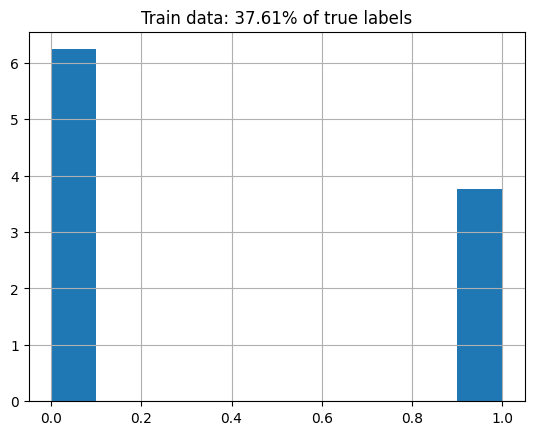

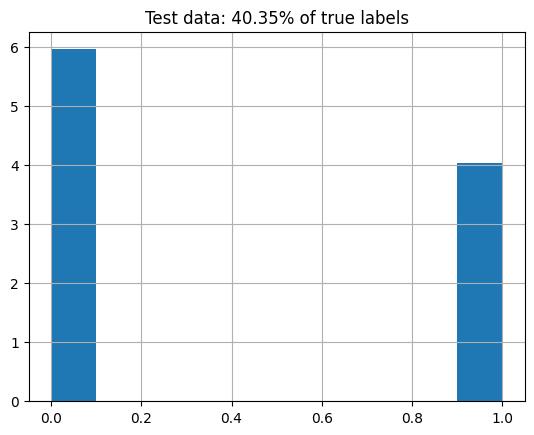

In [1]:
from tf_chpvk_pv.dataset import *
import matplotlib.pyplot as plt
import pandas as pd

df = create_dataset()

train_df, test_df = train_test_split_()

train_df.exp_label.hist(density=True)
amount_of_true = train_df[train_df.exp_label == 1].shape[0]/train_df.shape[0]
plt.title('Train data: {:.2f}% of true labels'.format(amount_of_true*100))
plt.show()
test_df.exp_label.hist(density=True)
amount_of_true = test_df[test_df.exp_label == 1].shape[0]/test_df.shape[0]
plt.title('Test data: {:.2f}% of true labels'.format(amount_of_true*100))
plt.show()

In [2]:
#count the number of material in each class in the training/test sets
dict_ch = {133.15:'F',
           180.61:'Cl',
           198.14:'Se',
           195.56:'Br',
           184.40:'S',
           219.49:'I'
          }

train_df['X'] = train_df.replace({'rX':dict_ch})['rX']
test_df['X'] = test_df.replace({'rX':dict_ch})['rX']

train_vc = pd.DataFrame(train_df[['X', 'exp_label']].groupby('X')['exp_label'].value_counts())
test_vc = pd.DataFrame(test_df[['X', 'exp_label']].groupby('X')['exp_label'].value_counts())

print('In the training set, %s compositions are unstable and %s are stable.' % (train_df['exp_label'].value_counts().values[0], train_df['exp_label'].value_counts().values[1]))
print('The distribution in the training set by anions is the following')
display(train_vc)

print('In the test set, %s compositions are unstable and %s are stable.' % (test_df['exp_label'].value_counts().values[0], test_df['exp_label'].value_counts().values[1]))
print('The distribution in the test set by anions is the following')
display(test_vc)

In the training set, 141 compositions are unstable and 85 are stable.
The distribution in the training set by anions is the following


count
X  exp_label       
Br 0.0           17
   1.0            4
Cl 0.0           43
   1.0           14
F  1.0           40
   0.0           13
I  0.0           29
   1.0            5
S  0.0           26
   1.0           21
Se 0.0           13
   1.0            1

In the test set, 34 compositions are unstable and 23 are stable.
The distribution in the test set by anions is the following


count
X  exp_label       
Br 0.0            5
   1.0            1
Cl 0.0           10
   1.0            4
F  1.0           11
   0.0            2
I  0.0            7
   1.0            2
S  0.0            7
   1.0            5
Se 0.0            3

In [3]:
import glob as gl
from tf_chpvk_pv.config import DATA_DIR

features_path = DATA_DIR / 'features_space/features/features/'

files = gl.glob('*.csv', root_dir=features_path)

In [ ]:
from tf_chpvk_pv.modeling.train import *
from pathlib import Path
from tf_chpvk_pv.config import DATA_DIR, RESULTS_DIR

df_acc_old_path = RESULTS_DIR / 'tolerance factors accuracy for several operations.csv'

train_df, test_df, tolerance_factor_dict = evaluate_t_sisso('')

features_path = DATA_DIR / 'features_space/features/features/'

df_acc_old = pd.read_csv(df_acc_old_path)

tfs = ['t', 'tau', 't_jess']
tf_tresh = [2, 1, 2]
df_acc =pd.DataFrame()
clfs = {}
t_sisso_expressions = {}

for tf, tresh in zip(tfs, tf_tresh):
    df_acc, clf_t = test_tolerance_factor(tf, train_df, test_df, tolerance_factor_dict, df_acc, n_tresh=tresh)
    clfs[tf] = clf_t

for feat in files:
    #check that the tree file doesn't exist
    idx = int(feat.split('/')[-1].split('.csv')[0].split('_')[-1])

    col = 't_sisso_' + str(idx)
    
    re_do = False

    if col in df_acc_old.columns:
        no_nan_values = df_acc_old[col].isna().sum()
        if no_nan_values == 0:
            print('Tree with operations idx = %s already exists' % str(idx))
            continue
        else:
            print('Tree with operations idx = %s has %s missing values' % (str(idx), no_nan_values))
            re_do = True
    else:
        re_do = True

    if re_do:
        try:
            tf = 't_sisso_' + str(idx)
            df = pd.read_csv(features_path / feat)
            t_sisso_expression = train_tree_sis_features(features_path / feat)
            train_df, test_df, tolerance_factor_dict = evaluate_t_sisso(t_sisso_expression, idx)
            df_acc, clf_t = test_tolerance_factor(tf, train_df, test_df, tolerance_factor_dict, df_acc, n_tresh=1)
            clfs[tf] = clf_t
        except:
            print('Error in %s' % feat)
            continue

Classification tree f1 (for t) on the train set: 0.637168.
Classification tree f1 (for t) on the train set (5 fold CV): 0.595418.
Classification tree f1 (for t) on the test set: 0.596491.
0.830243 < t < 0.868341 indicates stable perovskites.
Classification tree f1 (for tau) on the train set: 0.884956.
Classification tree f1 (for tau) on the train set (5 fold CV): 0.851560.
Classification tree f1 (for tau) on the test set: 0.824561.
tau < 4.180000 indicates stable perovskites.
Classification tree f1 (for t_jess) on the train set: 0.725664.
Classification tree f1 (for t_jess) on the train set (5 fold CV): 0.650340.
Classification tree f1 (for t_jess) on the test set: 0.631579.
0.835219 < t_jess < 1.022730 indicates stable perovskites.
2025-03-27 08:45:11.876 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rB_rX_ratio) / (rA_rX_ratio + chi_BX_ratio)) + ((rB_rX_ratio * log_rA_rB_ra

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:41:10.138 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((1.0 / rB_rX_ratio) + (1.0 / log_rA_rB_ratio)) - ((chi_BX_ratio - log_rA_rB_ratio) - rA_rX_ratio))
Classification tree f1 (for t_sisso_26) on the train set: 0.827434.
Classification tree f1 (for t_sisso_26) on the train set (5 fold CV): 0.721356.
Classification tree f1 (for t_sisso_26) on the test set: 0.859649.
t_sisso_26 < 4.464338 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:41:44.887 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * chi_BX_ratio) - (chi_BX_ratio + log_rA_rB_ratio)) + ((rA_rX_ratio - log_rA_rB_ratio) * log(log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_14) on the train set: 0.831858.
Classification tree f1 (for t_sisso_14) on the train set (5 fold CV): 0.761099.
Classification tree f1 (for t_sisso_14) on the test set: 0.929825.
t_sisso_14 < -0.850609 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:42:19.533 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) - (rA_rX_ratio - log_rA_rB_ratio)) - ((rA_rX_ratio - log_rA_rB_ratio) / sqrt(log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_176) on the train set: 0.858407.
Classification tree f1 (for t_sisso_176) on the train set (5 fold CV): 0.771260.
Classification tree f1 (for t_sisso_176) on the test set: 0.859649.
t_sisso_176 < 0.871024 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:42:54.282 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((ln(rB_rX_ratio) / ln(chi_BX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / ln(log_rA_rB_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio^3)^2)) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / ln(chi_BX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / rB_rX_ratio) / ln(log_rA_rB_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A^2) / ln(log_rA_rB_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / log_rA_rB_ratio) / ln(rA_rX_ratio)) / ((rB_rX_ratio^3)^3)) ha

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:43:23.037 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((ln(rB_rX_ratio) / ln(chi_BX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / ln(log_rA_rB_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((chi_BX_ratio / log_rA_rB_ratio) + log(log_rA_rB_ratio)) / ((chi_BX_ratio**3) + rB_rX_ratio))
Classification tree f1 (for t_sisso_98) on the train set: 0.840708.
Classification tree f1 (for t_sisso_98) on the train set (5 fold CV): 0.791827.
Classification tree f1 (for t_sisso_98) on the test set: 0.842105.
t_sisso_98 < 0.814918 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:43:57.114 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((|(rA_rX_ratio^3) - (rB_rX_ratio / log_rA_rB_ratio)|) * ((rB_rX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature ((|(rA_rX_ratio^3) - (rB_rX_ratio / log_rA_rB_ratio)|) / ((log_rA_rB_ratio / rB_rX_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature ((|(rA_rX_ratio^3) - (rB_rX_ratio / log_rA_rB_ratio)|) * ((rA_rX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature ((|(rA_rX_ratio^3) - (rB_rX_ratio / log_rA_rB_ratio)|) / ((log_rA_rB_ratio / rA_rX_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature ((|(rA_rX_ratio^3) - (rB_rX_ratio / log_rA_rB_ratio)|) * ((chi_BX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (((|rB_rX_ratio - log_rA_rB_ratio|) / (rB_rX_r

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:44:30.894 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (1.0 / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (1.0 / ((rA_rX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (1.0 / ((rB_rX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((EA_A * rA_rX_ratio) * (log_rA_rB_ratio**3)) * (log(chi_BX_ratio)**3))
Classification tree f1 (for t_sisso_289) on the train set: 0.792035.
Classification tree f1 (for t_sisso_289) on the train set (5 fold CV): 0.710726.
Classification tree f1 (for t_sisso_289) on the test set: 0.719298.
t_sisso_289 < -0.000559 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:45:04.968 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((|(rB_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^2)|) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio - log_rA_rB_ratio) / (rB_rX_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((rA_rX_ratio - chi_BX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)) / (|(rA_rX_ratio - log_rA_rB_ratio) - (chi_BX_ratio**2)|))
Classification tree f1 (for t_sisso_129) on the train set: 0.796460.
Classification tree f1 (for t_sisso_129) on the train set (5 fold CV): 0.773853.
Classification tree f1 (for t_sisso_129) on the test set: 0.719298.
t_sisso_129 < -0.517538 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:45:38.904 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((1.0 / rB_rX_ratio) + (rB_rX_ratio / log_rA_rB_ratio)) / ((rA_rX_ratio + rB_rX_ratio) + (1.0 / rA_rX_ratio)))
Classification tree f1 (for t_sisso_92) on the train set: 0.853982.
Classification tree f1 (for t_sisso_92) on the train set (5 fold CV): 0.747482.
Classification tree f1 (for t_sisso_92) on the test set: 0.859649.
t_sisso_92 < 1.174482 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:46:12.911 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((EA_A * rB_rX_ratio) * (rB_rX_ratio * log_rA_rB_ratio)) + ((EA_A * log_rA_rB_ratio) * log(rA_rX_ratio)))
Classification tree f1 (for t_sisso_84) on the train set: 0.774336.
Classification tree f1 (for t_sisso_84) on the train set (5 fold CV): 0.711438.
Classification tree f1 (for t_sisso_84) on the test set: 0.754386.
t_sisso_84 < -0.020287 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:46:46.814 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rA_rX_ratio - log_rA_rB_ratio|) - log(chi_BX_ratio)|) + (|(|rB_rX_ratio - log_rA_rB_ratio|) - (chi_BX_ratio + log_rA_rB_ratio)|))
Classification tree f1 (for t_sisso_53) on the train set: 0.858407.
Classification tree f1 (for t_sisso_53) on the train set (5 fold CV): 0.777643.
Classification tree f1 (for t_sisso_53) on the test set: 0.842105.
t_sisso_53 < 1.803467 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:47:20.747 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|log(rA_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)|) - (|sqrt(rA_rX_ratio) - sqrt(chi_BX_ratio)|)|)
Classification tree f1 (for t_sisso_259) on the train set: 0.849558.
Classification tree f1 (for t_sisso_259) on the train set (5 fold CV): 0.770938.
Classification tree f1 (for t_sisso_259) on the test set: 0.842105.
t_sisso_259 < 0.210603 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:47:54.572 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio * log_rA_rB_ratio) - (log_rA_rB_ratio**3)|) - (|(1.0 / rB_rX_ratio) - (1.0 / log_rA_rB_ratio)|)|)
Classification tree f1 (for t_sisso_216) on the train set: 0.814159.
Classification tree f1 (for t_sisso_216) on the train set (5 fold CV): 0.779205.
Classification tree f1 (for t_sisso_216) on the test set: 0.789474.
t_sisso_216 < 0.595547 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:48:28.569 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) * sqrt(log_rA_rB_ratio)) * (rB_rX_ratio * log_rA_rB_ratio))
Classification tree f1 (for t_sisso_286) on the train set: 0.769912.
Classification tree f1 (for t_sisso_286) on the train set (5 fold CV): 0.680761.
Classification tree f1 (for t_sisso_286) on the test set: 0.719298.
t_sisso_286 < 0.095928 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:49:02.383 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rA_rX_ratio) - rB_rX_ratio) - ((|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio))
Classification tree f1 (for t_sisso_140) on the train set: 0.858407.
Classification tree f1 (for t_sisso_140) on the train set (5 fold CV): 0.762358.
Classification tree f1 (for t_sisso_140) on the test set: 0.859649.
t_sisso_140 < 1.164745 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:49:38.101 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rB_rX_ratio) + (rB_rX_ratio**3)) + (log(log_rA_rB_ratio)**3))
Classification tree f1 (for t_sisso_119) on the train set: 0.845133.
Classification tree f1 (for t_sisso_119) on the train set (5 fold CV): 0.755896.
Classification tree f1 (for t_sisso_119) on the test set: 0.824561.
t_sisso_119 < -0.815641 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:50:12.642 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rB_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio + log_rA_rB_ratio)|) + (|sqrt(chi_BX_ratio) - chi_BX_ratio|))
Classification tree f1 (for t_sisso_52) on the train set: 0.827434.
Classification tree f1 (for t_sisso_52) on the train set (5 fold CV): 0.802904.
Classification tree f1 (for t_sisso_52) on the test set: 0.754386.
t_sisso_52 < 0.940933 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:50:47.414 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rA_rX_ratio) - sqrt(rB_rX_ratio)) + (sqrt(log_rA_rB_ratio) - log_rA_rB_ratio))
Classification tree f1 (for t_sisso_35) on the train set: 0.840708.
Classification tree f1 (for t_sisso_35) on the train set (5 fold CV): 0.760887.
Classification tree f1 (for t_sisso_35) on the test set: 0.842105.
t_sisso_35 < 0.414099 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:51:22.108 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (1.0 / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (|(log(log_rA_rB_ratio)**3) - (1.0 / rB_rX_ratio)|)
Classification tree f1 (for t_sisso_254) on the train set: 0.858407.
Classification tree f1 (for t_sisso_254) on the train set (5 fold CV): 0.788575.
Classification tree f1 (for t_sisso_254) on the test set: 0.877193.
t_sisso_254 < 2.287754 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:51:57.066 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio + rB_rX_ratio) + rA_rX_ratio) * ((rB_rX_ratio**2)**2))
Classification tree f1 (for t_sisso_71) on the train set: 0.606195.
Classification tree f1 (for t_sisso_71) on the train set (5 fold CV): 0.609958.
Classification tree f1 (for t_sisso_71) on the test set: 0.561404.
t_sisso_71 < 0.040808 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:52:31.977 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio - log_rA_rB_ratio) * (log_rA_rB_ratio**3)) * ((log_rA_rB_ratio**3) - log_rA_rB_ratio))
Classification tree f1 (for t_sisso_160) on the train set: 0.831858.
Classification tree f1 (for t_sisso_160) on the train set (5 fold CV): 0.751019.
Classification tree f1 (for t_sisso_160) on the test set: 0.824561.
t_sisso_160 < -0.017103 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:53:06.940 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|) - ((|chi_BX_ratio - log_rA_rB_ratio|) / exp(chi_BX_ratio))|)
Classification tree f1 (for t_sisso_229) on the train set: 0.853982.
Classification tree f1 (for t_sisso_229) on the train set (5 fold CV): 0.755434.
Classification tree f1 (for t_sisso_229) on the test set: 0.842105.
t_sisso_229 < 0.676665 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:53:41.717 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio + rB_rX_ratio) + rA_rX_ratio) * ((rB_rX_ratio**2)**2))
Classification tree f1 (for t_sisso_80) on the train set: 0.606195.
Classification tree f1 (for t_sisso_80) on the train set (5 fold CV): 0.609958.
Classification tree f1 (for t_sisso_80) on the test set: 0.561404.
t_sisso_80 < 0.040808 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:54:16.534 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((|rB_rX_ratio - log_rA_rB_ratio|) - log_rA_rB_ratio) - (|(chi_BX_ratio**3) - chi_BX_ratio|))
Classification tree f1 (for t_sisso_135) on the train set: 0.823009.
Classification tree f1 (for t_sisso_135) on the train set (5 fold CV): 0.700021.
Classification tree f1 (for t_sisso_135) on the test set: 0.807018.
t_sisso_135 < -0.769353 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:54:51.242 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rB_rX_ratio) * exp(log_rA_rB_ratio)) * log((rB_rX_ratio * log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_284) on the train set: 0.823009.
Classification tree f1 (for t_sisso_284) on the train set (5 fold CV): 0.723746.
Classification tree f1 (for t_sisso_284) on the test set: 0.824561.
t_sisso_284 < -1.582279 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:55:26.075 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((rA_rX_ratio**2) - rB_rX_ratio) - ((rB_rX_ratio - log_rA_rB_ratio)**2))
Classification tree f1 (for t_sisso_188) on the train set: 0.805310.
Classification tree f1 (for t_sisso_188) on the train set (5 fold CV): 0.747512.
Classification tree f1 (for t_sisso_188) on the test set: 0.771930.
t_sisso_188 < 0.190030 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:56:00.806 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (|(|(|rA_rX_ratio - log_rA_rB_ratio|) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|exp((1.0 / log_rA_rB_ratio)) - (1.0 / rB_rX_ratio)|) has values greater than 1e6. Skipping.
Feature (|(|(|rA_rX_ratio - chi_BX_ratio|) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(|rB_rX_ratio - chi_BX_ratio|) - (1.0 / chi_BX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(1.0 / rB_rX_ratio) - (|chi_BX_ratio - log_rA_rB_ratio|)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(|rB_rX_ratio - chi_BX_ratio|) - exp(log_rA_rB_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(|rA_rX_ratio - log_rA_rB_ratio|) - exp(lo

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:56:33.473 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio**2) - (|rB_rX_ratio - log_rA_rB_ratio|)) - ((|rB_rX_ratio - log_rA_rB_ratio|) - (log_rA_rB_ratio**2)))
Classification tree f1 (for t_sisso_144) on the train set: 0.809735.
Classification tree f1 (for t_sisso_144) on the train set (5 fold CV): 0.774438.
Classification tree f1 (for t_sisso_144) on the test set: 0.807018.
t_sisso_144 < 0.113303 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:57:08.260 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / ln(chi_BX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature ((ln(log_rA_rB_ratio) / ln(chi_BX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / EA_A) / ln(chi_BX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature ((ln(log_rA_rB_ratio) / (log_rA_rB_ratio^2))^2) has values greater than 1e6. Skipping.
Feature ((ln(log_rA_rB_ratio)^2) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / rB_rX_ratio)^2) / (ln(log_rA_rB_ratio)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / rB_rX_ratio) / ln(log_rA_rB_ratio))^2) has values greater than 1e6. Skip

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:57:41.198 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio - log_rA_rB_ratio) - log_rA_rB_ratio) - ((1.0 / log_rA_rB_ratio) - rB_rX_ratio))
Classification tree f1 (for t_sisso_196) on the train set: 0.862832.
Classification tree f1 (for t_sisso_196) on the train set (5 fold CV): 0.781232.
Classification tree f1 (for t_sisso_196) on the test set: 0.877193.
t_sisso_196 < -1.975124 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:58:15.871 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rA_rX_ratio) + sqrt(rB_rX_ratio)) - ((rA_rX_ratio - log_rA_rB_ratio) + sqrt(log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_33) on the train set: 0.787611.
Classification tree f1 (for t_sisso_33) on the train set (5 fold CV): 0.730452.
Classification tree f1 (for t_sisso_33) on the test set: 0.807018.
t_sisso_33 < 0.585090 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:58:50.749 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((EA_A / rA_rX_ratio) / rA_rX_ratio) + ((EA_A * rA_rX_ratio) / log(rB_rX_ratio)))
Classification tree f1 (for t_sisso_69) on the train set: 0.805310.
Classification tree f1 (for t_sisso_69) on the train set (5 fold CV): 0.716799.
Classification tree f1 (for t_sisso_69) on the test set: 0.789474.
t_sisso_69 < 0.194469 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 09:59:25.325 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio + chi_BX_ratio) + (rB_rX_ratio / log_rA_rB_ratio)) / ((rA_rX_ratio + rB_rX_ratio) - (log_rA_rB_ratio**2)))
Classification tree f1 (for t_sisso_17) on the train set: 0.694690.
Classification tree f1 (for t_sisso_17) on the train set (5 fold CV): 0.710226.
Classification tree f1 (for t_sisso_17) on the test set: 0.701754.
t_sisso_17 < 2.466908 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:00:00.180 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) / log_rA_rB_ratio) * (exp(chi_BX_ratio) - (chi_BX_ratio / log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_148) on the train set: 0.853982.
Classification tree f1 (for t_sisso_148) on the train set (5 fold CV): 0.761833.
Classification tree f1 (for t_sisso_148) on the test set: 0.842105.
t_sisso_148 < 2.043626 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:00:34.824 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * log_rA_rB_ratio) * rA_rX_ratio) * (|sqrt(rB_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)|))
Classification tree f1 (for t_sisso_213) on the train set: 0.853982.
Classification tree f1 (for t_sisso_213) on the train set (5 fold CV): 0.785075.
Classification tree f1 (for t_sisso_213) on the test set: 0.877193.
t_sisso_213 < 0.234302 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:01:09.659 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) * (|rA_rX_ratio - chi_BX_ratio|)) + (|(|rB_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio + log_rA_rB_ratio)|))
Classification tree f1 (for t_sisso_37) on the train set: 0.862832.
Classification tree f1 (for t_sisso_37) on the train set (5 fold CV): 0.782914.
Classification tree f1 (for t_sisso_37) on the test set: 0.894737.
t_sisso_37 < 0.981273 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:01:44.270 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rB_rX_ratio - chi_BX_ratio|) - (chi_BX_ratio / rA_rX_ratio)|) + ((|rB_rX_ratio - log_rA_rB_ratio|) / (rA_rX_ratio + chi_BX_ratio)))
Classification tree f1 (for t_sisso_44) on the train set: 0.792035.
Classification tree f1 (for t_sisso_44) on the train set (5 fold CV): 0.772581.
Classification tree f1 (for t_sisso_44) on the test set: 0.666667.
t_sisso_44 < 0.785580 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:02:18.110 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio * chi_BX_ratio) - (1.0 / log_rA_rB_ratio)|) - (|(1.0 / rB_rX_ratio) - (chi_BX_ratio / rA_rX_ratio)|)|)
Classification tree f1 (for t_sisso_205) on the train set: 0.805310.
Classification tree f1 (for t_sisso_205) on the train set (5 fold CV): 0.790611.
Classification tree f1 (for t_sisso_205) on the test set: 0.754386.
t_sisso_205 < 0.924806 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:02:51.833 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((|rB_rX_ratio - log_rA_rB_ratio|) - sqrt(log_rA_rB_ratio)) - (|(chi_BX_ratio**2) - chi_BX_ratio|))
Classification tree f1 (for t_sisso_143) on the train set: 0.827434.
Classification tree f1 (for t_sisso_143) on the train set (5 fold CV): 0.764679.
Classification tree f1 (for t_sisso_143) on the test set: 0.807018.
t_sisso_143 < -0.771812 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:03:25.793 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio - chi_BX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)) * ((1.0 / rA_rX_ratio) - (|rB_rX_ratio - chi_BX_ratio|)))
Classification tree f1 (for t_sisso_122) on the train set: 0.805310.
Classification tree f1 (for t_sisso_122) on the train set (5 fold CV): 0.789270.
Classification tree f1 (for t_sisso_122) on the test set: 0.754386.
t_sisso_122 < -0.146331 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:03:59.586 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * chi_BX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)) * (|(log_rA_rB_ratio / chi_BX_ratio) - log_rA_rB_ratio|))
Classification tree f1 (for t_sisso_120) on the train set: 0.818584.
Classification tree f1 (for t_sisso_120) on the train set (5 fold CV): 0.793282.
Classification tree f1 (for t_sisso_120) on the test set: 0.754386.
t_sisso_120 < 0.064987 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:04:33.510 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|log(rA_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)|) / (|sqrt(chi_BX_ratio) - chi_BX_ratio|))
Classification tree f1 (for t_sisso_239) on the train set: 0.800885.
Classification tree f1 (for t_sisso_239) on the train set (5 fold CV): 0.742037.
Classification tree f1 (for t_sisso_239) on the test set: 0.754386.
t_sisso_239 < 3.256490 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:05:07.231 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rB_rX_ratio) - log_rA_rB_ratio) - (log(log_rA_rB_ratio)**2))
Classification tree f1 (for t_sisso_202) on the train set: 0.858407.
Classification tree f1 (for t_sisso_202) on the train set (5 fold CV): 0.766137.
Classification tree f1 (for t_sisso_202) on the test set: 0.877193.
t_sisso_202 < -1.644901 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:05:41.089 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rB_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio + log_rA_rB_ratio)|) + (|(chi_BX_ratio**2) - chi_BX_ratio|))
Classification tree f1 (for t_sisso_50) on the train set: 0.809735.
Classification tree f1 (for t_sisso_50) on the train set (5 fold CV): 0.776298.
Classification tree f1 (for t_sisso_50) on the test set: 0.701754.
t_sisso_50 < 0.994877 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:06:14.850 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio - log_rA_rB_ratio) / (rB_rX_ratio * chi_BX_ratio)) - ((rB_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio**2)))
Classification tree f1 (for t_sisso_150) on the train set: 0.716814.
Classification tree f1 (for t_sisso_150) on the train set (5 fold CV): 0.722348.
Classification tree f1 (for t_sisso_150) on the test set: 0.684211.
t_sisso_150 < 0.110413 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:06:48.686 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(|rA_rX_ratio - chi_BX_ratio|) - (|rA_rX_ratio - log_rA_rB_ratio|)|) - (|(rA_rX_ratio**2) - (|rB_rX_ratio - log_rA_rB_ratio|)|)|)
Classification tree f1 (for t_sisso_246) on the train set: 0.849558.
Classification tree f1 (for t_sisso_246) on the train set (5 fold CV): 0.765819.
Classification tree f1 (for t_sisso_246) on the test set: 0.877193.
t_sisso_246 < 0.469588 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:07:22.468 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) - (rA_rX_ratio - log_rA_rB_ratio)) * (sqrt(rA_rX_ratio) - sqrt(log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_161) on the train set: 0.840708.
Classification tree f1 (for t_sisso_161) on the train set (5 fold CV): 0.766238.
Classification tree f1 (for t_sisso_161) on the test set: 0.789474.
t_sisso_161 < 0.018465 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:07:56.409 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rA_rX_ratio - log_rA_rB_ratio|) - log(log_rA_rB_ratio)|) * (log_rA_rB_ratio**2))
Classification tree f1 (for t_sisso_221) on the train set: 0.871681.
Classification tree f1 (for t_sisso_221) on the train set (5 fold CV): 0.797575.
Classification tree f1 (for t_sisso_221) on the test set: 0.859649.
t_sisso_221 < 0.253770 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:08:30.230 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rA_rX_ratio) - log_rA_rB_ratio) - (sqrt(rB_rX_ratio) - sqrt(log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_200) on the train set: 0.840708.
Classification tree f1 (for t_sisso_200) on the train set (5 fold CV): 0.760887.
Classification tree f1 (for t_sisso_200) on the test set: 0.842105.
t_sisso_200 < 0.414099 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:09:05.082 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * chi_BX_ratio) - (chi_BX_ratio + log_rA_rB_ratio)) - (sqrt(rB_rX_ratio) * (rB_rX_ratio - log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_13) on the train set: 0.756637.
Classification tree f1 (for t_sisso_13) on the train set (5 fold CV): 0.739368.
Classification tree f1 (for t_sisso_13) on the test set: 0.684211.
t_sisso_13 < -0.638026 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:09:39.857 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rA_rX_ratio) - log_rA_rB_ratio) - (sqrt(rB_rX_ratio) - sqrt(log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_193) on the train set: 0.840708.
Classification tree f1 (for t_sisso_193) on the train set (5 fold CV): 0.760887.
Classification tree f1 (for t_sisso_193) on the test set: 0.842105.
t_sisso_193 < 0.414099 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:10:14.731 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio * log_rA_rB_ratio) - (log_rA_rB_ratio**3)|) - ((rB_rX_ratio**3) * (rB_rX_ratio * log_rA_rB_ratio))|)
Classification tree f1 (for t_sisso_124) on the train set: 0.849558.
Classification tree f1 (for t_sisso_124) on the train set (5 fold CV): 0.777988.
Classification tree f1 (for t_sisso_124) on the test set: 0.894737.
t_sisso_124 < 0.247938 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:10:49.401 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rA_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio * log_rA_rB_ratio)|) / (|(rA_rX_ratio * chi_BX_ratio) - (|rB_rX_ratio - chi_BX_ratio|)|))
Classification tree f1 (for t_sisso_208) on the train set: 0.818584.
Classification tree f1 (for t_sisso_208) on the train set (5 fold CV): 0.787994.
Classification tree f1 (for t_sisso_208) on the test set: 0.771930.
t_sisso_208 < 0.455295 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:11:24.344 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio - log_rA_rB_ratio) + log(log_rA_rB_ratio)) - log((rB_rX_ratio + log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_25) on the train set: 0.800885.
Classification tree f1 (for t_sisso_25) on the train set (5 fold CV): 0.721435.
Classification tree f1 (for t_sisso_25) on the test set: 0.736842.
t_sisso_25 < -0.343349 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:11:58.970 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((exp(rA_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)) - (|sqrt(rB_rX_ratio) - log_rA_rB_ratio|))
Classification tree f1 (for t_sisso_136) on the train set: 0.853982.
Classification tree f1 (for t_sisso_136) on the train set (5 fold CV): 0.783785.
Classification tree f1 (for t_sisso_136) on the test set: 0.859649.
t_sisso_136 < 2.057903 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:12:33.854 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((EA_A / chi_BX_ratio) / (chi_BX_ratio^3)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / rB_rX_ratio)^3) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rA_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / EA_A) / (rB_rX_ratio^2)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / rB_rX_ratio) / (log_rA_rB_ratio^2)) / ((log_rA_rB_ratio / chi_BX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / EA_A) / (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / log_rA

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) / exp(rB_rX_ratio)) + (log_rA_rB_ratio / rA_rX_ratio))
Classification tree f1 (for t_sisso_87) on the train set: 0.858407.
Classification tree f1 (for t_sisso_87) on the train set (5 fold CV): 0.754524.
Classification tree f1 (for t_sisso_87) on the test set: 0.877193.
t_sisso_87 < 1.606103 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:13:37.161 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|((rA_rX_ratio + rB_rX_ratio) + (|rB_rX_ratio - log_rA_rB_ratio|)) - (rA_rX_ratio**3)|)
Classification tree f1 (for t_sisso_58) on the train set: 0.845133.
Classification tree f1 (for t_sisso_58) on the train set (5 fold CV): 0.765626.
Classification tree f1 (for t_sisso_58) on the test set: 0.894737.
t_sisso_58 < 0.845501 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:14:11.502 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) * (|rA_rX_ratio - chi_BX_ratio|)) + (|(|rB_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio + log_rA_rB_ratio)|))
Classification tree f1 (for t_sisso_39) on the train set: 0.862832.
Classification tree f1 (for t_sisso_39) on the train set (5 fold CV): 0.782914.
Classification tree f1 (for t_sisso_39) on the test set: 0.894737.
t_sisso_39 < 0.981273 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:14:46.074 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio**2)**2)**2)
Classification tree f1 (for t_sisso_116) on the train set: 0.584071.
Classification tree f1 (for t_sisso_116) on the train set (5 fold CV): 0.596823.
Classification tree f1 (for t_sisso_116) on the test set: 0.596491.
t_sisso_116 < 0.000469 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:15:20.277 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (|(|(rA_rX_ratio * log_rA_rB_ratio) - (log_rA_rB_ratio**3)|) - ((rB_rX_ratio**3) * (rB_rX_ratio * log_rA_rB_ratio))|)
Classification tree f1 (for t_sisso_212) on the train set: 0.849558.
Classification tree f1 (for t_sisso_212) on the train set (5 fold CV): 0.777988.
Classification tree f1 (for t_sisso_212) on the test set: 0.894737.
t_sisso_212 < 0.247938 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:15:54.767 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((1.0 / rB_rX_ratio) + (1.0 / log_rA_rB_ratio)) + (rA_rX_ratio + log_rA_rB_ratio))
Classification tree f1 (for t_sisso_115) on the train set: 0.871681.
Classification tree f1 (for t_sisso_115) on the train set (5 fold CV): 0.789040.
Classification tree f1 (for t_sisso_115) on the test set: 0.877193.
t_sisso_115 < 5.321800 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:16:29.107 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (1.0 / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (1.0 / ((rA_rX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (1.0 / ((rB_rX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Identified expression for t_sisso: ((sqrt(log_rA_rB_ratio) * rB_rX_ratio) * sqrt(sqrt(log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_288) on the train set: 0.778761.
Classification tree f1 (for t_sisso_288) on the train set (5 fold CV): 0.688862.
Classification tree f1 (for t_sisso_288) on the test set: 0.719298.
t_sisso_288 < 0.325749 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:17:03.697 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((|rA_rX_ratio - chi_BX_ratio|) + exp(rA_rX_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) + (|chi_BX_ratio - log_rA_rB_ratio|)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((|(1.0 / rA_rX_ratio) - (rA_rX_ratio + log_rA_rB_ratio)|) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio + log_rA_rB_ratio) + rA_rX_ratio) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio + log_rA_rB_ratio) + log_rA_rB_ratio) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio + log_rA_rB_ratio) + (|rB_rX_ratio - log_rA_rB_ratio|)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rB_rX_ratio) + exp(log_rA_rB_r

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Identified expression for t_sisso: (((rA_rX_ratio - rB_rX_ratio) - (log_rA_rB_ratio**2)) - (sqrt(rA_rX_ratio) - (rA_rX_ratio * log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_164) on the train set: 0.818584.
Classification tree f1 (for t_sisso_164) on the train set (5 fold CV): 0.756613.
Classification tree f1 (for t_sisso_164) on the test set: 0.754386.
t_sisso_164 < -0.414826 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:18:10.723 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((log_rA_rB_ratio / rB_rX_ratio) * log(log_rA_rB_ratio)) / (log(rA_rX_ratio) - (rB_rX_ratio / rA_rX_ratio)))
Classification tree f1 (for t_sisso_153) on the train set: 0.867257.
Classification tree f1 (for t_sisso_153) on the train set (5 fold CV): 0.770586.
Classification tree f1 (for t_sisso_153) on the test set: 0.877193.
t_sisso_153 < 0.884001 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:18:44.967 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rA_rX_ratio) + sqrt(log_rA_rB_ratio)) - (sqrt(rB_rX_ratio) + log_rA_rB_ratio))
Classification tree f1 (for t_sisso_31) on the train set: 0.840708.
Classification tree f1 (for t_sisso_31) on the train set (5 fold CV): 0.760887.
Classification tree f1 (for t_sisso_31) on the test set: 0.842105.
t_sisso_31 < 0.414099 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:19:19.532 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rB_rX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^2)) / ((chi_BX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^2))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^2)) / ((chi_BX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^2))) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^2)) / ((chi_BX_ratio * log_rA_rB_ratio) * log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) / chi_BX_ratio) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) / sqrt(log_rA_rB_ratio)) / ((chi_BX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^2))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) / sqrt(log_rA_rB_ratio)) / ((chi_BX_rati

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:19:53.531 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((|rB_rX_ratio - log_rA_rB_ratio|) / log(chi_BX_ratio)) / ((rA_rX_ratio * chi_BX_ratio) * (chi_BX_ratio * log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_209) on the train set: 0.783186.
Classification tree f1 (for t_sisso_209) on the train set (5 fold CV): 0.770283.
Classification tree f1 (for t_sisso_209) on the test set: 0.684211.
t_sisso_209 < -3.315442 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:20:28.107 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (|((1.0 / rB_rX_ratio) - exp(log_rA_rB_ratio)) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|((1.0 / rA_rX_ratio) - exp(log_rA_rB_ratio)) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|((1.0 / rA_rX_ratio) - exp(rA_rX_ratio)) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|((1.0 / chi_BX_ratio) - rA_rX_ratio) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(|rA_rX_ratio - log_rA_rB_ratio|) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|((1.0 / chi_BX_ratio) - log_rA_rB_ratio) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|exp((1.0 / log_rA_rB_ratio)) - (1.0 / rB_rX_ratio)|) has values greater than 1e6. Skippin

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:21:01.884 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((chi_BX_ratio / rB_rX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature ((exp(chi_BX_ratio) / rB_rX_ratio) / (ln(log_rA_rB_ratio)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / ln(chi_BX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature ((ln(log_rA_rB_ratio) / ln(chi_BX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / EA_A) / ln(chi_BX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) / rB_rX_ratio) / (ln(log_rA_rB_ratio)^2)) has values greater than 1e6. Skipping.
Feature exp(((rA_rX_ratio / log_rA_rB_ratio) / rB_rX_ratio)) has values 

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:21:34.807 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((exp(rB_rX_ratio) + rB_rX_ratio) + sqrt(sqrt(log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_105) on the train set: 0.730088.
Classification tree f1 (for t_sisso_105) on the train set (5 fold CV): 0.656099.
Classification tree f1 (for t_sisso_105) on the test set: 0.789474.
t_sisso_105 < 2.931571 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:22:08.651 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((|rB_rX_ratio - log_rA_rB_ratio|) - log_rA_rB_ratio) - (|(chi_BX_ratio**3) - chi_BX_ratio|))
Classification tree f1 (for t_sisso_145) on the train set: 0.823009.
Classification tree f1 (for t_sisso_145) on the train set (5 fold CV): 0.700021.
Classification tree f1 (for t_sisso_145) on the test set: 0.807018.
t_sisso_145 < -0.769353 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:22:42.501 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rA_rX_ratio) - log_rA_rB_ratio) - (sqrt(rB_rX_ratio) - sqrt(log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_189) on the train set: 0.840708.
Classification tree f1 (for t_sisso_189) on the train set (5 fold CV): 0.760887.
Classification tree f1 (for t_sisso_189) on the test set: 0.842105.
t_sisso_189 < 0.414099 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:23:16.293 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rB_rX_ratio - chi_BX_ratio|) - (chi_BX_ratio / rA_rX_ratio)|) + ((|rB_rX_ratio - log_rA_rB_ratio|) / (rA_rX_ratio + chi_BX_ratio)))
Classification tree f1 (for t_sisso_48) on the train set: 0.792035.
Classification tree f1 (for t_sisso_48) on the train set (5 fold CV): 0.772581.
Classification tree f1 (for t_sisso_48) on the test set: 0.666667.
t_sisso_48 < 0.785580 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:23:50.246 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((chi_BX_ratio / rB_rX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / exp((log_rA_rB_ratio / chi_BX_ratio))) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / ((rA_rX_ratio / chi_BX_ratio)^2)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / exp((rA_rX_ratio / chi_BX_ratio))) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / exp((1.0 / rA_rX_ratio))) has values greater than 1e6. Skipping.
Feature exp(((rA_rX_ratio / log_rA_rB_ratio) / rB_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio / rA_rX_ratio)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) / exp(chi_BX_ratio)) / ((log_rA_rB

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:24:23.054 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio - log_rA_rB_ratio) - (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^3)) / ((log_rA_rB_ratio / rB_rX_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^3)) * ((rA_rX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^3)) / ((log_rA_rB_ratio / chi_BX_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio / rB_rX_ratio)) / ((rA_rX_ratio * rB_rX_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio / rB_rX_ratio)) / ((

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:24:57.564 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((1.0 / log_rA_rB_ratio)) - ((1.0 / log_rA_rB_ratio) - log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / chi_BX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (rB_rX_ratio - chi_BX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / rA_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / rB_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - sqrt(chi_BX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (chi_BX_ratio - log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (e

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:25:31.819 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(|rA_rX_ratio - chi_BX_ratio|) - (|rA_rX_ratio - log_rA_rB_ratio|)|) - (|(rA_rX_ratio**2) - (|rB_rX_ratio - log_rA_rB_ratio|)|)|)
Classification tree f1 (for t_sisso_257) on the train set: 0.849558.
Classification tree f1 (for t_sisso_257) on the train set (5 fold CV): 0.765819.
Classification tree f1 (for t_sisso_257) on the test set: 0.877193.
t_sisso_257 < 0.469588 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:26:06.422 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rA_rX_ratio - log_rA_rB_ratio|) - log(chi_BX_ratio)|) + (|(|rB_rX_ratio - log_rA_rB_ratio|) - (chi_BX_ratio + log_rA_rB_ratio)|))
Classification tree f1 (for t_sisso_62) on the train set: 0.858407.
Classification tree f1 (for t_sisso_62) on the train set (5 fold CV): 0.777643.
Classification tree f1 (for t_sisso_62) on the test set: 0.842105.
t_sisso_62 < 1.803467 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:26:40.292 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) / exp(rB_rX_ratio)) + (log_rA_rB_ratio / rA_rX_ratio))
Classification tree f1 (for t_sisso_89) on the train set: 0.858407.
Classification tree f1 (for t_sisso_89) on the train set (5 fold CV): 0.754524.
Classification tree f1 (for t_sisso_89) on the test set: 0.877193.
t_sisso_89 < 1.606103 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:27:14.487 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((1.0 / log_rA_rB_ratio)) / exp((log_rA_rB_ratio / chi_BX_ratio))) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / (chi_BX_ratio^3)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / exp((rA_rX_ratio / chi_BX_ratio))) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / exp((1.0 / rA_rX_ratio))) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio / log_rA_rB_ratio)) / exp((chi_BX_ratio^3))) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rA_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature exp(((rA_rX_ratio / log_rA_rB_ratio) / rB_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio / rA_rX_ratio)

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:27:45.483 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) * (rB_rX_ratio**3)) * (sqrt(rB_rX_ratio) * exp(rB_rX_ratio)))
Classification tree f1 (for t_sisso_282) on the train set: 0.606195.
Classification tree f1 (for t_sisso_282) on the train set (5 fold CV): 0.607721.
Classification tree f1 (for t_sisso_282) on the test set: 0.543860.
t_sisso_282 < 0.014762 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:28:19.408 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) - (rA_rX_ratio**2)) + ((rB_rX_ratio - log_rA_rB_ratio)**2))
Classification tree f1 (for t_sisso_11) on the train set: 0.827434.
Classification tree f1 (for t_sisso_11) on the train set (5 fold CV): 0.732128.
Classification tree f1 (for t_sisso_11) on the test set: 0.824561.
t_sisso_11 < -0.308483 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:28:53.256 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) / exp(rB_rX_ratio)) + ((rA_rX_ratio + log_rA_rB_ratio) / rA_rX_ratio))
Classification tree f1 (for t_sisso_86) on the train set: 0.858407.
Classification tree f1 (for t_sisso_86) on the train set (5 fold CV): 0.754524.
Classification tree f1 (for t_sisso_86) on the test set: 0.877193.
t_sisso_86 < 2.606103 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:29:27.215 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((rA_rX_ratio * log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rB_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) * rA_rX_ratio) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio * rB_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio * log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) * exp(rA_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) 

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:30:00.107 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio**2) * log_rA_rB_ratio) * (|sqrt(rB_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)|))
Classification tree f1 (for t_sisso_220) on the train set: 0.853982.
Classification tree f1 (for t_sisso_220) on the train set (5 fold CV): 0.785075.
Classification tree f1 (for t_sisso_220) on the test set: 0.877193.
t_sisso_220 < 0.234302 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:30:34.195 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio * chi_BX_ratio) * (rA_rX_ratio / log_rA_rB_ratio)) / ((rB_rX_ratio * log_rA_rB_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / (chi_BX_ratio^3)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio * chi_BX_ratio) / (rB_rX_ratio^3)) / ((log_rA_rB_ratio / chi_BX_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / log_rA_rB_ratio)^3) / ((rB_rX_ratio^3) * log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rA_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / rB_rX_ratio)^3) / ((rA_rX_ratio * log_rA_rB_ratio) * 

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Identified expression for t_sisso: ((log(rB_rX_ratio)**2) + (log(log_rA_rB_ratio)**2))
Classification tree f1 (for t_sisso_106) on the train set: 0.827434.
Classification tree f1 (for t_sisso_106) on the train set (5 fold CV): 0.735200.
Classification tree f1 (for t_sisso_106) on the test set: 0.771930.
t_sisso_106 < 0.928798 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:31:40.245 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (1.0 / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: ((log(rA_rX_ratio) + log_rA_rB_ratio) + ((1.0 / rB_rX_ratio) + (1.0 / log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_114) on the train set: 0.871681.
Classification tree f1 (for t_sisso_114) on the train set (5 fold CV): 0.796170.
Classification tree f1 (for t_sisso_114) on the test set: 0.877193.
t_sisso_114 < 4.297867 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:32:14.190 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((1.0 / log_rA_rB_ratio)) - ((1.0 / log_rA_rB_ratio) - log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / chi_BX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (rB_rX_ratio - chi_BX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / rA_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / rB_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (1.0 / log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) - (chi_BX_ratio - log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature exp((1.0 / log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_rat

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:32:47.927 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) - (rA_rX_ratio - log_rA_rB_ratio)) - ((rA_rX_ratio - log_rA_rB_ratio) / sqrt(log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_183) on the train set: 0.858407.
Classification tree f1 (for t_sisso_183) on the train set (5 fold CV): 0.771260.
Classification tree f1 (for t_sisso_183) on the test set: 0.859649.
t_sisso_183 < 0.871024 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:33:21.957 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((1.0 / log_rA_rB_ratio)) / ((1.0 / log_rA_rB_ratio) - rB_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / ((rA_rX_ratio / log_rA_rB_ratio) - log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) - exp(rB_rX_ratio)) - (exp(rB_rX_ratio) - (log_rA_rB_ratio / rA_rX_ratio)))
Classification tree f1 (for t_sisso_169) on the train set: 0.858407.
Classification tree f1 (for t_sisso_169) on the train set (5 fold CV): 0.759431.
Classification tree f1 (for t_sisso_169) on the test set: 0.877193.
t_sisso_169 < -1.063184 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:33:55.858 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((ln(rB_rX_ratio) + exp(log_rA_rB_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((ln(rA_rX_ratio) + (rA_rX_ratio + log_rA_rB_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio + log_rA_rB_ratio) + rA_rX_ratio) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) + ln(rB_rX_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio + log_rA_rB_ratio) + ln(log_rA_rB_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio + log_rA_rB_ratio) + log_rA_rB_ratio) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rB_rX_ratio) + exp(log_rA_rB_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values 

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:34:27.322 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rB_rX_ratio**2) - rA_rX_ratio|) - ((|rB_rX_ratio - log_rA_rB_ratio|) * (log_rA_rB_ratio**2))|)
Classification tree f1 (for t_sisso_211) on the train set: 0.853982.
Classification tree f1 (for t_sisso_211) on the train set (5 fold CV): 0.773128.
Classification tree f1 (for t_sisso_211) on the test set: 0.877193.
t_sisso_211 < 0.558454 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:35:01.200 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rA_rX_ratio) * (|rB_rX_ratio - log_rA_rB_ratio|)) * (|(chi_BX_ratio * log_rA_rB_ratio) - rB_rX_ratio|))
Classification tree f1 (for t_sisso_224) on the train set: 0.805310.
Classification tree f1 (for t_sisso_224) on the train set (5 fold CV): 0.772558.
Classification tree f1 (for t_sisso_224) on the test set: 0.736842.
t_sisso_224 < -0.003897 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:35:35.020 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((EA_A * log_rA_rB_ratio) * (log_rA_rB_ratio**3)) * (log(rB_rX_ratio) + chi_BX_ratio))
Classification tree f1 (for t_sisso_83) on the train set: 0.792035.
Classification tree f1 (for t_sisso_83) on the train set (5 fold CV): 0.739180.
Classification tree f1 (for t_sisso_83) on the test set: 0.807018.
t_sisso_83 < -0.002631 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:36:08.929 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / chi_BX_ratio) + (rA_rX_ratio / log_rA_rB_ratio)) / ((rB_rX_ratio / chi_BX_ratio) + (rB_rX_ratio * chi_BX_ratio)))
Classification tree f1 (for t_sisso_65) on the train set: 0.774336.
Classification tree f1 (for t_sisso_65) on the train set (5 fold CV): 0.723361.
Classification tree f1 (for t_sisso_65) on the test set: 0.789474.
t_sisso_65 < 2.704025 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:36:42.818 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((chi_BX_ratio / rB_rX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature exp(((rA_rX_ratio / log_rA_rB_ratio) / sqrt(rB_rX_ratio))) has values greater than 1e6. Skipping.
Feature exp(((rA_rX_ratio / log_rA_rB_ratio) / rB_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio / rA_rX_ratio)^2)) has values greater than 1e6. Skipping.
Feature exp(((chi_BX_ratio / log_rA_rB_ratio) / sqrt(rA_rX_ratio))) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio / log_rA_rB_ratio)) / sqrt((chi_BX_ratio / rA_rX_ratio))) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) / exp(chi_BX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) / exp(chi_BX_ratio

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:37:16.085 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (1.0 / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (|(|(rA_rX_ratio**3) - (1.0 / log_rA_rB_ratio)|) - (|(1.0 / rB_rX_ratio) - rA_rX_ratio|)|)
Classification tree f1 (for t_sisso_253) on the train set: 0.787611.
Classification tree f1 (for t_sisso_253) on the train set (5 fold CV): 0.753646.
Classification tree f1 (for t_sisso_253) on the test set: 0.754386.
t_sisso_253 < 0.877213 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:37:49.832 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio * log_rA_rB_ratio) - (log_rA_rB_ratio**3)|) - ((rB_rX_ratio**3) * (rB_rX_ratio * log_rA_rB_ratio))|)
Classification tree f1 (for t_sisso_223) on the train set: 0.849558.
Classification tree f1 (for t_sisso_223) on the train set (5 fold CV): 0.777988.
Classification tree f1 (for t_sisso_223) on the test set: 0.894737.
t_sisso_223 < 0.247938 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:38:23.729 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((chi_BX_ratio / log_rA_rB_ratio) / (chi_BX_ratio + log_rA_rB_ratio)) - ((chi_BX_ratio - log_rA_rB_ratio) - log_rA_rB_ratio))
Classification tree f1 (for t_sisso_20) on the train set: 0.809735.
Classification tree f1 (for t_sisso_20) on the train set (5 fold CV): 0.712368.
Classification tree f1 (for t_sisso_20) on the test set: 0.736842.
t_sisso_20 < 1.440180 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:38:57.507 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rA_rX_ratio - log_rA_rB_ratio|) - log(chi_BX_ratio)|) + (|(|rB_rX_ratio - log_rA_rB_ratio|) - (chi_BX_ratio + log_rA_rB_ratio)|))
Classification tree f1 (for t_sisso_60) on the train set: 0.858407.
Classification tree f1 (for t_sisso_60) on the train set (5 fold CV): 0.777643.
Classification tree f1 (for t_sisso_60) on the test set: 0.842105.
t_sisso_60 < 1.803467 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:39:31.542 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rA_rX_ratio - log_rA_rB_ratio|) - log(chi_BX_ratio)|) + (|(|rB_rX_ratio - log_rA_rB_ratio|) - (chi_BX_ratio + log_rA_rB_ratio)|))
Classification tree f1 (for t_sisso_57) on the train set: 0.858407.
Classification tree f1 (for t_sisso_57) on the train set (5 fold CV): 0.777643.
Classification tree f1 (for t_sisso_57) on the test set: 0.842105.
t_sisso_57 < 1.803467 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:40:05.314 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Classification tree f1 (for t_sisso_128) on the train set: 0.867257.
Classification tree f1 (for t_sisso_128) on the train set (5 fold CV): 0.755592.
Classification tree f1 (for t_sisso_128) on the test set: 0.877193.
t_sisso_128 < 0.578345 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:40:39.372 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * log_rA_rB_ratio) - rA_rX_ratio) * ((rA_rX_ratio - log_rA_rB_ratio) * (log_rA_rB_ratio**3)))
Classification tree f1 (for t_sisso_156) on the train set: 0.831858.
Classification tree f1 (for t_sisso_156) on the train set (5 fold CV): 0.761426.
Classification tree f1 (for t_sisso_156) on the test set: 0.877193.
t_sisso_156 < -0.018310 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:41:13.253 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / log_rA_rB_ratio) / ln(chi_BX_ratio)) / ((EA_A * log_rA_rB_ratio) * (log_rA_rB_ratio^2))) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^2)) / ((EA_A * log_rA_rB_ratio) * ln(chi_BX_ratio))) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / ln(chi_BX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (log_rA_rB_ratio^2)) / (ln(chi_BX_ratio) * (log_rA_rB_ratio^2))) has values greater than 1e6. Skipping.
Feature ((ln(log_rA_rB_ratio) / (rA_rX_ratio * log_rA_rB_ratio)) / (ln(chi_BX_ratio) * (log_rA_rB_ratio^2))) has values greater than 1e6. Skipping.
Feature ((ln(log_rA_rB_ratio) / (rB_r

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:41:47.289 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((|(rB_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^2)|) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^2)) / (|(log_rA_rB_ratio / chi_BX_ratio) - log_rA_rB_ratio|)) has values greater than 1e6. Skipping.
Feature (((log_rA_rB_ratio^2) / (|chi_BX_ratio - log_rA_rB_ratio|)) / (|(rB_rX_ratio / rA_rX_ratio) - (|rB_rX_ratio - chi_BX_ratio|)|)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: ((|(rB_rX_ratio / log_rA_rB_ratio) - rA_rX_ratio|) / (|(rA_rX_ratio**2) - (|rB_rX_ratio - log_rA_rB_ratio|)|))
Classification tree f1 (for t_sisso_230) on the train set: 0.814159.
Classification tree f1 (for t_sisso_230) on the train set (5 fold CV): 0.762814.
Classification tree f1 (for t_sisso_230) on the test set: 0.859649.
t_sisso_230 < 0.703533 indic

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:42:21.117 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rA_rX_ratio) - sqrt(rB_rX_ratio)) + (sqrt(log_rA_rB_ratio) - log_rA_rB_ratio))
Classification tree f1 (for t_sisso_24) on the train set: 0.840708.
Classification tree f1 (for t_sisso_24) on the train set (5 fold CV): 0.760887.
Classification tree f1 (for t_sisso_24) on the test set: 0.842105.
t_sisso_24 < 0.414099 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:42:55.009 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((|rB_rX_ratio - log_rA_rB_ratio|) + (chi_BX_ratio / rA_rX_ratio)) / (exp(chi_BX_ratio) + (log_rA_rB_ratio / rA_rX_ratio)))
Classification tree f1 (for t_sisso_43) on the train set: 0.814159.
Classification tree f1 (for t_sisso_43) on the train set (5 fold CV): 0.778327.
Classification tree f1 (for t_sisso_43) on the test set: 0.736842.
t_sisso_43 < 0.399935 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:43:28.931 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((|(rB_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^2)|) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^2)) / (|(log_rA_rB_ratio / chi_BX_ratio) - log_rA_rB_ratio|)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio^2) / (|rA_rX_ratio - log_rA_rB_ratio|)) / (ln(log_rA_rB_ratio)^2)) has values greater than 1e6. Skipping.
Feature (((log_rA_rB_ratio^2) / (|chi_BX_ratio - log_rA_rB_ratio|)) / (|(rB_rX_ratio / rA_rX_ratio) - (|rB_rX_ratio - chi_BX_ratio|)|)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: ((|(rB_rX_ratio / log_rA_rB_ratio) - rA_rX_ratio|) / (|(rA_rX_ratio**2) - (|rB_rX_ratio - log_rA_rB_ratio|)|))
Classi

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:44:03.146 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio**3) - (rB_rX_ratio**2)) - ((rA_rX_ratio - log_rA_rB_ratio) + (log_rA_rB_ratio**2)))
Classification tree f1 (for t_sisso_30) on the train set: 0.796460.
Classification tree f1 (for t_sisso_30) on the train set (5 fold CV): 0.722386.
Classification tree f1 (for t_sisso_30) on the test set: 0.754386.
t_sisso_30 < -0.221384 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:44:36.978 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * log_rA_rB_ratio) * (rA_rX_ratio - log_rA_rB_ratio)) * ((log_rA_rB_ratio**3) - (log_rA_rB_ratio**2)))
Classification tree f1 (for t_sisso_163) on the train set: 0.831858.
Classification tree f1 (for t_sisso_163) on the train set (5 fold CV): 0.761426.
Classification tree f1 (for t_sisso_163) on the test set: 0.877193.
t_sisso_163 < -0.018310 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:45:10.978 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((chi_BX_ratio / log_rA_rB_ratio) + (log_rA_rB_ratio / rB_rX_ratio)) / ((rA_rX_ratio**2) + (rB_rX_ratio / rA_rX_ratio)))
Classification tree f1 (for t_sisso_94) on the train set: 0.690265.
Classification tree f1 (for t_sisso_94) on the train set (5 fold CV): 0.709444.
Classification tree f1 (for t_sisso_94) on the test set: 0.701754.
t_sisso_94 < 2.448799 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:45:44.894 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(|rA_rX_ratio - chi_BX_ratio|) - (|rA_rX_ratio - log_rA_rB_ratio|)|) - (|(rA_rX_ratio**2) - (|rB_rX_ratio - log_rA_rB_ratio|)|)|)
Classification tree f1 (for t_sisso_256) on the train set: 0.849558.
Classification tree f1 (for t_sisso_256) on the train set (5 fold CV): 0.765819.
Classification tree f1 (for t_sisso_256) on the test set: 0.877193.
t_sisso_256 < 0.469588 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:46:18.905 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(log_rA_rB_ratio) + rB_rX_ratio) * (rB_rX_ratio**3))
Classification tree f1 (for t_sisso_82) on the train set: 0.597345.
Classification tree f1 (for t_sisso_82) on the train set (5 fold CV): 0.610280.
Classification tree f1 (for t_sisso_82) on the test set: 0.543860.
t_sisso_82 < 0.066790 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:46:52.769 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|sqrt(rA_rX_ratio) - (1.0 / log_rA_rB_ratio)|) - ((log_rA_rB_ratio / rA_rX_ratio) / sqrt(rB_rX_ratio))|)
Classification tree f1 (for t_sisso_232) on the train set: 0.796460.
Classification tree f1 (for t_sisso_232) on the train set (5 fold CV): 0.769354.
Classification tree f1 (for t_sisso_232) on the test set: 0.754386.
t_sisso_232 < 0.977134 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:47:26.764 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio / chi_BX_ratio) - (log_rA_rB_ratio / rA_rX_ratio)) / ((rB_rX_ratio - log_rA_rB_ratio) - (chi_BX_ratio * log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_149) on the train set: 0.694690.
Classification tree f1 (for t_sisso_149) on the train set (5 fold CV): 0.713517.
Classification tree f1 (for t_sisso_149) on the test set: 0.701754.
t_sisso_149 < 0.360465 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:48:00.605 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((EA_A * rB_rX_ratio) * log(rB_rX_ratio)) * (log(rA_rX_ratio) + (rB_rX_ratio**2)))
Classification tree f1 (for t_sisso_81) on the train set: 0.787611.
Classification tree f1 (for t_sisso_81) on the train set (5 fold CV): 0.724776.
Classification tree f1 (for t_sisso_81) on the test set: 0.789474.
t_sisso_81 < 0.019729 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:48:34.520 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio / chi_BX_ratio) / sqrt(chi_BX_ratio)) + (|(|rB_rX_ratio - log_rA_rB_ratio|) - (chi_BX_ratio + log_rA_rB_ratio)|))
Classification tree f1 (for t_sisso_47) on the train set: 0.783186.
Classification tree f1 (for t_sisso_47) on the train set (5 fold CV): 0.772665.
Classification tree f1 (for t_sisso_47) on the test set: 0.701754.
t_sisso_47 < 1.816189 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:49:08.338 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|log(rA_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)|) - (|sqrt(rA_rX_ratio) - sqrt(chi_BX_ratio)|)|)
Classification tree f1 (for t_sisso_258) on the train set: 0.849558.
Classification tree f1 (for t_sisso_258) on the train set (5 fold CV): 0.770938.
Classification tree f1 (for t_sisso_258) on the test set: 0.842105.
t_sisso_258 < 0.210603 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:49:42.435 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (|(|(|chi_BX_ratio - log_rA_rB_ratio|) - (log_rA_rB_ratio / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(|rA_rX_ratio - log_rA_rB_ratio|) - (log_rA_rB_ratio / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|((log_rA_rB_ratio / rA_rX_ratio) / rB_rX_ratio) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) / (|(|rB_rX_ratio - log_rA_rB_ratio|) - (chi_BX_ratio / rA_rX_ratio)|)) has values greater than 1e6. Skipping.
Feature (|(|(log_rA_rB_ratio / rB_rX_ratio) - rB_rX_ratio|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(|rA_rX_ratio - log_rA_rB_ratio|) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:50:15.707 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (1.0 / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((rB_rX_ratio - log_rA_rB_ratio) - log_rA_rB_ratio) - ((1.0 / log_rA_rB_ratio) - rB_rX_ratio))
Classification tree f1 (for t_sisso_197) on the train set: 0.862832.
Classification tree f1 (for t_sisso_197) on the train set (5 fold CV): 0.781232.
Classification tree f1 (for t_sisso_197) on the test set: 0.877193.
t_sisso_197 < -1.975124 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:50:50.791 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / rB_rX_ratio) / log_rA_rB_ratio) / sqrt(rB_rX_ratio))
Classification tree f1 (for t_sisso_310) on the train set: 0.805310.
Classification tree f1 (for t_sisso_310) on the train set (5 fold CV): 0.727858.
Classification tree f1 (for t_sisso_310) on the test set: 0.771930.
t_sisso_310 < 4.470306 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:51:25.505 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rA_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)) + (|(|rA_rX_ratio - log_rA_rB_ratio|) - rB_rX_ratio|))
Classification tree f1 (for t_sisso_7) on the train set: 0.867257.
Classification tree f1 (for t_sisso_7) on the train set (5 fold CV): 0.782887.
Classification tree f1 (for t_sisso_7) on the test set: 0.877193.
t_sisso_7 < -0.090657 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:52:00.378 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(log_rA_rB_ratio) - rA_rX_ratio) - (log(log_rA_rB_ratio)**3))
Classification tree f1 (for t_sisso_201) on the train set: 0.876106.
Classification tree f1 (for t_sisso_201) on the train set (5 fold CV): 0.804220.
Classification tree f1 (for t_sisso_201) on the test set: 0.877193.
t_sisso_201 < -1.192592 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:52:35.116 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rA_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio * log_rA_rB_ratio)|) / (|(rA_rX_ratio * chi_BX_ratio) - (|rB_rX_ratio - chi_BX_ratio|)|))
Classification tree f1 (for t_sisso_204) on the train set: 0.818584.
Classification tree f1 (for t_sisso_204) on the train set (5 fold CV): 0.787994.
Classification tree f1 (for t_sisso_204) on the test set: 0.771930.
t_sisso_204 < 0.455295 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:53:09.976 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: ((log(log_rA_rB_ratio) - rA_rX_ratio) - (log(log_rA_rB_ratio)**3))
Classification tree f1 (for t_sisso_192) on the train set: 0.876106.
Classification tree f1 (for t_sisso_192) on the train set (5 fold CV): 0.804220.
Classification tree f1 (for t_sisso_192) on the test set: 0.877193.
t_sisso_192 < -1.192592 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:53:44.626 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * chi_BX_ratio) - (rB_rX_ratio / log_rA_rB_ratio)) + ((rA_rX_ratio - log_rA_rB_ratio) / (rB_rX_ratio * chi_BX_ratio)))
Classification tree f1 (for t_sisso_8) on the train set: 0.725664.
Classification tree f1 (for t_sisso_8) on the train set (5 fold CV): 0.728243.
Classification tree f1 (for t_sisso_8) on the test set: 0.631579.
t_sisso_8 < 0.153653 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:54:19.315 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(log_rA_rB_ratio) - rA_rX_ratio) - (log(log_rA_rB_ratio)**3))
Classification tree f1 (for t_sisso_203) on the train set: 0.876106.
Classification tree f1 (for t_sisso_203) on the train set (5 fold CV): 0.804220.
Classification tree f1 (for t_sisso_203) on the test set: 0.877193.
t_sisso_203 < -1.192592 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:54:53.612 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (1.0 / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((rA_rX_ratio + log_rA_rB_ratio) + (1.0 / rB_rX_ratio)) + (1.0 / log_rA_rB_ratio))
Classification tree f1 (for t_sisso_113) on the train set: 0.871681.
Classification tree f1 (for t_sisso_113) on the train set (5 fold CV): 0.789040.
Classification tree f1 (for t_sisso_113) on the test set: 0.877193.
t_sisso_113 < 5.321800 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:55:28.122 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((chi_BX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^3)) / (|(|rB_rX_ratio - log_rA_rB_ratio|) - (log_rA_rB_ratio / rA_rX_ratio)|)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio^3)^3) / ((|rB_rX_ratio - log_rA_rB_ratio|)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio^3) / (|rB_rX_ratio - log_rA_rB_ratio|))^3) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio / log_rA_rB_ratio)) / (|(chi_BX_ratio^3) - rA_rX_ratio|)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / rB_rX_ratio) / (log_rA_rB_ratio^3)) / (|(log_rA_rB_ratio / chi_BX_ratio) - log_rA_rB_ratio|)) has values greater than 1e6. Skipping.
Feature (|(exp(chi_BX_ratio) / (log_rA_rB_ratio^3)) - exp((chi_BX_ratio / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature ((chi_BX_ratio / (log_rA_rB_ratio^3)) / (|

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:56:02.502 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio - log_rA_rB_ratio) - (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio / rB_rX_ratio)) / ((rA_rX_ratio - rB_rX_ratio)^3)) has values greater than 1e6. Skipping.
Feature ((ln(rB_rX_ratio) / ln(chi_BX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - log_rA_rB_ratio) / ((rA_rX_ratio - rB_rX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / log_rA_rB_ratio) / (rB_rX_ratio^3)) / ((rA_rX_ratio - rB_rX_ratio) - (chi_BX_ratio / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (ch

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


Feature (((rA_rX_ratio - log_rA_rB_ratio) - (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio / rB_rX_ratio)) / ((rA_rX_ratio - rB_rX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - log_rA_rB_ratio) / ((rA_rX_ratio - rB_rX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / log_rA_rB_ratio) / (rB_rX_ratio^3)) / ((rA_rX_ratio - rB_rX_ratio) - (chi_BX_ratio / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / chi_BX_ratio) - (log_rA_rB_ratio / chi_BX_ratio)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio - l

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:57:11.412 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|((rA_rX_ratio * rB_rX_ratio) * log(rA_rX_ratio)) - (|(rA_rX_ratio - log_rA_rB_ratio) - (rB_rX_ratio * log_rA_rB_ratio)|)|)
Classification tree f1 (for t_sisso_126) on the train set: 0.849558.
Classification tree f1 (for t_sisso_126) on the train set (5 fold CV): 0.799697.
Classification tree f1 (for t_sisso_126) on the test set: 0.824561.
t_sisso_126 < 0.199474 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:57:45.982 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rB_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio + log_rA_rB_ratio)|) + (|sqrt(chi_BX_ratio) - chi_BX_ratio|))
Classification tree f1 (for t_sisso_61) on the train set: 0.827434.
Classification tree f1 (for t_sisso_61) on the train set (5 fold CV): 0.802904.
Classification tree f1 (for t_sisso_61) on the test set: 0.754386.
t_sisso_61 < 0.940933 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:58:20.318 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|((rA_rX_ratio + rB_rX_ratio) + (|rB_rX_ratio - log_rA_rB_ratio|)) - (rA_rX_ratio**3)|)
Classification tree f1 (for t_sisso_51) on the train set: 0.845133.
Classification tree f1 (for t_sisso_51) on the train set (5 fold CV): 0.765626.
Classification tree f1 (for t_sisso_51) on the test set: 0.894737.
t_sisso_51 < 0.845501 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:58:55.082 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((chi_BX_ratio / log_rA_rB_ratio) + exp(log_rA_rB_ratio)) / ((rB_rX_ratio - chi_BX_ratio) + exp(chi_BX_ratio)))
Classification tree f1 (for t_sisso_15) on the train set: 0.840708.
Classification tree f1 (for t_sisso_15) on the train set (5 fold CV): 0.753960.
Classification tree f1 (for t_sisso_15) on the test set: 0.842105.
t_sisso_15 < 1.668423 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:59:30.003 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((ln(rB_rX_ratio) / ln(chi_BX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (ln((rA_rX_ratio / log_rA_rB_ratio)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / ln(log_rA_rB_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / ln(chi_BX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / rB_rX_ratio) / ln(log_rA_rB_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / log_rA_rB_ratio) / ln(rA_rX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / log_rA_rB_ratio) / ln(chi_BX_ratio)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / rA_rX_ratio) / ln(chi_BX_ratio)) / ((rB_rX_

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 10:59:59.646 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (|(|(|rA_rX_ratio - log_rA_rB_ratio|) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|exp((1.0 / log_rA_rB_ratio)) - (1.0 / rB_rX_ratio)|) has values greater than 1e6. Skipping.
Feature (|(|(rB_rX_ratio^2) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(|rA_rX_ratio - chi_BX_ratio|) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(|rB_rX_ratio - chi_BX_ratio|) - (1.0 / chi_BX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(1.0 / rB_rX_ratio) - (|chi_BX_ratio - log_rA_rB_ratio|)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(rA_rX_ratio^2) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_r

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:00:31.526 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio / rB_rX_ratio) / ln(log_rA_rB_ratio)) / ((rB_rX_ratio / rA_rX_ratio) * ln(log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((EA_A * chi_BX_ratio) / log(rB_rX_ratio)) * log((rA_rX_ratio * chi_BX_ratio)))
Classification tree f1 (for t_sisso_268) on the train set: 0.814159.
Classification tree f1 (for t_sisso_268) on the train set (5 fold CV): 0.703033.
Classification tree f1 (for t_sisso_268) on the test set: 0.736842.
t_sisso_268 < 0.097597 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:01:05.445 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (1.0 / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (1.0 / ((log_rA_rB_ratio^3)^2)) has values greater than 1e6. Skipping.
Feature (1.0 / ((rA_rX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (1.0 / ((rB_rX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) * rA_rX_ratio) * ((rB_rX_ratio * log_rA_rB_ratio)**3))
Classification tree f1 (for t_sisso_285) on the train set: 0.769912.
Classification tree f1 (for t_sisso_285) on the train set (5 fold CV): 0.680761.
Classification tree f1 (for t_sisso_285) on the test set: 0.719298.
t_sisso_285 < 0.009202 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:01:39.316 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|log(rA_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)|) - (|sqrt(rA_rX_ratio) - sqrt(chi_BX_ratio)|)|)
Classification tree f1 (for t_sisso_255) on the train set: 0.849558.
Classification tree f1 (for t_sisso_255) on the train set (5 fold CV): 0.770938.
Classification tree f1 (for t_sisso_255) on the test set: 0.842105.
t_sisso_255 < 0.210603 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:02:13.202 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * chi_BX_ratio) - log(chi_BX_ratio)) - ((rB_rX_ratio - log_rA_rB_ratio) * (chi_BX_ratio - log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_168) on the train set: 0.792035.
Classification tree f1 (for t_sisso_168) on the train set (5 fold CV): 0.766034.
Classification tree f1 (for t_sisso_168) on the test set: 0.736842.
t_sisso_168 < 0.936261 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:02:47.076 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / chi_BX_ratio) - (rB_rX_ratio - chi_BX_ratio)) - ((|rB_rX_ratio - log_rA_rB_ratio|) / sqrt(chi_BX_ratio)))
Classification tree f1 (for t_sisso_131) on the train set: 0.792035.
Classification tree f1 (for t_sisso_131) on the train set (5 fold CV): 0.773839.
Classification tree f1 (for t_sisso_131) on the test set: 0.701754.
t_sisso_131 < 1.104571 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:03:20.957 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: ((sqrt(rA_rX_ratio) - log_rA_rB_ratio) - (sqrt(rB_rX_ratio) - sqrt(log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_191) on the train set: 0.840708.
Classification tree f1 (for t_sisso_191) on the train set (5 fold CV): 0.760887.
Classification tree f1 (for t_sisso_191) on the test set: 0.842105.
t_sisso_191 < 0.414099 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:03:55.128 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((1.0 / log_rA_rB_ratio)) * (rA_rX_ratio / exp(rB_rX_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) / exp(rB_rX_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (exp((rA_rX_ratio * log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rB_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio * log_rA_rB_ratio) / exp(chi_BX_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) / rB_rX_ratio) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) * (log_rA_rB_ratio / rA_rX_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:04:27.247 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature exp(((chi_BX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature exp(((rA_rX_ratio + log_rA_rB_ratio)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: exp(((rB_rX_ratio**3)**2))
Classification tree f1 (for t_sisso_104) on the train set: 0.584071.
Classification tree f1 (for t_sisso_104) on the train set (5 fold CV): 0.596823.
Classification tree f1 (for t_sisso_104) on the test set: 0.596491.
t_sisso_104 < 1.003190 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:05:01.093 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((chi_BX_ratio / log_rA_rB_ratio) / (chi_BX_ratio + log_rA_rB_ratio)) - ((chi_BX_ratio - log_rA_rB_ratio) - log_rA_rB_ratio))
Classification tree f1 (for t_sisso_19) on the train set: 0.809735.
Classification tree f1 (for t_sisso_19) on the train set (5 fold CV): 0.712368.
Classification tree f1 (for t_sisso_19) on the test set: 0.736842.
t_sisso_19 < 1.440180 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:05:35.005 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(exp(rA_rX_ratio) - (|rA_rX_ratio - log_rA_rB_ratio|)) - exp((|rB_rX_ratio - log_rA_rB_ratio|))|)
Classification tree f1 (for t_sisso_137) on the train set: 0.840708.
Classification tree f1 (for t_sisso_137) on the train set (5 fold CV): 0.766473.
Classification tree f1 (for t_sisso_137) on the test set: 0.824561.
t_sisso_137 < 0.944167 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:06:09.007 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((EA_A * rB_rX_ratio) * sqrt(chi_BX_ratio)) * log((rA_rX_ratio * chi_BX_ratio)))
Classification tree f1 (for t_sisso_294) on the train set: 0.805310.
Classification tree f1 (for t_sisso_294) on the train set (5 fold CV): 0.707360.
Classification tree f1 (for t_sisso_294) on the test set: 0.719298.
t_sisso_294 < -0.042964 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:06:42.801 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (|(|(|rB_rX_ratio - log_rA_rB_ratio|) - sqrt(log_rA_rB_ratio)|) - (|(chi_BX_ratio**3) - exp(chi_BX_ratio)|)|)
Classification tree f1 (for t_sisso_247) on the train set: 0.814159.
Classification tree f1 (for t_sisso_247) on the train set (5 fold CV): 0.767312.
Classification tree f1 (for t_sisso_247) on the test set: 0.754386.
t_sisso_247 < 1.072685 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:07:16.662 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp((exp(rA_rX_ratio) / (rB_rX_ratio * log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio * chi_BX_ratio) * (rA_rX_ratio / log_rA_rB_ratio)) / ((rB_rX_ratio * log_rA_rB_ratio)^3)) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) * (rA_rX_ratio / log_rA_rB_ratio)) * exp((rA_rX_ratio / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((EA_A / chi_BX_ratio) / (chi_BX_ratio^3)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio * chi_BX_ratio) / (rB_rX_ratio^3)) / ((log_rA_rB_ratio / chi_BX_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (exp((rA_rX_ratio^3)) / ((rB_rX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^3))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio^3) / (chi_BX_ratio * log_rA_rB_ratio)) *

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:07:50.509 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio - log_rA_rB_ratio) - (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio - log_rA_rB_ratio) - (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^3)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^3)) / ((log_rA_rB_ratio^3)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio / rB_rX_ratio)) / ((rA_rX_ratio - rB_rX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - log_rA_rB_ratio) / ((rA_rX_ratio - rB_rX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / log_rA_rB_ratio) / (rB_rX_ratio^3)) / ((rA_rX_

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:08:24.160 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((1.0 / rB_rX_ratio) + log_rA_rB_ratio) + ((1.0 / log_rA_rB_ratio) + rA_rX_ratio))
Classification tree f1 (for t_sisso_112) on the train set: 0.871681.
Classification tree f1 (for t_sisso_112) on the train set (5 fold CV): 0.789040.
Classification tree f1 (for t_sisso_112) on the test set: 0.877193.
t_sisso_112 < 5.321800 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:08:58.136 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(exp(rA_rX_ratio) - (|rA_rX_ratio - log_rA_rB_ratio|)) - exp((|rB_rX_ratio - log_rA_rB_ratio|))|)
Classification tree f1 (for t_sisso_2) on the train set: 0.840708.
Classification tree f1 (for t_sisso_2) on the train set (5 fold CV): 0.766473.
Classification tree f1 (for t_sisso_2) on the test set: 0.824561.
t_sisso_2 < 0.944167 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:09:32.231 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rB_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio + log_rA_rB_ratio)|) + (|sqrt(chi_BX_ratio) - chi_BX_ratio|))
Classification tree f1 (for t_sisso_41) on the train set: 0.827434.
Classification tree f1 (for t_sisso_41) on the train set (5 fold CV): 0.802904.
Classification tree f1 (for t_sisso_41) on the test set: 0.754386.
t_sisso_41 < 0.940933 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:10:06.475 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (|(log(log_rA_rB_ratio)**3) - (|exp(log_rA_rB_ratio) - chi_BX_ratio|)|)
Classification tree f1 (for t_sisso_248) on the train set: 0.814159.
Classification tree f1 (for t_sisso_248) on the train set (5 fold CV): 0.756331.
Classification tree f1 (for t_sisso_248) on the test set: 0.807018.
t_sisso_248 < 1.390872 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:10:40.342 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|log(rA_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)|) - (|sqrt(rA_rX_ratio) - sqrt(chi_BX_ratio)|)|)
Classification tree f1 (for t_sisso_249) on the train set: 0.849558.
Classification tree f1 (for t_sisso_249) on the train set (5 fold CV): 0.770938.
Classification tree f1 (for t_sisso_249) on the test set: 0.842105.
t_sisso_249 < 0.210603 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:11:14.369 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((1.0 / rB_rX_ratio) + (rB_rX_ratio * log_rA_rB_ratio)) + ((1.0 / log_rA_rB_ratio) + rA_rX_ratio))
Classification tree f1 (for t_sisso_75) on the train set: 0.800885.
Classification tree f1 (for t_sisso_75) on the train set (5 fold CV): 0.678775.
Classification tree f1 (for t_sisso_75) on the test set: 0.771930.
t_sisso_75 < 5.023425 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:11:48.171 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((chi_BX_ratio / log_rA_rB_ratio) / (chi_BX_ratio + log_rA_rB_ratio)) - ((chi_BX_ratio - log_rA_rB_ratio) - log_rA_rB_ratio))
Classification tree f1 (for t_sisso_16) on the train set: 0.809735.
Classification tree f1 (for t_sisso_16) on the train set (5 fold CV): 0.712368.
Classification tree f1 (for t_sisso_16) on the test set: 0.736842.
t_sisso_16 < 1.440180 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:12:21.902 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((1.0 / rB_rX_ratio) + (rB_rX_ratio / log_rA_rB_ratio)) / ((rA_rX_ratio + rB_rX_ratio) + (1.0 / rA_rX_ratio)))
Classification tree f1 (for t_sisso_91) on the train set: 0.853982.
Classification tree f1 (for t_sisso_91) on the train set (5 fold CV): 0.747482.
Classification tree f1 (for t_sisso_91) on the test set: 0.859649.
t_sisso_91 < 1.174482 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:12:55.688 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio - log_rA_rB_ratio) - (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio / rB_rX_ratio)) / ((rA_rX_ratio - rB_rX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (|((chi_BX_ratio**3) - (log_rA_rB_ratio / rB_rX_ratio)) - ((|chi_BX_ratio - log_rA_rB_ratio|) / (rA_rX_ratio - rB_rX_ratio))|)
Classification tree f1 (for t_sisso_130) on the train set: 0.849558.
Classification tree f1 (for t_sisso_130) on the train set (5 fold CV): 0.790385.
Classification tree f1 (for t_sisso_130) on the test set: 0.877193.
t_sisso_130 < 1.344237 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:13:29.441 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((EA_A * rB_rX_ratio) * (rB_rX_ratio * log_rA_rB_ratio)) + ((EA_A * log_rA_rB_ratio) * log(rA_rX_ratio)))
Classification tree f1 (for t_sisso_78) on the train set: 0.774336.
Classification tree f1 (for t_sisso_78) on the train set (5 fold CV): 0.711438.
Classification tree f1 (for t_sisso_78) on the test set: 0.754386.
t_sisso_78 < -0.020287 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:14:03.396 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((|(rB_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^2)|) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: ((|(|rA_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio * log_rA_rB_ratio)|) / (|(rA_rX_ratio * chi_BX_ratio) - (|rB_rX_ratio - chi_BX_ratio|)|))
Classification tree f1 (for t_sisso_206) on the train set: 0.818584.
Classification tree f1 (for t_sisso_206) on the train set (5 fold CV): 0.787994.
Classification tree f1 (for t_sisso_206) on the test set: 0.771930.
t_sisso_206 < 0.455295 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:14:37.391 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (|(|(rA_rX_ratio^3) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(1.0 / rB_rX_ratio) - (chi_BX_ratio^3)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(|rA_rX_ratio - log_rA_rB_ratio|) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|exp((1.0 / log_rA_rB_ratio)) - (1.0 / rB_rX_ratio)|) has values greater than 1e6. Skipping.
Feature (|(1.0 / (rA_rX_ratio^3)) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(rB_rX_ratio^3) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping.
Feature (|(|(|rA_rX_ratio - chi_BX_ratio|) - (1.0 / rB_rX_ratio)|) - exp((1.0 / log_rA_rB_ratio))|) has values greater than 1e6. Skipping

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:15:09.134 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((rA_rX_ratio * log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rB_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) * rA_rX_ratio) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) * (rA_rX_ratio^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio * rB_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio * log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) *

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:15:42.843 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|((rA_rX_ratio - rB_rX_ratio) * (rA_rX_ratio * chi_BX_ratio)) - exp((|rB_rX_ratio - log_rA_rB_ratio|))|)
Classification tree f1 (for t_sisso_121) on the train set: 0.831858.
Classification tree f1 (for t_sisso_121) on the train set (5 fold CV): 0.769519.
Classification tree f1 (for t_sisso_121) on the test set: 0.789474.
t_sisso_121 < 0.990560 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:16:17.597 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((1.0 / rB_rX_ratio) + (1.0 / log_rA_rB_ratio)) + ((rB_rX_ratio * log_rA_rB_ratio) + rA_rX_ratio))
Classification tree f1 (for t_sisso_76) on the train set: 0.800885.
Classification tree f1 (for t_sisso_76) on the train set (5 fold CV): 0.678775.
Classification tree f1 (for t_sisso_76) on the test set: 0.771930.
t_sisso_76 < 5.023425 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:16:52.600 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((EA_A / chi_BX_ratio) / (chi_BX_ratio^3)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rA_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / EA_A) / (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio^3) / (log_rA_rB_ratio^3)) / ((log_rA_rB_ratio / chi_BX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / rB_rX_ratio) / (log_rA_rB_ratio^3)) / ((log_rA_rB_ratio / chi_BX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) / log_rA_rB_ratio) / ((log_rA_rB_ratio / chi_BX_ratio)^3)) has values greater than 1e

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:17:23.591 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rA_rX_ratio) * (|rB_rX_ratio - log_rA_rB_ratio|)) * (|(chi_BX_ratio * log_rA_rB_ratio) - rB_rX_ratio|))
Classification tree f1 (for t_sisso_218) on the train set: 0.805310.
Classification tree f1 (for t_sisso_218) on the train set (5 fold CV): 0.772558.
Classification tree f1 (for t_sisso_218) on the test set: 0.736842.
t_sisso_218 < -0.003897 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:17:57.446 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((EA_A * chi_BX_ratio) * sqrt(chi_BX_ratio)) * (log(chi_BX_ratio) * chi_BX_ratio))
Classification tree f1 (for t_sisso_274) on the train set: 0.792035.
Classification tree f1 (for t_sisso_274) on the train set (5 fold CV): 0.698556.
Classification tree f1 (for t_sisso_274) on the test set: 0.736842.
t_sisso_274 < -0.024778 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:18:31.206 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) + (log_rA_rB_ratio / rB_rX_ratio)) / (exp(rA_rX_ratio) + sqrt(log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_88) on the train set: 0.858407.
Classification tree f1 (for t_sisso_88) on the train set (5 fold CV): 0.775957.
Classification tree f1 (for t_sisso_88) on the test set: 0.842105.
t_sisso_88 < 0.890013 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:19:05.130 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rB_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio + log_rA_rB_ratio)|) + (|(chi_BX_ratio**2) - chi_BX_ratio|))
Classification tree f1 (for t_sisso_54) on the train set: 0.809735.
Classification tree f1 (for t_sisso_54) on the train set (5 fold CV): 0.776298.
Classification tree f1 (for t_sisso_54) on the test set: 0.701754.
t_sisso_54 < 0.994877 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:19:38.960 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * log_rA_rB_ratio) * log(log_rA_rB_ratio)) * log_rA_rB_ratio)
Classification tree f1 (for t_sisso_287) on the train set: 0.858407.
Classification tree f1 (for t_sisso_287) on the train set (5 fold CV): 0.773712.
Classification tree f1 (for t_sisso_287) on the test set: 0.842105.
t_sisso_287 < -0.146395 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:20:13.015 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio + log_rA_rB_ratio) + sqrt(log_rA_rB_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio + log_rA_rB_ratio) + rA_rX_ratio) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((sqrt(rA_rX_ratio) + exp(log_rA_rB_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio + log_rA_rB_ratio) + log_rA_rB_ratio) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rB_rX_ratio) + exp(log_rA_rB_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((sqrt(rA_rX_ratio) + (rA_rX_ratio + log_rA_rB_ratio)) + exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) + exp(rA_rX_ratio)) has values greater than 1

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:20:44.341 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio - rB_rX_ratio) - log(rB_rX_ratio)) - (log(log_rA_rB_ratio)**3))
Classification tree f1 (for t_sisso_34) on the train set: 0.831858.
Classification tree f1 (for t_sisso_34) on the train set (5 fold CV): 0.744063.
Classification tree f1 (for t_sisso_34) on the test set: 0.842105.
t_sisso_34 < 1.395827 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:21:18.128 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio - log_rA_rB_ratio) / (rB_rX_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio - log_rA_rB_ratio) / (rA_rX_ratio - rB_rX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) / exp(rB_rX_ratio)) - ((rA_rX_ratio - log_rA_rB_ratio) / rA_rX_ratio))
Classification tree f1 (for t_sisso_170) on the train set: 0.858407.
Classification tree f1 (for t_sisso_170) on the train set (5 fold CV): 0.754524.
Classification tree f1 (for t_sisso_170) on the test set: 0.877193.
t_sisso_170 < 0.606103 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:21:51.885 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (1.0 / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (1.0 / ((log_rA_rB_ratio^3)^2)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((rA_rX_ratio - log_rA_rB_ratio) - (log_rA_rB_ratio**2)) - ((1.0 / log_rA_rB_ratio) - rB_rX_ratio))
Classification tree f1 (for t_sisso_194) on the train set: 0.845133.
Classification tree f1 (for t_sisso_194) on the train set (5 fold CV): 0.747876.
Classification tree f1 (for t_sisso_194) on the test set: 0.824561.
t_sisso_194 < -1.368633 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:22:25.629 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio - log_rA_rB_ratio) / (rB_rX_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio - log_rA_rB_ratio) / (rA_rX_ratio - rB_rX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((rA_rX_ratio**2) - (rA_rX_ratio / log_rA_rB_ratio)) - (sqrt(log_rA_rB_ratio) / rB_rX_ratio))
Classification tree f1 (for t_sisso_179) on the train set: 0.858407.
Classification tree f1 (for t_sisso_179) on the train set (5 fold CV): 0.771273.
Classification tree f1 (for t_sisso_179) on the test se

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:23:00.505 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((sqrt(rB_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((sqrt(rA_rX_ratio) * sqrt(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((sqrt(log_rA_rB_ratio) * rA_rX_ratio) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((sqrt(rA_rX_ratio) * log_rA_rB_ratio) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (exp((rA_rX_ratio * log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((sqrt(rA_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rB_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(r

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:23:33.777 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((EA_A * rA_rX_ratio) + (EA_A * rB_rX_ratio)) - ((EA_A * rA_rX_ratio) * exp(rB_rX_ratio)))
Classification tree f1 (for t_sisso_9) on the train set: 0.769912.
Classification tree f1 (for t_sisso_9) on the train set (5 fold CV): 0.733761.
Classification tree f1 (for t_sisso_9) on the test set: 0.736842.
t_sisso_9 < 0.014996 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:24:07.887 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((EA_A / log(rB_rX_ratio)) + (EA_A / rA_rX_ratio))
Classification tree f1 (for t_sisso_99) on the train set: 0.783186.
Classification tree f1 (for t_sisso_99) on the train set (5 fold CV): 0.707664.
Classification tree f1 (for t_sisso_99) on the test set: 0.789474.
t_sisso_99 < 0.094086 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:24:41.762 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((1.0 / rA_rX_ratio) - (rA_rX_ratio - log_rA_rB_ratio)) * ((rB_rX_ratio - log_rA_rB_ratio) * (chi_BX_ratio - log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_159) on the train set: 0.716814.
Classification tree f1 (for t_sisso_159) on the train set (5 fold CV): 0.707684.
Classification tree f1 (for t_sisso_159) on the test set: 0.649123.
t_sisso_159 < 0.042472 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:25:15.819 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio - log_rA_rB_ratio) / (rB_rX_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio - log_rA_rB_ratio) - ln(log_rA_rB_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio - log_rA_rB_ratio) / (rA_rX_ratio - rB_rX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio - chi_BX_ratio) - ln(log_rA_rB_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio - log_rA_rB_ratio) - ln(log_rA_rB_ratio)) / ((log_rA

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:25:49.703 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * chi_BX_ratio) - log(chi_BX_ratio)) - ((rB_rX_ratio - log_rA_rB_ratio) * (chi_BX_ratio - log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_162) on the train set: 0.792035.
Classification tree f1 (for t_sisso_162) on the train set (5 fold CV): 0.766034.
Classification tree f1 (for t_sisso_162) on the test set: 0.736842.
t_sisso_162 < 0.936261 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:26:23.646 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|((rA_rX_ratio + rB_rX_ratio) + (|rB_rX_ratio - log_rA_rB_ratio|)) - (rA_rX_ratio**3)|)
Classification tree f1 (for t_sisso_46) on the train set: 0.845133.
Classification tree f1 (for t_sisso_46) on the train set (5 fold CV): 0.765626.
Classification tree f1 (for t_sisso_46) on the test set: 0.894737.
t_sisso_46 < 0.845501 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:26:57.434 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(|rA_rX_ratio - log_rA_rB_ratio|) - (log_rA_rB_ratio**2)|) - sqrt(rA_rX_ratio)|)
Classification tree f1 (for t_sisso_251) on the train set: 0.809735.
Classification tree f1 (for t_sisso_251) on the train set (5 fold CV): 0.764547.
Classification tree f1 (for t_sisso_251) on the test set: 0.771930.
t_sisso_251 < 0.624082 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:27:31.353 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rB_rX_ratio)**2) + (log(log_rA_rB_ratio)**2))
Classification tree f1 (for t_sisso_118) on the train set: 0.827434.
Classification tree f1 (for t_sisso_118) on the train set (5 fold CV): 0.735200.
Classification tree f1 (for t_sisso_118) on the test set: 0.771930.
t_sisso_118 < 0.928798 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:28:05.158 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio / rA_rX_ratio) - sqrt(log_rA_rB_ratio)) * ((chi_BX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio / chi_BX_ratio)))
Classification tree f1 (for t_sisso_152) on the train set: 0.716814.
Classification tree f1 (for t_sisso_152) on the train set (5 fold CV): 0.720781.
Classification tree f1 (for t_sisso_152) on the test set: 0.666667.
t_sisso_152 < 0.118205 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:28:39.003 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((EA_A * log_rA_rB_ratio) * (log_rA_rB_ratio**3)) * (log(chi_BX_ratio)**3))
Classification tree f1 (for t_sisso_292) on the train set: 0.787611.
Classification tree f1 (for t_sisso_292) on the train set (5 fold CV): 0.703240.
Classification tree f1 (for t_sisso_292) on the test set: 0.701754.
t_sisso_292 < -0.000310 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:29:12.849 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((rB_rX_ratio**2) * exp(log_rA_rB_ratio)) * ((rB_rX_ratio**2)**2))
Classification tree f1 (for t_sisso_279) on the train set: 0.606195.
Classification tree f1 (for t_sisso_279) on the train set (5 fold CV): 0.607721.
Classification tree f1 (for t_sisso_279) on the test set: 0.561404.
t_sisso_279 < 0.006225 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:29:47.435 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / chi_BX_ratio) + (rA_rX_ratio / log_rA_rB_ratio)) / ((rB_rX_ratio / chi_BX_ratio) + (rB_rX_ratio * chi_BX_ratio)))
Classification tree f1 (for t_sisso_66) on the train set: 0.774336.
Classification tree f1 (for t_sisso_66) on the train set (5 fold CV): 0.723361.
Classification tree f1 (for t_sisso_66) on the test set: 0.789474.
t_sisso_66 < 2.704025 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:30:21.730 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp((exp(rA_rX_ratio) / (rB_rX_ratio * log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) * (rA_rX_ratio / log_rA_rB_ratio)) * exp((rA_rX_ratio / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (exp((rB_rX_ratio / log_rA_rB_ratio)) / (exp(rA_rX_ratio) * (rB_rX_ratio / log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_264) on the train set: 0.849558.
Classification tree f1 (for t_sisso_264) on the train set (5 fold CV): 0.751715.
Classification tree f1 (for t_sisso_264) on the test set: 0.877193.
t_sisso_264 < 1.194927 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:30:56.158 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((EA_A / chi_BX_ratio) / (chi_BX_ratio^3)) / ((rB_rX_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / rB_rX_ratio)^3) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rA_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / EA_A) / (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / EA_A) / (rB_rX_ratio^2)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / rB_rX_ratio) / (log_rA_rB_ratio^2)) / ((log_rA_rB_ratio / chi_BX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / EA_A) / (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / log_rA

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:31:24.392 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp((exp(rA_rX_ratio) / (rB_rX_ratio * log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) * (rA_rX_ratio / log_rA_rB_ratio)) * exp((rA_rX_ratio / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature exp(((rA_rX_ratio / log_rA_rB_ratio) / sqrt(rB_rX_ratio))) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio / log_rA_rB_ratio)) / ((rB_rX_ratio * chi_BX_ratio) * (rB_rX_ratio / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature exp((rA_rX_ratio / (rB_rX_ratio * log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio / log_rA_rB_ratio)) / ((EA_A / rA_rX_ratio) * (EA_A * log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) / (rB_rX_ratio * log_rA_rB_ratio)) * exp((rA_rX_ratio / log_rA_rB_ratio))) has values gr

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:31:58.828 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((1.0 / rB_rX_ratio) + (rB_rX_ratio / log_rA_rB_ratio)) / ((rA_rX_ratio + rB_rX_ratio) + (1.0 / rA_rX_ratio)))
Classification tree f1 (for t_sisso_90) on the train set: 0.853982.
Classification tree f1 (for t_sisso_90) on the train set (5 fold CV): 0.747482.
Classification tree f1 (for t_sisso_90) on the test set: 0.859649.
t_sisso_90 < 1.174482 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:32:33.111 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (1.0 / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: ((log(log_rA_rB_ratio) - rA_rX_ratio) - (log(log_rA_rB_ratio)**3))
Classification tree f1 (for t_sisso_198) on the train set: 0.876106.
Classification tree f1 (for t_sisso_198) on the train set (5 fold CV): 0.804220.
Classification tree f1 (for t_sisso_198) on the test set: 0.877193.
t_sisso_198 < -1.192592 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:33:07.721 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature exp(((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (|(|(|rA_rX_ratio - chi_BX_ratio|) - (|rA_rX_ratio - log_rA_rB_ratio|)|) - (|(rA_rX_ratio**2) - (|rB_rX_ratio - log_rA_rB_ratio|)|)|)
Classification tree f1 (for t_sisso_244) on the train set: 0.849558.
Classification tree f1 (for t_sisso_244) on the train set (5 fold CV): 0.765819.
Classification tree f1 (for t_sisso_244) on the test set: 0.877193.
t_sisso_244 < 0.469588 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:33:41.996 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio - log_rA_rB_ratio) - log_rA_rB_ratio) - ((1.0 / log_rA_rB_ratio) - rB_rX_ratio))
Classification tree f1 (for t_sisso_199) on the train set: 0.862832.
Classification tree f1 (for t_sisso_199) on the train set (5 fold CV): 0.781232.
Classification tree f1 (for t_sisso_199) on the test set: 0.877193.
t_sisso_199 < -1.975124 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:34:16.543 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature ((|(rB_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^2)|) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((chi_BX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^2)) / (|(log_rA_rB_ratio / chi_BX_ratio) - log_rA_rB_ratio|)) has values greater than 1e6. Skipping.
Feature (((log_rA_rB_ratio^2) / (|chi_BX_ratio - log_rA_rB_ratio|)) / (|(rB_rX_ratio / rA_rX_ratio) - (|rB_rX_ratio - chi_BX_ratio|)|)) has values greater than 1e6. Skipping.
Identified expression for t_sisso: ((|(rB_rX_ratio / log_rA_rB_ratio) - rA_rX_ratio|) / (|(rA_rX_ratio**2) - (|rB_rX_ratio - log_rA_rB_ratio|)|))
Classification tree f1 (for t_sisso_235) on the train set: 0.814159.
Classification tree f1 (for t_sisso_235) on the train set (5 fold CV): 0.762814.
Classification tree f1 (for t_sisso_235) on the test set: 0.859649.
t_sisso_235 < 0.703533 indic

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:34:50.866 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (exp((rA_rX_ratio * log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rB_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature ((exp(rA_rX_ratio) * rA_rX_ratio) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio * rB_rX_ratio) * exp(log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (exp((chi_BX_ratio * log_rA_rB_ratio)) * exp((1.0 / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) * exp(rA_rX_ratio)) has values greater than 1e6. Skipping.
Feature (exp((1.0 / log_rA_rB_ratio)) 

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:35:24.726 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((chi_BX_ratio / log_rA_rB_ratio) / (rB_rX_ratio * log_rA_rB_ratio)) / ((rB_rX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio / chi_BX_ratio))) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((EA_A / rB_rX_ratio) / rB_rX_ratio) / (rB_rX_ratio * chi_BX_ratio))
Classification tree f1 (for t_sisso_267) on the train set: 0.668142.
Classification tree f1 (for t_sisso_267) on the train set (5 fold CV): 0.689547.
Classification tree f1 (for t_sisso_267) on the test set: 0.666667.
t_sisso_267 < -8.328644 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:35:59.146 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((EA_A * rB_rX_ratio) - EA_A) * ((rA_rX_ratio**3) - sqrt(log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_166) on the train set: 0.823009.
Classification tree f1 (for t_sisso_166) on the train set (5 fold CV): 0.736753.
Classification tree f1 (for t_sisso_166) on the test set: 0.789474.
t_sisso_166 < 0.062917 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:36:33.826 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio - log_rA_rB_ratio) / (rB_rX_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio - log_rA_rB_ratio) / (rA_rX_ratio - rB_rX_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^2)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((EA_A / rB_rX_ratio) / (rB_rX_ratio^2)) / ((rA_rX_ratio - rB_rX_ratio) - (chi_BX_ratio / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Identified expression for t_sisso: (((rA_rX_ratio**2) - log_rA_rB_ratio) - ((rB_rX_ratio / log_rA_rB_ratio) - (rB_rX_ratio - log_rA_rB_ratio)))
Classification tree f1 (for t_siss

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:37:08.310 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rA_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)) - ((|rA_rX_ratio - log_rA_rB_ratio|) - rB_rX_ratio))
Classification tree f1 (for t_sisso_141) on the train set: 0.858407.
Classification tree f1 (for t_sisso_141) on the train set (5 fold CV): 0.765744.
Classification tree f1 (for t_sisso_141) on the test set: 0.877193.
t_sisso_141 < -0.090657 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:37:42.814 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rA_rX_ratio - log_rA_rB_ratio) - (rB_rX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio / rB_rX_ratio)) / ((rA_rX_ratio - rB_rX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - log_rA_rB_ratio) / ((rA_rX_ratio - rB_rX_ratio)^3)) has values greater than 1e6. Skipping.
Feature (((EA_A / log_rA_rB_ratio) / (rB_rX_ratio^3)) / ((rA_rX_ratio - rB_rX_ratio) - (chi_BX_ratio / log_rA_rB_ratio))) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) - (log_rA_rB_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) - (chi_BX_ratio^3)) / ((log_rA_rB_ratio^3)^3)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / ch

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:38:17.546 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rA_rX_ratio - log_rA_rB_ratio|) - log(chi_BX_ratio)|) + (|(|rB_rX_ratio - log_rA_rB_ratio|) - (chi_BX_ratio + log_rA_rB_ratio)|))
Classification tree f1 (for t_sisso_42) on the train set: 0.858407.
Classification tree f1 (for t_sisso_42) on the train set (5 fold CV): 0.777643.
Classification tree f1 (for t_sisso_42) on the test set: 0.842105.
t_sisso_42 < 1.803467 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:38:51.957 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) + (log_rA_rB_ratio / rA_rX_ratio)) / ((rB_rX_ratio / chi_BX_ratio) + (rB_rX_ratio + chi_BX_ratio)))
Classification tree f1 (for t_sisso_97) on the train set: 0.831858.
Classification tree f1 (for t_sisso_97) on the train set (5 fold CV): 0.739648.
Classification tree f1 (for t_sisso_97) on the test set: 0.842105.
t_sisso_97 < 1.157727 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:39:25.841 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Feature (((rB_rX_ratio / log_rA_rB_ratio) / (chi_BX_ratio * log_rA_rB_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^2)) / ((chi_BX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^2))) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^2)) / ((chi_BX_ratio * log_rA_rB_ratio) * log_rA_rB_ratio)) has values greater than 1e6. Skipping.
Feature (((rA_rX_ratio / log_rA_rB_ratio) / log_rA_rB_ratio) / ((chi_BX_ratio * log_rA_rB_ratio) * (log_rA_rB_ratio^2))) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) / (rA_rX_ratio * log_rA_rB_ratio)) / ((log_rA_rB_ratio^2)^2)) has values greater than 1e6. Skipping.
Feature (((rB_rX_ratio / log_rA_rB_ratio) / (log_rA_rB_ratio^2)) / ((rA_rX_ratio * log_rA

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:39:59.272 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rB_rX_ratio) + rB_rX_ratio) + log(log_rA_rB_ratio))
Classification tree f1 (for t_sisso_109) on the train set: 0.769912.
Classification tree f1 (for t_sisso_109) on the train set (5 fold CV): 0.699826.
Classification tree f1 (for t_sisso_109) on the test set: 0.736842.
t_sisso_109 < -0.770406 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:40:33.174 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) - sqrt(rB_rX_ratio)) * (|(rA_rX_ratio - log_rA_rB_ratio) - (rB_rX_ratio * log_rA_rB_ratio)|))
Classification tree f1 (for t_sisso_125) on the train set: 0.827434.
Classification tree f1 (for t_sisso_125) on the train set (5 fold CV): 0.784443.
Classification tree f1 (for t_sisso_125) on the test set: 0.842105.
t_sisso_125 < -0.036433 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:41:07.265 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) - sqrt(log_rA_rB_ratio)) - ((rA_rX_ratio - log_rA_rB_ratio) * exp(log_rA_rB_ratio)))
Classification tree f1 (for t_sisso_157) on the train set: 0.845133.
Classification tree f1 (for t_sisso_157) on the train set (5 fold CV): 0.748531.
Classification tree f1 (for t_sisso_157) on the test set: 0.859649.
t_sisso_157 < -0.844917 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:41:41.183 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) * (rB_rX_ratio**2)) * (rB_rX_ratio**2))
Classification tree f1 (for t_sisso_280) on the train set: 0.606195.
Classification tree f1 (for t_sisso_280) on the train set (5 fold CV): 0.607721.
Classification tree f1 (for t_sisso_280) on the test set: 0.561404.
t_sisso_280 < 0.006225 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-27 11:42:15.123 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (sqrt(sqrt(rB_rX_ratio)) * (rB_rX_ratio * log_rA_rB_ratio))
Classification tree f1 (for t_sisso_291) on the train set: 0.761062.
Classification tree f1 (for t_sisso_291) on the train set (5 fold CV): 0.655727.
Classification tree f1 (for t_sisso_291) on the test set: 0.771930.
t_sisso_291 < 0.248673 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


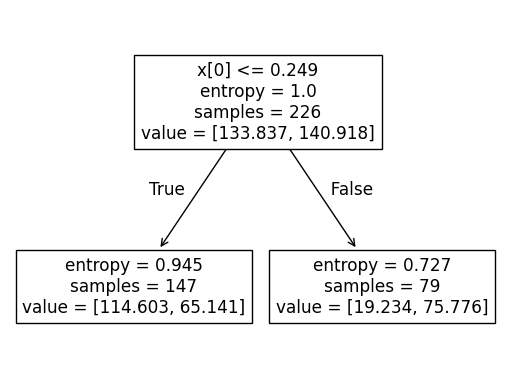

In [4]:
from tf_chpvk_pv.modeling.train import *
from pathlib import Path
from tf_chpvk_pv.config import DATA_DIR, RESULTS_DIR

df_acc_old_path = RESULTS_DIR / 'Ch_weights - tolerance factors accuracy for several operations.csv'

train_df, test_df, tolerance_factor_dict = evaluate_t_sisso('')

features_path = DATA_DIR / 'features_space/features/features/'


#df_acc_old = pd.read_csv(df_acc_old_path)
df_acc_old = pd.DataFrame()
#print(df_acc_old)

tfs = ['t', 'tau', 't_jess']
tf_tresh = [2, 1, 2]
df_acc =pd.DataFrame()
clfs = {}
t_sisso_expressions = {}

for tf, tresh in zip(tfs, tf_tresh):
    df_acc, clf_t = test_tolerance_factor_Ch(tf, train_df, test_df, tolerance_factor_dict, df_acc, n_tresh=tresh)
    clfs[tf] = clf_t

for feat in files:
    #check that the tree file doesn't exist
    idx = int(feat.split('/')[-1].split('.csv')[0].split('_')[-1])

    col = 't_sisso_' + str(idx)
    
    re_do = False

    if col in df_acc_old.columns:
        no_nan_values = df_acc_old[col].isna().sum()
        if no_nan_values == 0:
            print('Tree with operations idx = %s already exists' % str(idx))
            continue
        else:
            print('Tree with operations idx = %s has %s missing values' % (str(idx), no_nan_values))
            re_do = True
    else:
        re_do = True

    if re_do:
        try:
            tf = 't_sisso_' + str(idx)
            df = pd.read_csv(features_path / feat)
            t_sisso_expression = train_tree_sis_features_Ch(features_path / feat)
            train_df, test_df, tolerance_factor_dict = evaluate_t_sisso(t_sisso_expression, idx)
            df_acc, clf_t = test_tolerance_factor_Ch(tf, train_df, test_df, tolerance_factor_dict, df_acc, n_tresh=1)
            clfs[tf] = clf_t
        except Exception as e:
            print(e)
            print('Error in %s' % feat)
            break

In [5]:
from tf_chpvk_pv.config import RESULTS_DIR

df_acc_old_path = RESULTS_DIR / 'Ch_weights - tolerance factors accuracy for several operations.csv'

if df_acc_old_path.exists():

    df_acc_old = pd.read_csv(df_acc_old_path)
    df_acc_old.set_index('Unnamed: 0', inplace=True)
    df_acc_old.index.name = None

    for col in df_acc.columns:
        if col not in df_acc_old.columns:
            
            df_acc_old[col] = df_acc[col]
        else:
            no_nan_values = df_acc_old[col].isna().sum()
            if no_nan_values > 0:
                df_acc_old[col] = df_acc[col]

    for col in df_acc_old.columns:
        if 'Unnamed' in col:
            df_acc_old.drop(col, axis=1, inplace=True)
    
    df_acc_old.to_csv(df_acc_old_path)

else:
    df_acc.to_csv(df_acc_old_path)

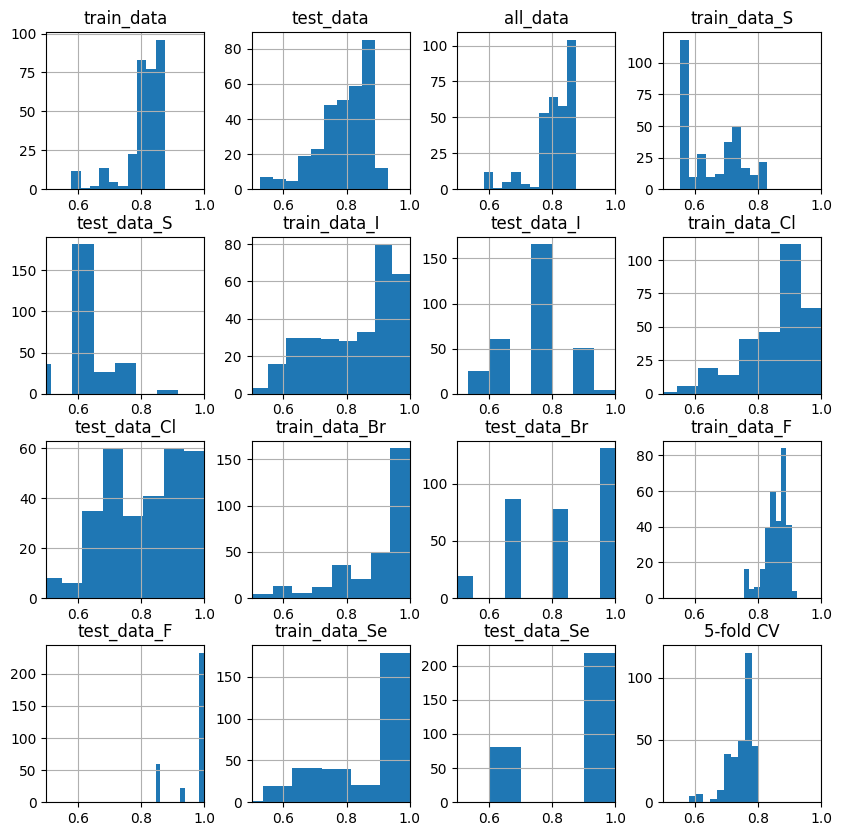

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from tf_chpvk_pv.config import RESULTS_DIR

df_acc_old_path = RESULTS_DIR / 'Ch_weights - tolerance factors accuracy for several operations.csv'

df = pd.read_csv(df_acc_old_path)
df.set_index('Unnamed: 0', inplace=True)


axs = df[[x for x in df.columns if 't_sisso' in x]].T.hist(figsize=(10, 10))
for ax in axs.flatten():
    ax.set_xlim(0.5, 1)
plt.show()

In [7]:
df[[x for x in df.columns if 't_sisso' in x]].max(axis=1)

Unnamed: 0
train_data       0.876106
test_data        0.929825
all_data         0.876325
train_data_S     0.829787
test_data_S      0.916667
train_data_I     1.000000
test_data_I      1.000000
train_data_Cl    1.000000
test_data_Cl     1.000000
train_data_Br    1.000000
test_data_Br     1.000000
train_data_F     0.924528
test_data_F      1.000000
train_data_Se    1.000000
test_data_Se     1.000000
5-fold CV        0.804220
dtype: float64

In [ ]:
df.T.sort_values('test_data', ascending=False).head(20)

Unnamed: 0   train_data  test_data  all_data  train_data_S  test_data_S  \
t_sisso_14     0.831858   0.929825  0.851590      0.765957     0.916667   
t_sisso_5      0.845133   0.894737  0.855124      0.744681     0.750000   
t_sisso_124    0.849558   0.894737  0.858657      0.574468     0.583333   
t_sisso_212    0.849558   0.894737  0.858657      0.574468     0.583333   
t_sisso_37     0.862832   0.894737  0.869258      0.574468     0.583333   
t_sisso_39     0.862832   0.894737  0.869258      0.574468     0.583333   
t_sisso_58     0.845133   0.894737  0.855124      0.744681     0.750000   
t_sisso_55     0.845133   0.894737  0.855124      0.744681     0.750000   
t_sisso_219    0.849558   0.894737  0.858657      0.574468     0.583333   
t_sisso_46     0.845133   0.894737  0.855124      0.744681     0.750000   
t_sisso_51     0.845133   0.894737  0.855124      0.744681     0.750000   
t_sisso_223    0.849558   0.894737  0.858657      0.574468     0.583333   
t_sisso_252    0.849558   0.877193  0.855124      0.574468     0.583333   
t_sisso_262    0.849558   0.877193  0.855124      0.574468     0.583333   
t_sisso_260    0.849558   0.877193  0.855124      0.574468     0.583333   
t_sisso_254    0.858407   0.877193  0.862191      0.574468     0.583333   
t_sisso_240    0.849558   0.877193  0.855124      0.574468     0.583333   
t_sisso_196    0.862832   0.877193  0.865724      0.574468     0.583333   
t_sisso_297    0.853982   0.877193  0.858657      0.574468     0.583333   
t_sisso_87     0.858407   0.877193  0.862191      0.574468     0.583333   

Unnamed: 0   train_data_I  test_data_I  train_data_Cl  test_data_Cl  \
t_sisso_14       0.705882     0.888889       0.912281      0.928571   
t_sisso_5        0.794118     0.888889       0.912281      0.857143   
t_sisso_124      0.941176     0.888889       0.894737      1.000000   
t_sisso_212      0.941176     0.888889       0.894737      1.000000   
t_sisso_37       0.941176     1.000000       0.929825      0.928571   
t_sisso_39       0.941176     1.000000       0.929825      0.928571   
t_sisso_58       0.794118     0.888889       0.912281      0.857143   
t_sisso_55       0.794118     0.888889       0.912281      0.857143   
t_sisso_219      0.941176     0.888889       0.894737      1.000000   
t_sisso_46       0.794118     0.888889       0.912281      0.857143   
t_sisso_51       0.794118     0.888889       0.912281      0.857143   
t_sisso_223      0.941176     0.888889       0.894737      1.000000   
t_sisso_252      0.941176     0.888889       0.894737      0.928571   
t_sisso_262      0.911765     0.888889       0.929825      0.928571   
t_sisso_260      0.911765     0.888889       0.929825      0.928571   
t_sisso_254      0.970588     0.777778       0.947368      1.000000   
t_sisso_240      0.941176     0.888889       0.894737      0.928571   
t_sisso_196      0.970588     0.777778       1.000000      1.000000   
t_sisso_297      0.941176     0.777778       0.982456      1.000000   
t_sisso_87       0.970588     0.777778       0.929825      1.000000   

Unnamed: 0   train_data_Br  test_data_Br  train_data_F  test_data_F  \
t_sisso_14        0.952381      0.833333      0.867925          1.0   
t_sisso_5         1.000000      1.000000      0.849057          1.0   
t_sisso_124       1.000000      1.000000      0.886792          1.0   
t_sisso_212       1.000000      1.000000      0.886792          1.0   
t_sisso_37        1.000000      1.000000      0.905660          1.0   
t_sisso_39        1.000000      1.000000      0.905660          1.0   
t_sisso_58        1.000000      1.000000      0.849057          1.0   
t_sisso_55        1.000000      1.000000      0.849057          1.0   
t_sisso_219       1.000000      1.000000      0.886792          1.0   
t_sisso_46        1.000000      1.000000      0.849057          1.0   
t_sisso_51        1.000000      1.000000      0.849057          1.0   
t_sisso_223       1.000000      1.000000      0.886792          1.0   
t_sisso_2

In [20]:
df.T.sort_values('test_data_S', ascending=False).head(5)

Unnamed: 0   train_data  test_data  all_data  train_data_S  test_data_S  \
t_sisso_23     0.690265   0.666667  0.685512      0.787234     0.916667   
t_sisso_177    0.809735   0.824561  0.812721      0.829787     0.916667   
t_sisso_14     0.831858   0.929825  0.851590      0.765957     0.916667   
t_sisso_33     0.787611   0.807018  0.791519      0.744681     0.916667   
t_sisso_10     0.787611   0.807018  0.791519      0.765957     0.916667   

Unnamed: 0   train_data_I  test_data_I  train_data_Cl  test_data_Cl  \
t_sisso_23       0.529412     0.444444       0.614035      0.428571   
t_sisso_177      0.676471     0.777778       0.842105      0.714286   
t_sisso_14       0.705882     0.888889       0.912281      0.928571   
t_sisso_33       0.676471     0.777778       0.842105      0.642857   
t_sisso_10       0.647059     0.444444       0.842105      0.785714   

Unnamed: 0   train_data_Br  test_data_Br  train_data_F  test_data_F  \
t_sisso_23        0.619048      0.500000      0.849057          1.0   
t_sisso_177       0.809524      0.666667      0.867925          1.0   
t_sisso_14        0.952381      0.833333      0.867925          1.0   
t_sisso_33        0.809524      0.500000      0.849057          1.0   
t_sisso_10        0.761905      0.833333      0.886792          1.0   

Unnamed: 0   train_data_Se  test_data_Se  5-fold CV  
t_sisso_23        0.571429      0.333333   0.659132  
t_sisso_177       0.714286      0.666667   0.717272  
t_sisso_14        0.714286      1.000000   0.761099  
t_sisso_33        0.714286      1.000000   0.730452  
t_sisso_10        0.642857      0.666667   0.737509

In [21]:
top_S_t_sisso = df.T.sort_values('test_data_S', ascending=False).head(5).index

In [22]:
df.T[df.T['test_data'] >= 0.89]

Unnamed: 0   train_data  test_data  all_data  train_data_S  test_data_S  \
t_sisso_5      0.845133   0.894737  0.855124      0.744681     0.750000   
t_sisso_219    0.849558   0.894737  0.858657      0.574468     0.583333   
t_sisso_55     0.845133   0.894737  0.855124      0.744681     0.750000   
t_sisso_14     0.831858   0.929825  0.851590      0.765957     0.916667   
t_sisso_37     0.862832   0.894737  0.869258      0.574468     0.583333   
t_sisso_124    0.849558   0.894737  0.858657      0.574468     0.583333   
t_sisso_58     0.845133   0.894737  0.855124      0.744681     0.750000   
t_sisso_39     0.862832   0.894737  0.869258      0.574468     0.583333   
t_sisso_212    0.849558   0.894737  0.858657      0.574468     0.583333   
t_sisso_223    0.849558   0.894737  0.858657      0.574468     0.583333   
t_sisso_51     0.845133   0.894737  0.855124      0.744681     0.750000   
t_sisso_46     0.845133   0.894737  0.855124      0.744681     0.750000   

Unnamed: 0   train_data_I  test_data_I  train_data_Cl  test_data_Cl  \
t_sisso_5        0.794118     0.888889       0.912281      0.857143   
t_sisso_219      0.941176     0.888889       0.894737      1.000000   
t_sisso_55       0.794118     0.888889       0.912281      0.857143   
t_sisso_14       0.705882     0.888889       0.912281      0.928571   
t_sisso_37       0.941176     1.000000       0.929825      0.928571   
t_sisso_124      0.941176     0.888889       0.894737      1.000000   
t_sisso_58       0.794118     0.888889       0.912281      0.857143   
t_sisso_39       0.941176     1.000000       0.929825      0.928571   
t_sisso_212      0.941176     0.888889       0.894737      1.000000   
t_sisso_223      0.941176     0.888889       0.894737      1.000000   
t_sisso_51       0.794118     0.888889       0.912281      0.857143   
t_sisso_46       0.794118     0.888889       0.912281      0.857143   

Unnamed: 0   train_data_Br  test_data_Br  train_data_F  test_data_F  \
t_sisso_5         1.000000      1.000000      0.849057          1.0   
t_sisso_219       1.000000      1.000000      0.886792          1.0   
t_sisso_55        1.000000      1.000000      0.849057          1.0   
t_sisso_14        0.952381      0.833333      0.867925          1.0   
t_sisso_37        1.000000      1.000000      0.905660          1.0   
t_sisso_124       1.000000      1.000000      0.886792          1.0   
t_sisso_58        1.000000      1.000000      0.849057          1.0   
t_sisso_39        1.000000      1.000000      0.905660          1.0   
t_sisso_212       1.000000      1.000000      0.886792          1.0   
t_sisso_223       1.000000      1.000000      0.886792          1.0   
t_sisso_51        1.000000      1.000000      0.849057          1.0   
t_sisso_46        1.000000      1.000000      0.849057          1.0   

Unnamed: 0   train_data_Se  test_data_Se  5-fold CV  
t_sisso_5         0.785714           1.0   0.765626  
t_sisso_219       1.000000           1.0   0.777988  
t_sisso_55        0.785714           1.0   0.765626  
t_sisso_14        0.714286           1.0   0.761099  
t_sisso_37        1.000000           1.0   0.782914  
t_sisso_124       1.000000           1.0   0.777988  
t_sisso_58        0.785714           1.0   0.765626  
t_sisso_39        1.000000           1.0   0.782914  
t_sisso_212       1.000000           1.0   0.777988  
t_sisso_223       1.000000           1.0   0.777988  
t_sisso_51        0.785714           1.0   0.765626  
t_sisso_46        0.785714           1.0   0.765626

In [11]:
top_t_sisso = df.T[df.T['test_data'] >= 0.89].index.values

{}
Classification tree f1 (for t) on the train set: 0.637168.
Classification tree f1 (for t) on the train set (5 fold CV): 0.595418.
Classification tree f1 (for t) on the test set: 0.596491.
0.830243 < t < 0.868341 indicates stable perovskites.
2025-03-27 14:31:32.739 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|((rA_rX_ratio**3) - (|rB_rX_ratio - log_rA_rB_ratio|)) - ((|rA_rX_ratio - log_rA_rB_ratio|) + (rB_rX_ratio + log_rA_rB_ratio))|)
Classification tree f1 (for t_sisso_5) on the train set: 0.845133.
Classification tree f1 (for t_sisso_5) on the train set (5 fold CV): 0.765626.
Classification tree f1 (for t_sisso_5) on the test set: 0.894737.
t_sisso_5 < 0.845501 indicates stable perovskites.
2025-03-27 14:32:07.980 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_

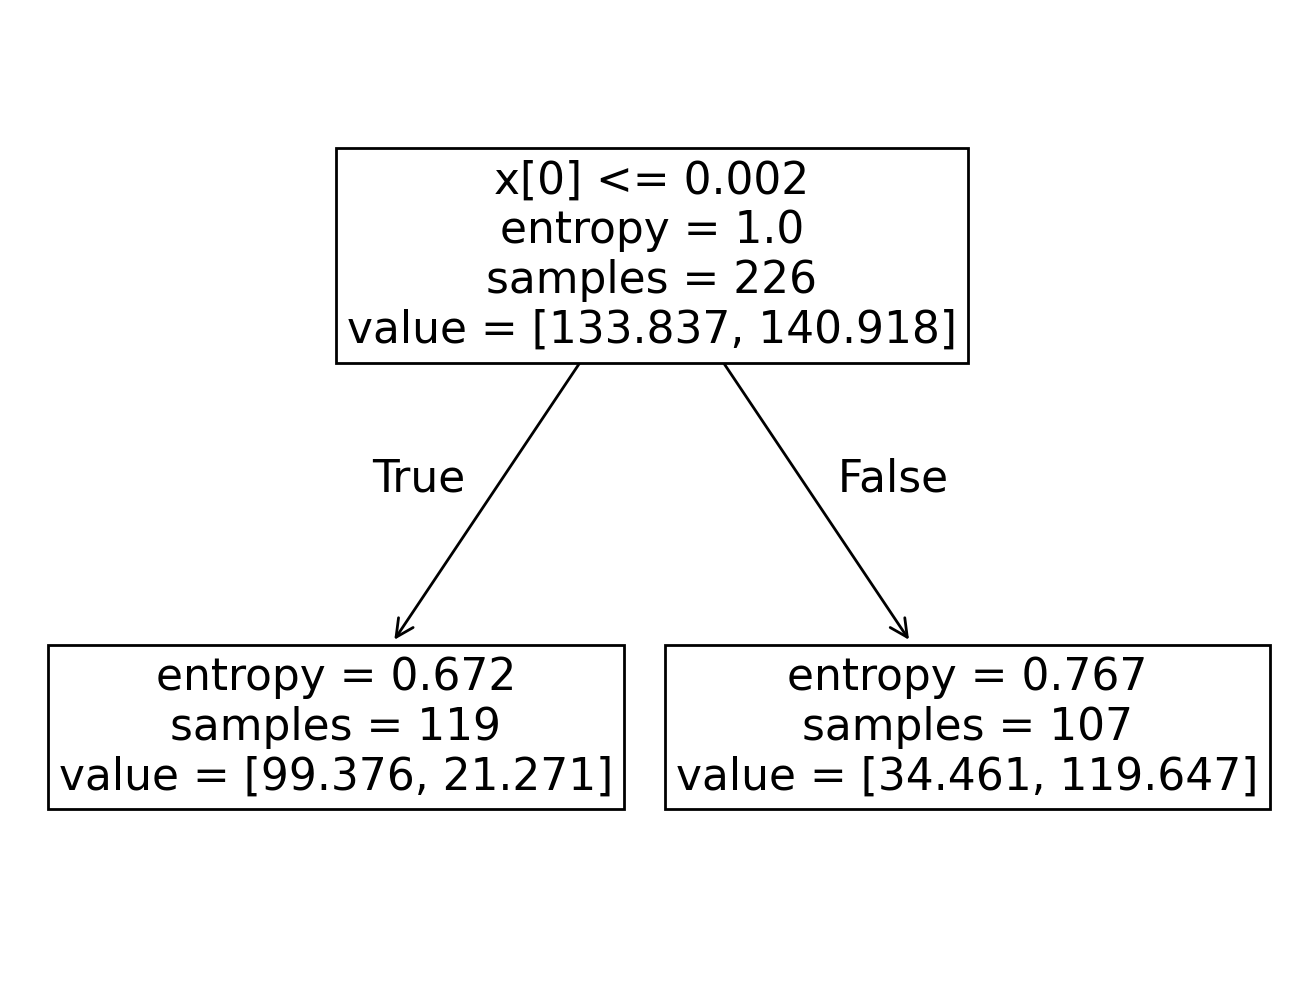

In [37]:
from tf_chpvk_pv.config import DATA_DIR, INTERIM_DATA_DIR
from tf_chpvk_pv.modeling.train import test_tolerance_factor, evaluate_t_sisso, train_tree_sis_features
import pickle

features_path = DATA_DIR / 'features_space/features/features/'

tfs = ['t', 'tau', 't_jess'] + top_t_sisso.tolist() + top_S_t_sisso.tolist()
tf_tresh = [2, 1, 2] + [1]*( top_t_sisso.shape[0] + top_S_t_sisso.shape[0])
df_acc =pd.DataFrame()
clfs = {}

tolerance_factor_path = INTERIM_DATA_DIR / 'ch_tolerance_factors_ops.pkl'

if tolerance_factor_path.exists():
    with open(tolerance_factor_path, 'rb') as file:
        tolerance_factor_dict_global = pickle.load(file)
else:
    tolerance_factor_dict_global = {}

print(tolerance_factor_dict_global)

train_df_global = train_df.copy()
test_df_global = test_df.copy()

train_df, test_df, tolerance_factor_dict = evaluate_t_sisso('')

for tf, tresh in zip(tfs, tf_tresh):
    if tf not in tolerance_factor_dict_global.keys():
        if 'sisso' in tf:
            idx = int(tf.split('_')[-1])
            t_sisso_expression = train_tree_sis_features_Ch(features_path / ('features_sisso_' + str(idx) + '.csv'))
            train_df, test_df, tolerance_factor_dict = evaluate_t_sisso(t_sisso_expression, idx)
        df_acc, clf_t = test_tolerance_factor_Ch(tf, train_df, test_df, tolerance_factor_dict, df_acc, n_tresh=tresh)
        for key in tolerance_factor_dict.keys():
            if key not in tolerance_factor_dict_global.keys():
                tolerance_factor_dict_global[key] = tolerance_factor_dict[key]
        for col in train_df.columns:
            if col not in train_df_global.columns:
                train_df_global[col] = train_df[col]
            if col not in test_df_global.columns:
                test_df_global[col] = test_df[col]
        clfs[tf] = clf_t


with open(tolerance_factor_path, 'wb') as file:
    pickle.dump(tolerance_factor_dict_global, file)

train_df = train_df_global
test_df = test_df_global

In [38]:
for t in tolerance_factor_dict_global.keys():
    try:
        th = tolerance_factor_dict_global[t][1]
        exp = tolerance_factor_dict_global[t][0]
        print(t, exp, th)
    except:
        continue

t (rA+rX)/(1.41421*(rB+rX)) [0.8302426636219025, 0.868341326713562]
tau rX/rB-nA*(nA-rA_rB_ratio/log(rA_rB_ratio)) 4.18
t_sisso_5 abs(((rA_rX_ratio**3) - abs(rB_rX_ratio - log_rA_rB_ratio)) - (abs(rA_rX_ratio - log_rA_rB_ratio) + (rB_rX_ratio + log_rA_rB_ratio))) 0.8455010652542114
t_sisso_219 abs(abs((rA_rX_ratio * log_rA_rB_ratio) - (log_rA_rB_ratio**3)) - ((rB_rX_ratio**3) * (rB_rX_ratio * log_rA_rB_ratio))) 0.24793849140405655
t_sisso_55 abs(((rA_rX_ratio + rB_rX_ratio) + abs(rB_rX_ratio - log_rA_rB_ratio)) - (rA_rX_ratio**3)) 0.8455010652542114
t_sisso_14 (((rA_rX_ratio * chi_BX_ratio) - (chi_BX_ratio + log_rA_rB_ratio)) + ((rA_rX_ratio - log_rA_rB_ratio) * log(log_rA_rB_ratio))) -0.8506085574626923
t_sisso_124 abs(abs((rA_rX_ratio * log_rA_rB_ratio) - (log_rA_rB_ratio**3)) - ((rB_rX_ratio**3) * (rB_rX_ratio * log_rA_rB_ratio))) 0.24793849140405655
t_sisso_39 (((rA_rX_ratio * rB_rX_ratio) * abs(rA_rX_ratio - chi_BX_ratio)) + abs(abs(rB_rX_ratio - log_rA_rB_ratio) - (rB_rX_ratio + 

2025-03-27 14:37:23.516 | INFO     | tf_chpvk_pv.modeling.train:train_platt_scaling:49 - Training Platt scaling model...
2025-03-27 14:37:23.548 | SUCCESS  | tf_chpvk_pv.modeling.train:train_platt_scaling:65 - Platt scaling model training complete.
2025-03-27 14:37:23.571 | INFO     | tf_chpvk_pv.plots:platt_scaling_plot:51 - Generating Platt Scaling plot from data...
2025-03-27 14:37:23.907 | SUCCESS  | tf_chpvk_pv.plots:platt_scaling_plot:63 - Plot generation complete.
2025-03-27 14:37:23.908 | INFO     | tf_chpvk_pv.modeling.train:train_platt_scaling:49 - Training Platt scaling model...
2025-03-27 14:37:23.934 | SUCCESS  | tf_chpvk_pv.modeling.train:train_platt_scaling:65 - Platt scaling model training complete.
2025-03-27 14:37:23.956 | INFO     | tf_chpvk_pv.plots:platt_scaling_plot:51 - Generating Platt Scaling plot from data...
2025-03-27 14:37:24.234 | SUCCESS  | tf_chpvk_pv.plots:platt_scaling_plot:63 - Plot generation complete.
2025-03-27 14:37:24.234 | INFO     | tf_chpvk_pv

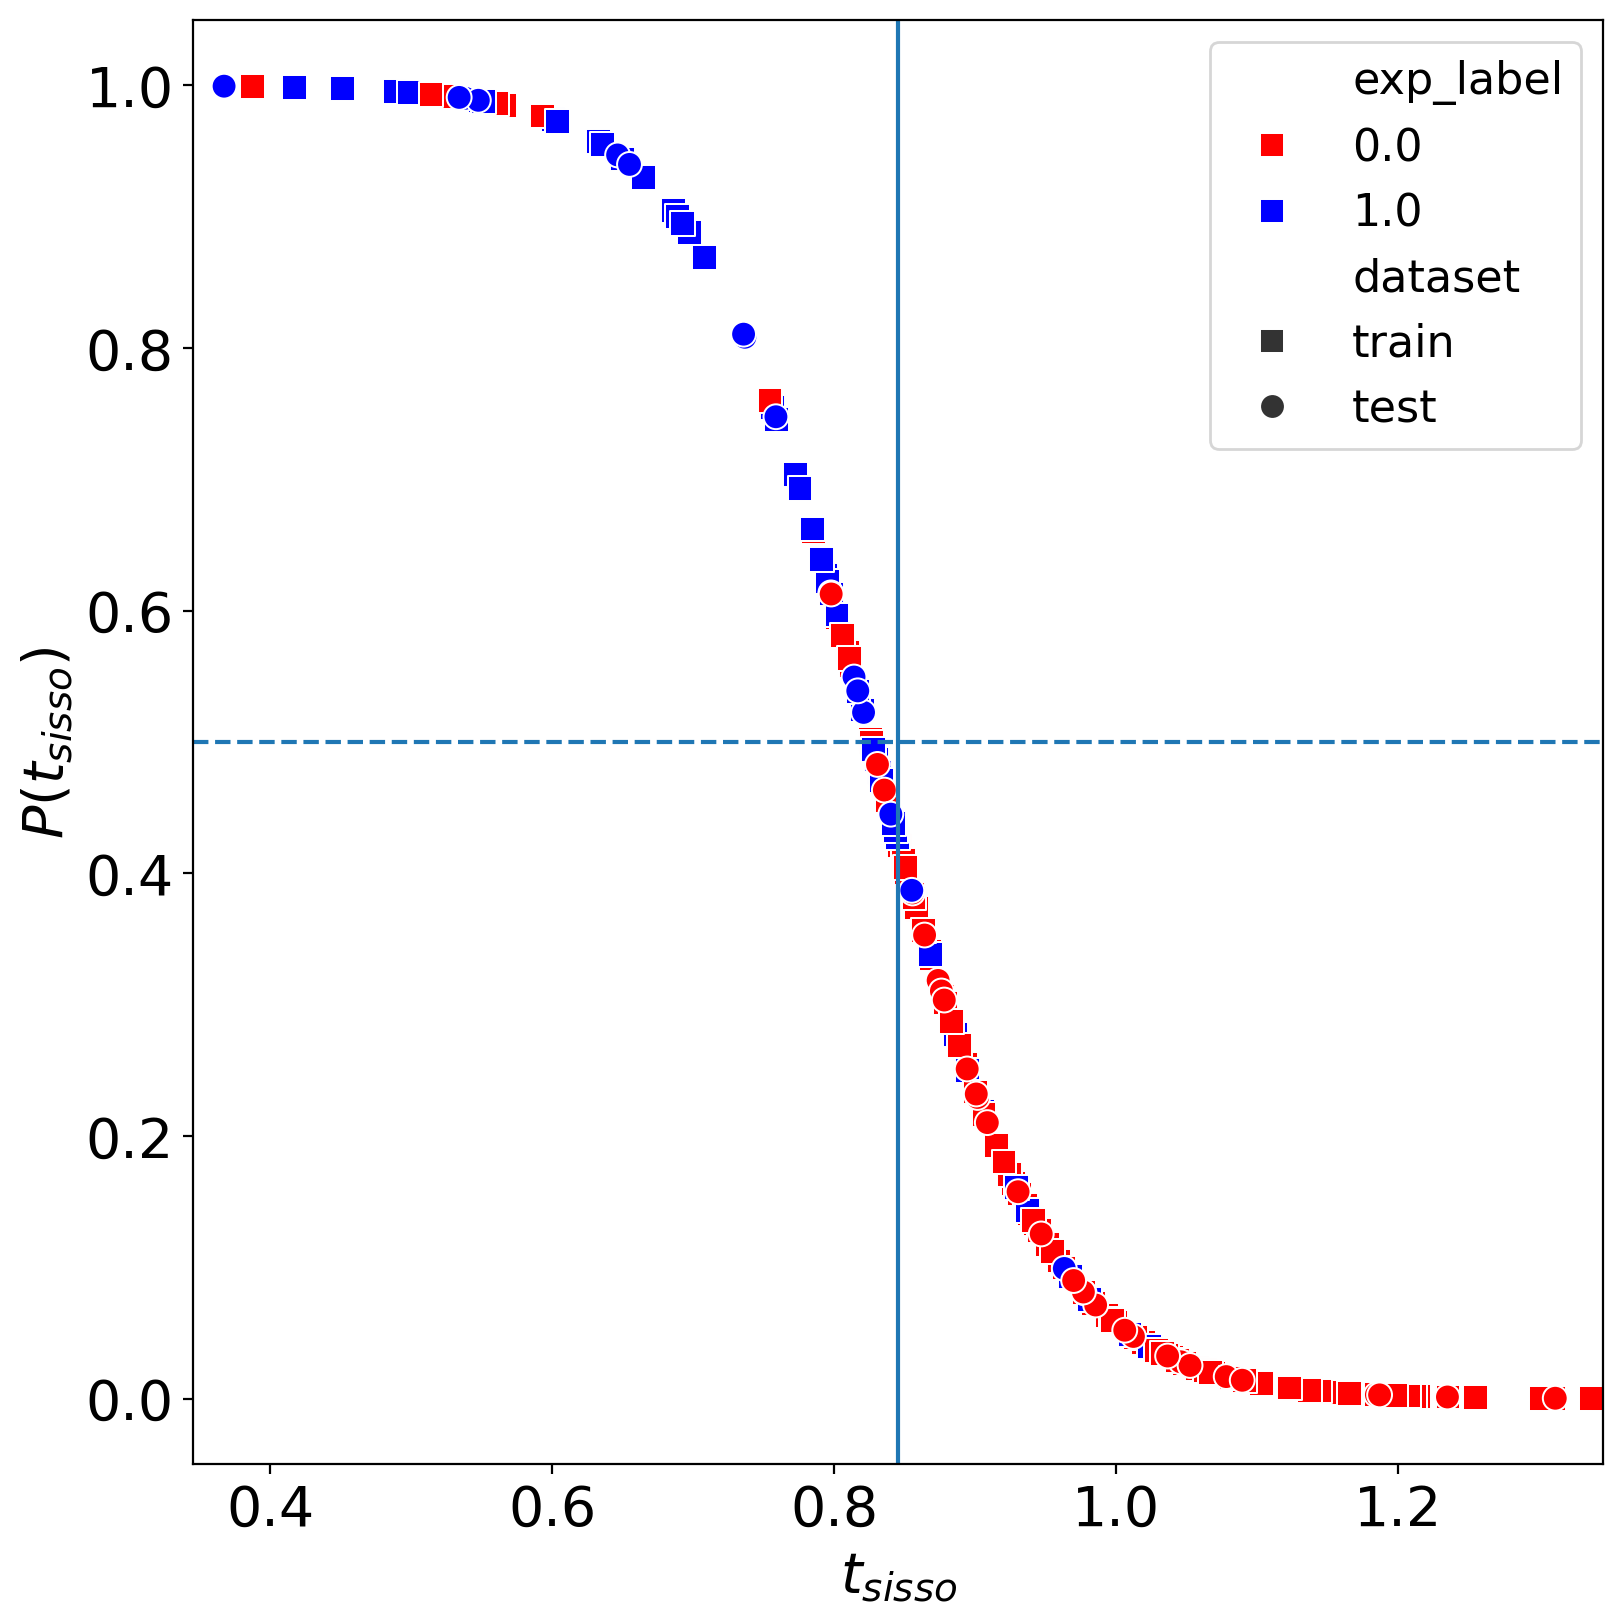

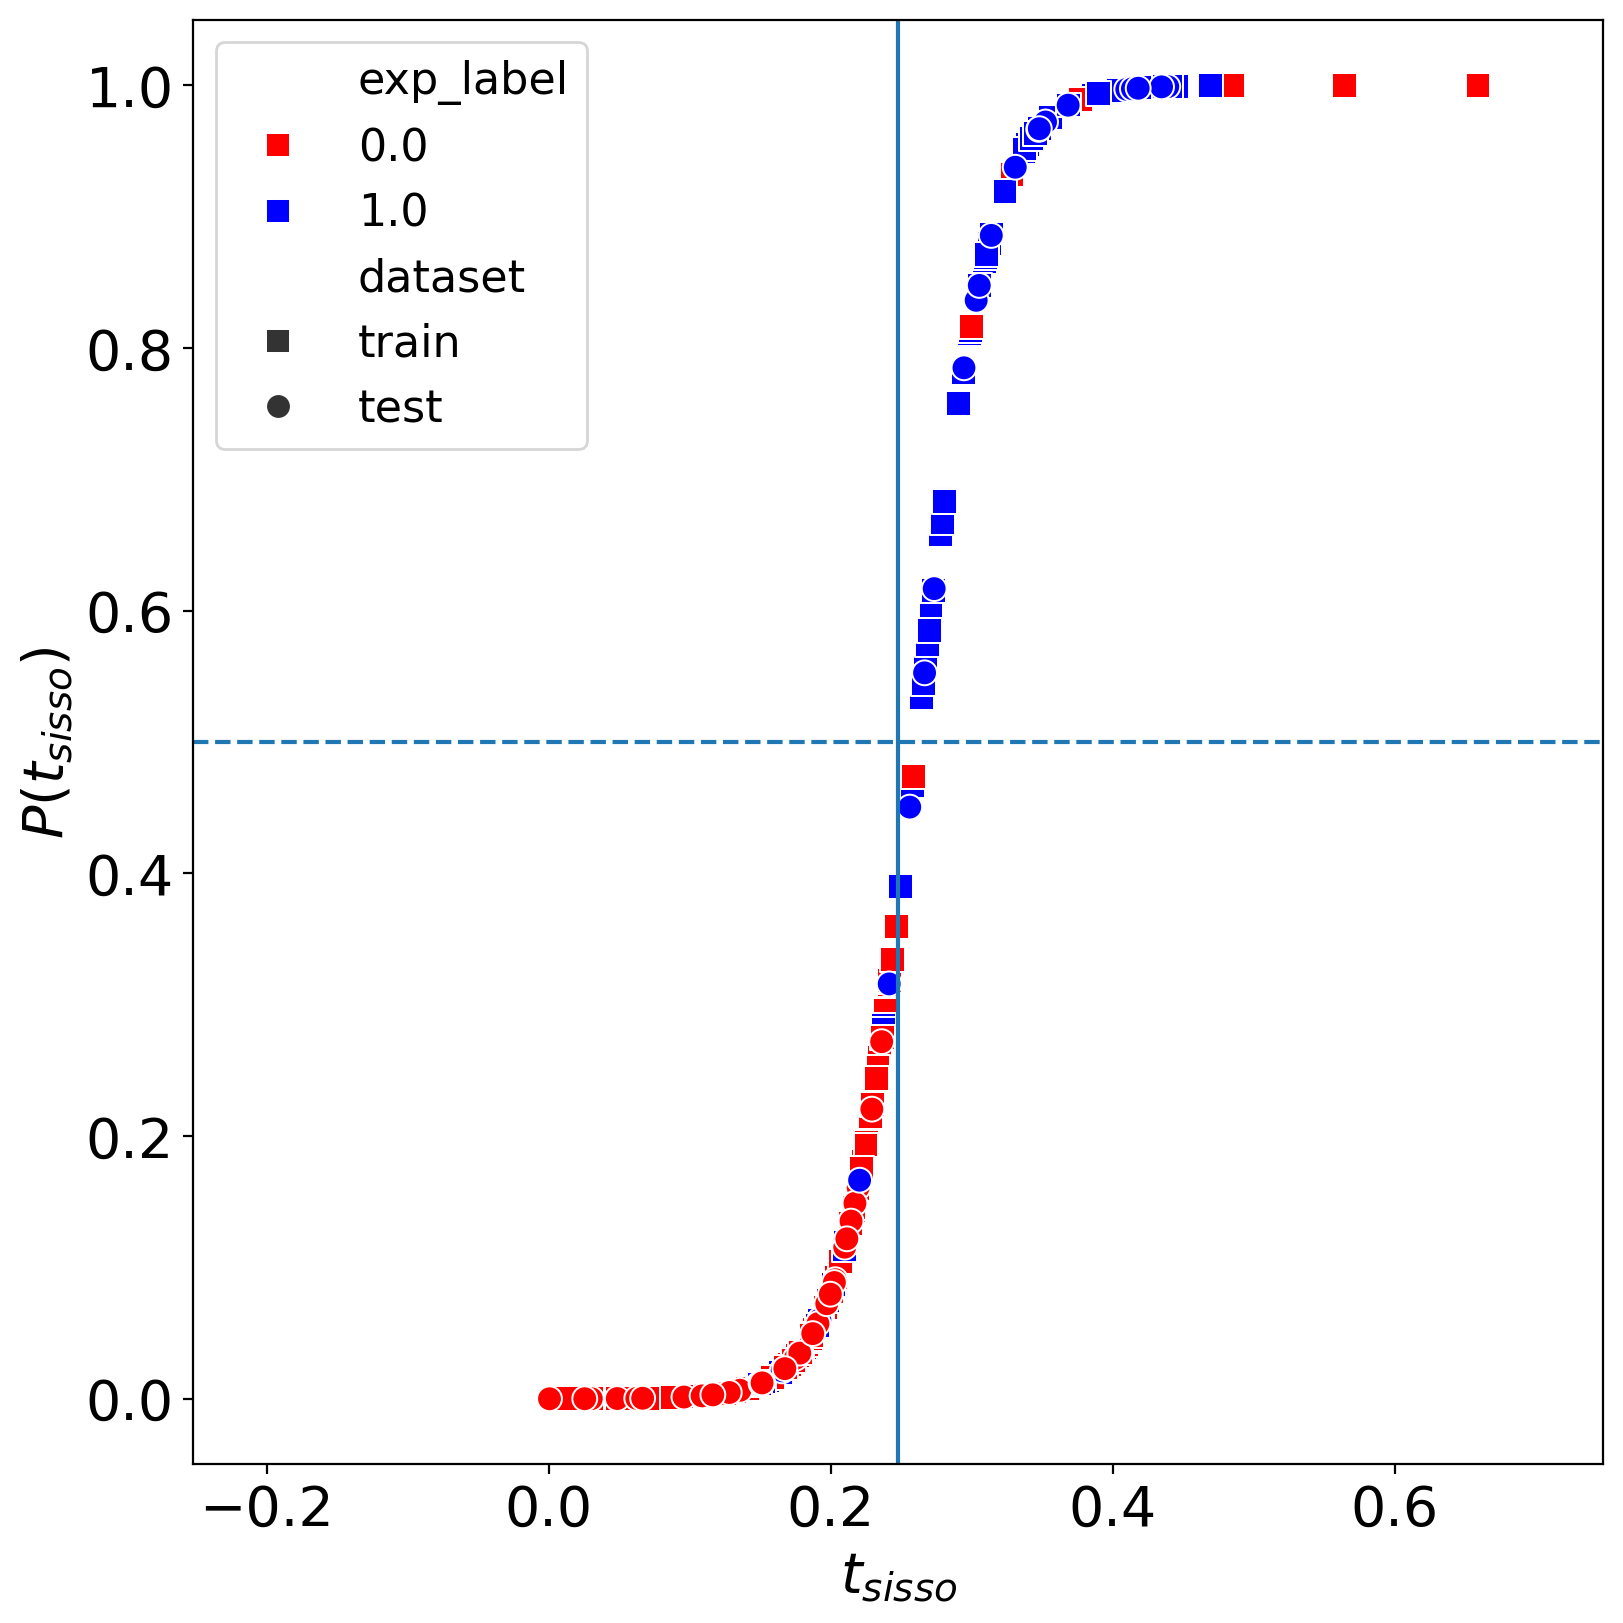

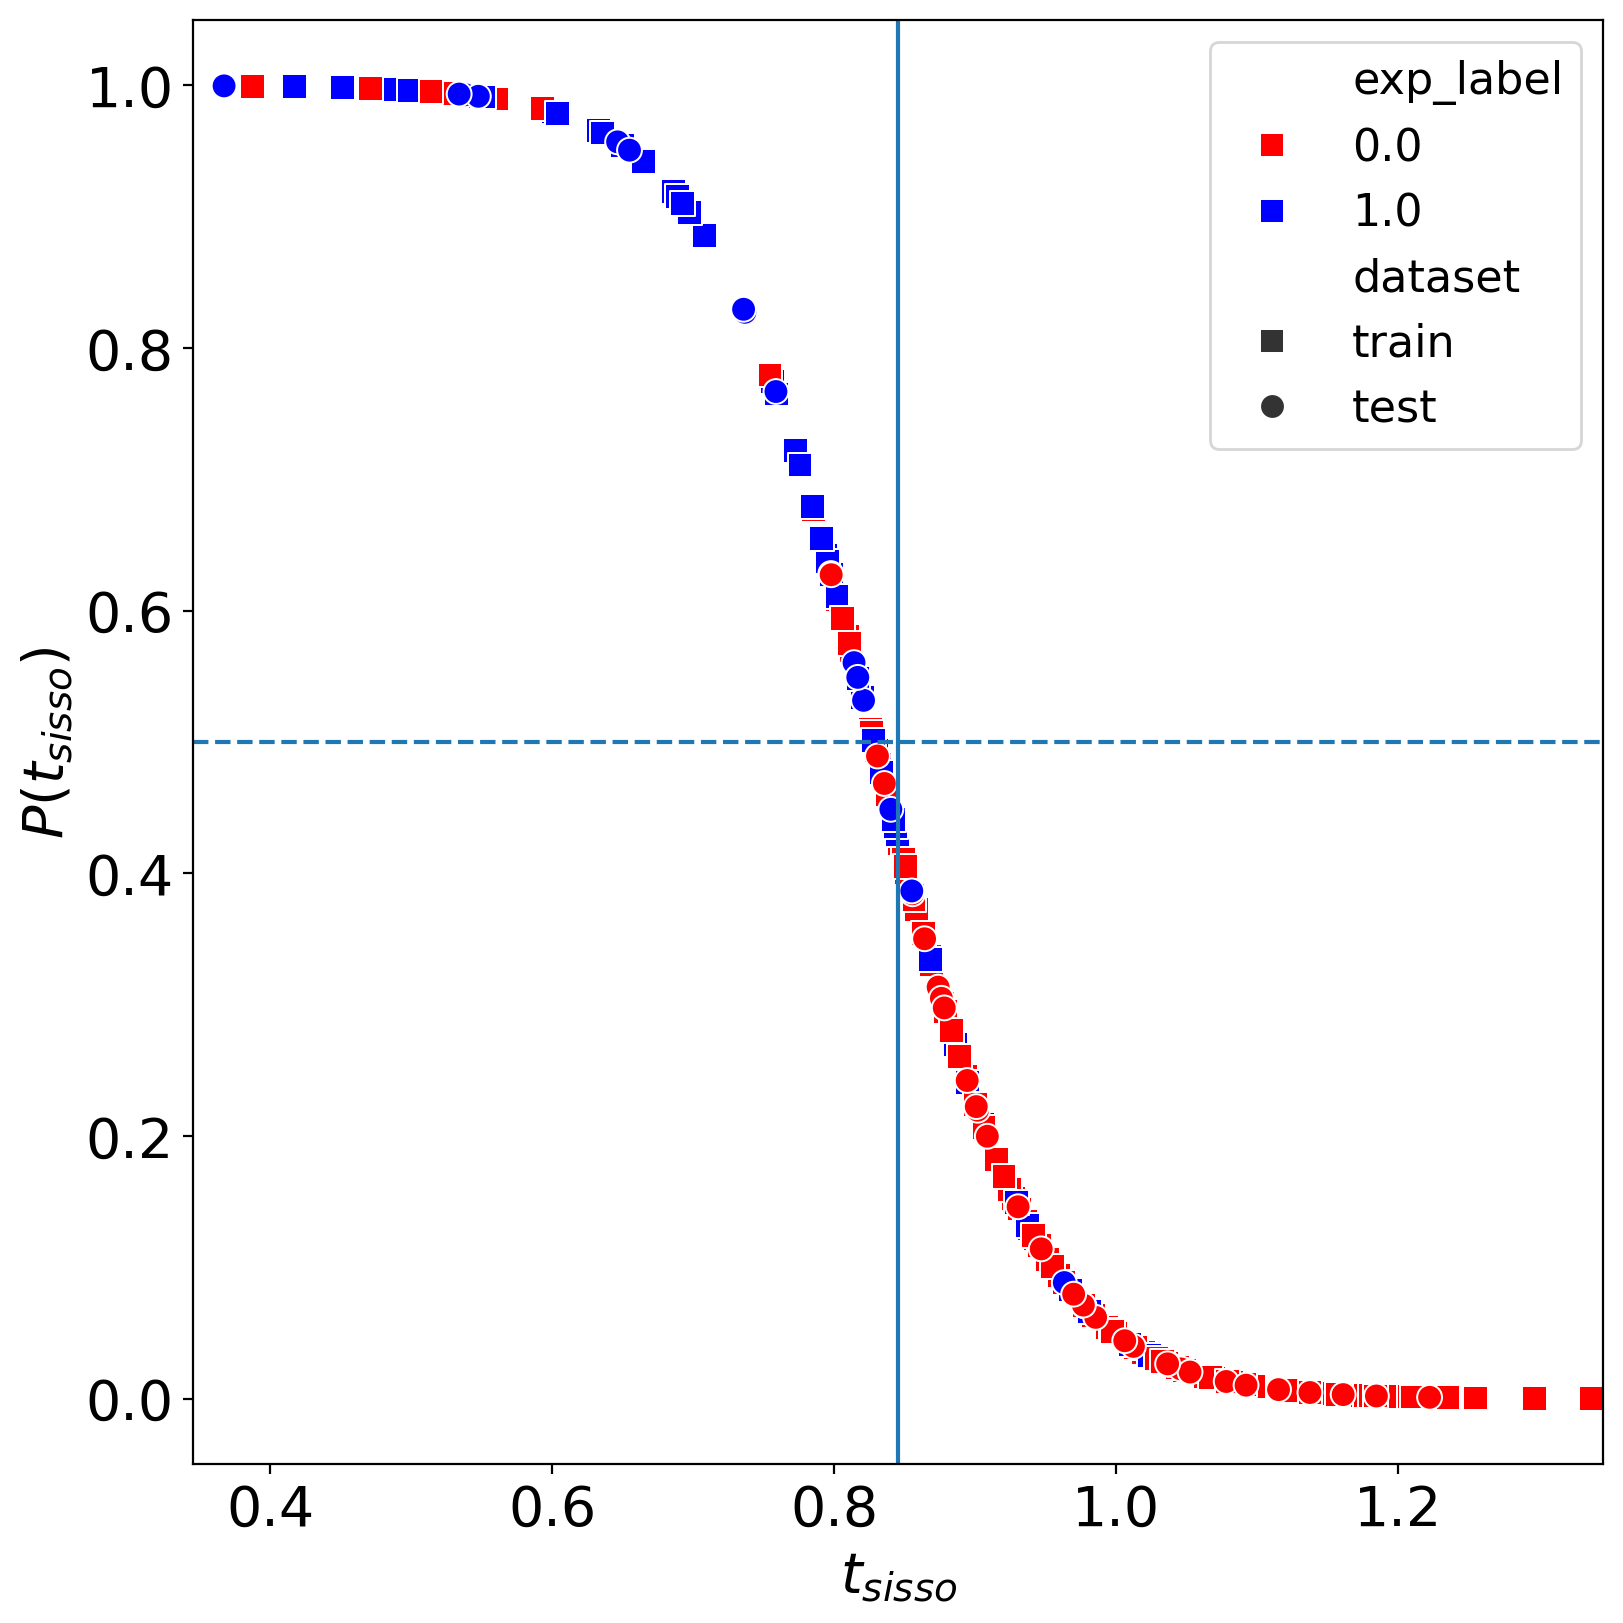

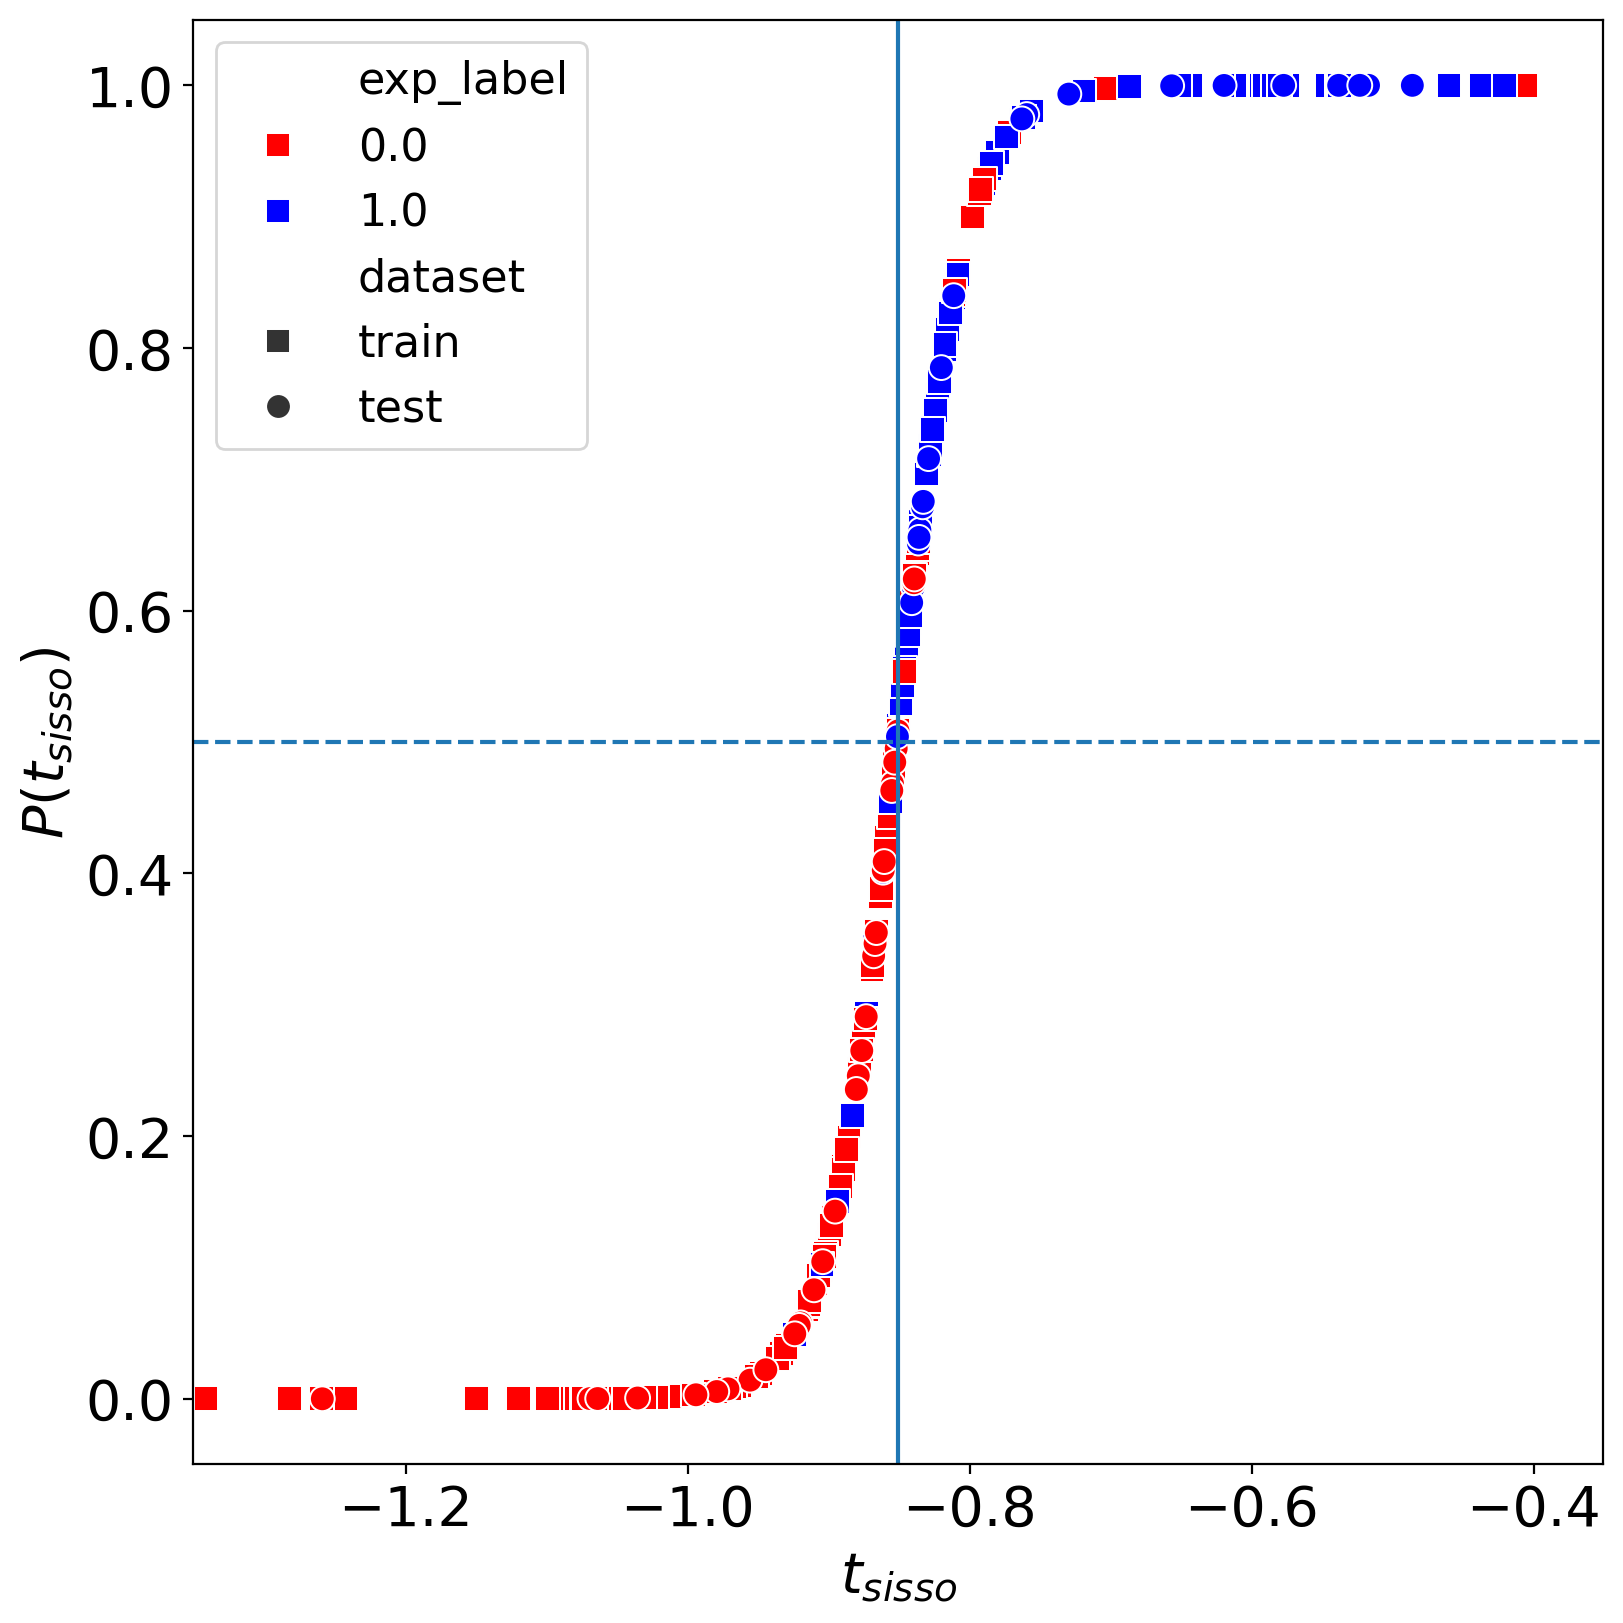

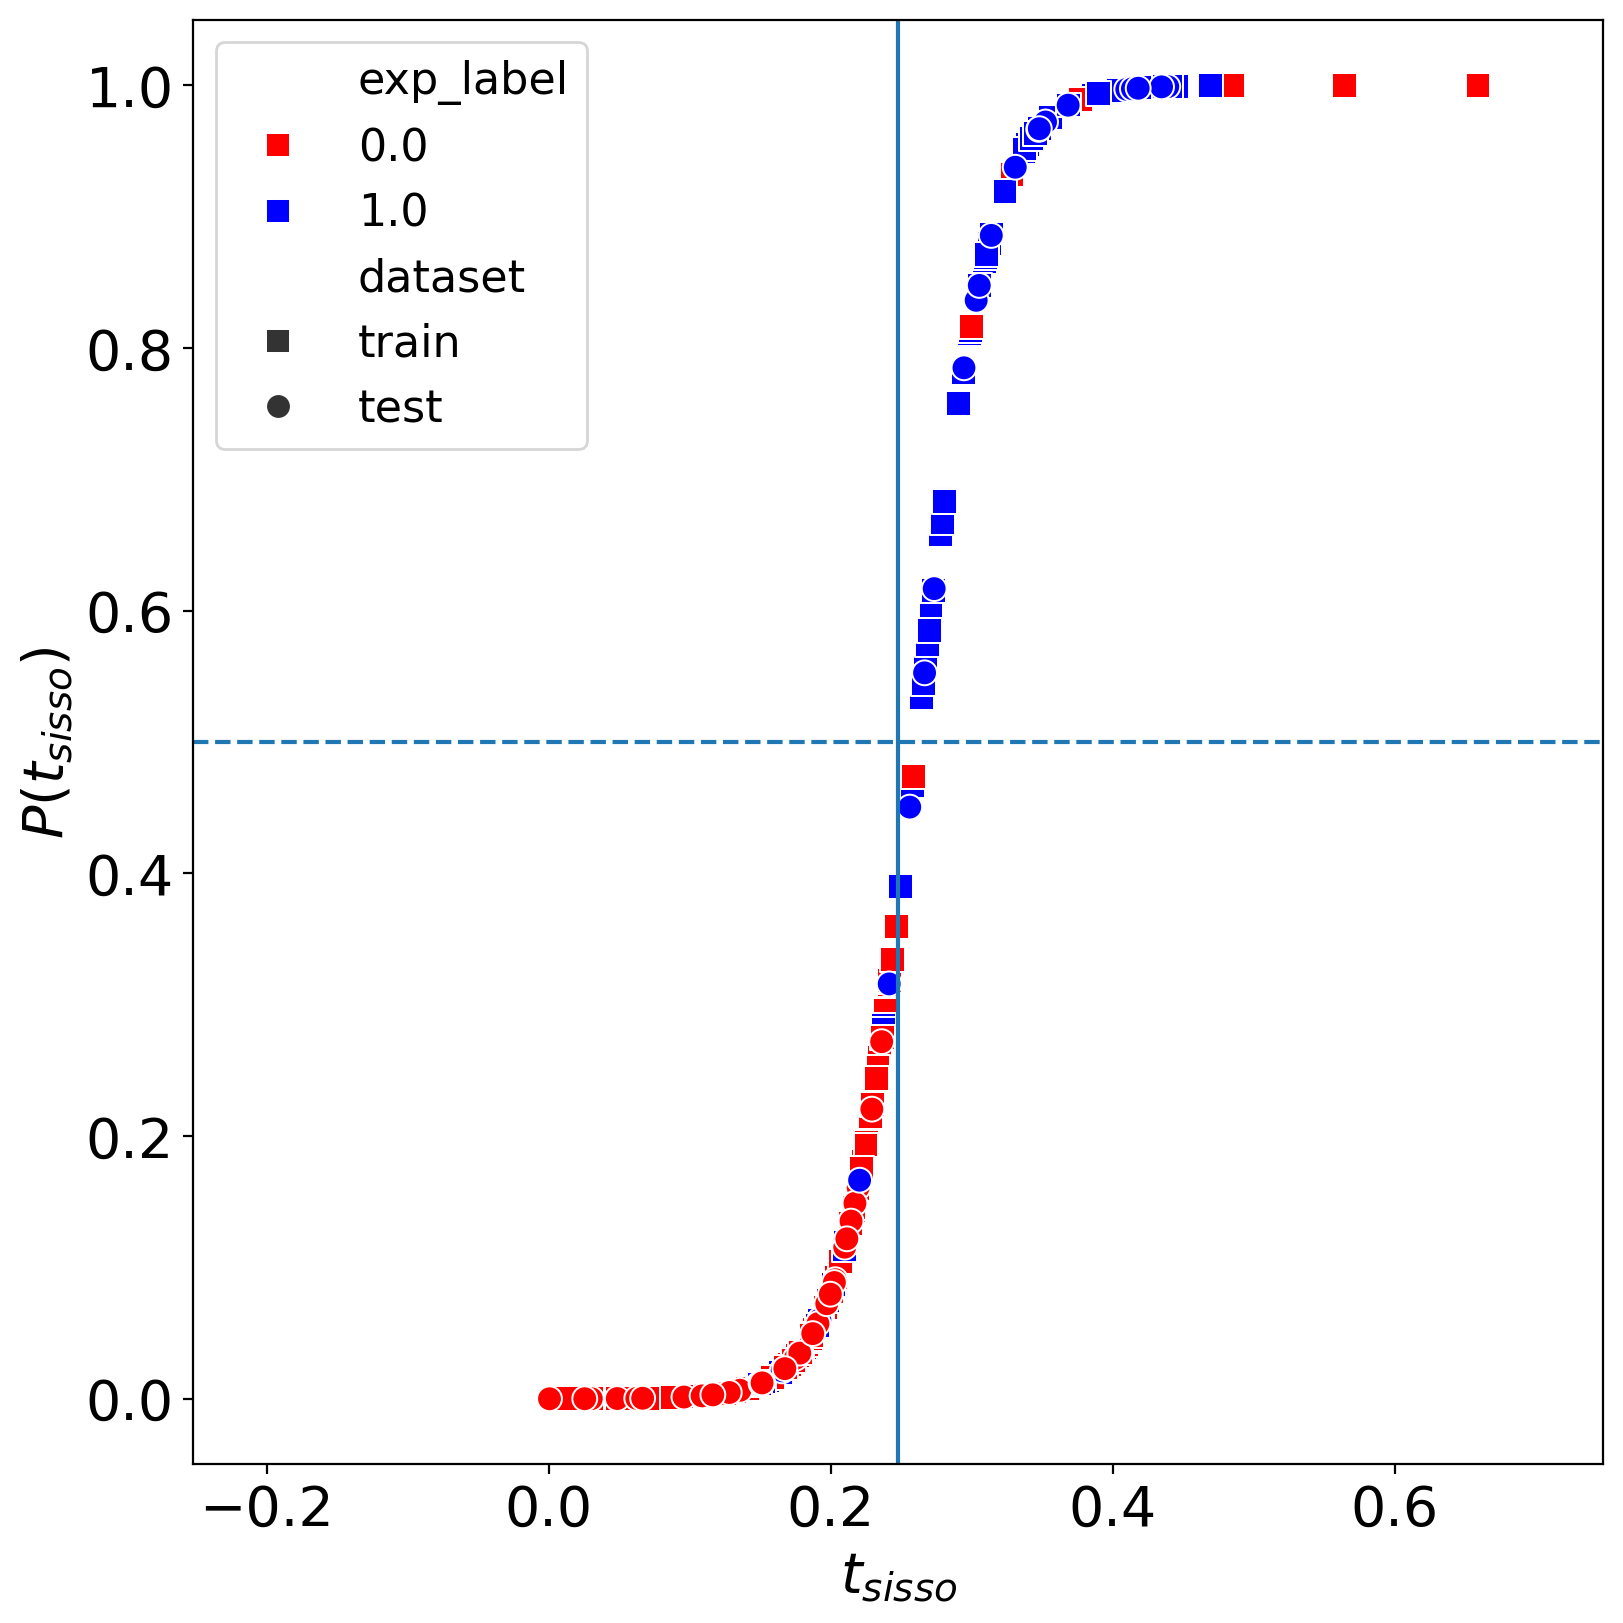

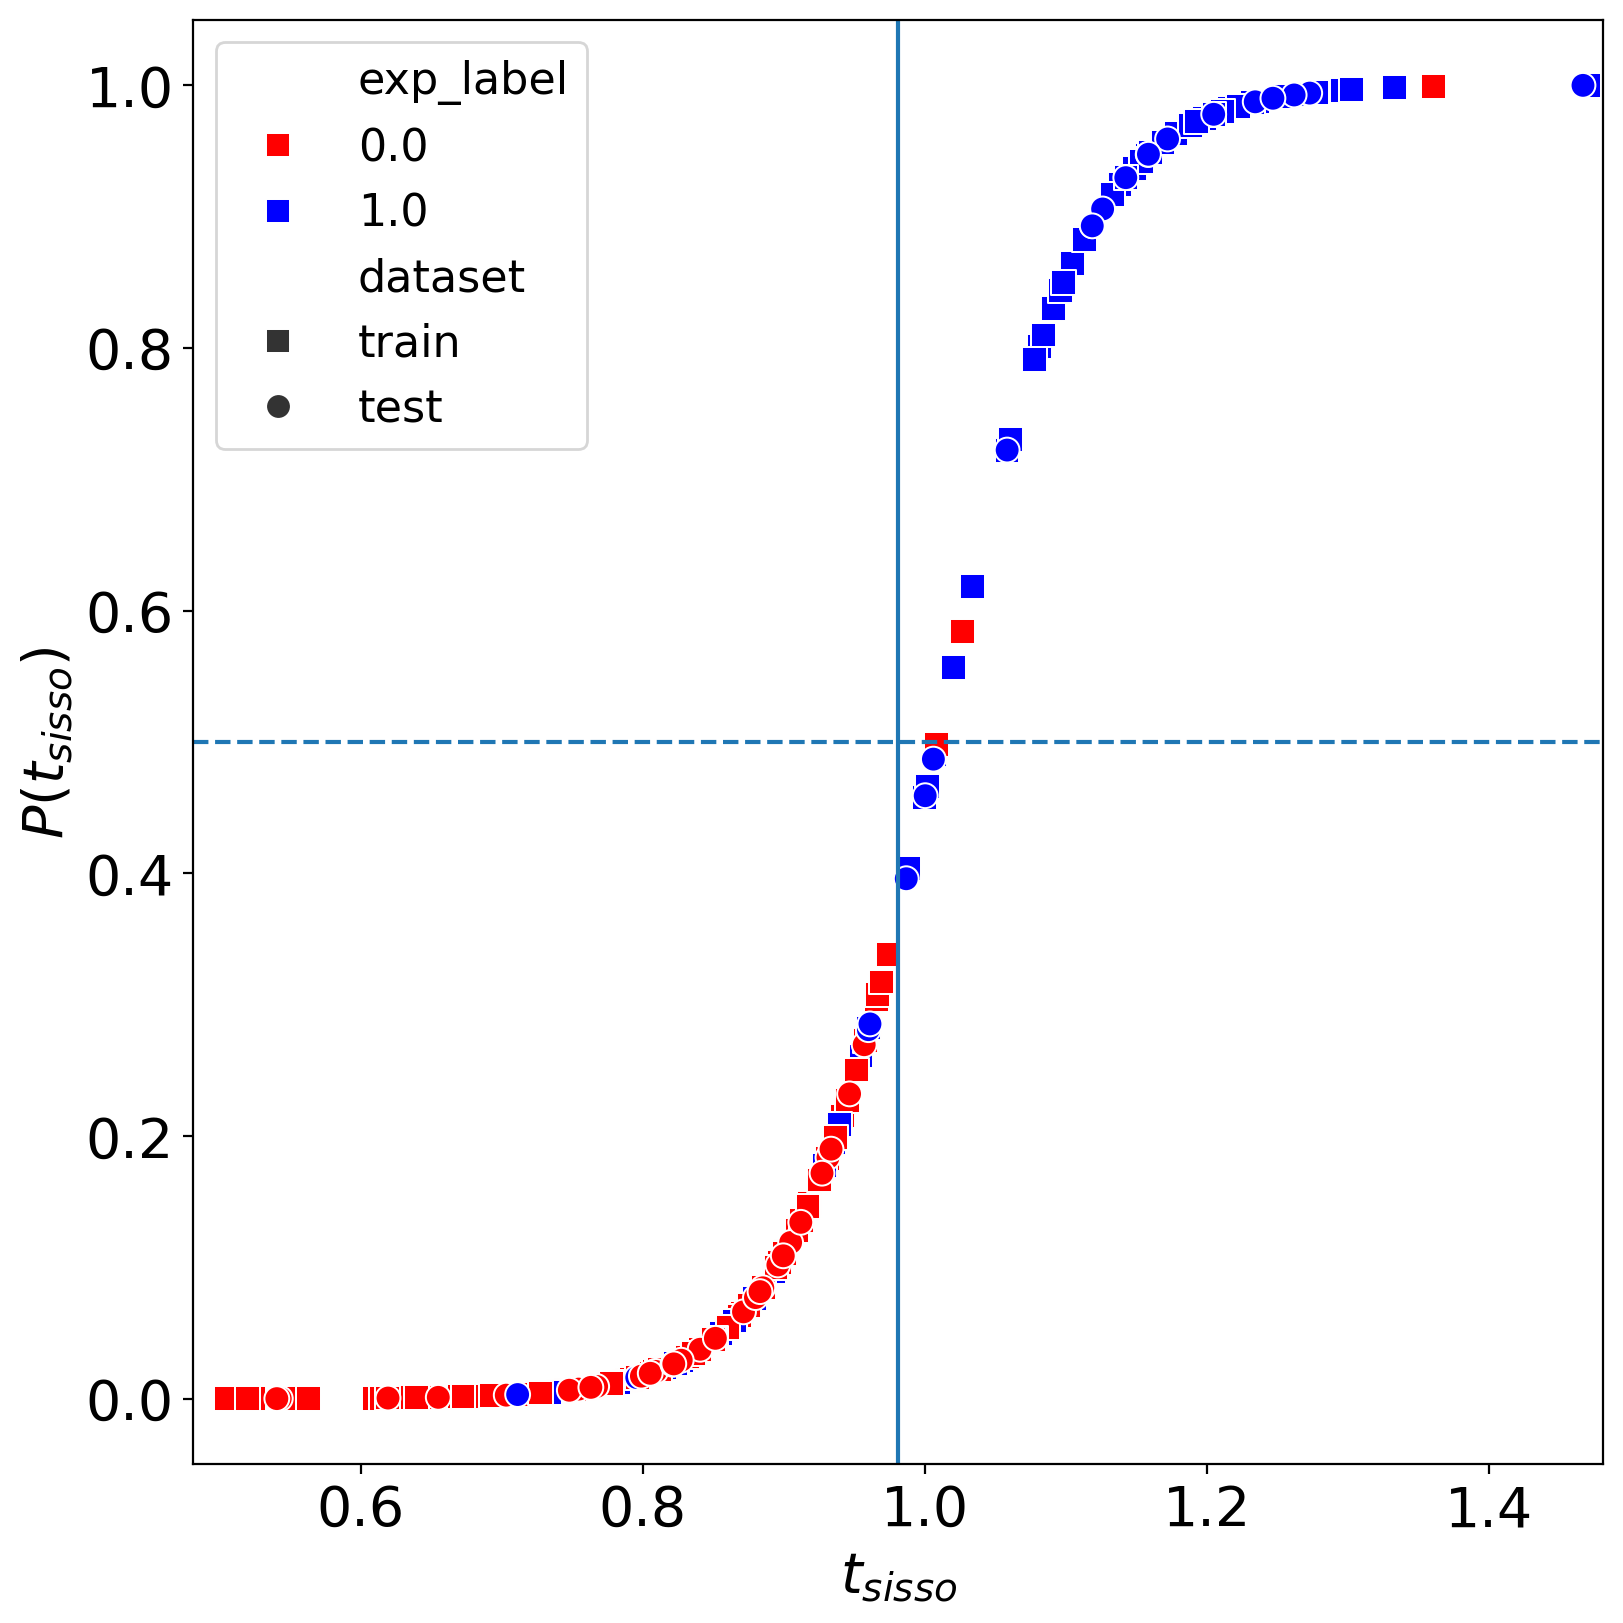

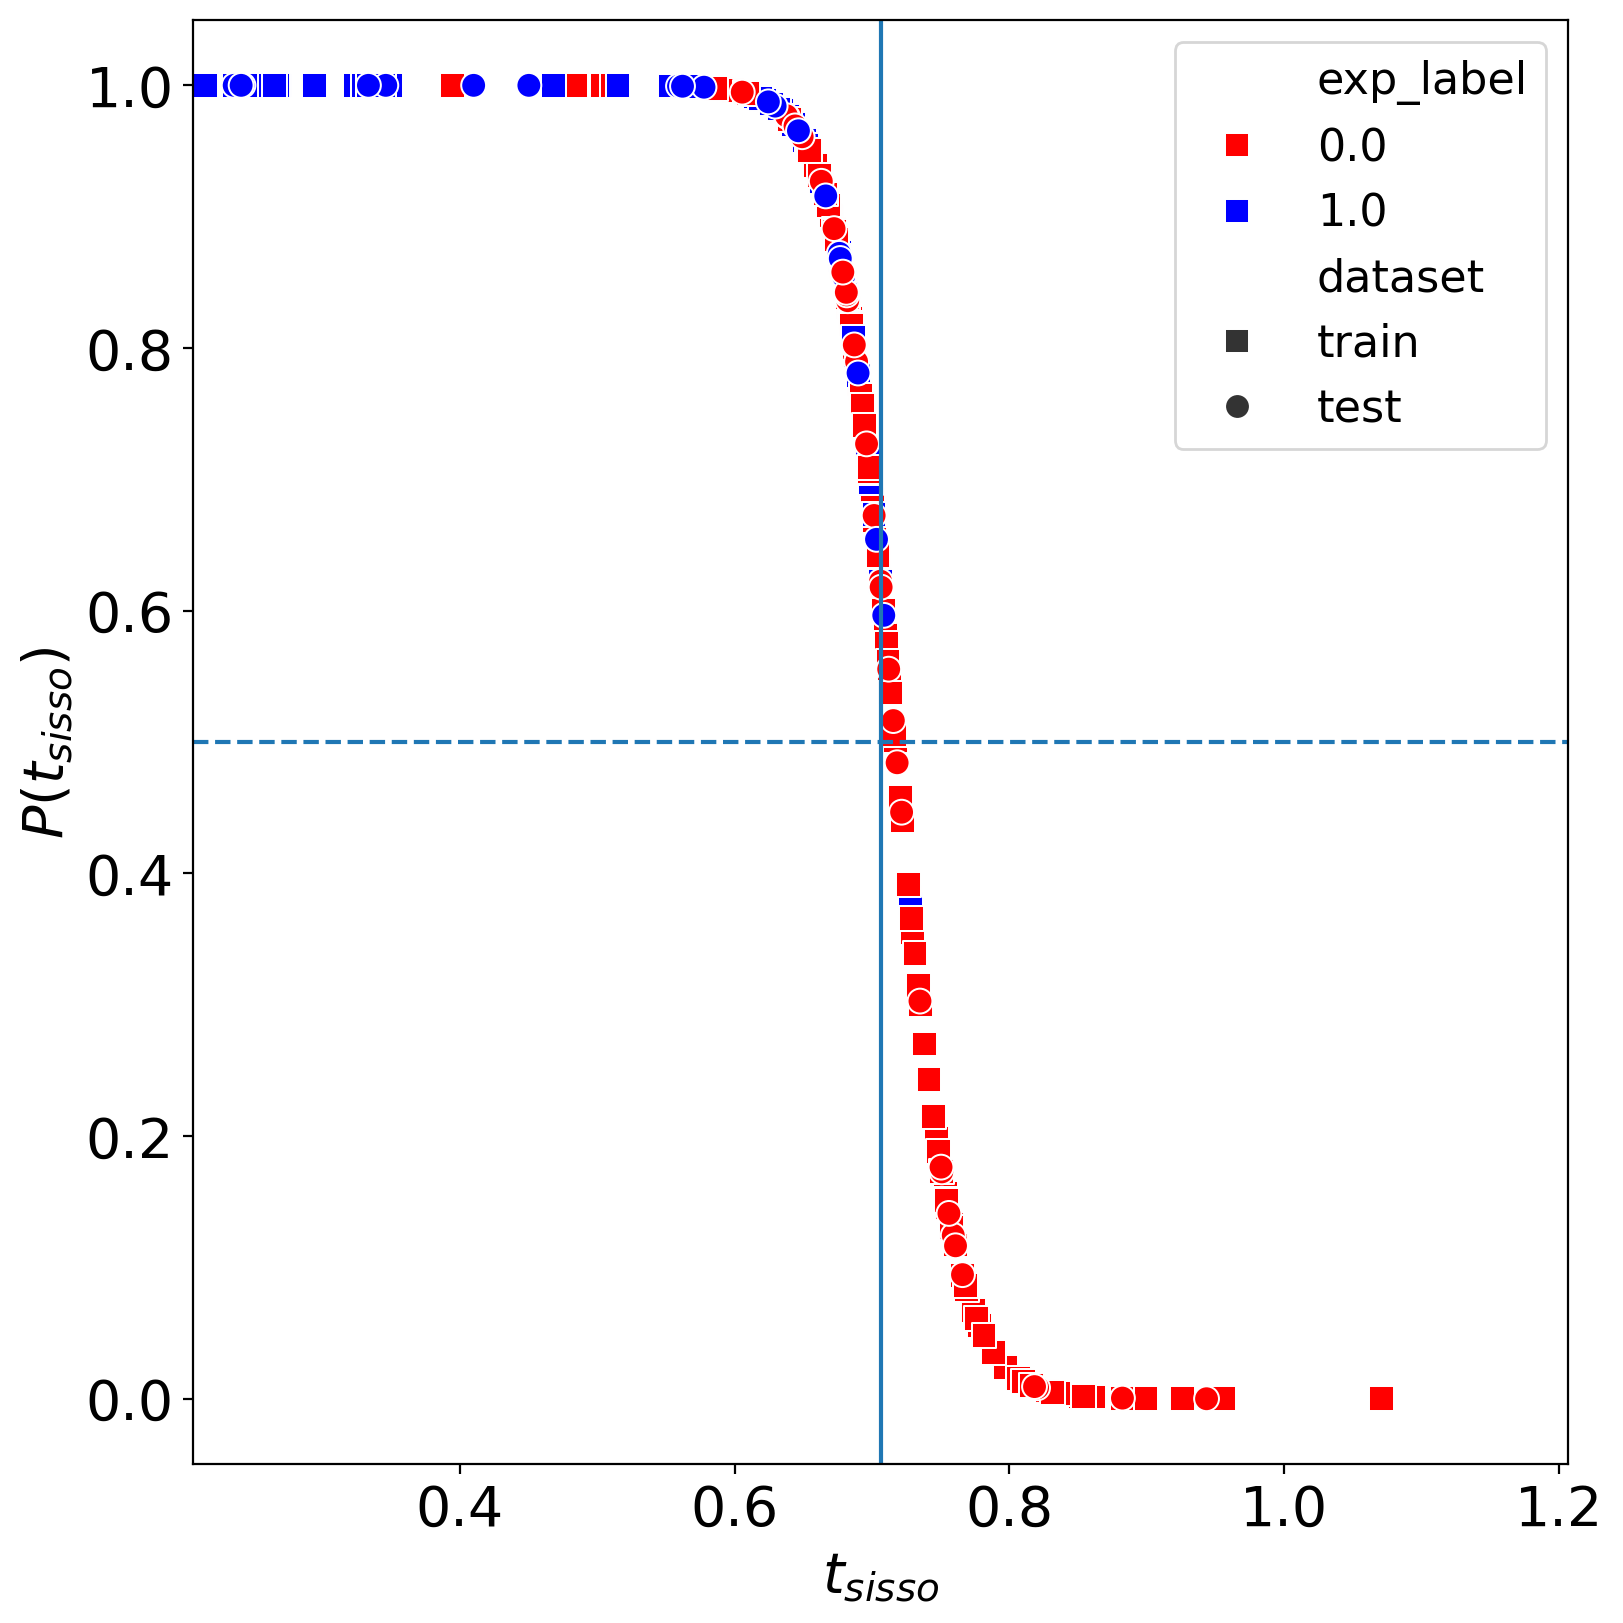

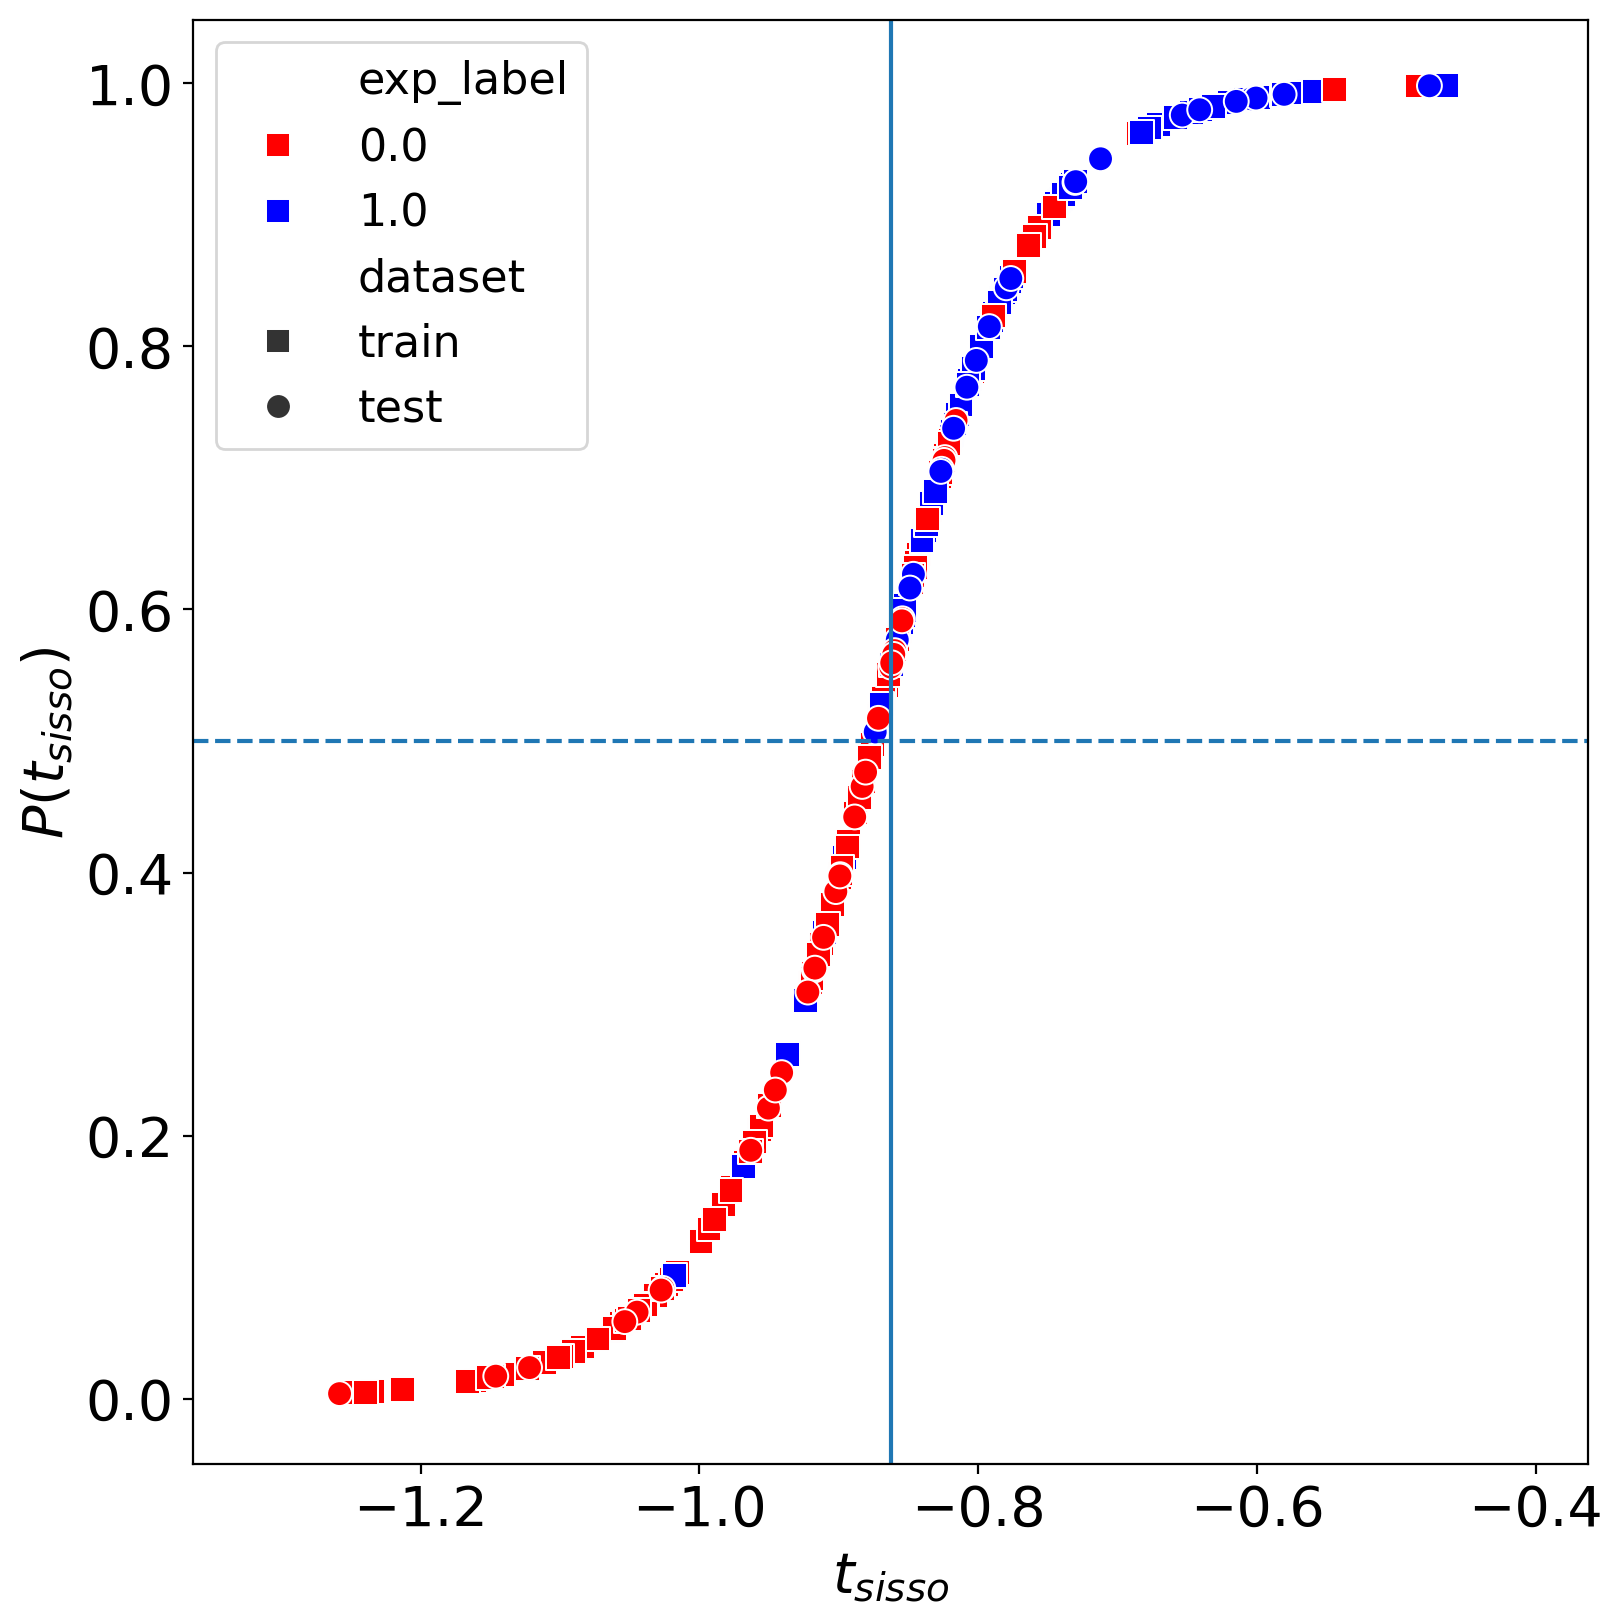

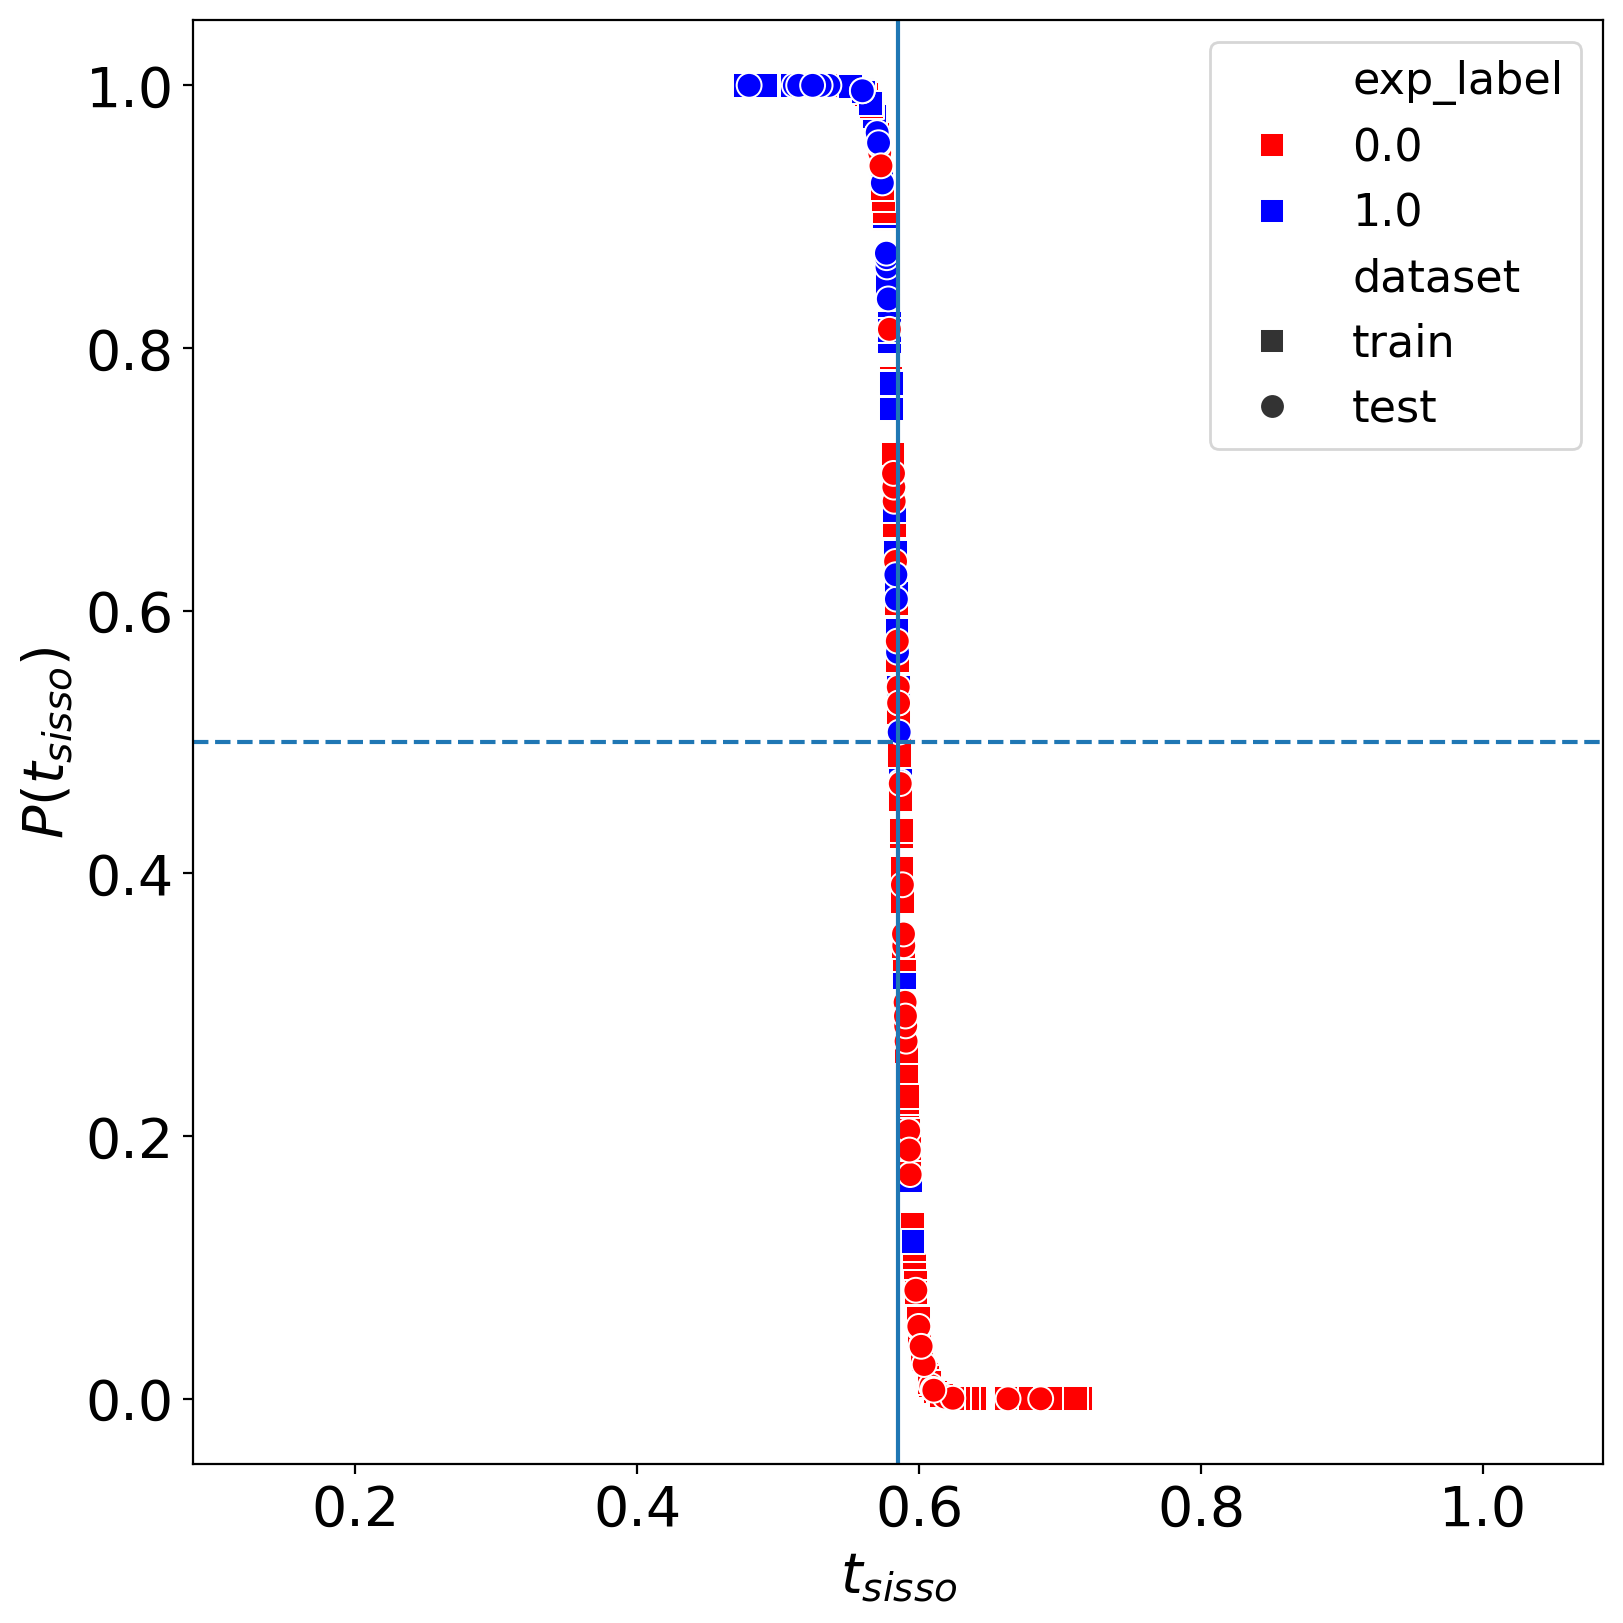

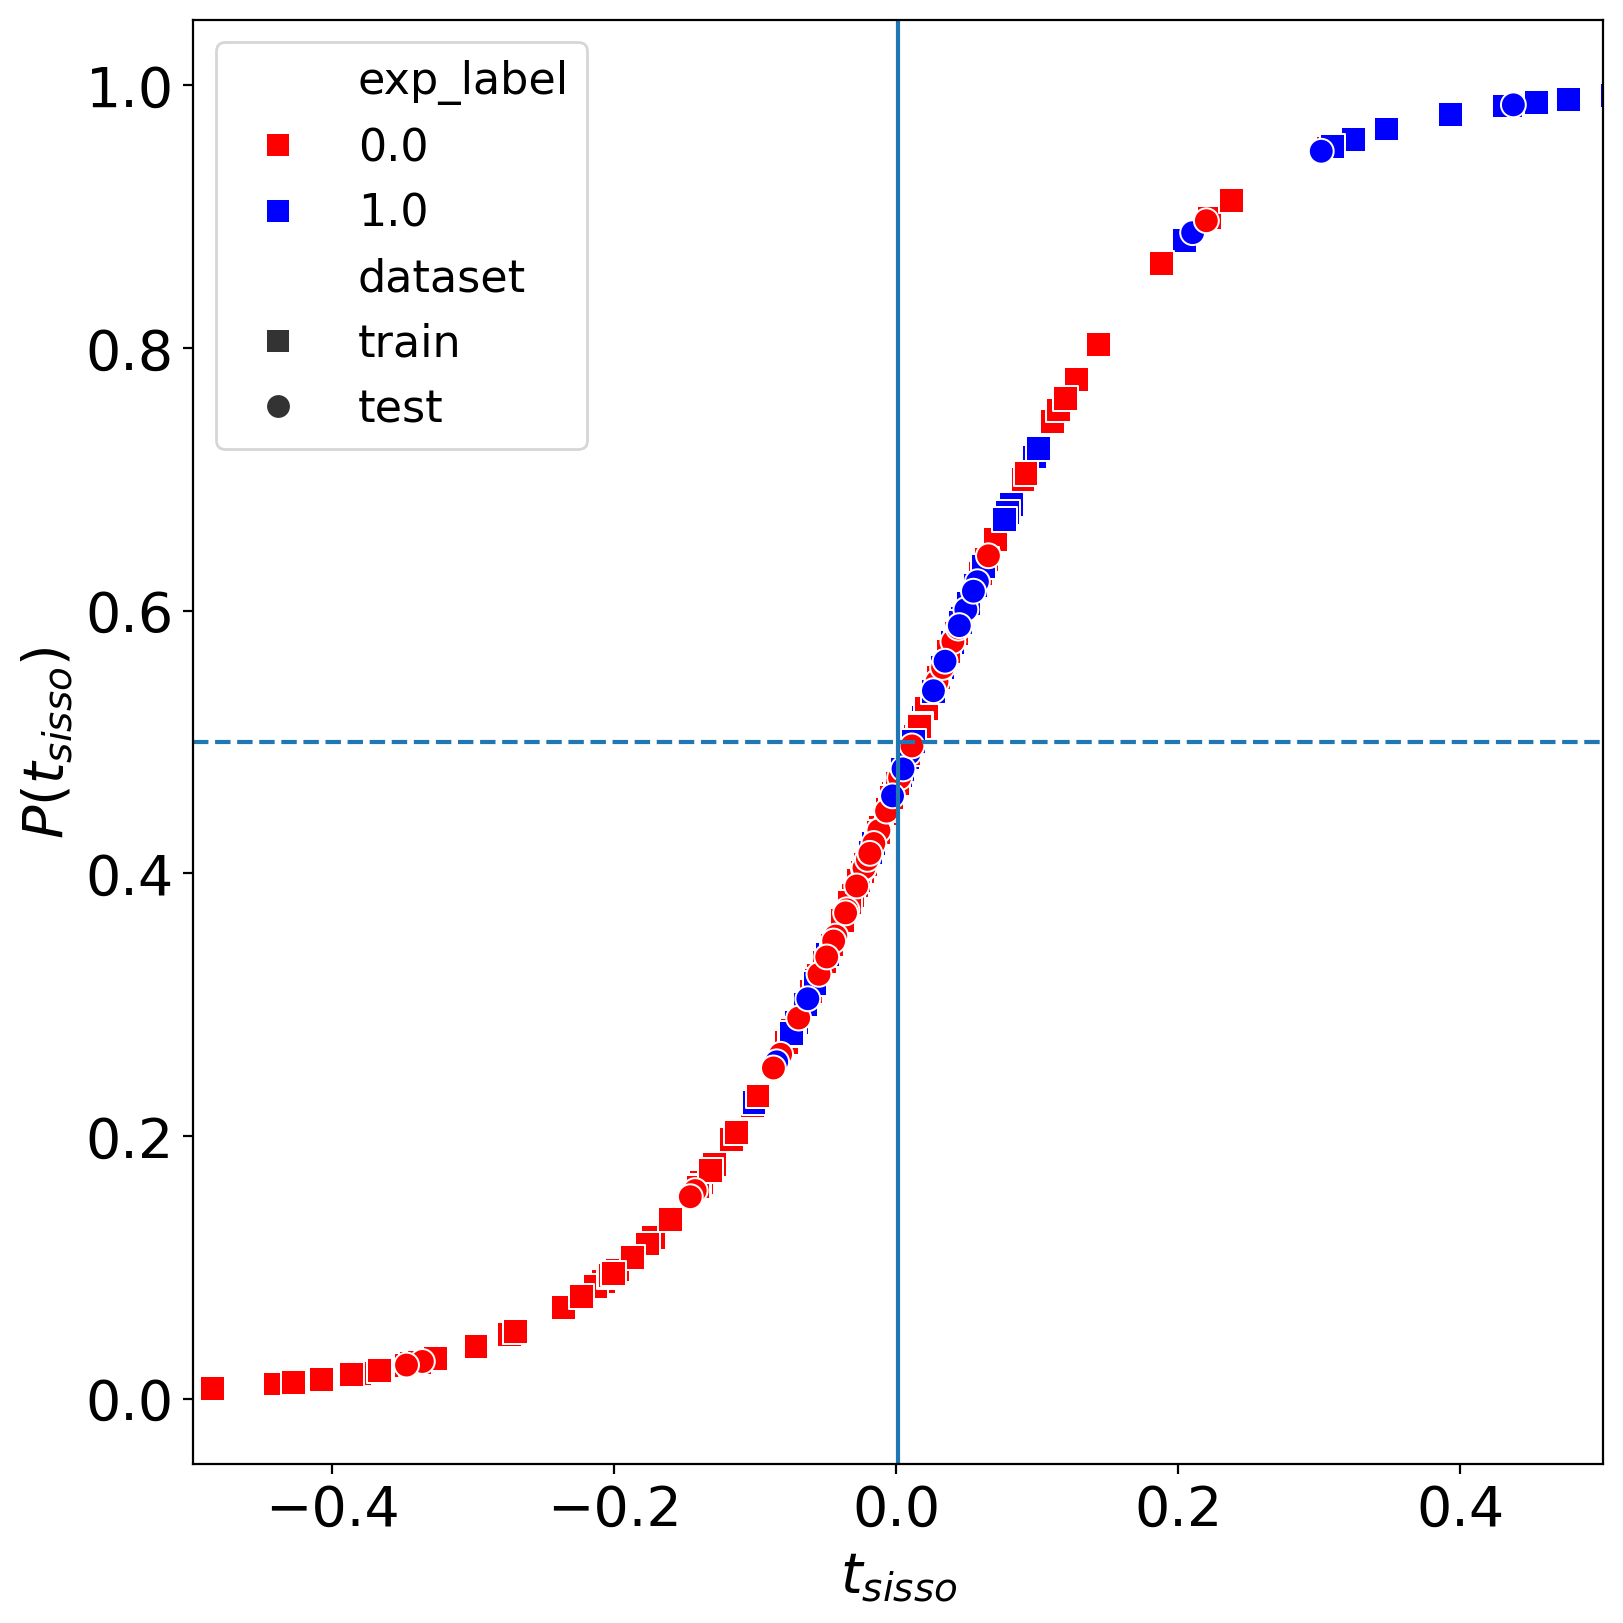

In [39]:
from tf_chpvk_pv.plots import platt_scaling_plot
from tf_chpvk_pv.config import RESULTS_DIR, INTERIM_DATA_DIR, FIGURES_DIR
import os

from tf_chpvk_pv.modeling.train import train_platt_scaling

clf2_platt_path = INTERIM_DATA_DIR / 'Ch_clf2_platt.pkl'

clf2_platt = {}

for t in tolerance_factor_dict_global.keys():
    if 'sisso' in t:
        idx = int(t.split('_')[-1])
        train_df, test_df, clf2_sisso = train_platt_scaling(train_df, test_df, clf_t=clfs[t], t=t,)
        clf2_platt[t] = clf2_sisso

        train_input_path = RESULTS_DIR / 'diff_ops_processed_chpvk_train_dataset.csv'
        test_input_path = RESULTS_DIR / 'diff_ops_processed_chpvk_test_dataset.csv'
        concat_input_path = RESULTS_DIR / 'diff_ops_processed_chpvk_concat_dataset.csv'
        if concat_input_path.exists():
            os.remove(concat_input_path)
        tolerance_dict_path = INTERIM_DATA_DIR / 'ch_tolerance_factors_ops.pkl'
        txt_output = 'ch_diff_ops_platt_scaling_plot_t_sisso_' + str(idx) + '.png'
        output_path = FIGURES_DIR / txt_output

        platt_scaling_plot(t, train_input_path, test_input_path,concat_input_path, tolerance_dict_path, output_path)


with open(clf2_platt_path, 'wb') as file:
    pickle.dump(clf2_platt, file)

In [45]:
test_idx = [x for x in df.index if 'test' in x]
tfs_ = ['t', 'tau', 't_jess'] + ['t_sisso_55']
display(df.loc[test_idx, tfs_])

t       tau    t_jess  t_sisso_55
Unnamed: 0                                            
test_data     0.596491  0.824561  0.631579    0.894737
test_data_S   0.500000  0.500000  0.583333    0.750000
test_data_I   0.222222  0.777778  0.777778    0.888889
test_data_Cl  0.642857  0.928571  0.500000    0.857143
test_data_Br  0.500000  0.833333  0.500000    1.000000
test_data_F   1.000000  1.000000  0.769231    1.000000
test_data_Se  0.333333  1.000000  0.666667    1.000000

In [25]:
from tf_chpvk_pv.dataset import generate_compositions
from tf_chpvk_pv.modeling.predict import check_stable_compositions
from tf_chpvk_pv.config import INTERIM_DATA_DIR

new_tolerance_dict_path = INTERIM_DATA_DIR / 'ch_tolerance_factors_ops.pkl'

element_selection_A = ["Ba", "Eu", "Pb", "Sr", "Ca", "Sn", "Cd", "Cu", "Mg",
                      "Zn", "Ge", "La", "Pr", "Ce", "Nd", "Yb", "Gd", "Sm", "Y",
                      "Dy", "Ho", "Er", "Tm", "Lu", "Sc", "Tl", "Bi"]

elements_selection_B = ["Si", "Ge", "V", "Rh", "Ti", "Ru", "Mo", "Ta", "Nb", "Hf",
                        "Zr", "Tb", "Pt", "Ce", "U", "Pd", "Ni", "Co", "Ga", "Al",
                        "Fe", "Cr", "In", "Mn", "Sc", "Lu", "Tm", "Er", "Ho", "Y",
                        "Yb"]


elements_selection = element_selection_A + elements_selection_B

possible_oxidation_states = [2.0, 3.0, 4.0] #3, 4] #for A and B elements

df_generated_comp = generate_compositions(elements_selection, 
                                          possible_oxidation_states, 
                                          dict_tol_factors_path=new_tolerance_dict_path).dropna()

2025-03-27 12:51:13.015 | INFO     | tf_chpvk_pv.dataset:generate_compositions:247 - Generating valid compositions...
Invalid composition: CuBiS3
Invalid composition: CuBiSe3
Invalid composition: VCuS3
Invalid composition: VCuSe3
Invalid composition: CuRuS3
Invalid composition: CuRuSe3
Invalid composition: CuMoS3
Invalid composition: CuMoSe3
Invalid composition: TaCuS3
Invalid composition: TaCuSe3
Invalid composition: NbCuS3
Invalid composition: NbCuSe3
Invalid composition: CuPtS3
Invalid composition: CuPtSe3
Invalid composition: CrCuS3
Invalid composition: CrCuSe3
Invalid composition: TlVS3
Invalid composition: TlVSe3
Invalid composition: TlRuS3
Invalid composition: TlRuSe3
Invalid composition: TlMoS3
Invalid composition: TlMoSe3
Invalid composition: TaTlS3
Invalid composition: TaTlSe3
Invalid composition: NbTlS3
Invalid composition: NbTlSe3
Invalid composition: TlPtS3
Invalid composition: TlPtSe3
Invalid composition: UTlS3
Invalid composition: UTlSe3
Invalid composition: TlCrS3
Inval

According to tau, 385 (33.13253012048193%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPrS3', 'BaCeS3', 'BaHfS3', 'BaZrS3', 'BaTbS3', 'BaUS3', 'EuCuS3', 'EuCuSe3', 'EuScS3', 'EuScSe3', 'EuRhS3', 'EuRhSe3', 'EuMoS3', 'EuMoSe3', 'EuNiS3', 'EuNiSe3', 'EuCoS3', 'EuCoSe3', 'EuGaS3', 'EuGaSe3', 'EuAlS3', 'EuAlSe3', 'EuFeS3', 'EuFeSe3', 'EuCrS3', 'EuCrSe3', 'EuInS3', 'EuMnS3', 'EuMnSe3', 'CuLaS3', 'CuLaSe3', 'CuGaS3', 'CuAlS3', 'CuAlSe3', 'MgUS3', 'MgUSe3', 'LaYbS3', 'LaYbSe3', 'LaYS3', 'LaYSe3', 'LaHoS3', 'LaHoSe3', 'LaErS3', 'LaErSe3', 'LaTmS3', 'LaTmSe3', 'LaLuS3', 'LaLuSe3', 'LaScS3', 'LaScSe3', 'LaTlS3', 'LaTlSe3', 'LaVS3', 'LaVSe3', 'LaRhS3', 'LaRhSe3', 'LaTiS3', 'LaTiSe3', 'LaRuS3', 'LaRuSe3', 'LaMoS3', 'LaMoSe3', 'LaTaS3', 'LaTaSe3', 'LaNbS3', 'LaNbSe3', 'LaHfS3', 'LaNiS3', 'LaNiSe3', 'LaCoS3', 'LaCoSe3', 'LaGaS3', 'LaGaSe3', 'LaAlS3', 'LaAlSe3', 'LaFeS3', 'LaFeSe3', 'LaCrS3', 'LaCrSe3', 'LaInS3', 'LaInSe3', 'LaMnS3', 'LaMnSe3', 'PrLuS3', 'PrScS3', 'PrScSe3',

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


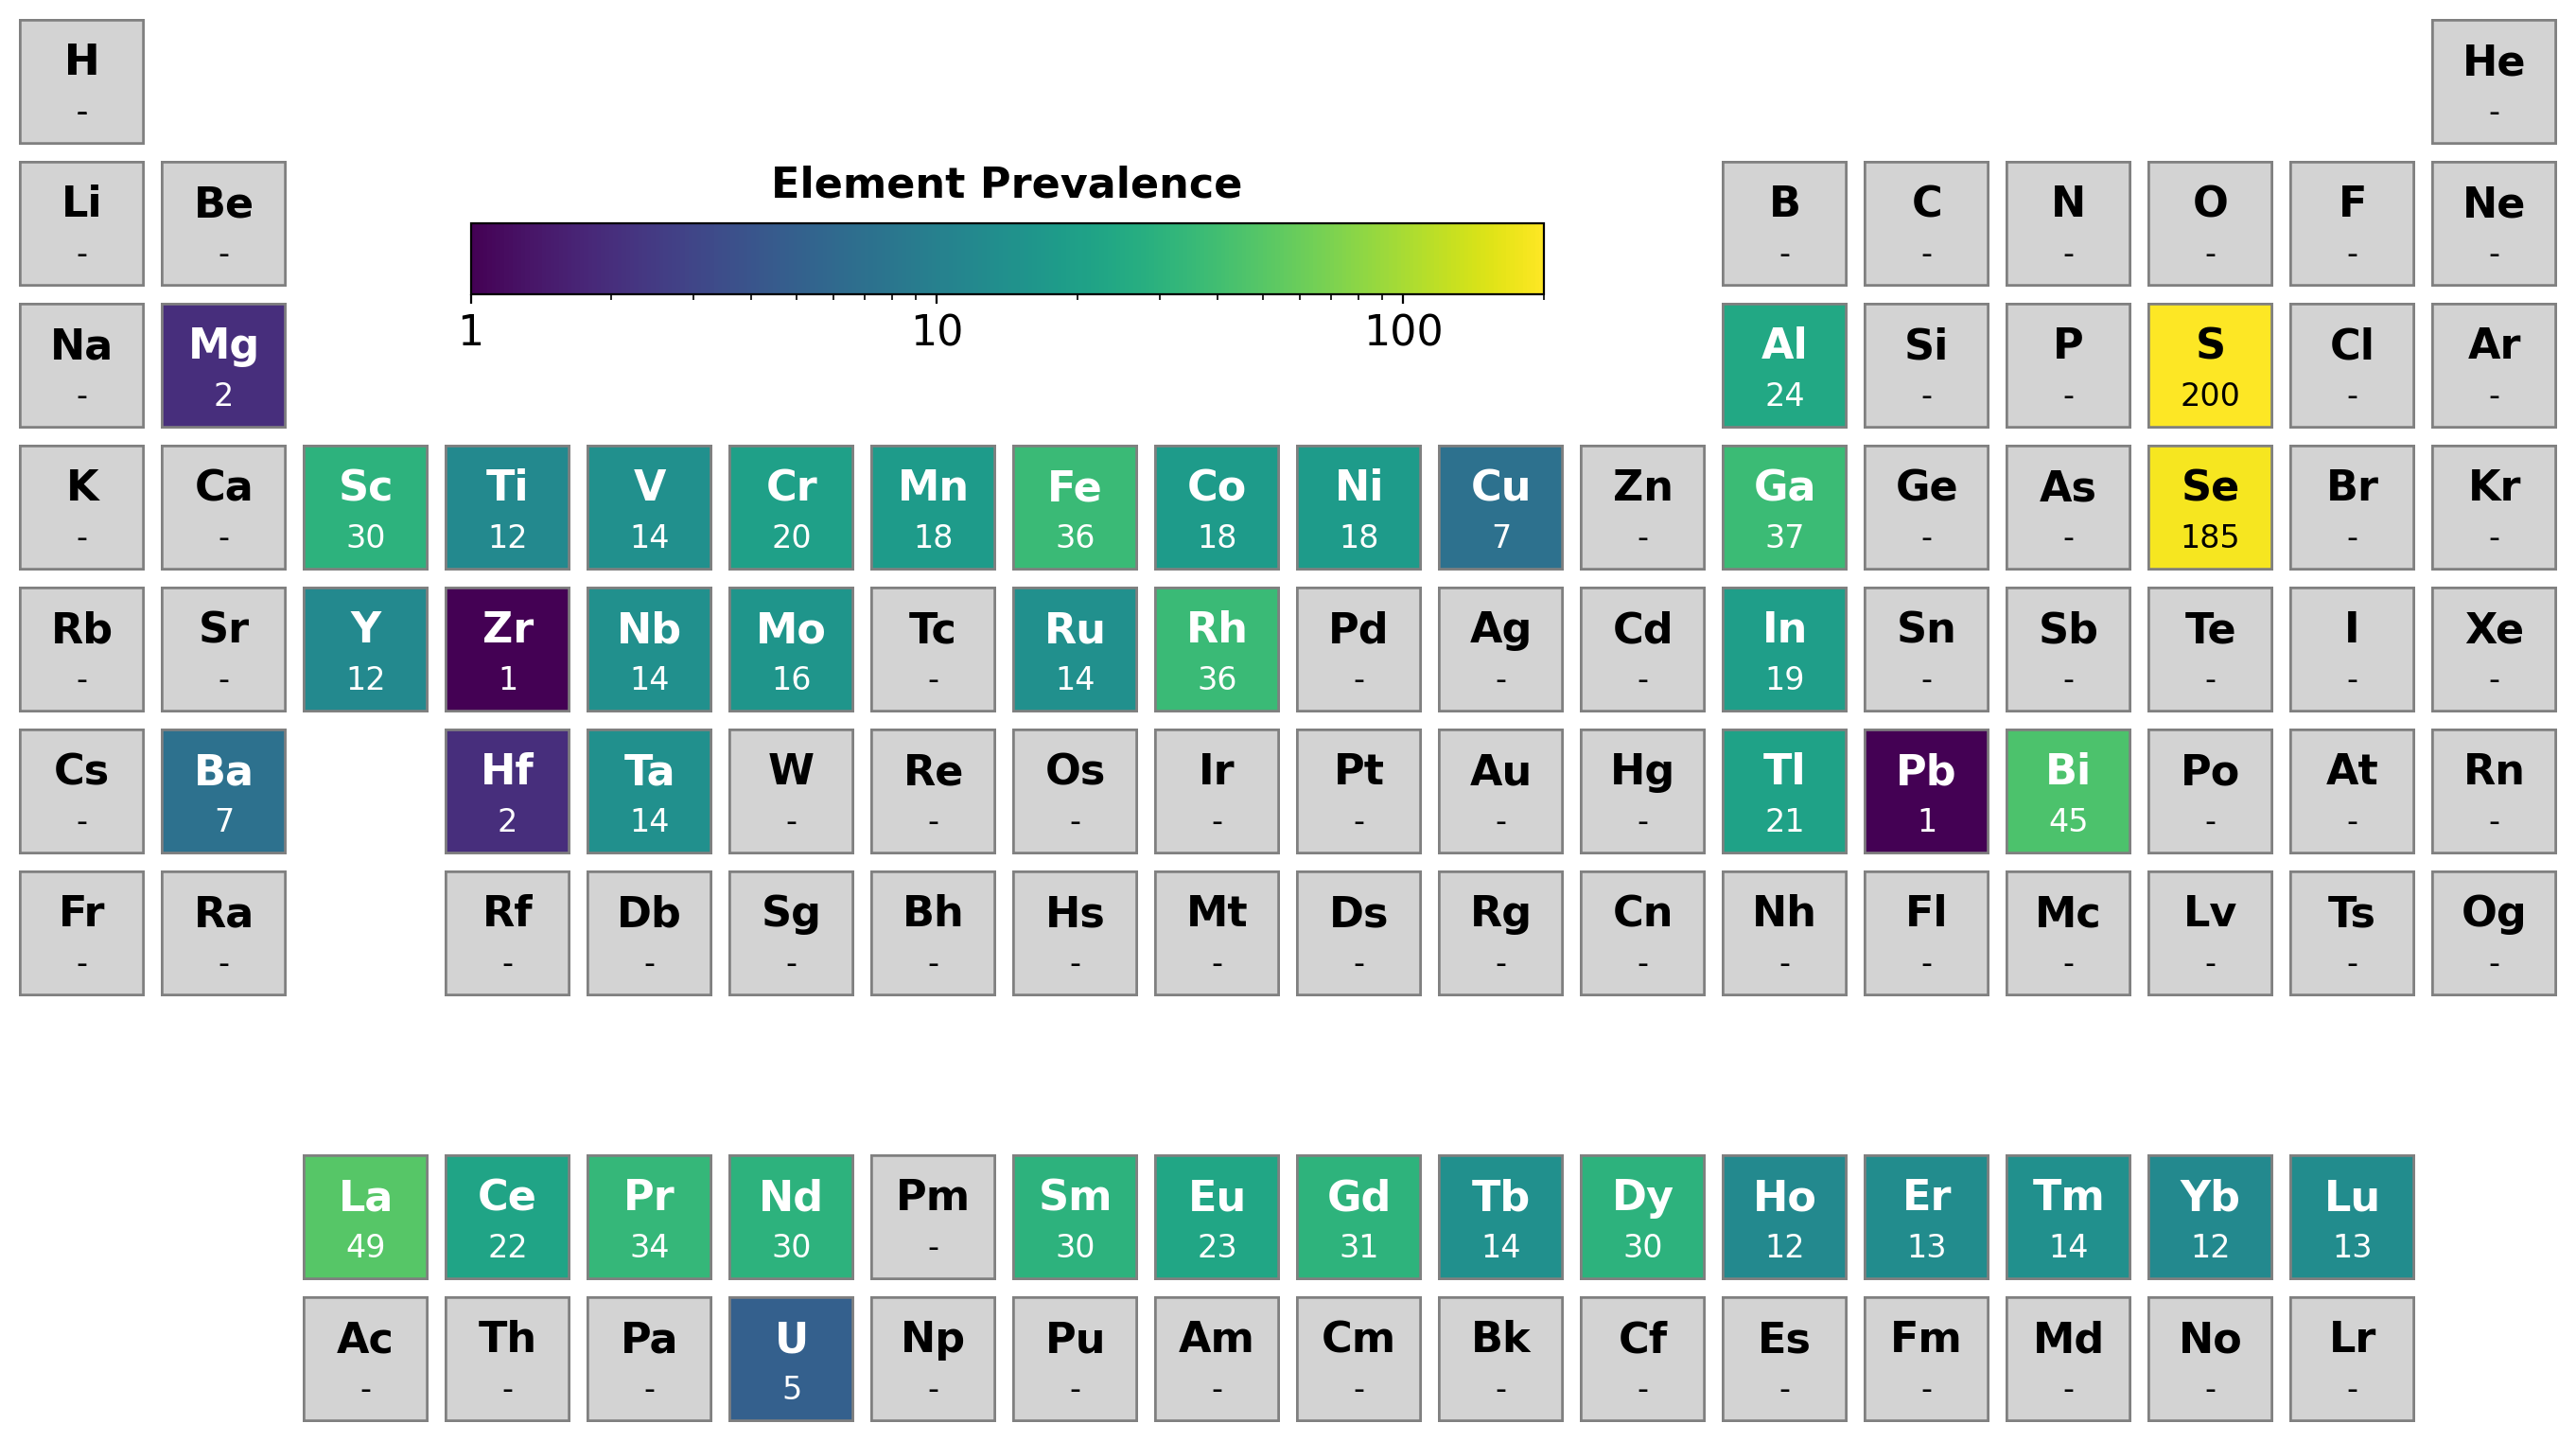

According to t_sisso_5, 120 (10.327022375215146%) compositions are predicted to be stable as perovskites:
['BaCeS3', 'BaUS3', 'EuUS3', 'EuUSe3', 'EuInS3', 'EuInSe3', 'PbPrS3', 'PbCeS3', 'PbUS3', 'SrPrS3', 'SrCeS3', 'SrUS3', 'SrUSe3', 'CaPrS3', 'CaPrSe3', 'CaCeSe3', 'SnTbS3', 'SnTbSe3', 'CdPrS3', 'CdPrSe3', 'CdCeSe3', 'CuScSe3', 'CuTbS3', 'CuTbSe3', 'CuFeS3', 'CuFeSe3', 'MgVS3', 'MgVSe3', 'MgRhS3', 'MgRhSe3', 'MgTiS3', 'MgTiSe3', 'MgRuS3', 'MgRuSe3', 'MgMoS3', 'MgMoSe3', 'MgTaS3', 'MgTaSe3', 'MgNbS3', 'MgNbSe3', 'MgPtS3', 'MgPtSe3', 'MgPdS3', 'MgPdSe3', 'ZnVS3', 'ZnVSe3', 'ZnRhS3', 'ZnRhSe3', 'ZnTiS3', 'ZnTiSe3', 'ZnRuS3', 'ZnRuSe3', 'ZnMoS3', 'ZnMoSe3', 'ZnTaS3', 'ZnTaSe3', 'ZnNbS3', 'ZnNbSe3', 'ZnHfSe3', 'ZnPtS3', 'ZnPtSe3', 'ZnPdS3', 'ZnPdSe3', 'LaYbS3', 'LaYbSe3', 'LaErSe3', 'LaTmSe3', 'LaLuS3', 'LaLuSe3', 'LaTlSe3', 'PrYbSe3', 'PrLuSe3', 'CeYbSe3', 'CeTmSe3', 'CeLuS3', 'CeLuSe3', 'NdLuSe3', 'NdInS3', 'BiYbS3', 'BiYbSe3', 'GdInS3', 'GdInSe3', 'SmInS3', 'SmInSe3', 'BiYSe3', 'DyInS3',

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


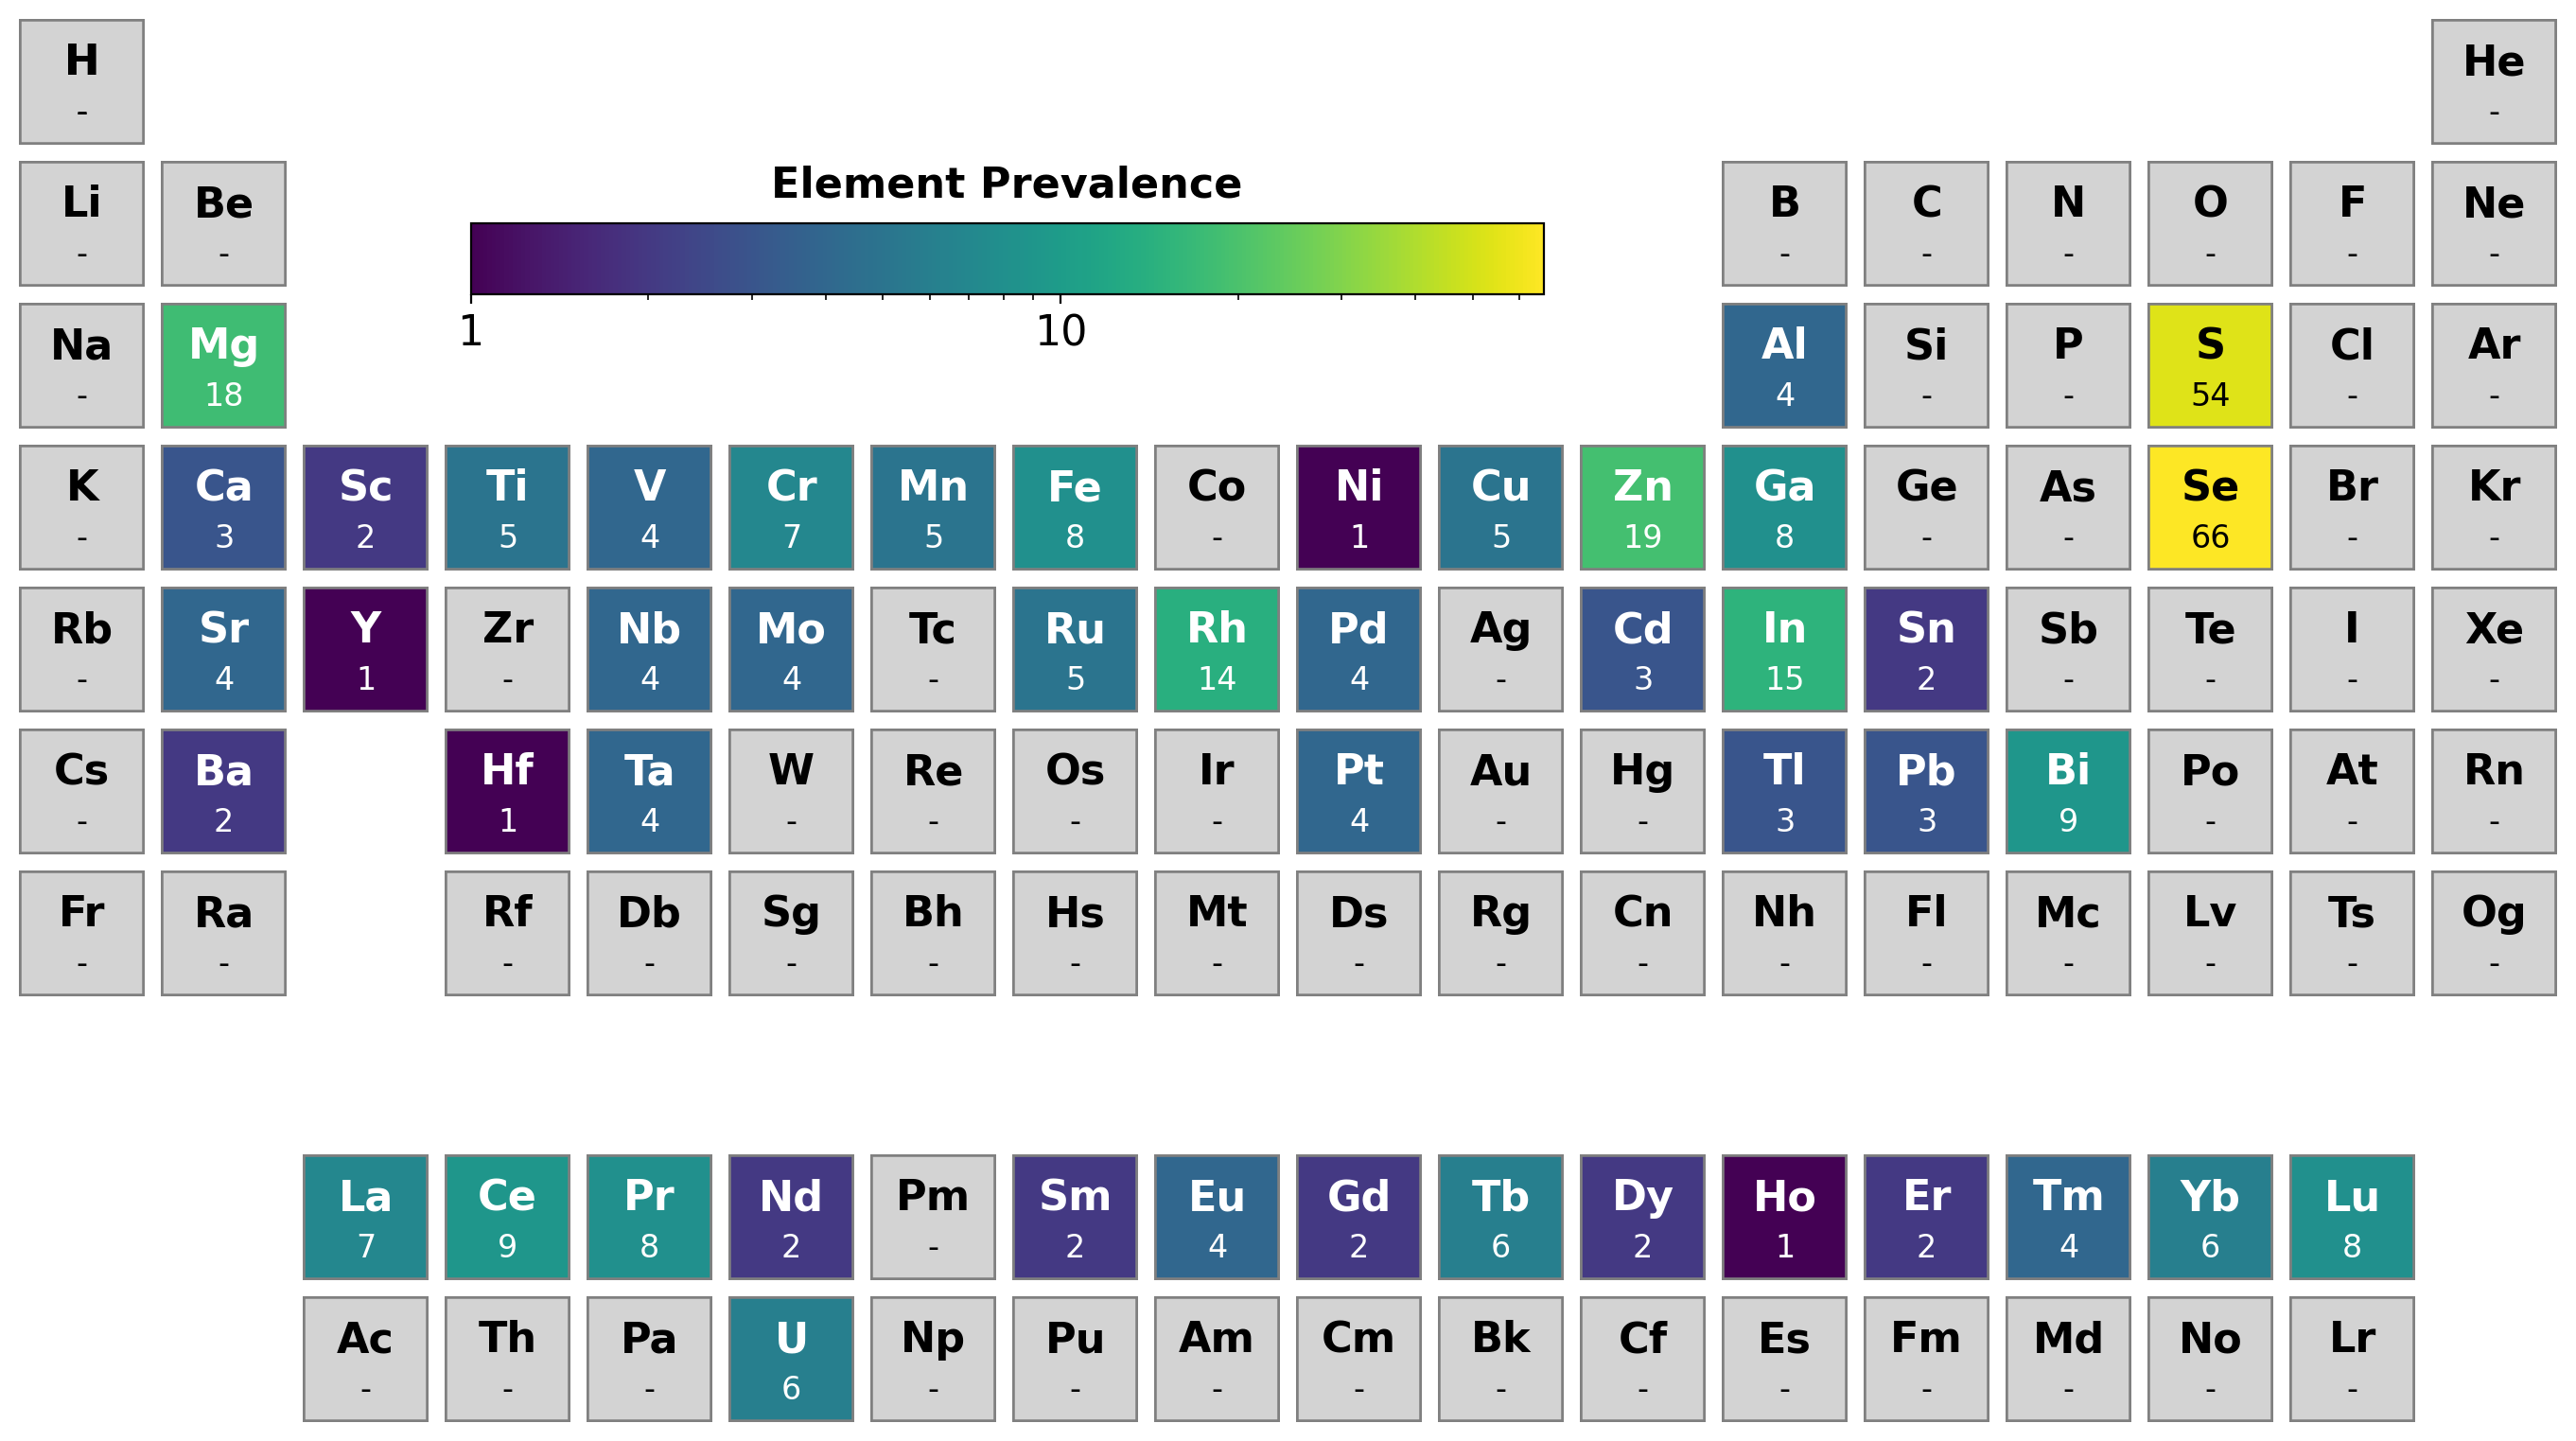

According to t_sisso_219, 1110 (95.5249569707401%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaPrSe3', 'BaCeSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaPdS3', 'BaPdSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuVS3', 'EuVSe3', 'EuRhS3', 'EuRhSe3', 'EuTiS3', 'EuTiSe3', 'EuRuS3', 'EuRuSe3', 'EuMoS3', 'EuMoSe3', 'EuTaS3', 'EuTaSe3', 'EuNbS3', 'EuNbSe3', 'EuHfS3', 'EuHfSe3', 'EuZr

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


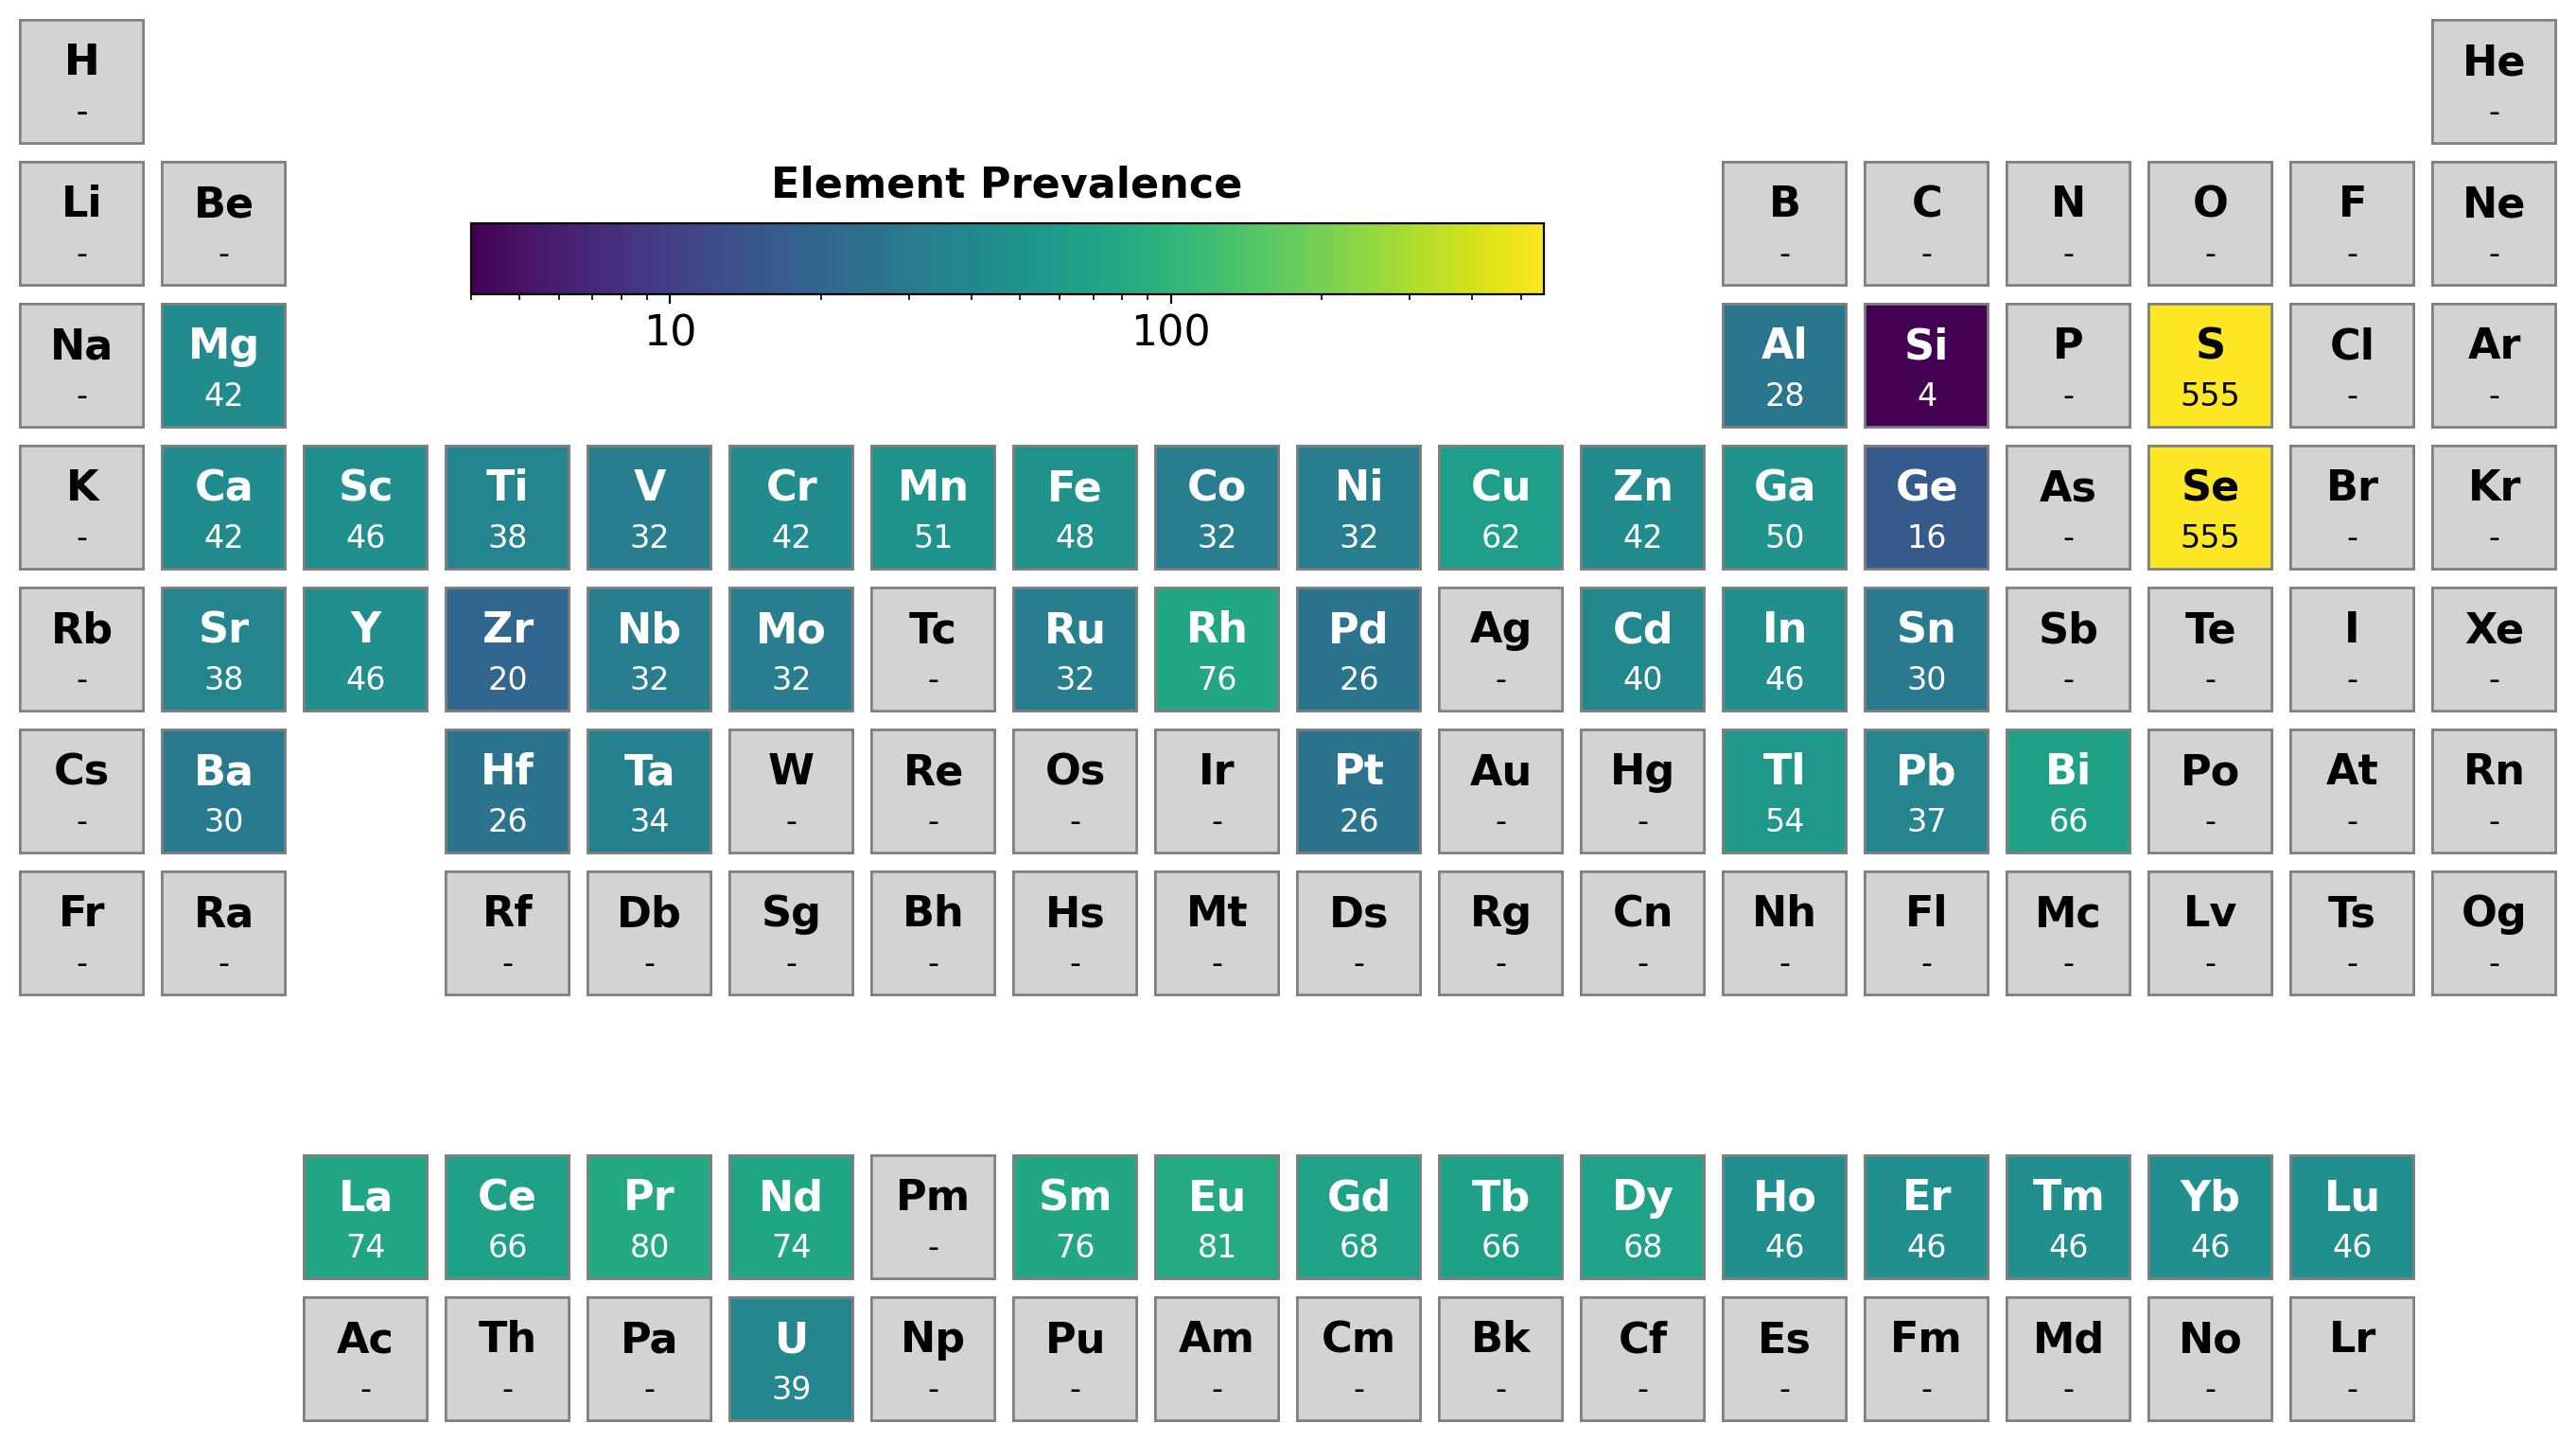

According to t_sisso_55, 123 (10.585197934595525%) compositions are predicted to be stable as perovskites:
['BaCeS3', 'BaUS3', 'EuUS3', 'EuUSe3', 'EuInS3', 'EuInSe3', 'PbPrS3', 'PbCeS3', 'PbUS3', 'SrPrS3', 'SrCeS3', 'SrUS3', 'SrUSe3', 'CaPrS3', 'CaPrSe3', 'CaCeSe3', 'SnTbS3', 'SnTbSe3', 'CdPrS3', 'CdPrSe3', 'CdCeSe3', 'CuScSe3', 'CuTbS3', 'CuTbSe3', 'CuFeS3', 'CuFeSe3', 'MgVS3', 'MgVSe3', 'MgRhS3', 'MgRhSe3', 'MgTiS3', 'MgTiSe3', 'MgRuS3', 'MgRuSe3', 'MgMoS3', 'MgMoSe3', 'MgTaS3', 'MgTaSe3', 'MgNbS3', 'MgNbSe3', 'MgPtS3', 'MgPtSe3', 'MgPdS3', 'MgPdSe3', 'MgCrSe3', 'ZnVS3', 'ZnVSe3', 'ZnRhS3', 'ZnRhSe3', 'ZnTiS3', 'ZnTiSe3', 'ZnRuS3', 'ZnRuSe3', 'ZnMoS3', 'ZnMoSe3', 'ZnTaS3', 'ZnTaSe3', 'ZnNbS3', 'ZnNbSe3', 'ZnHfSe3', 'ZnPtS3', 'ZnPtSe3', 'ZnPdS3', 'ZnPdSe3', 'LaYbS3', 'LaYbSe3', 'LaErSe3', 'LaTmSe3', 'LaLuS3', 'LaLuSe3', 'LaTlSe3', 'PrYbSe3', 'PrLuSe3', 'CeYbSe3', 'CeTmSe3', 'CeLuS3', 'CeLuSe3', 'NdLuSe3', 'NdInS3', 'BiYbS3', 'BiYbSe3', 'GdInS3', 'GdInSe3', 'SmInS3', 'SmInSe3', 'BiYSe3

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


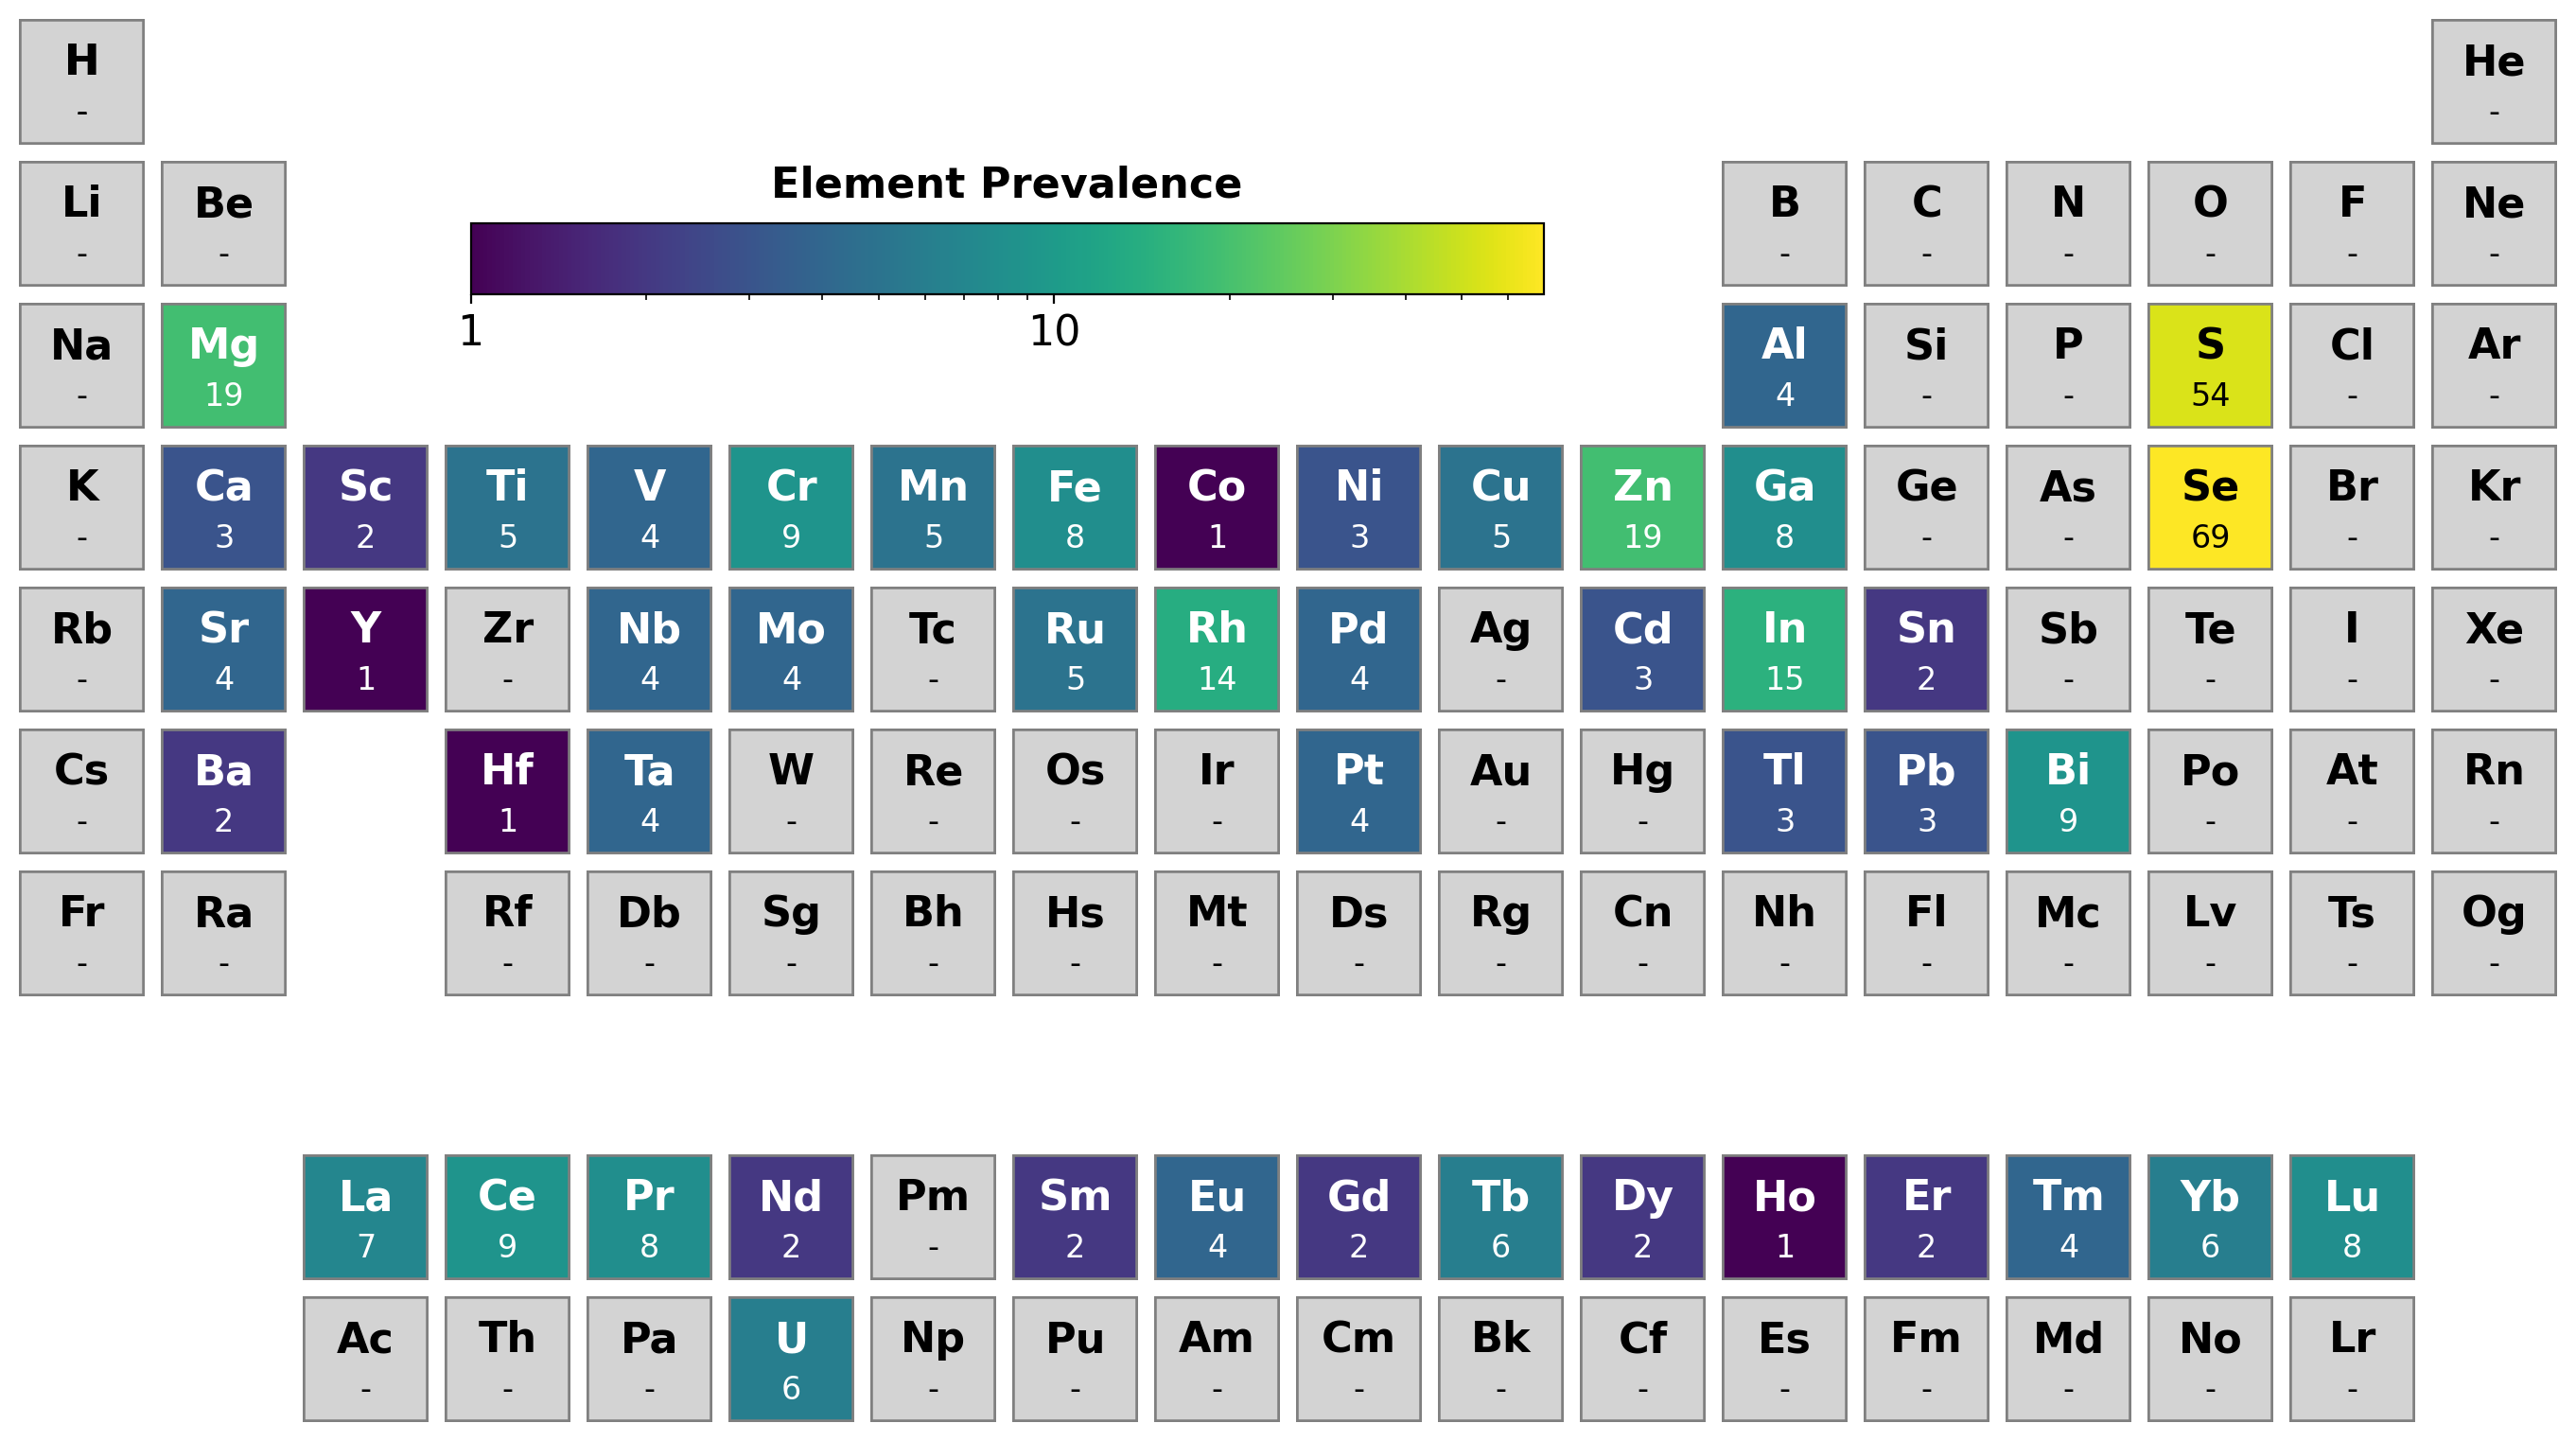

According to t_sisso_14, 661 (56.88468158347676%) compositions are predicted to be stable as perovskites:
['BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuTlS3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuSiSe3', 'EuVS3', 'EuVSe3', 'EuTiS3', 'EuTiSe3', 'EuRuS3', 'EuRuSe3', 'EuTaS3', 'EuTaSe3', 'EuNbS3', 'EuNbSe3', 'EuHfS3', 'EuHfSe3', 'EuZrS3', 'EuZrSe3', 'EuTbS3

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


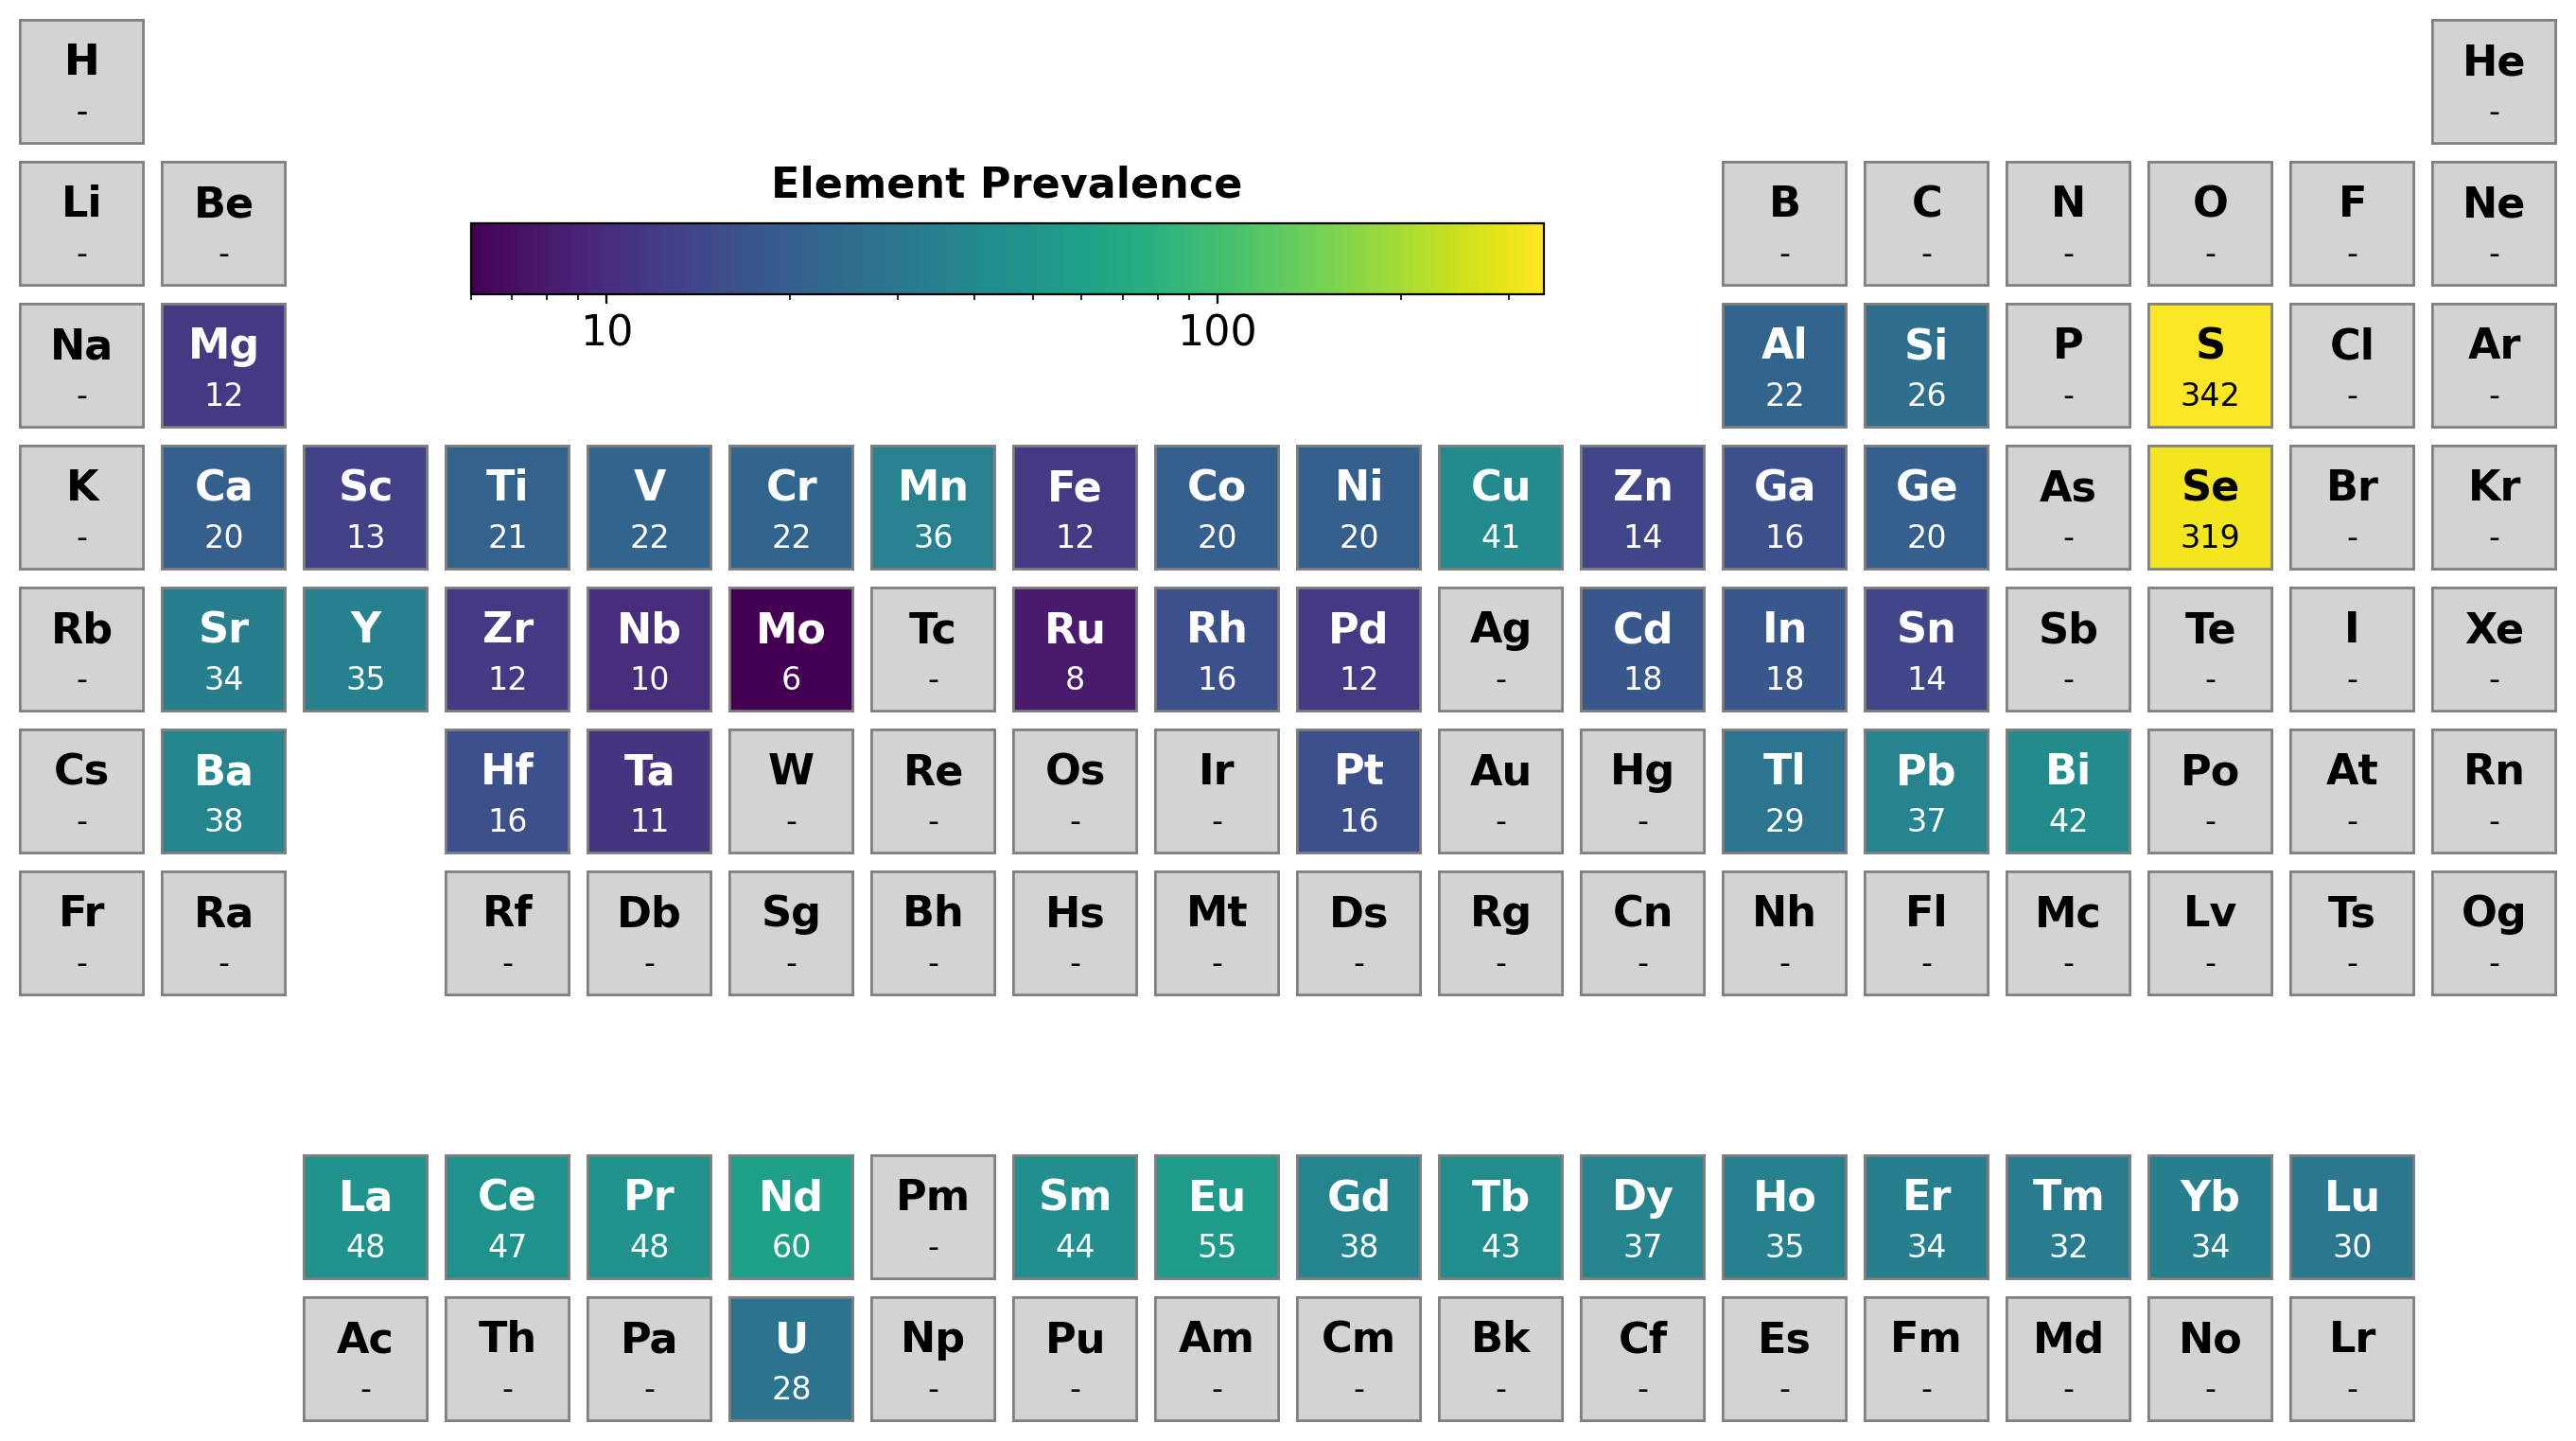

According to t_sisso_37, 1149 (98.88123924268503%) compositions are predicted to be stable as perovskites:
['BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaPrSe3', 'BaCeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuSiSe3', 'EuVS3', 'EuVSe3', 'EuRhS3', 'EuRhSe3', 'EuT

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


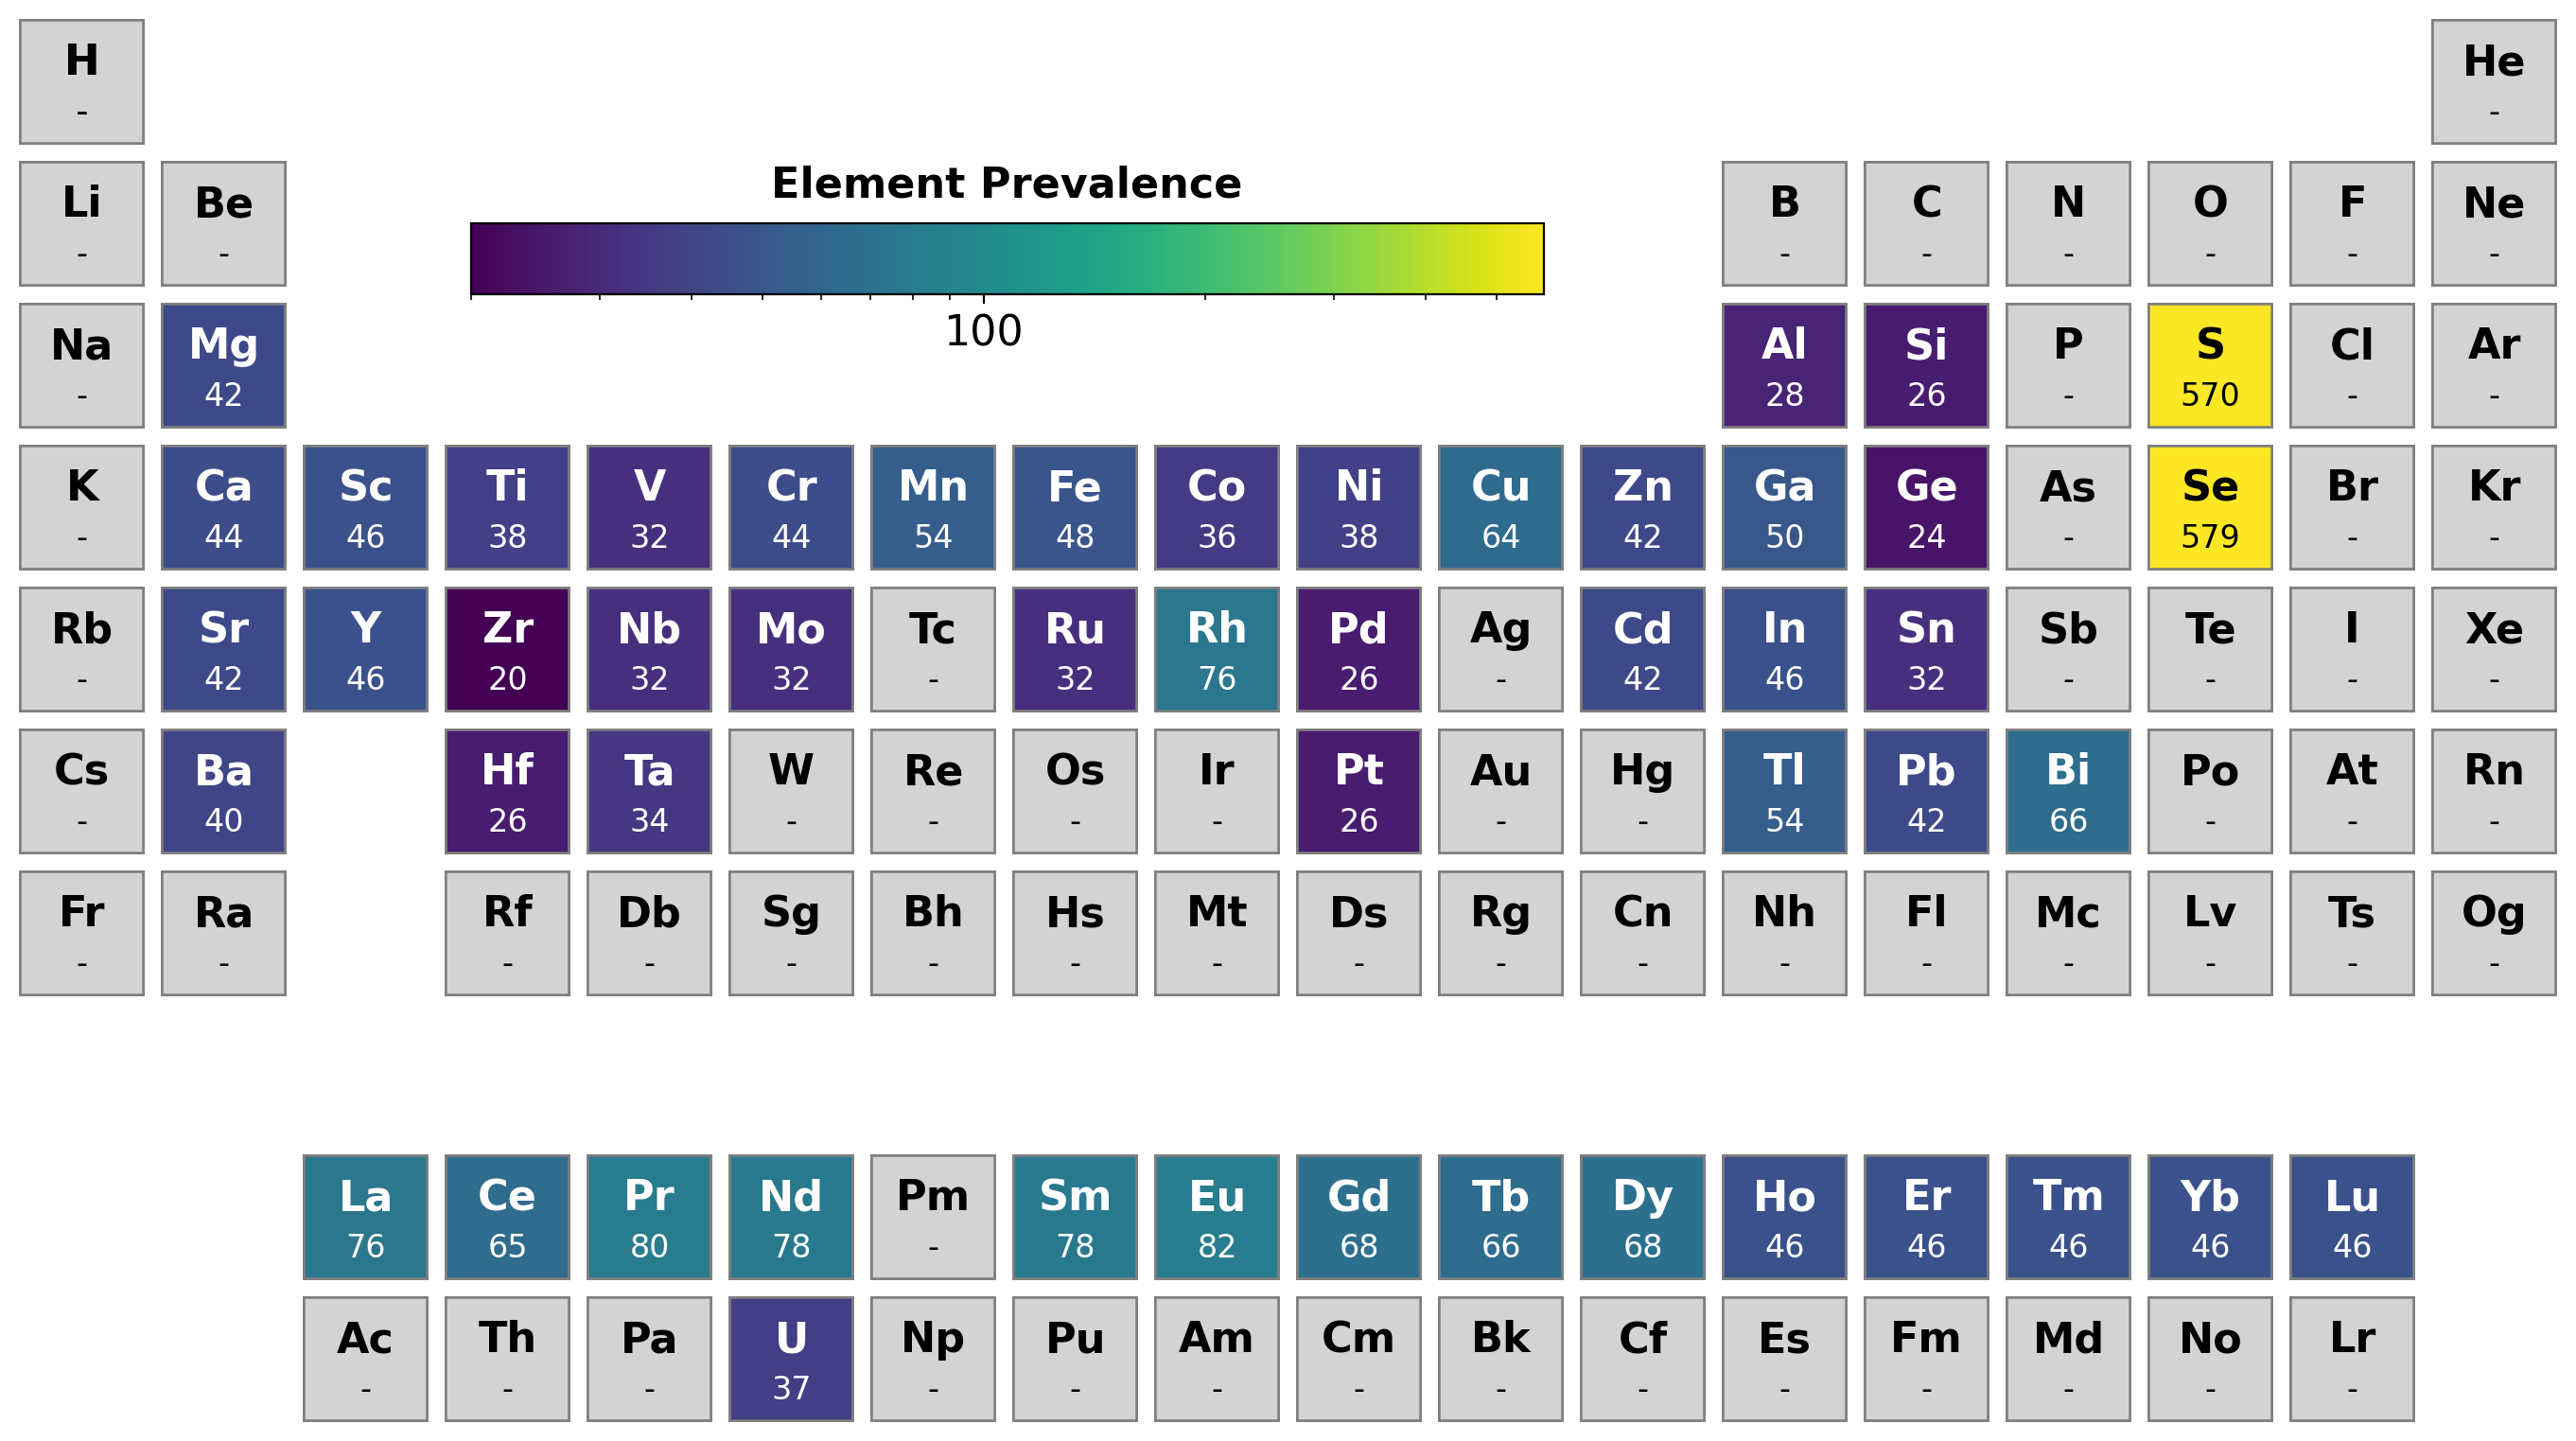

According to t_sisso_124, 1110 (95.5249569707401%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaPrSe3', 'BaCeSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaPdS3', 'BaPdSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuVS3', 'EuVSe3', 'EuRhS3', 'EuRhSe3', 'EuTiS3', 'EuTiSe3', 'EuRuS3', 'EuRuSe3', 'EuMoS3', 'EuMoSe3', 'EuTaS3', 'EuTaSe3', 'EuNbS3', 'EuNbSe3', 'EuHfS3', 'EuHfSe3', 'EuZr

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


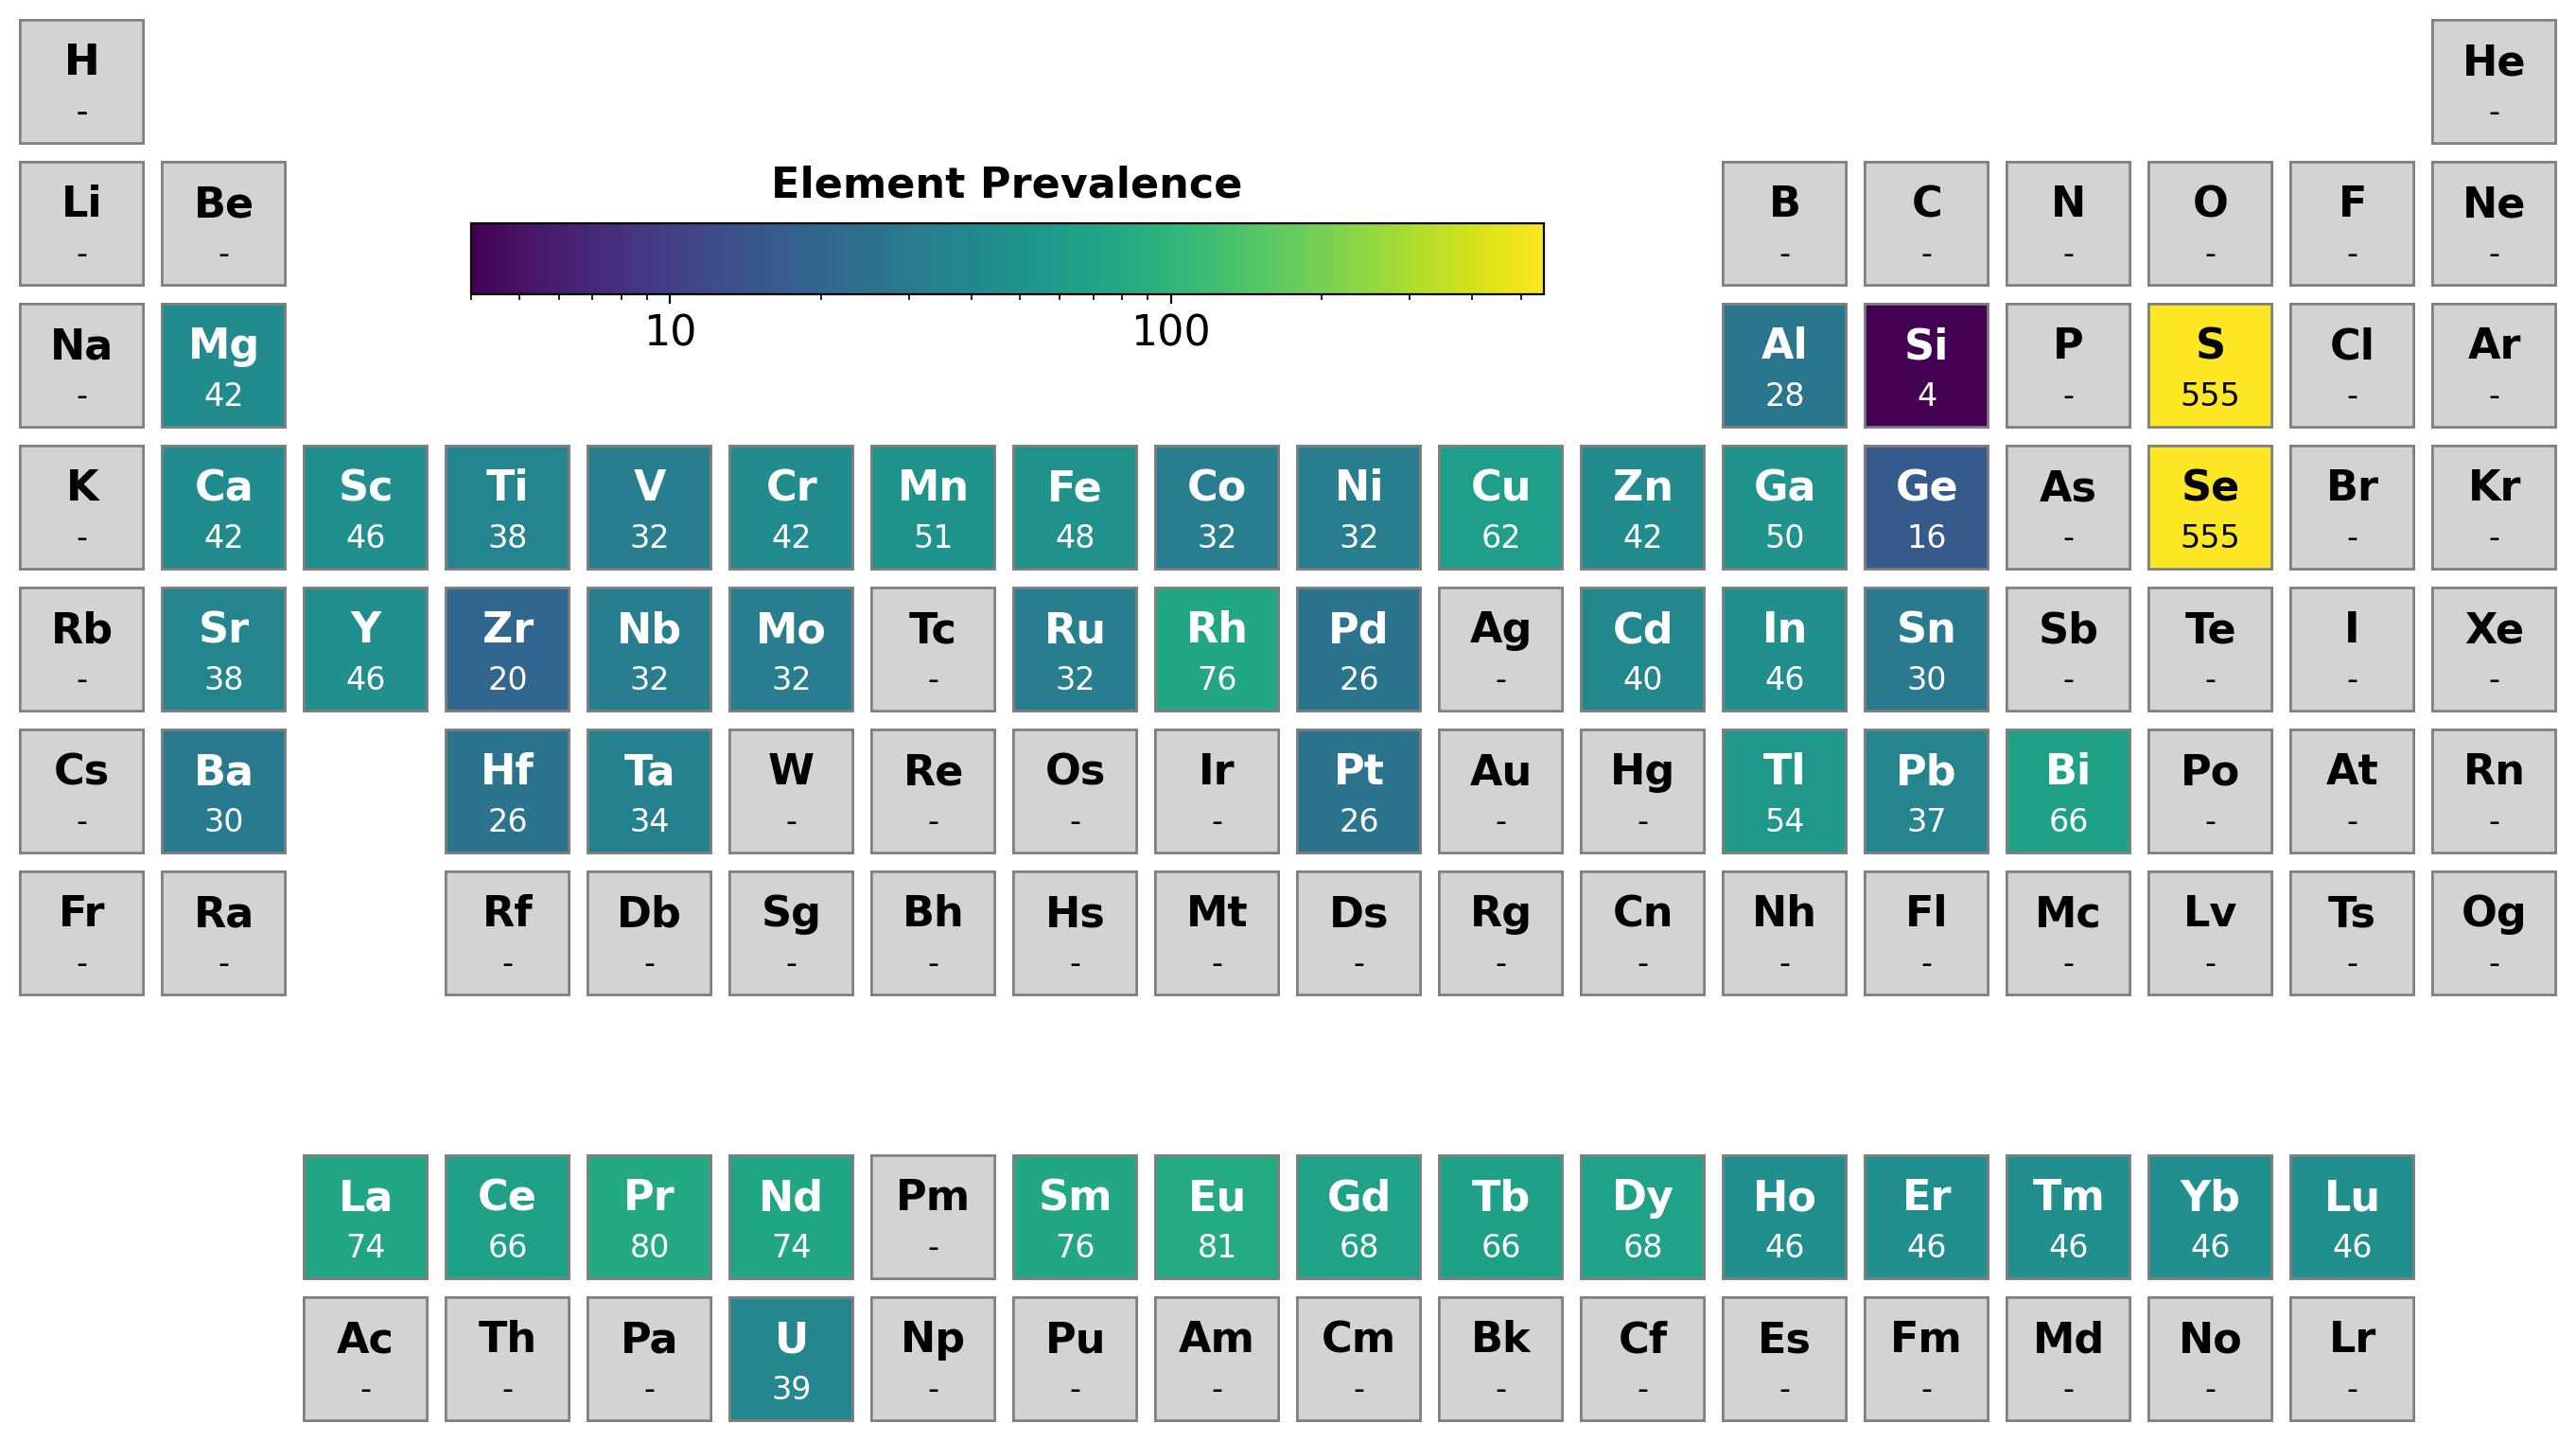

According to t_sisso_58, 123 (10.585197934595525%) compositions are predicted to be stable as perovskites:
['BaCeS3', 'BaUS3', 'EuUS3', 'EuUSe3', 'EuInS3', 'EuInSe3', 'PbPrS3', 'PbCeS3', 'PbUS3', 'SrPrS3', 'SrCeS3', 'SrUS3', 'SrUSe3', 'CaPrS3', 'CaPrSe3', 'CaCeSe3', 'SnTbS3', 'SnTbSe3', 'CdPrS3', 'CdPrSe3', 'CdCeSe3', 'CuScSe3', 'CuTbS3', 'CuTbSe3', 'CuFeS3', 'CuFeSe3', 'MgVS3', 'MgVSe3', 'MgRhS3', 'MgRhSe3', 'MgTiS3', 'MgTiSe3', 'MgRuS3', 'MgRuSe3', 'MgMoS3', 'MgMoSe3', 'MgTaS3', 'MgTaSe3', 'MgNbS3', 'MgNbSe3', 'MgPtS3', 'MgPtSe3', 'MgPdS3', 'MgPdSe3', 'MgCrSe3', 'ZnVS3', 'ZnVSe3', 'ZnRhS3', 'ZnRhSe3', 'ZnTiS3', 'ZnTiSe3', 'ZnRuS3', 'ZnRuSe3', 'ZnMoS3', 'ZnMoSe3', 'ZnTaS3', 'ZnTaSe3', 'ZnNbS3', 'ZnNbSe3', 'ZnHfSe3', 'ZnPtS3', 'ZnPtSe3', 'ZnPdS3', 'ZnPdSe3', 'LaYbS3', 'LaYbSe3', 'LaErSe3', 'LaTmSe3', 'LaLuS3', 'LaLuSe3', 'LaTlSe3', 'PrYbSe3', 'PrLuSe3', 'CeYbSe3', 'CeTmSe3', 'CeLuS3', 'CeLuSe3', 'NdLuSe3', 'NdInS3', 'BiYbS3', 'BiYbSe3', 'GdInS3', 'GdInSe3', 'SmInS3', 'SmInSe3', 'BiYSe3

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


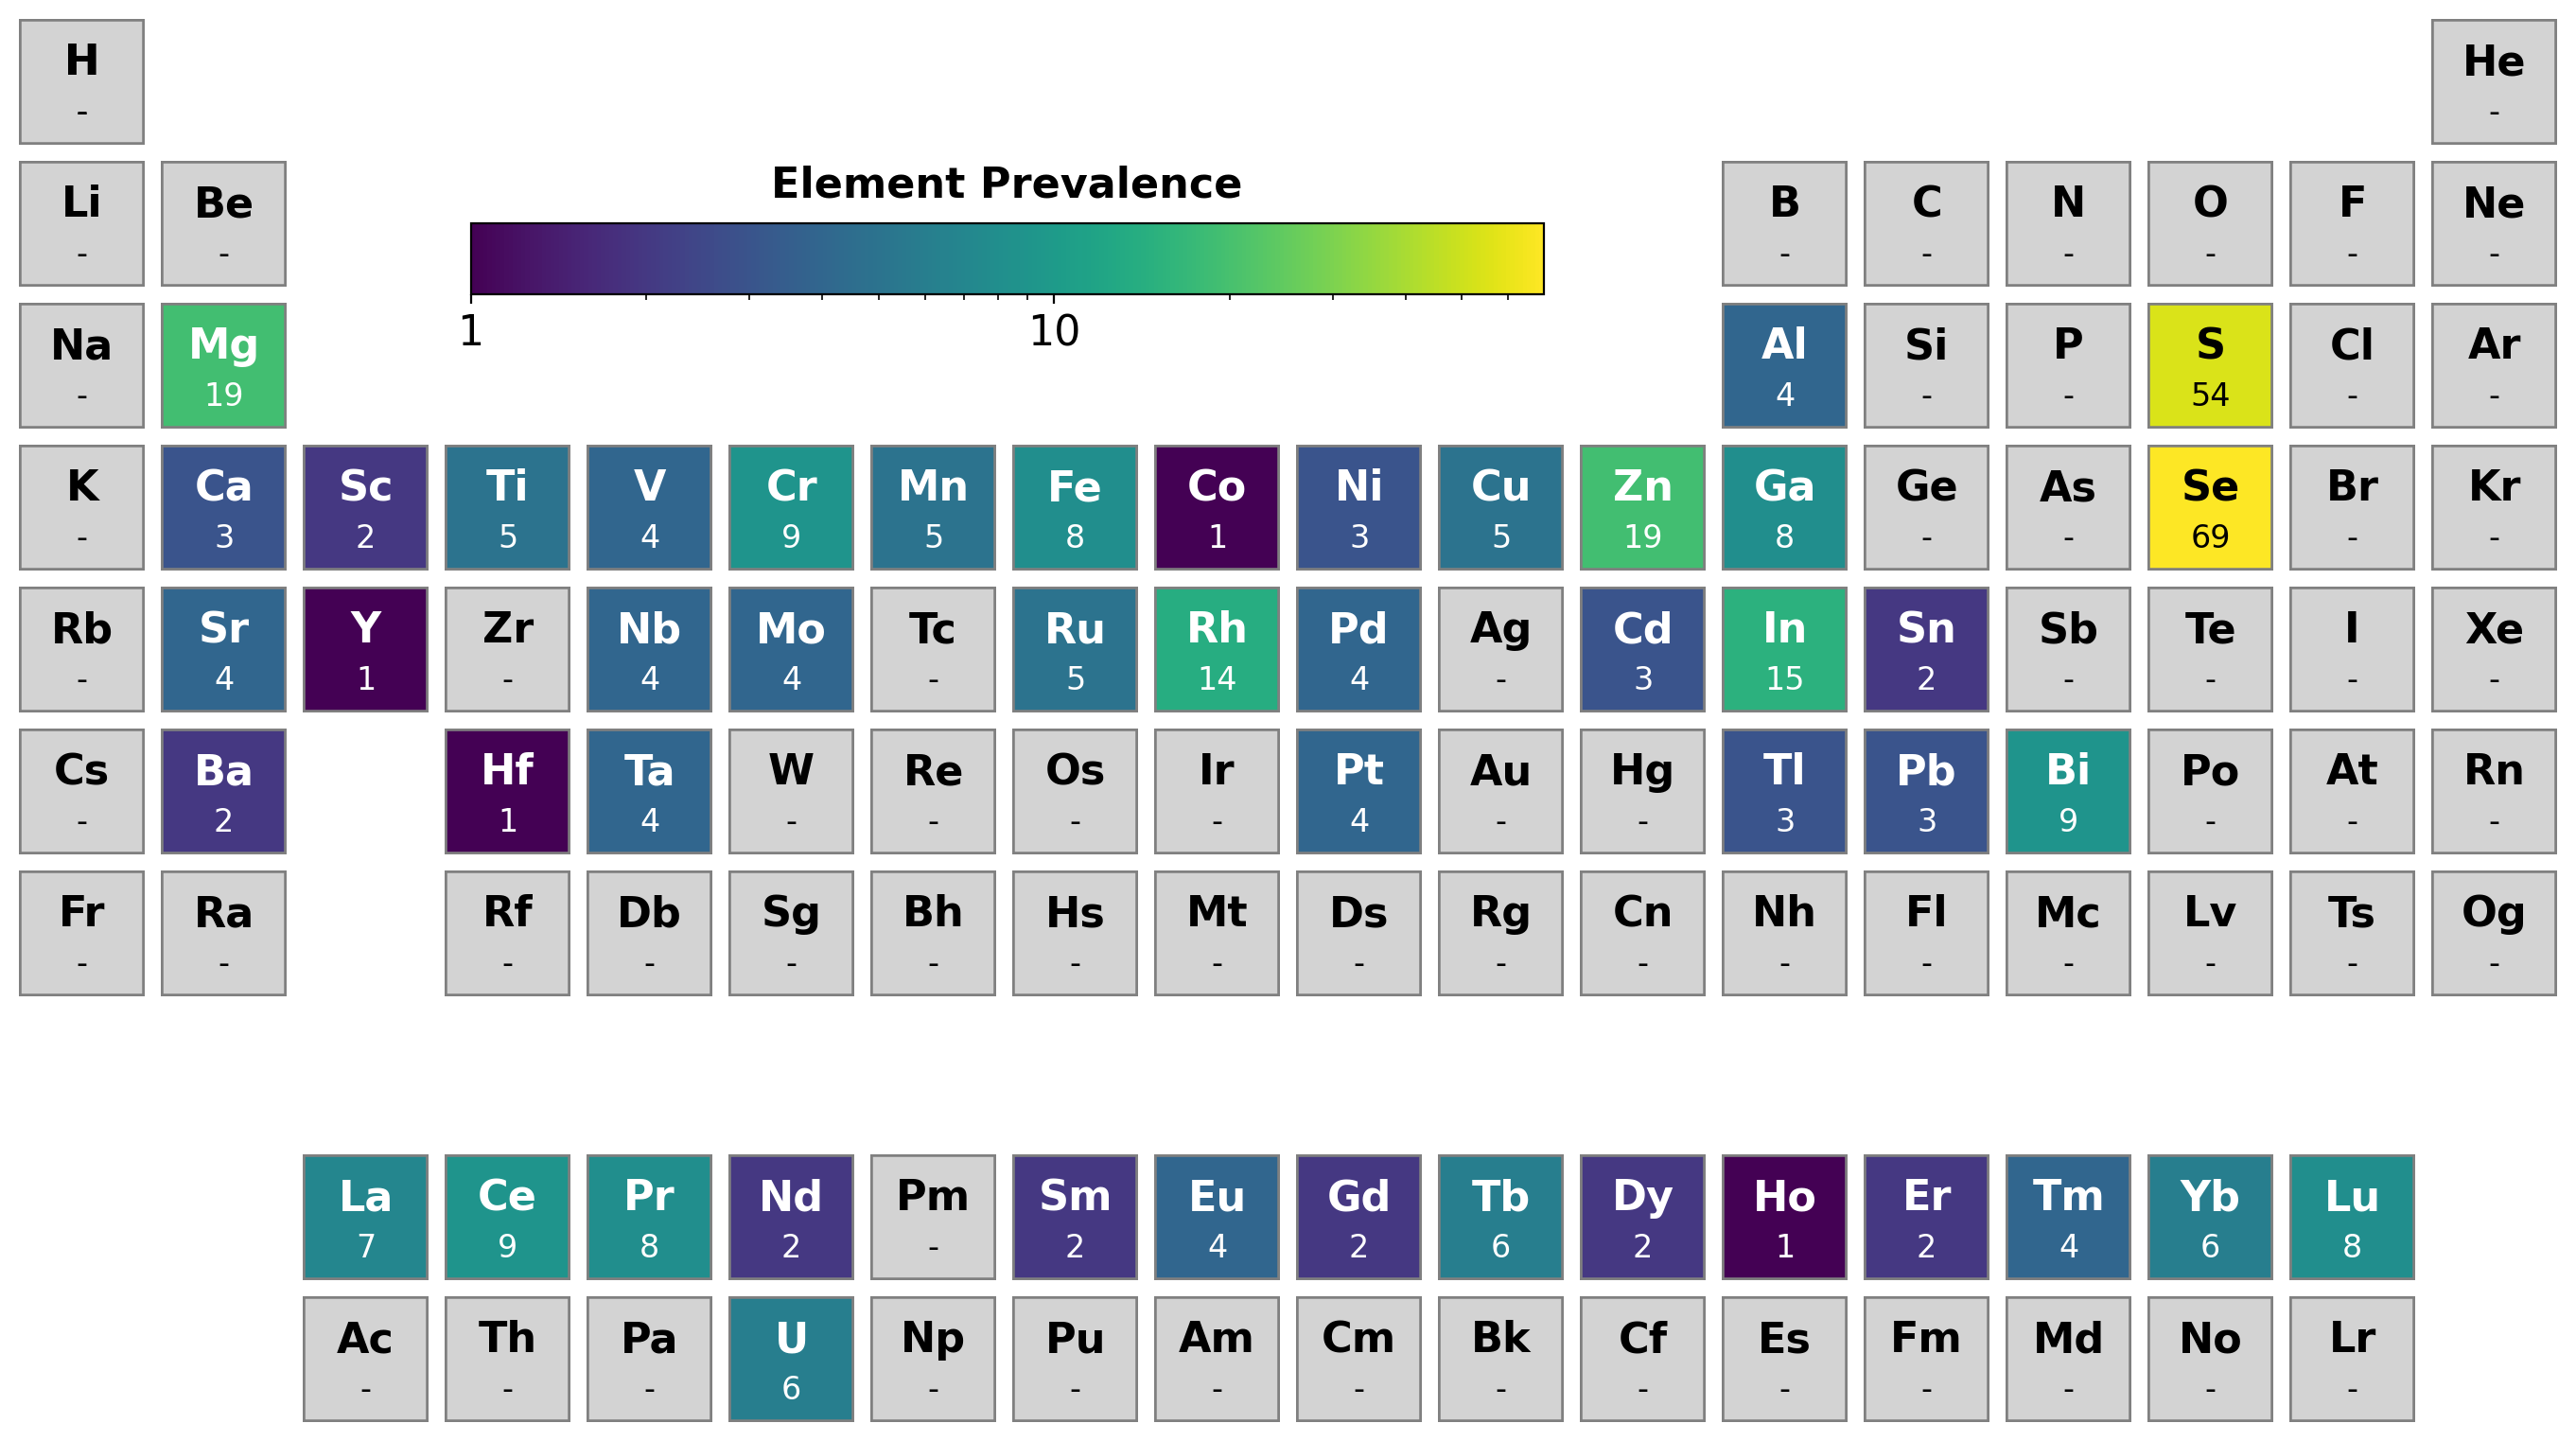

According to t_sisso_39, 1149 (98.88123924268503%) compositions are predicted to be stable as perovskites:
['BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaPrSe3', 'BaCeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuSiSe3', 'EuVS3', 'EuVSe3', 'EuRhS3', 'EuRhSe3', 'EuT

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


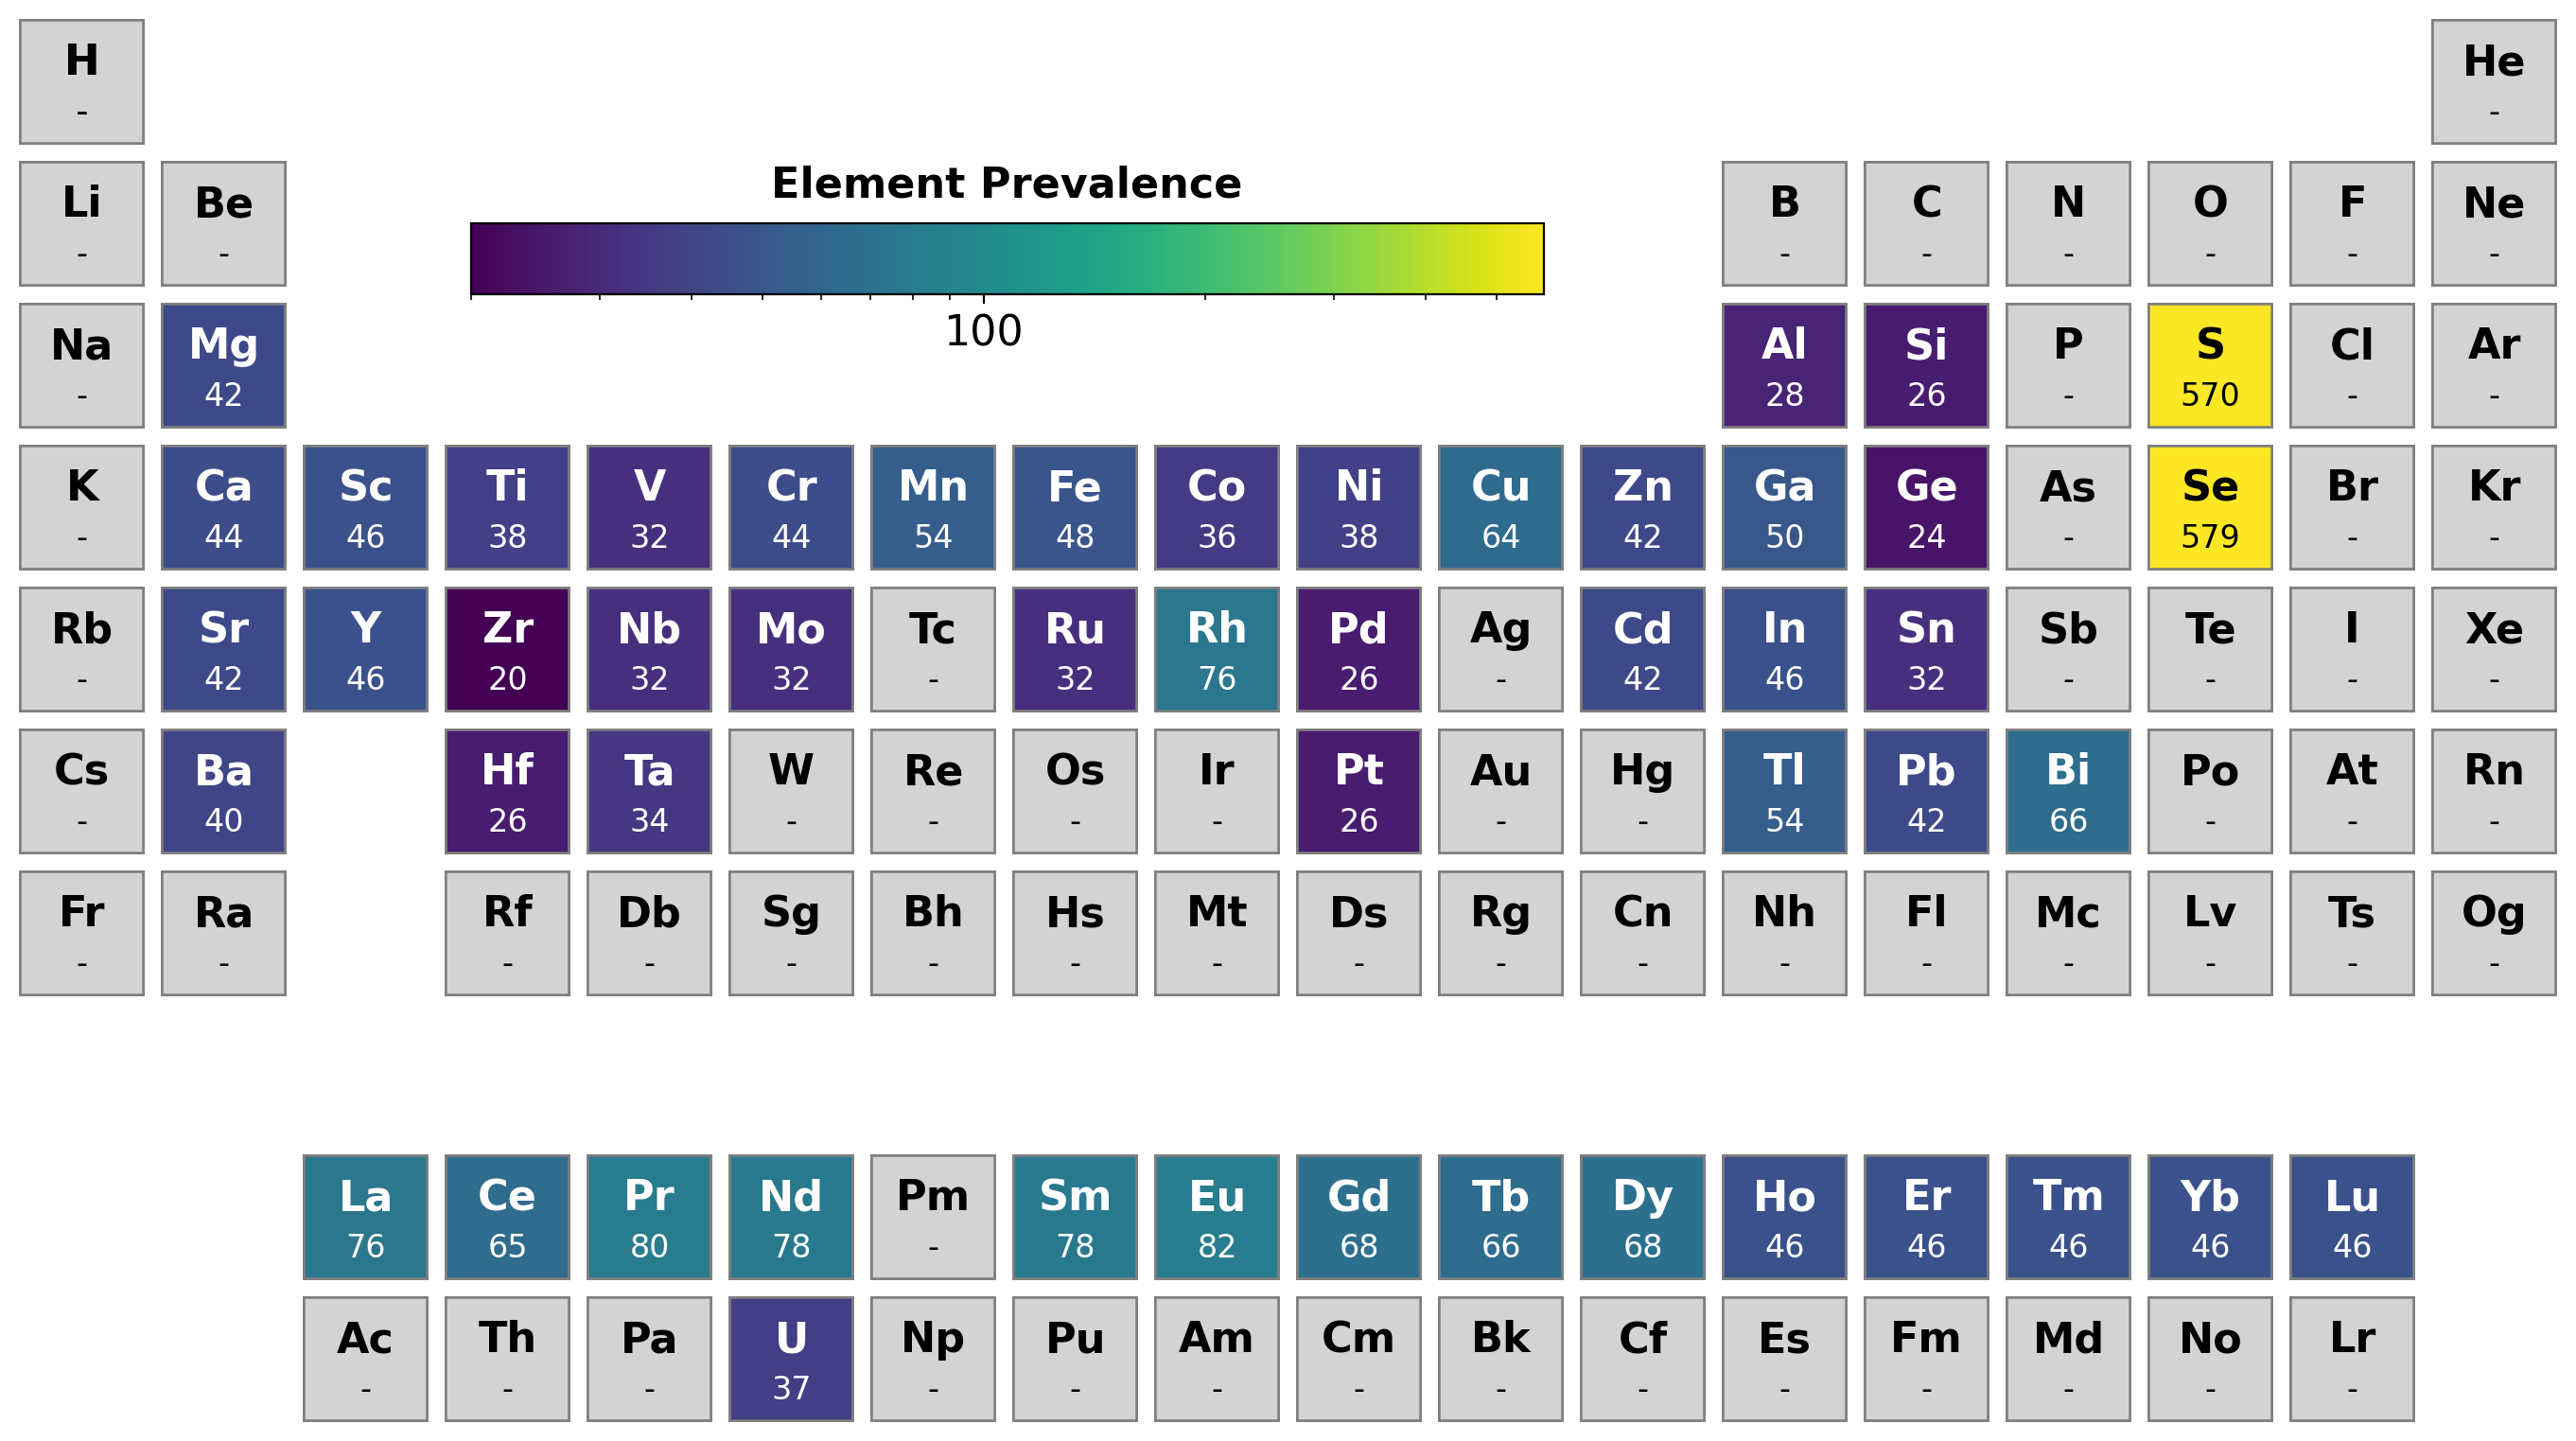

According to t_sisso_212, 1110 (95.5249569707401%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaPrSe3', 'BaCeSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaPdS3', 'BaPdSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuVS3', 'EuVSe3', 'EuRhS3', 'EuRhSe3', 'EuTiS3', 'EuTiSe3', 'EuRuS3', 'EuRuSe3', 'EuMoS3', 'EuMoSe3', 'EuTaS3', 'EuTaSe3', 'EuNbS3', 'EuNbSe3', 'EuHfS3', 'EuHfSe3', 'EuZr

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


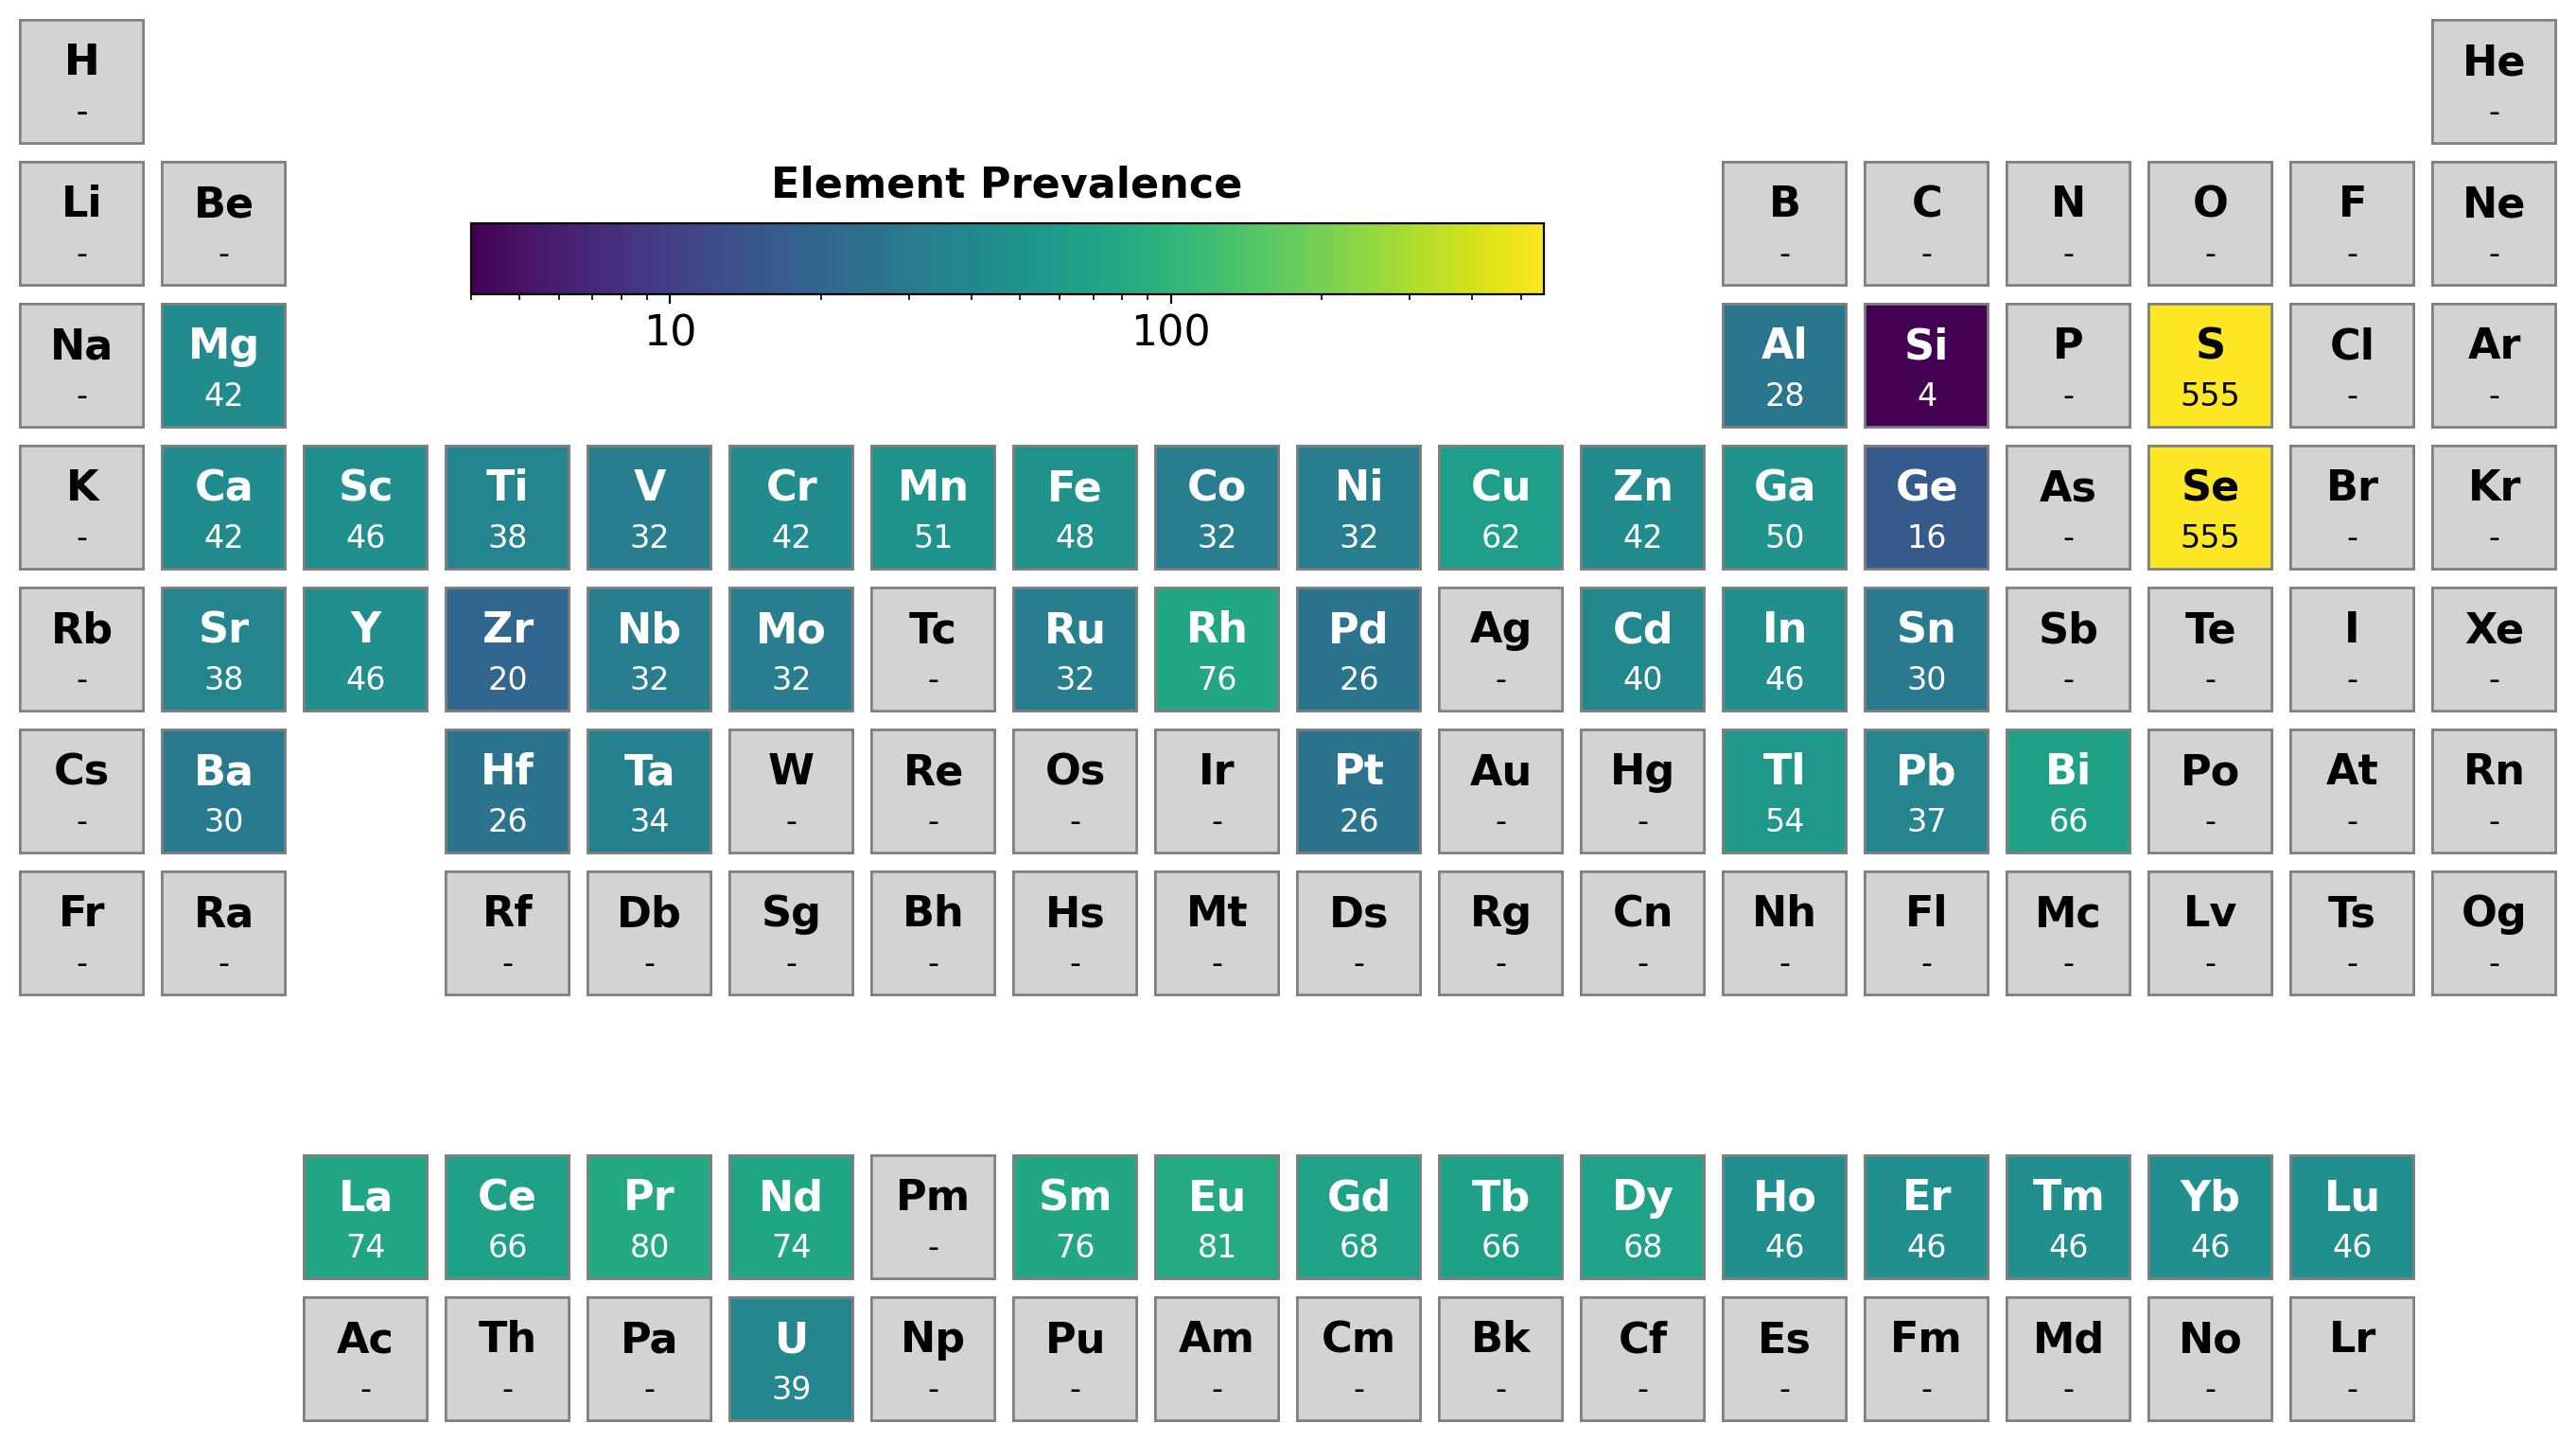

According to t_sisso_223, 1110 (95.5249569707401%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaPrSe3', 'BaCeSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaPdS3', 'BaPdSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuVS3', 'EuVSe3', 'EuRhS3', 'EuRhSe3', 'EuTiS3', 'EuTiSe3', 'EuRuS3', 'EuRuSe3', 'EuMoS3', 'EuMoSe3', 'EuTaS3', 'EuTaSe3', 'EuNbS3', 'EuNbSe3', 'EuHfS3', 'EuHfSe3', 'EuZr

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


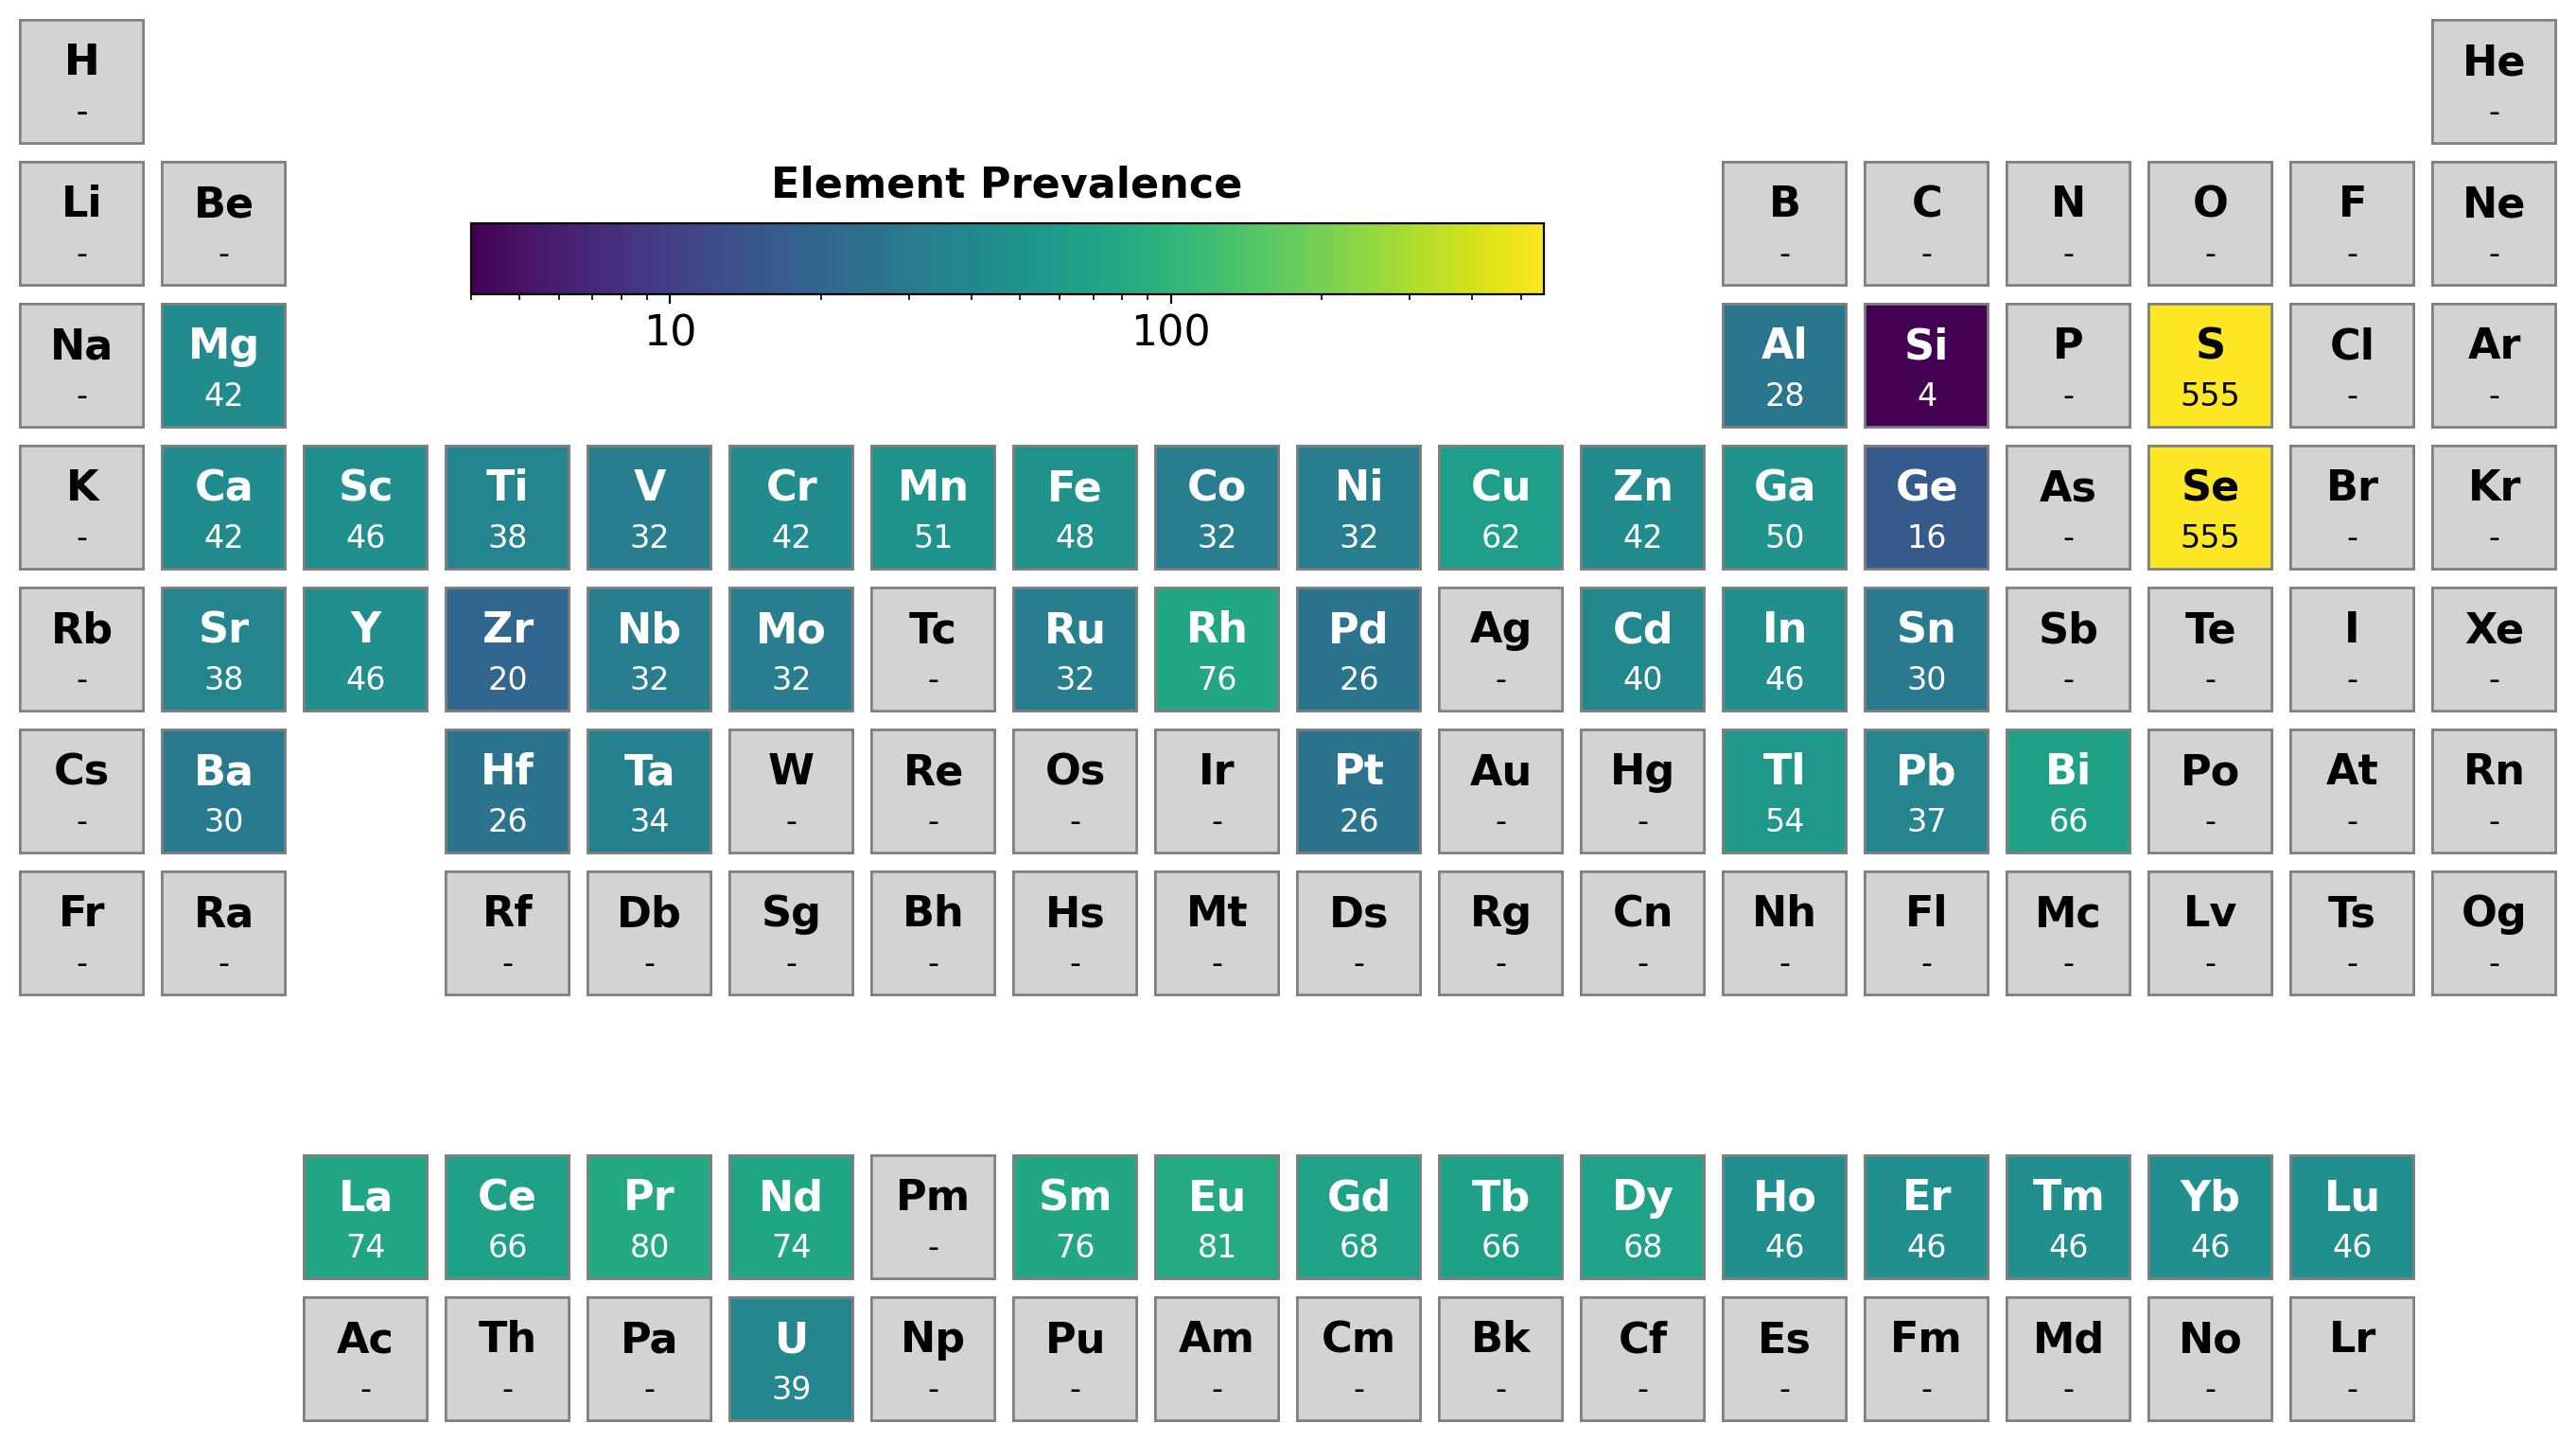

According to t_sisso_51, 123 (10.585197934595525%) compositions are predicted to be stable as perovskites:
['BaCeS3', 'BaUS3', 'EuUS3', 'EuUSe3', 'EuInS3', 'EuInSe3', 'PbPrS3', 'PbCeS3', 'PbUS3', 'SrPrS3', 'SrCeS3', 'SrUS3', 'SrUSe3', 'CaPrS3', 'CaPrSe3', 'CaCeSe3', 'SnTbS3', 'SnTbSe3', 'CdPrS3', 'CdPrSe3', 'CdCeSe3', 'CuScSe3', 'CuTbS3', 'CuTbSe3', 'CuFeS3', 'CuFeSe3', 'MgVS3', 'MgVSe3', 'MgRhS3', 'MgRhSe3', 'MgTiS3', 'MgTiSe3', 'MgRuS3', 'MgRuSe3', 'MgMoS3', 'MgMoSe3', 'MgTaS3', 'MgTaSe3', 'MgNbS3', 'MgNbSe3', 'MgPtS3', 'MgPtSe3', 'MgPdS3', 'MgPdSe3', 'MgCrSe3', 'ZnVS3', 'ZnVSe3', 'ZnRhS3', 'ZnRhSe3', 'ZnTiS3', 'ZnTiSe3', 'ZnRuS3', 'ZnRuSe3', 'ZnMoS3', 'ZnMoSe3', 'ZnTaS3', 'ZnTaSe3', 'ZnNbS3', 'ZnNbSe3', 'ZnHfSe3', 'ZnPtS3', 'ZnPtSe3', 'ZnPdS3', 'ZnPdSe3', 'LaYbS3', 'LaYbSe3', 'LaErSe3', 'LaTmSe3', 'LaLuS3', 'LaLuSe3', 'LaTlSe3', 'PrYbSe3', 'PrLuSe3', 'CeYbSe3', 'CeTmSe3', 'CeLuS3', 'CeLuSe3', 'NdLuSe3', 'NdInS3', 'BiYbS3', 'BiYbSe3', 'GdInS3', 'GdInSe3', 'SmInS3', 'SmInSe3', 'BiYSe3

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


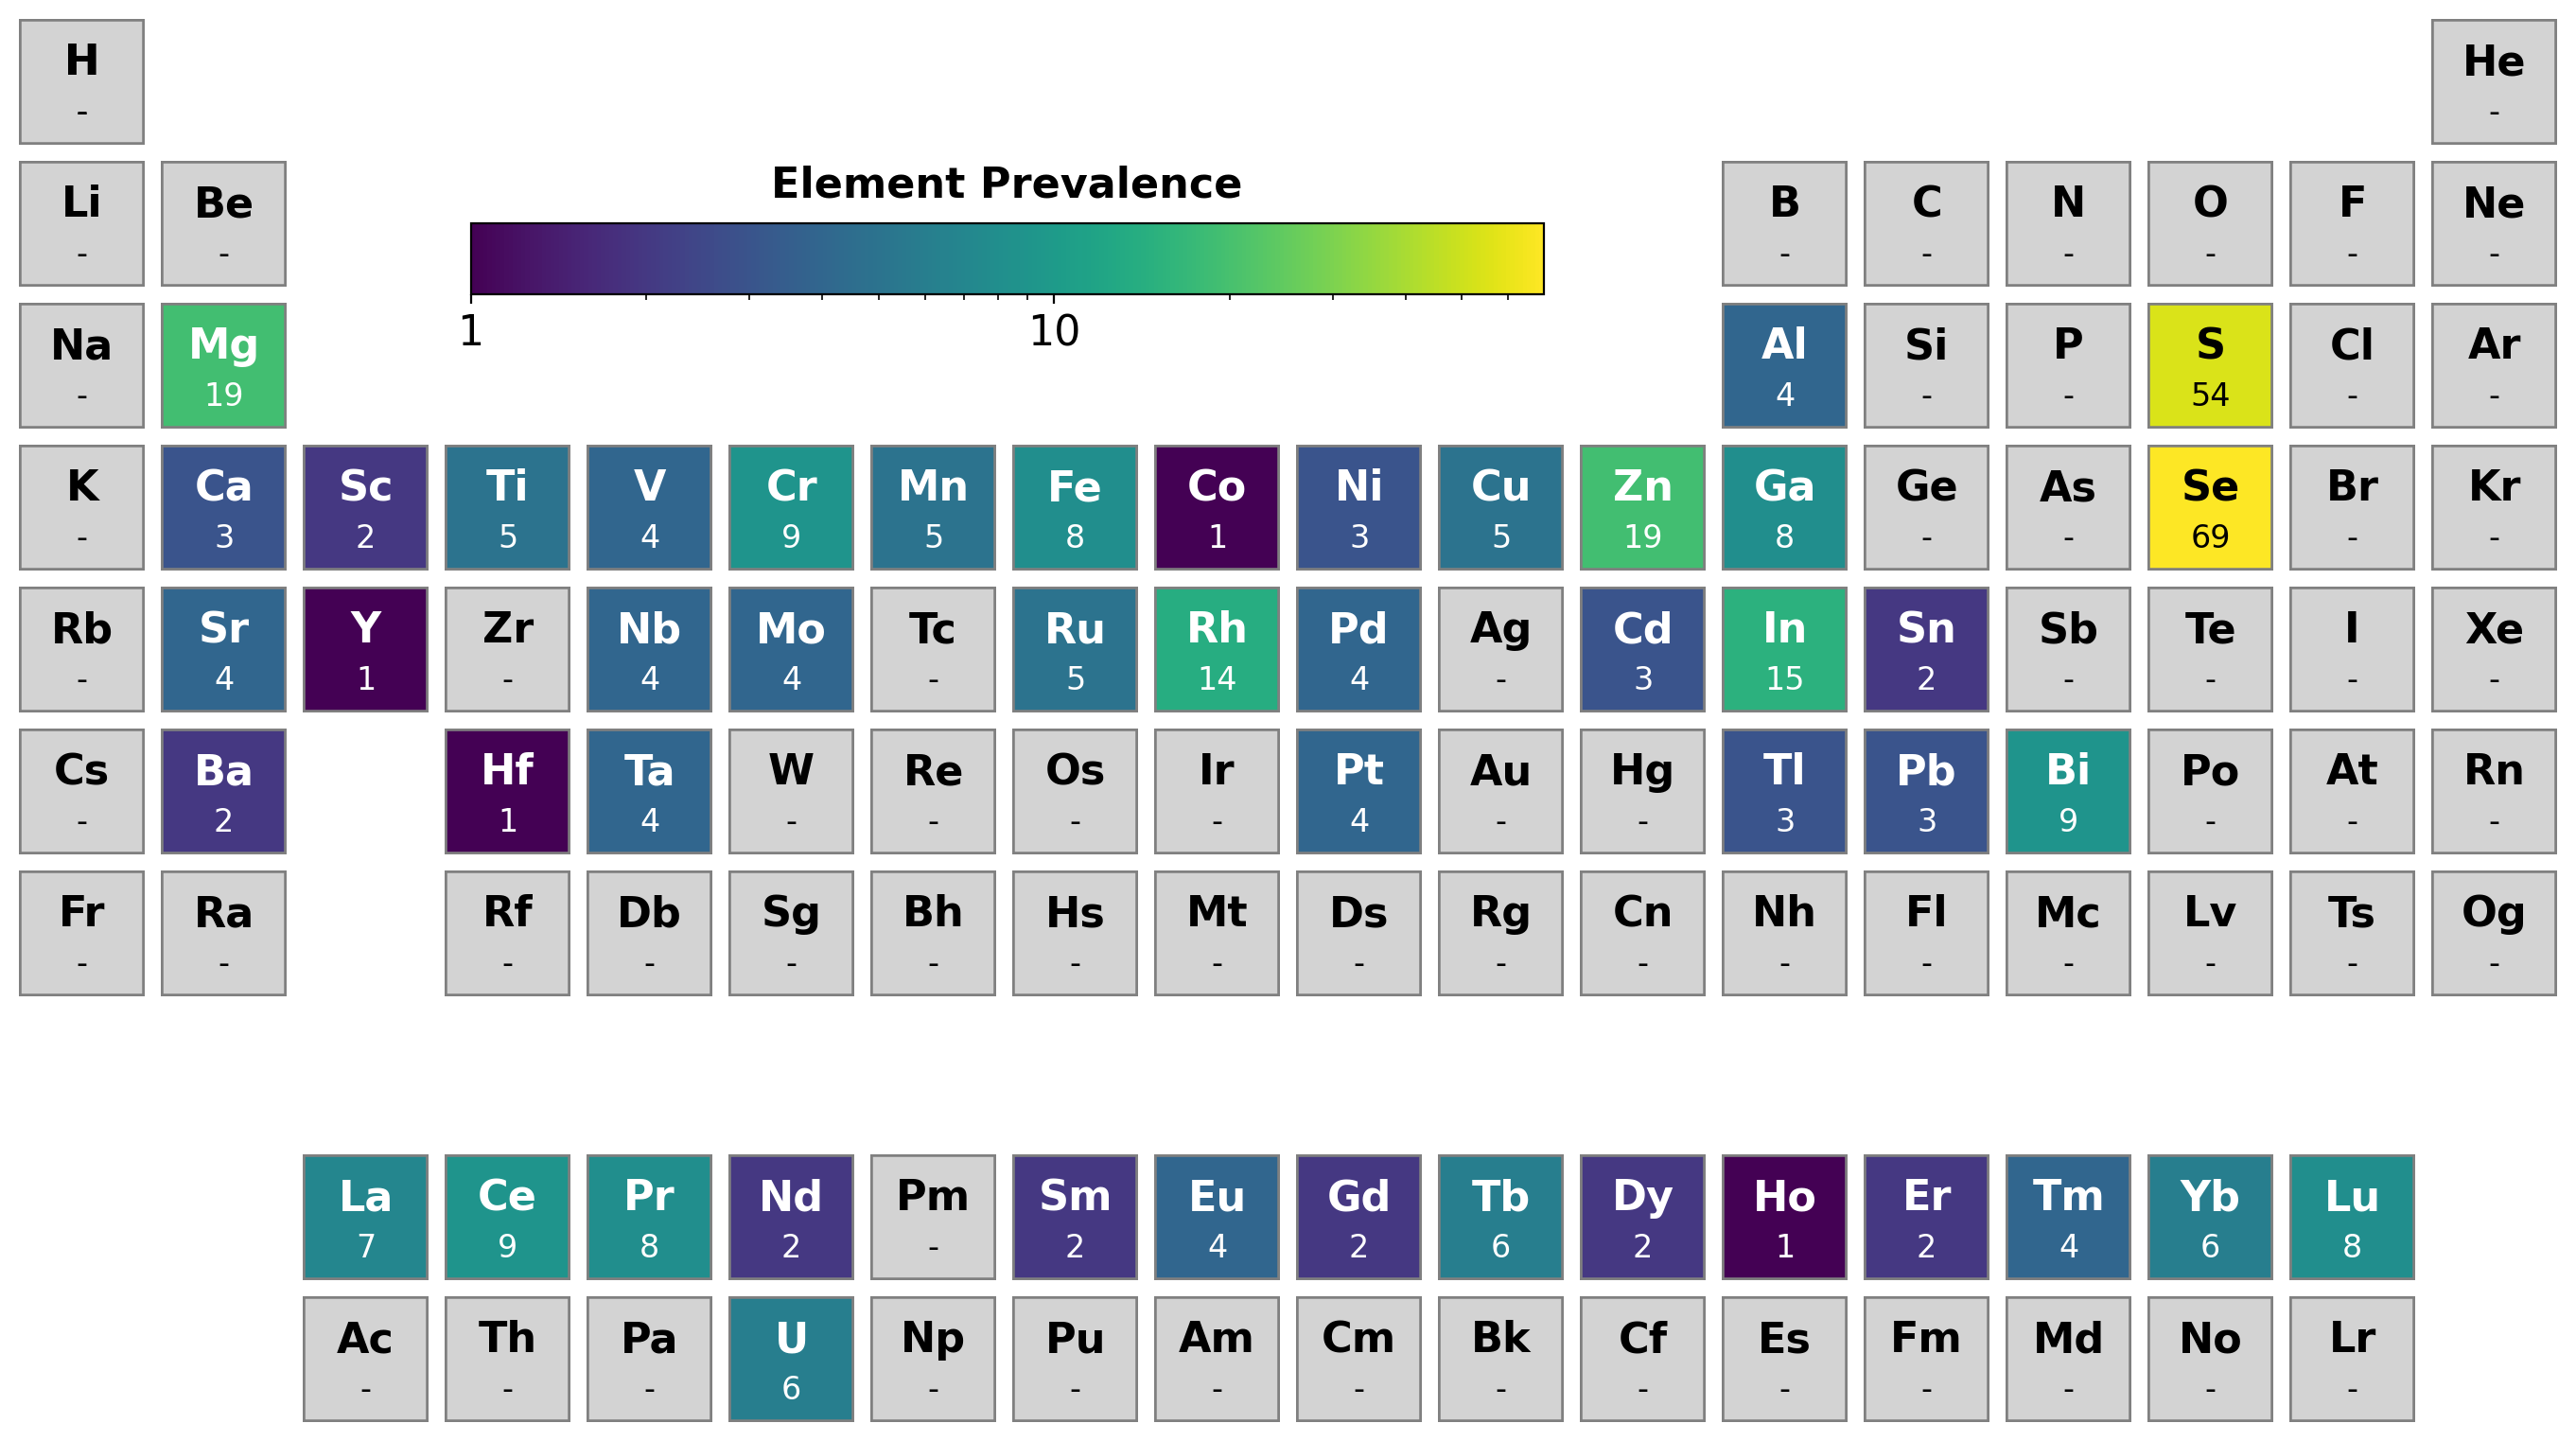

According to t_sisso_46, 123 (10.585197934595525%) compositions are predicted to be stable as perovskites:
['BaCeS3', 'BaUS3', 'EuUS3', 'EuUSe3', 'EuInS3', 'EuInSe3', 'PbPrS3', 'PbCeS3', 'PbUS3', 'SrPrS3', 'SrCeS3', 'SrUS3', 'SrUSe3', 'CaPrS3', 'CaPrSe3', 'CaCeSe3', 'SnTbS3', 'SnTbSe3', 'CdPrS3', 'CdPrSe3', 'CdCeSe3', 'CuScSe3', 'CuTbS3', 'CuTbSe3', 'CuFeS3', 'CuFeSe3', 'MgVS3', 'MgVSe3', 'MgRhS3', 'MgRhSe3', 'MgTiS3', 'MgTiSe3', 'MgRuS3', 'MgRuSe3', 'MgMoS3', 'MgMoSe3', 'MgTaS3', 'MgTaSe3', 'MgNbS3', 'MgNbSe3', 'MgPtS3', 'MgPtSe3', 'MgPdS3', 'MgPdSe3', 'MgCrSe3', 'ZnVS3', 'ZnVSe3', 'ZnRhS3', 'ZnRhSe3', 'ZnTiS3', 'ZnTiSe3', 'ZnRuS3', 'ZnRuSe3', 'ZnMoS3', 'ZnMoSe3', 'ZnTaS3', 'ZnTaSe3', 'ZnNbS3', 'ZnNbSe3', 'ZnHfSe3', 'ZnPtS3', 'ZnPtSe3', 'ZnPdS3', 'ZnPdSe3', 'LaYbS3', 'LaYbSe3', 'LaErSe3', 'LaTmSe3', 'LaLuS3', 'LaLuSe3', 'LaTlSe3', 'PrYbSe3', 'PrLuSe3', 'CeYbSe3', 'CeTmSe3', 'CeLuS3', 'CeLuSe3', 'NdLuSe3', 'NdInS3', 'BiYbS3', 'BiYbSe3', 'GdInS3', 'GdInSe3', 'SmInS3', 'SmInSe3', 'BiYSe3

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


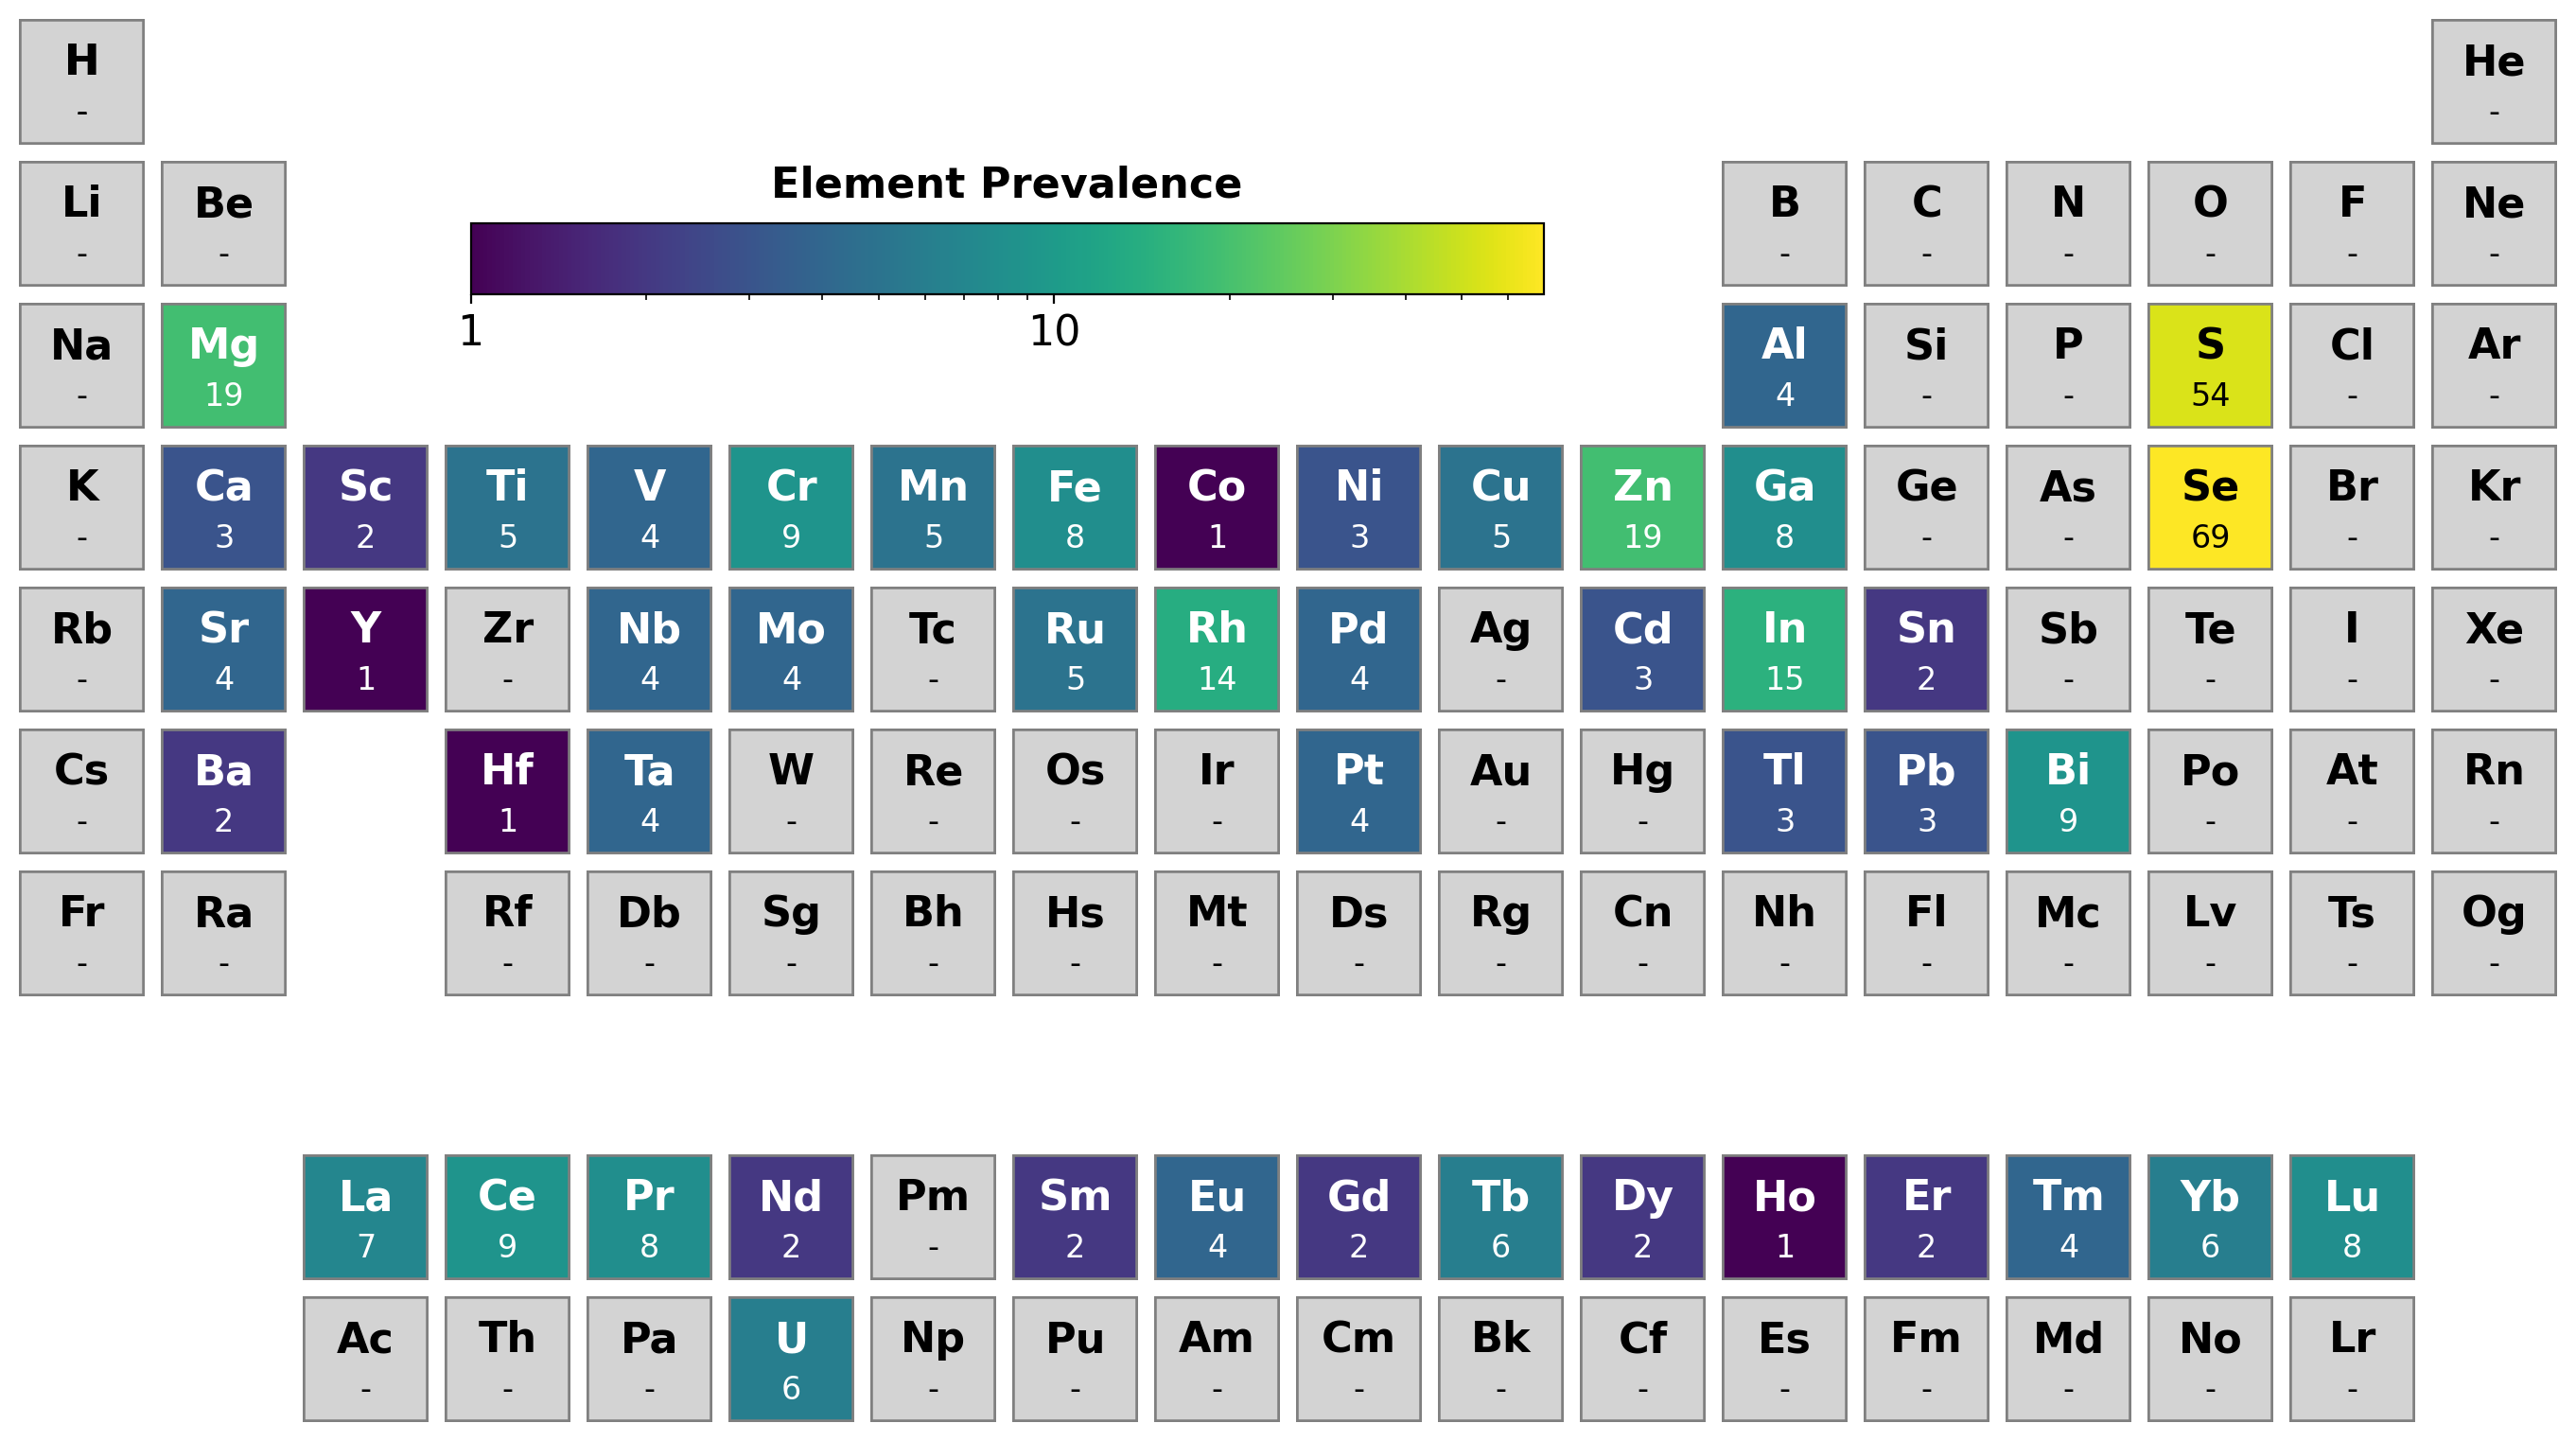

According to t_sisso_181, 851 (73.23580034423408%) compositions are predicted to be stable as perovskites:
['BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuSiSe3', 'EuVS3', 'EuVSe3', 'EuTiS3', 'EuTiSe3', 'EuRuS3', 'EuRuSe3', 'EuTaS3', 'EuTaSe3', 'EuNbS3', 'EuNbSe3', 'EuHf

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


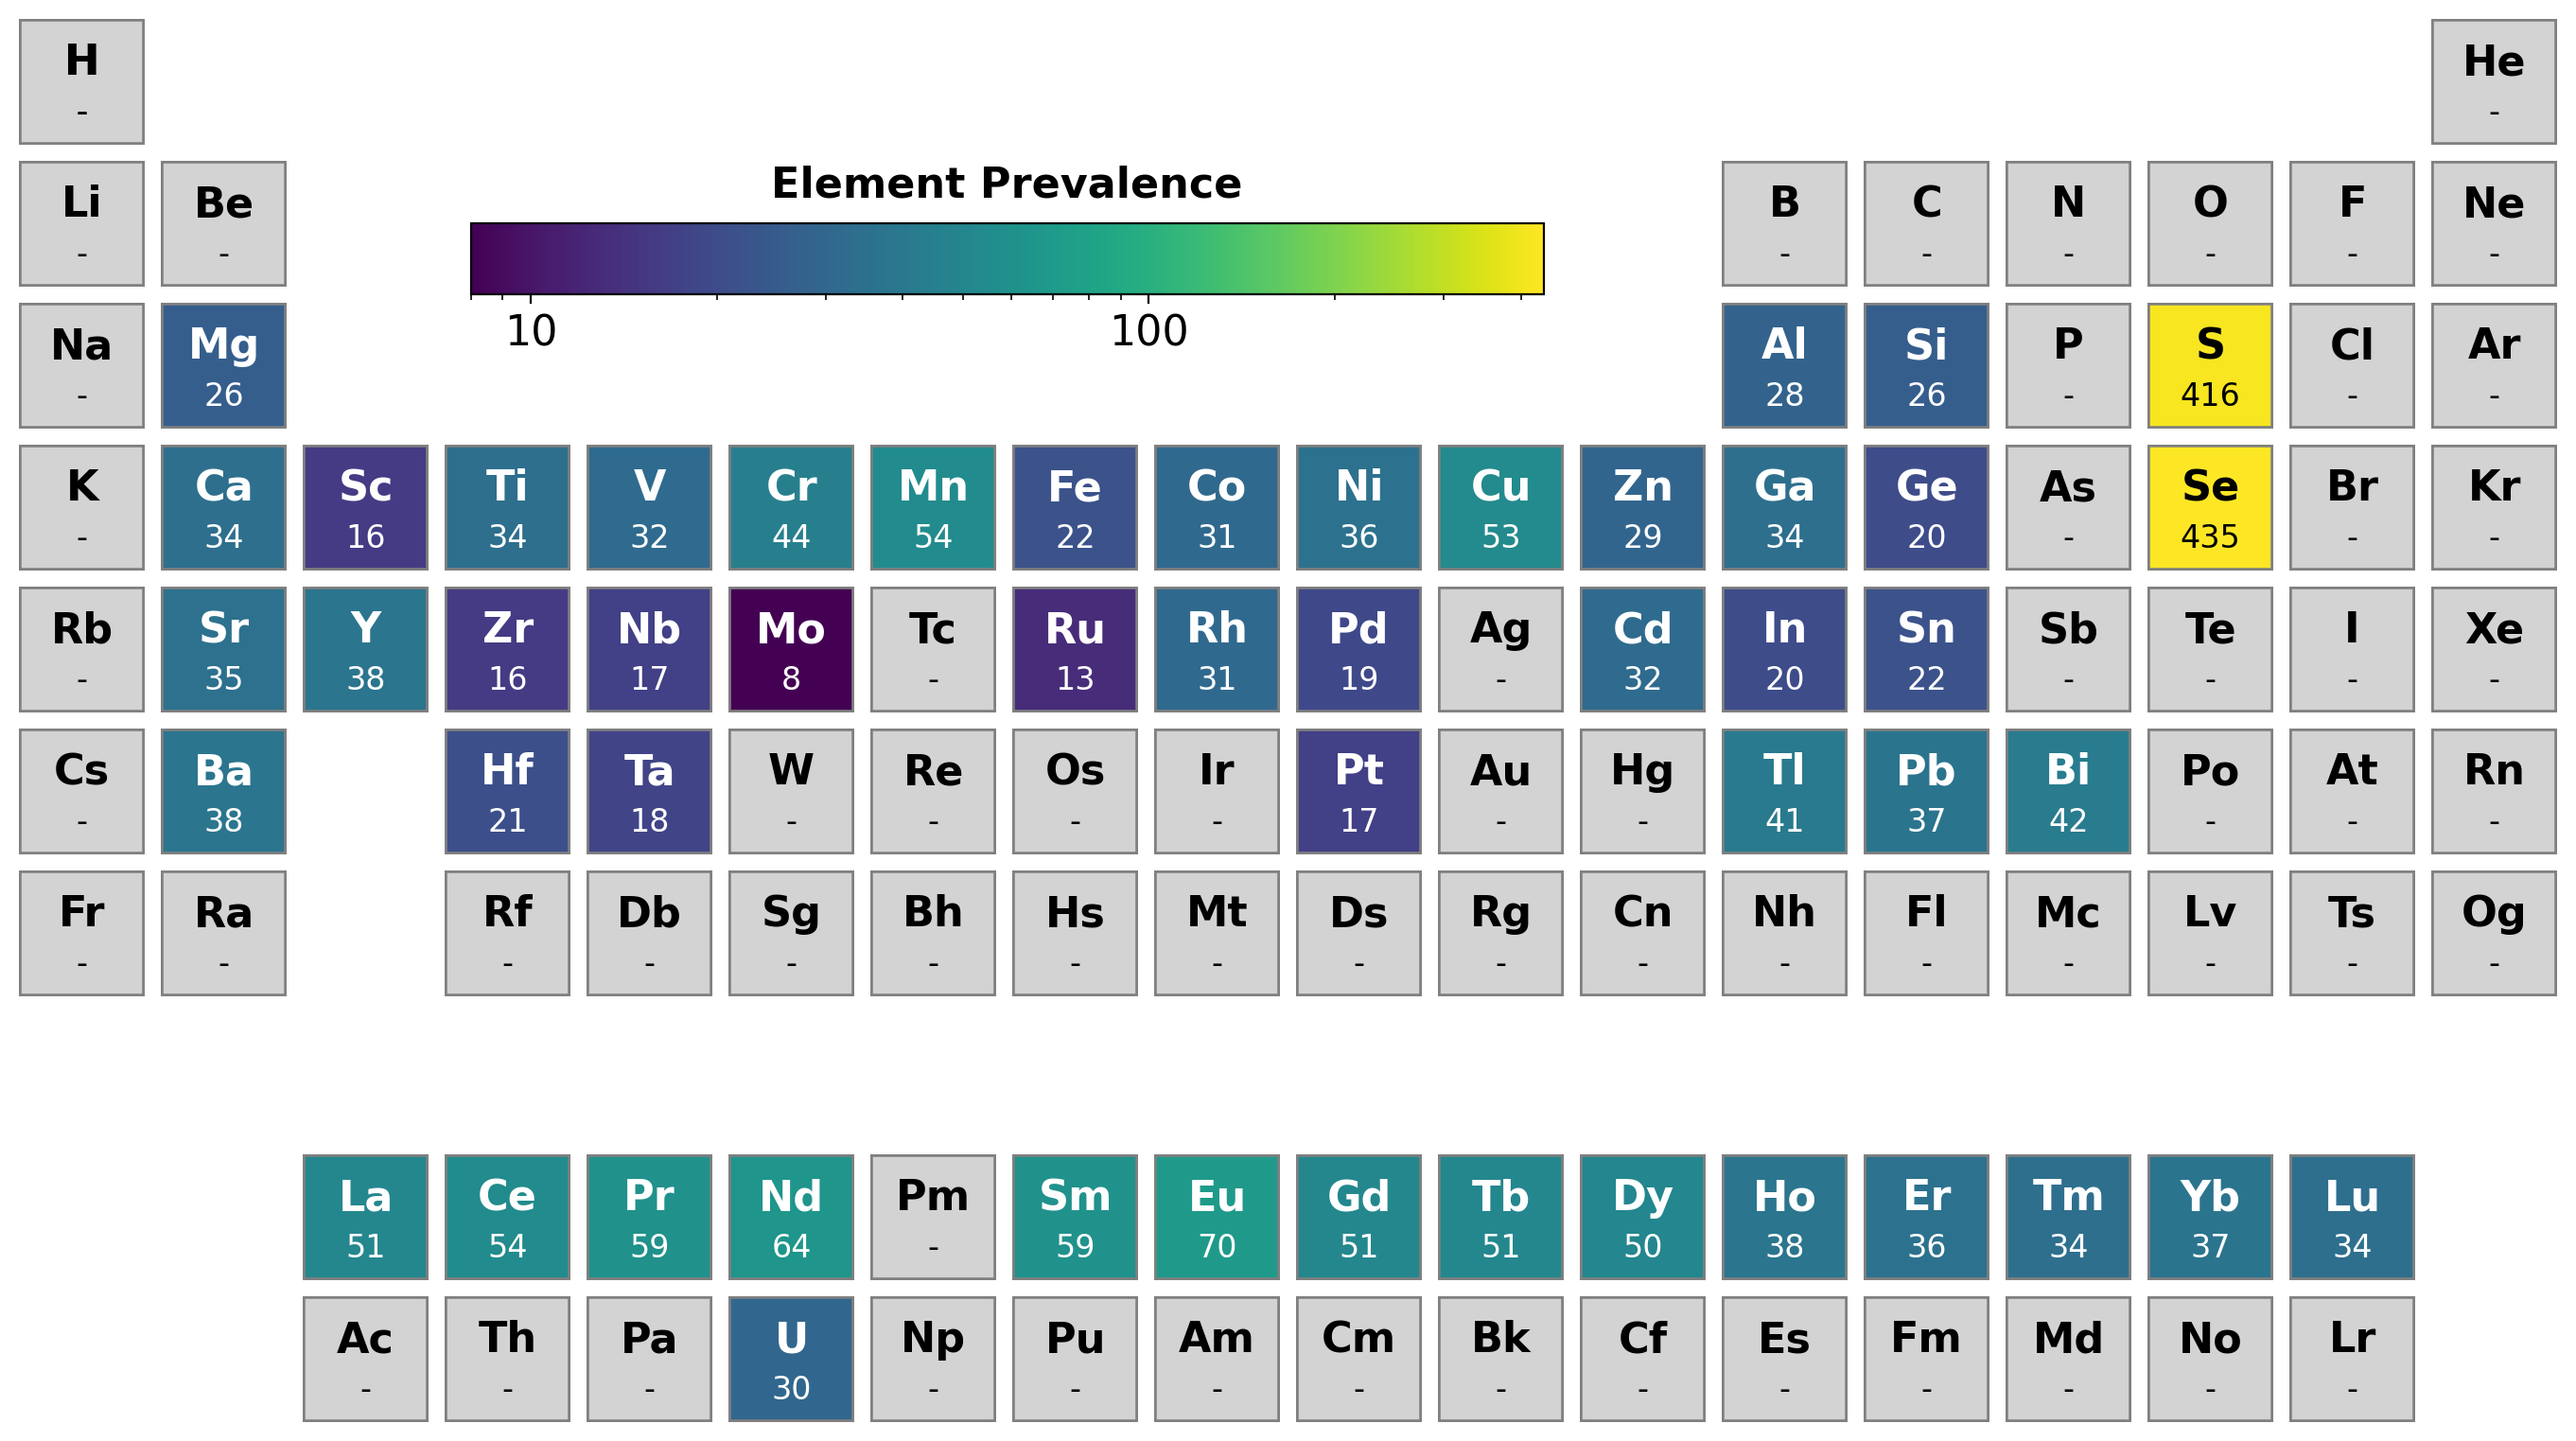

According to t_sisso_23, 506 (43.54561101549053%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaPrS3', 'BaPrSe3', 'BaCeS3', 'BaCeSe3', 'BaHfS3', 'BaZrS3', 'BaTbS3', 'BaTbSe3', 'BaUS3', 'BaUSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuYbSe3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuRhS3', 'EuRhSe3', 'EuMoS3', 'EuMoSe3', 'EuTaS3', 'EuNbS3', 'EuHfS3', 'EuHfSe3', 'EuZrS3', 'EuZrSe3', 'EuUS3', 'EuUSe3', 'EuNiS3', 'EuNiSe3', 'EuCoS3', 'EuCoSe3', 'EuGaS3', 'EuGaSe3', 'EuFeS3', 'EuFeSe3', 'EuCrS3', 'EuCrSe3', 'EuInS3', 'EuInSe3', 'EuMnS3', 'EuMnSe3', 'PbSnS3', 'PbPrS3', 'PbPrSe3', 'PbCeS3', 'PbCeSe3', 'PbHfS3', 'PbHfSe3', 'PbZrS3', 'PbZrSe3', 'PbTbS3', 'PbTbSe3', 'PbUS3', 'PbUSe3', 'SrSnS3', 'SrPrS3', 'SrPrSe3', 'SrCeS3', 'SrCeSe3', 'SrTaS3', 'SrNbS3', 'SrHfS3', 'SrHfSe3', 'SrZrS3', 'SrZrSe3', 'SrTbS3', 'SrTbSe3', 'SrUS3', 'SrUSe3', 'CaSnS3', 'CaSnSe3', 'CaPrS3', 'CaPrSe3', 'CaCeSe3', 'CaMoS3', 'CaMoSe3', 'CaTaS3', 'CaTaSe3', 'CaNbS3', '

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


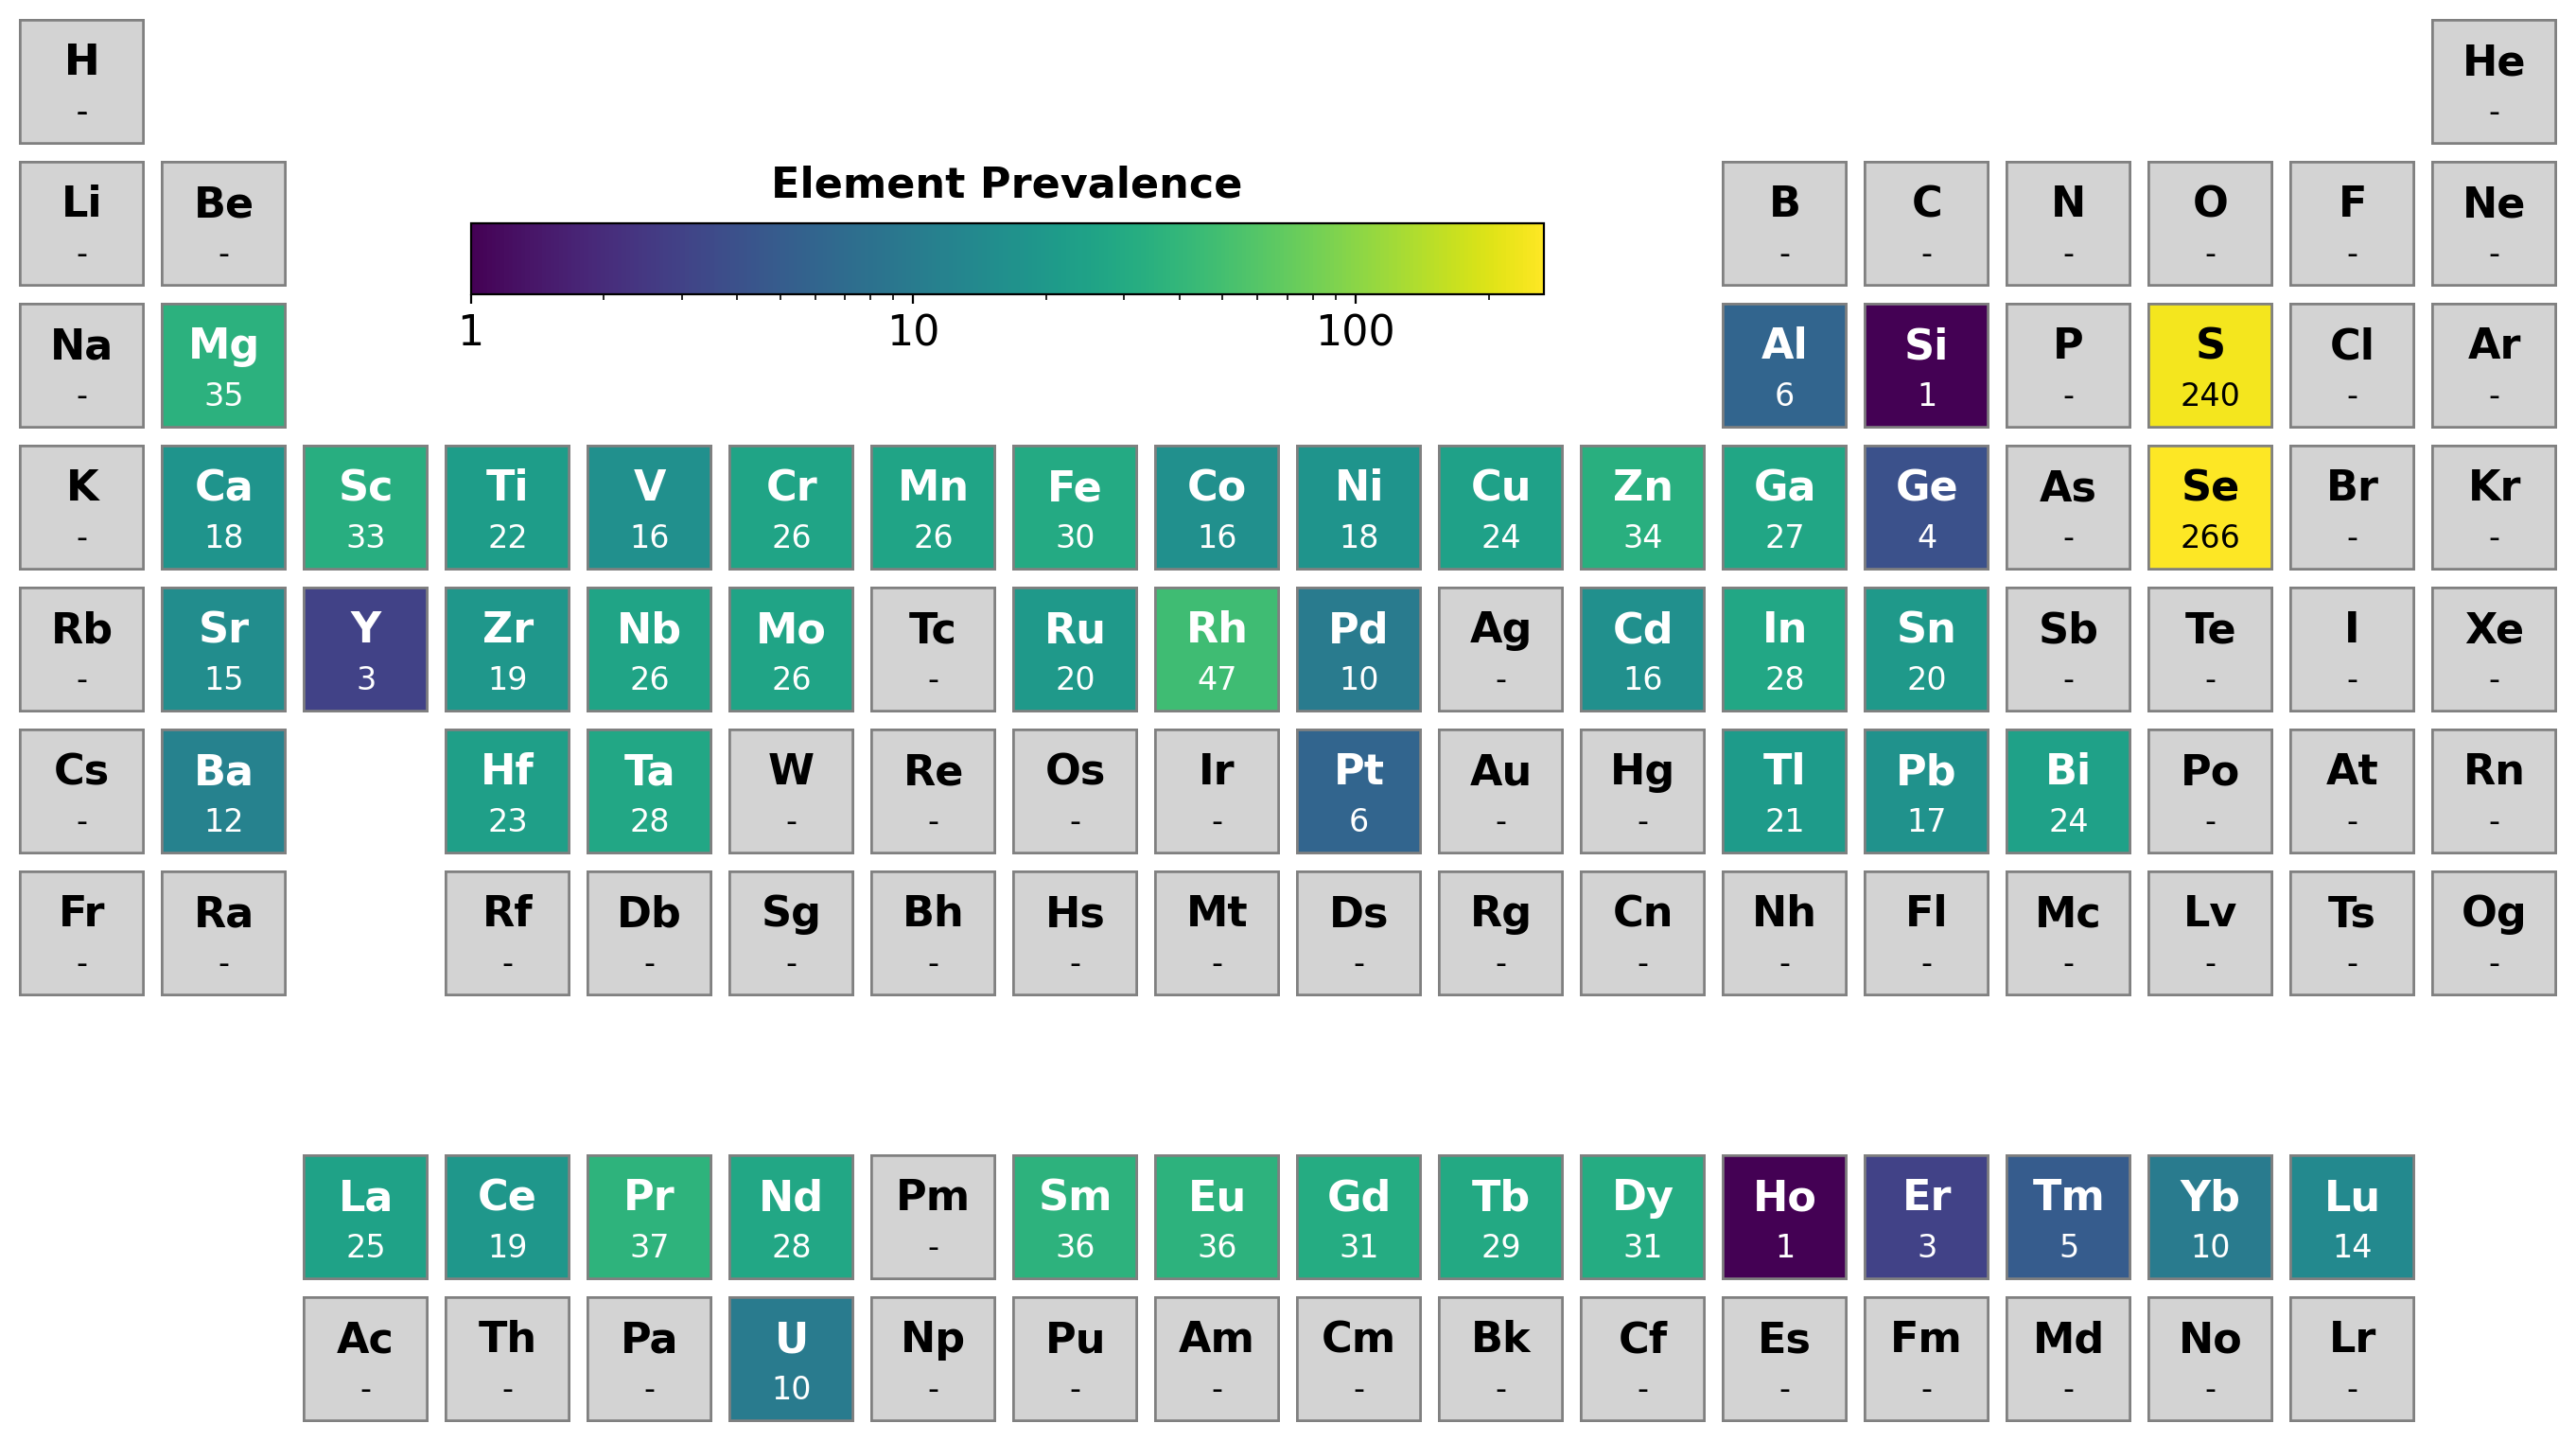

According to t_sisso_177, 799 (68.76075731497419%) compositions are predicted to be stable as perovskites:
['BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuSiSe3', 'EuVS3', 'EuVSe3', 'EuTiS3', 'EuTiSe3', 'EuRuS3', 'EuRuSe3', 'EuTaS3', 'EuTaSe3', 'EuNb

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


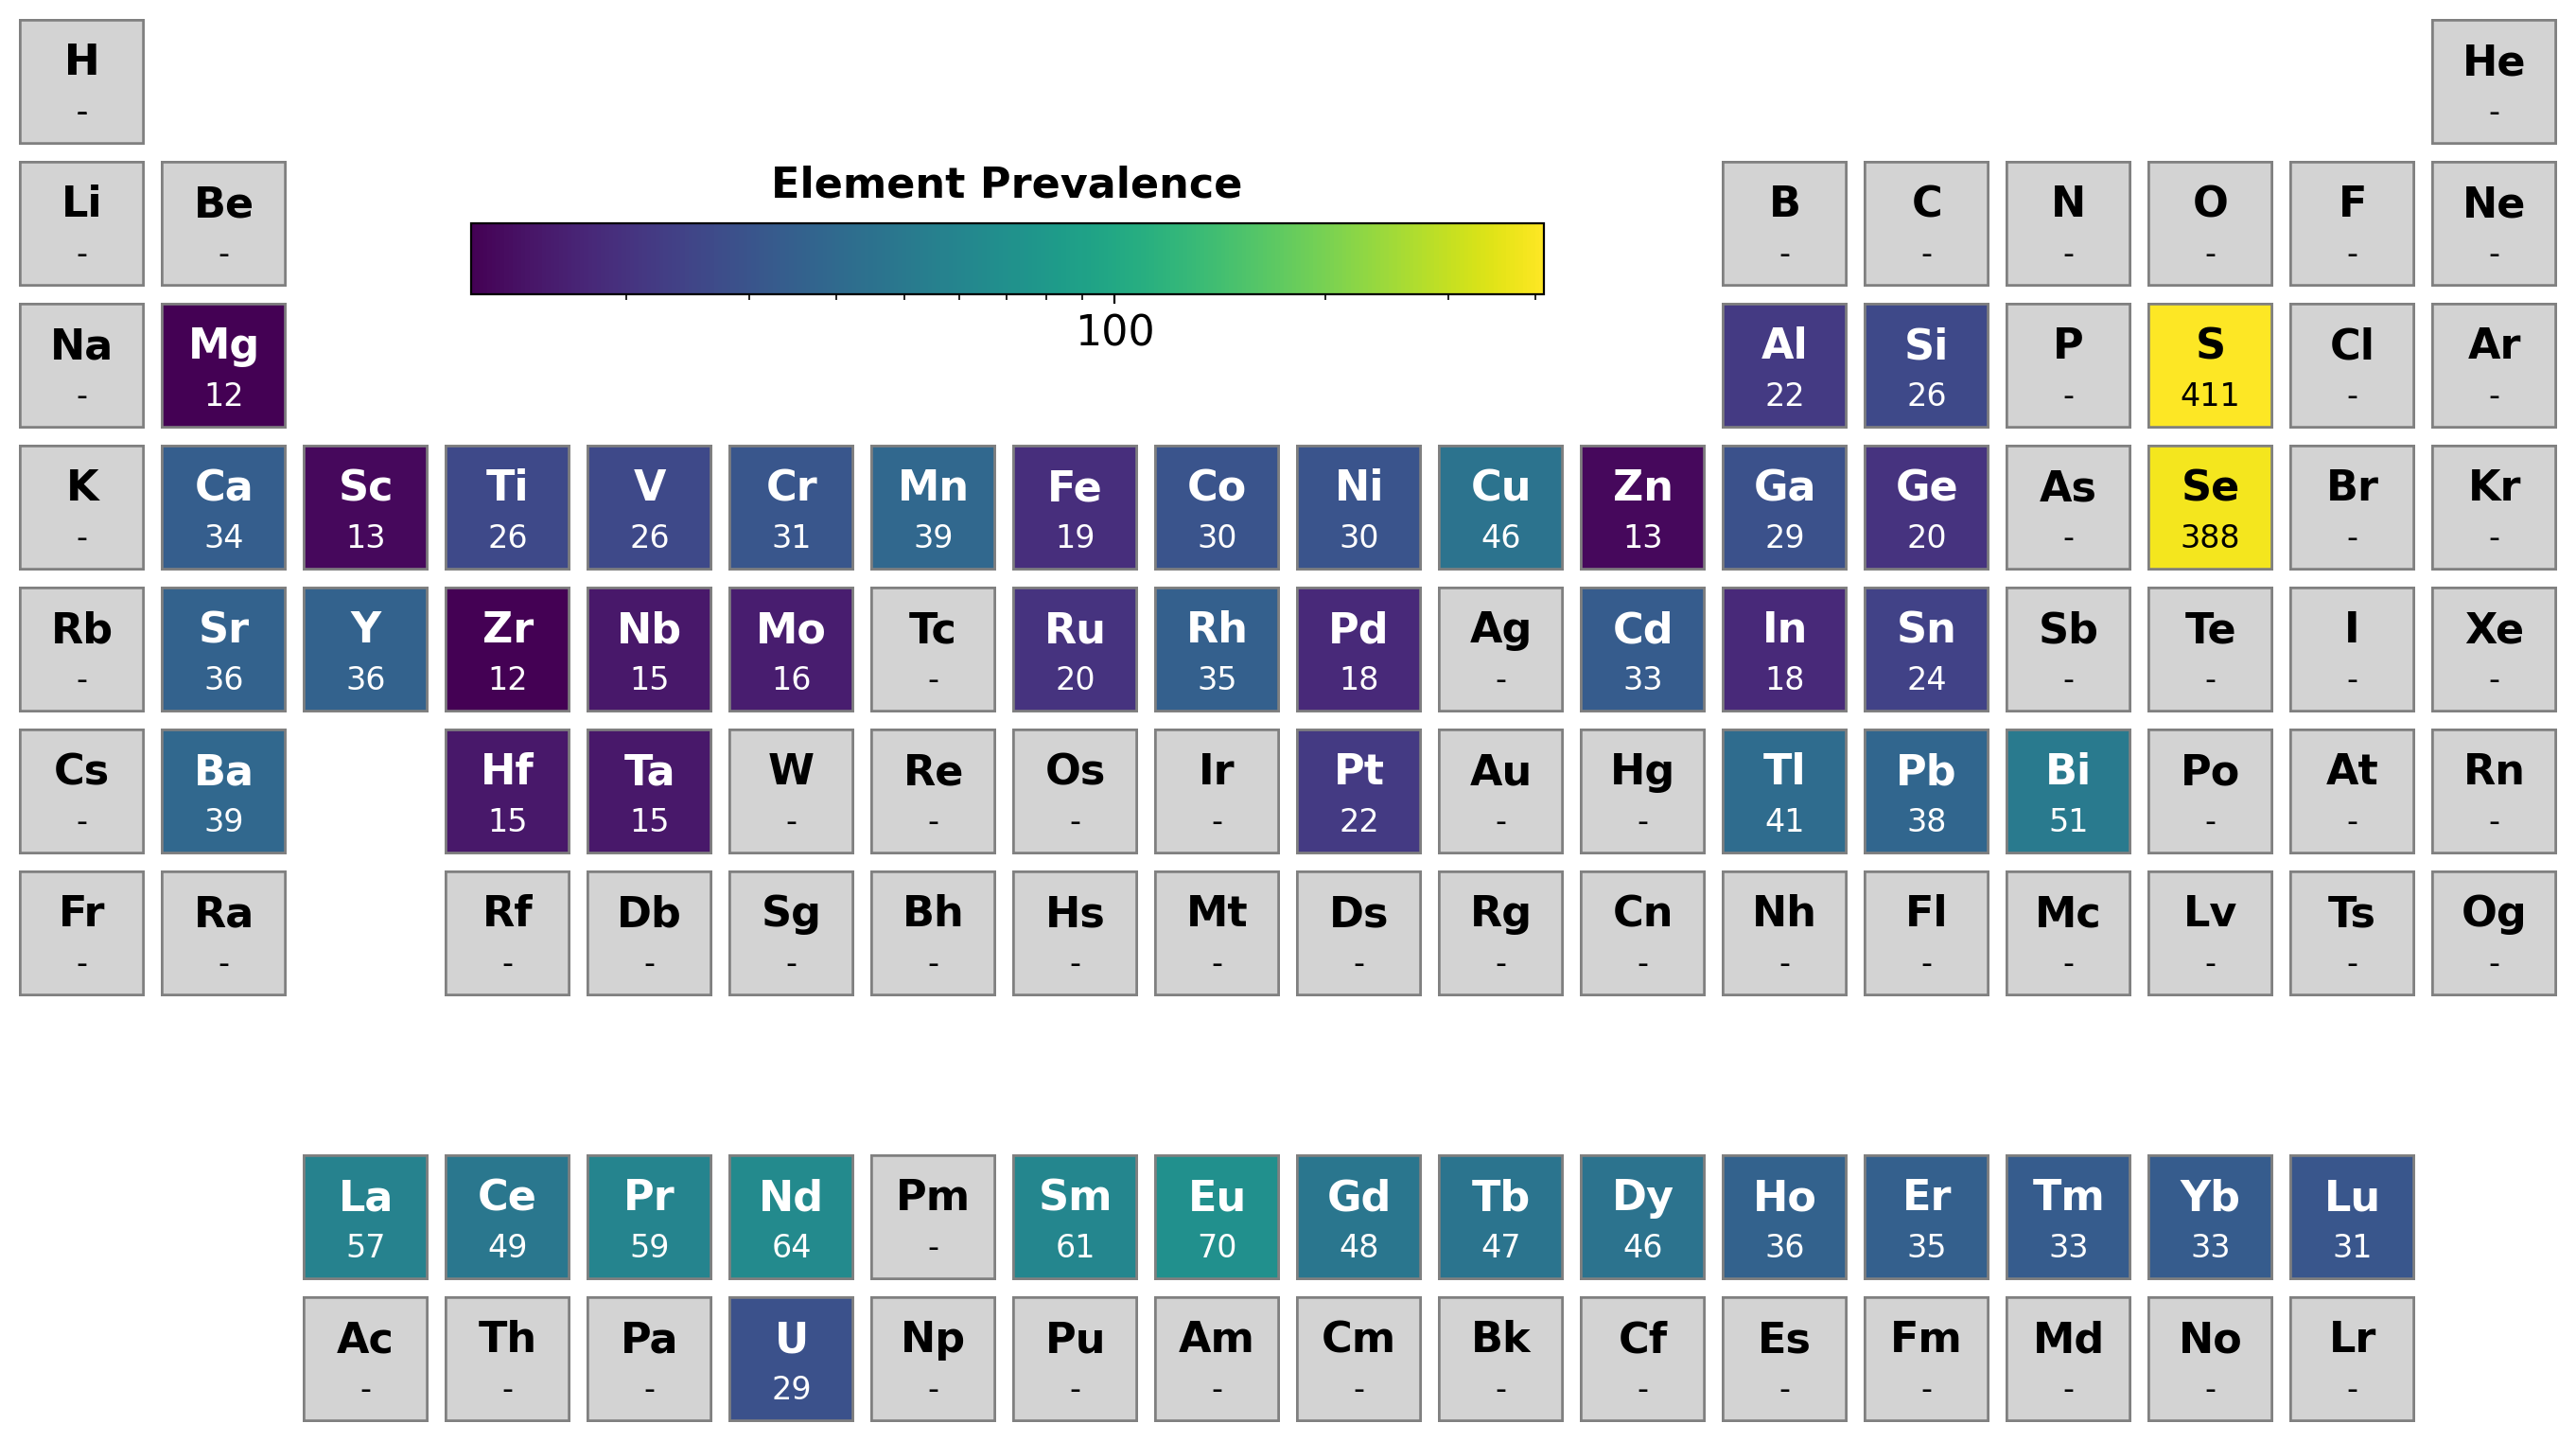

According to t_sisso_33, 365 (31.411359724612737%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPrS3', 'BaPrSe3', 'BaCeS3', 'BaCeSe3', 'BaUS3', 'BaUSe3', 'EuPbS3', 'EuPbSe3', 'EuCuSe3', 'EuScS3', 'EuScSe3', 'EuRhS3', 'EuRhSe3', 'EuMoS3', 'EuMoSe3', 'EuUS3', 'EuUSe3', 'EuCoSe3', 'EuGaSe3', 'EuFeS3', 'EuFeSe3', 'EuCrSe3', 'EuInS3', 'EuInSe3', 'EuMnS3', 'EuMnSe3', 'PbPrS3', 'PbPrSe3', 'PbCeS3', 'PbCeSe3', 'PbUS3', 'PbUSe3', 'SrPrS3', 'SrPrSe3', 'SrCeS3', 'SrCeSe3', 'SrTbS3', 'SrTbSe3', 'SrUS3', 'SrUSe3', 'CaSnSe3', 'CaPrSe3', 'CaCeSe3', 'CaHfS3', 'CaHfSe3', 'CaZrS3', 'CaZrSe3', 'CaTbS3', 'CaTbSe3', 'SnVS3', 'SnVSe3', 'SnRhS3', 'SnRhSe3', 'SnTiS3', 'SnTiSe3', 'SnTaS3', 'SnTaSe3', 'SnHfS3', 'SnHfSe3', 'SnZrS3', 'SnZrSe3', 'SnTbS3', 'SnTbSe3', 'CdPrSe3', 'CdCeSe3', 'CdTaSe3', 'CdNbSe3', 'CdHfS3', 'CdHfSe3', 'CdZrS3', 'CdZrSe3', 'CdTbS3', 'CdTbSe3', 'CuScS3', 'CuScSe3', 'CuRhS3', 'CuRhSe3', 'CuTiS3', 'CuTiSe3', 'CuHfS3', 'CuHfSe3', 'CuZrS3', 'CuZrSe3', 'CuTbS3', 'CuTb

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


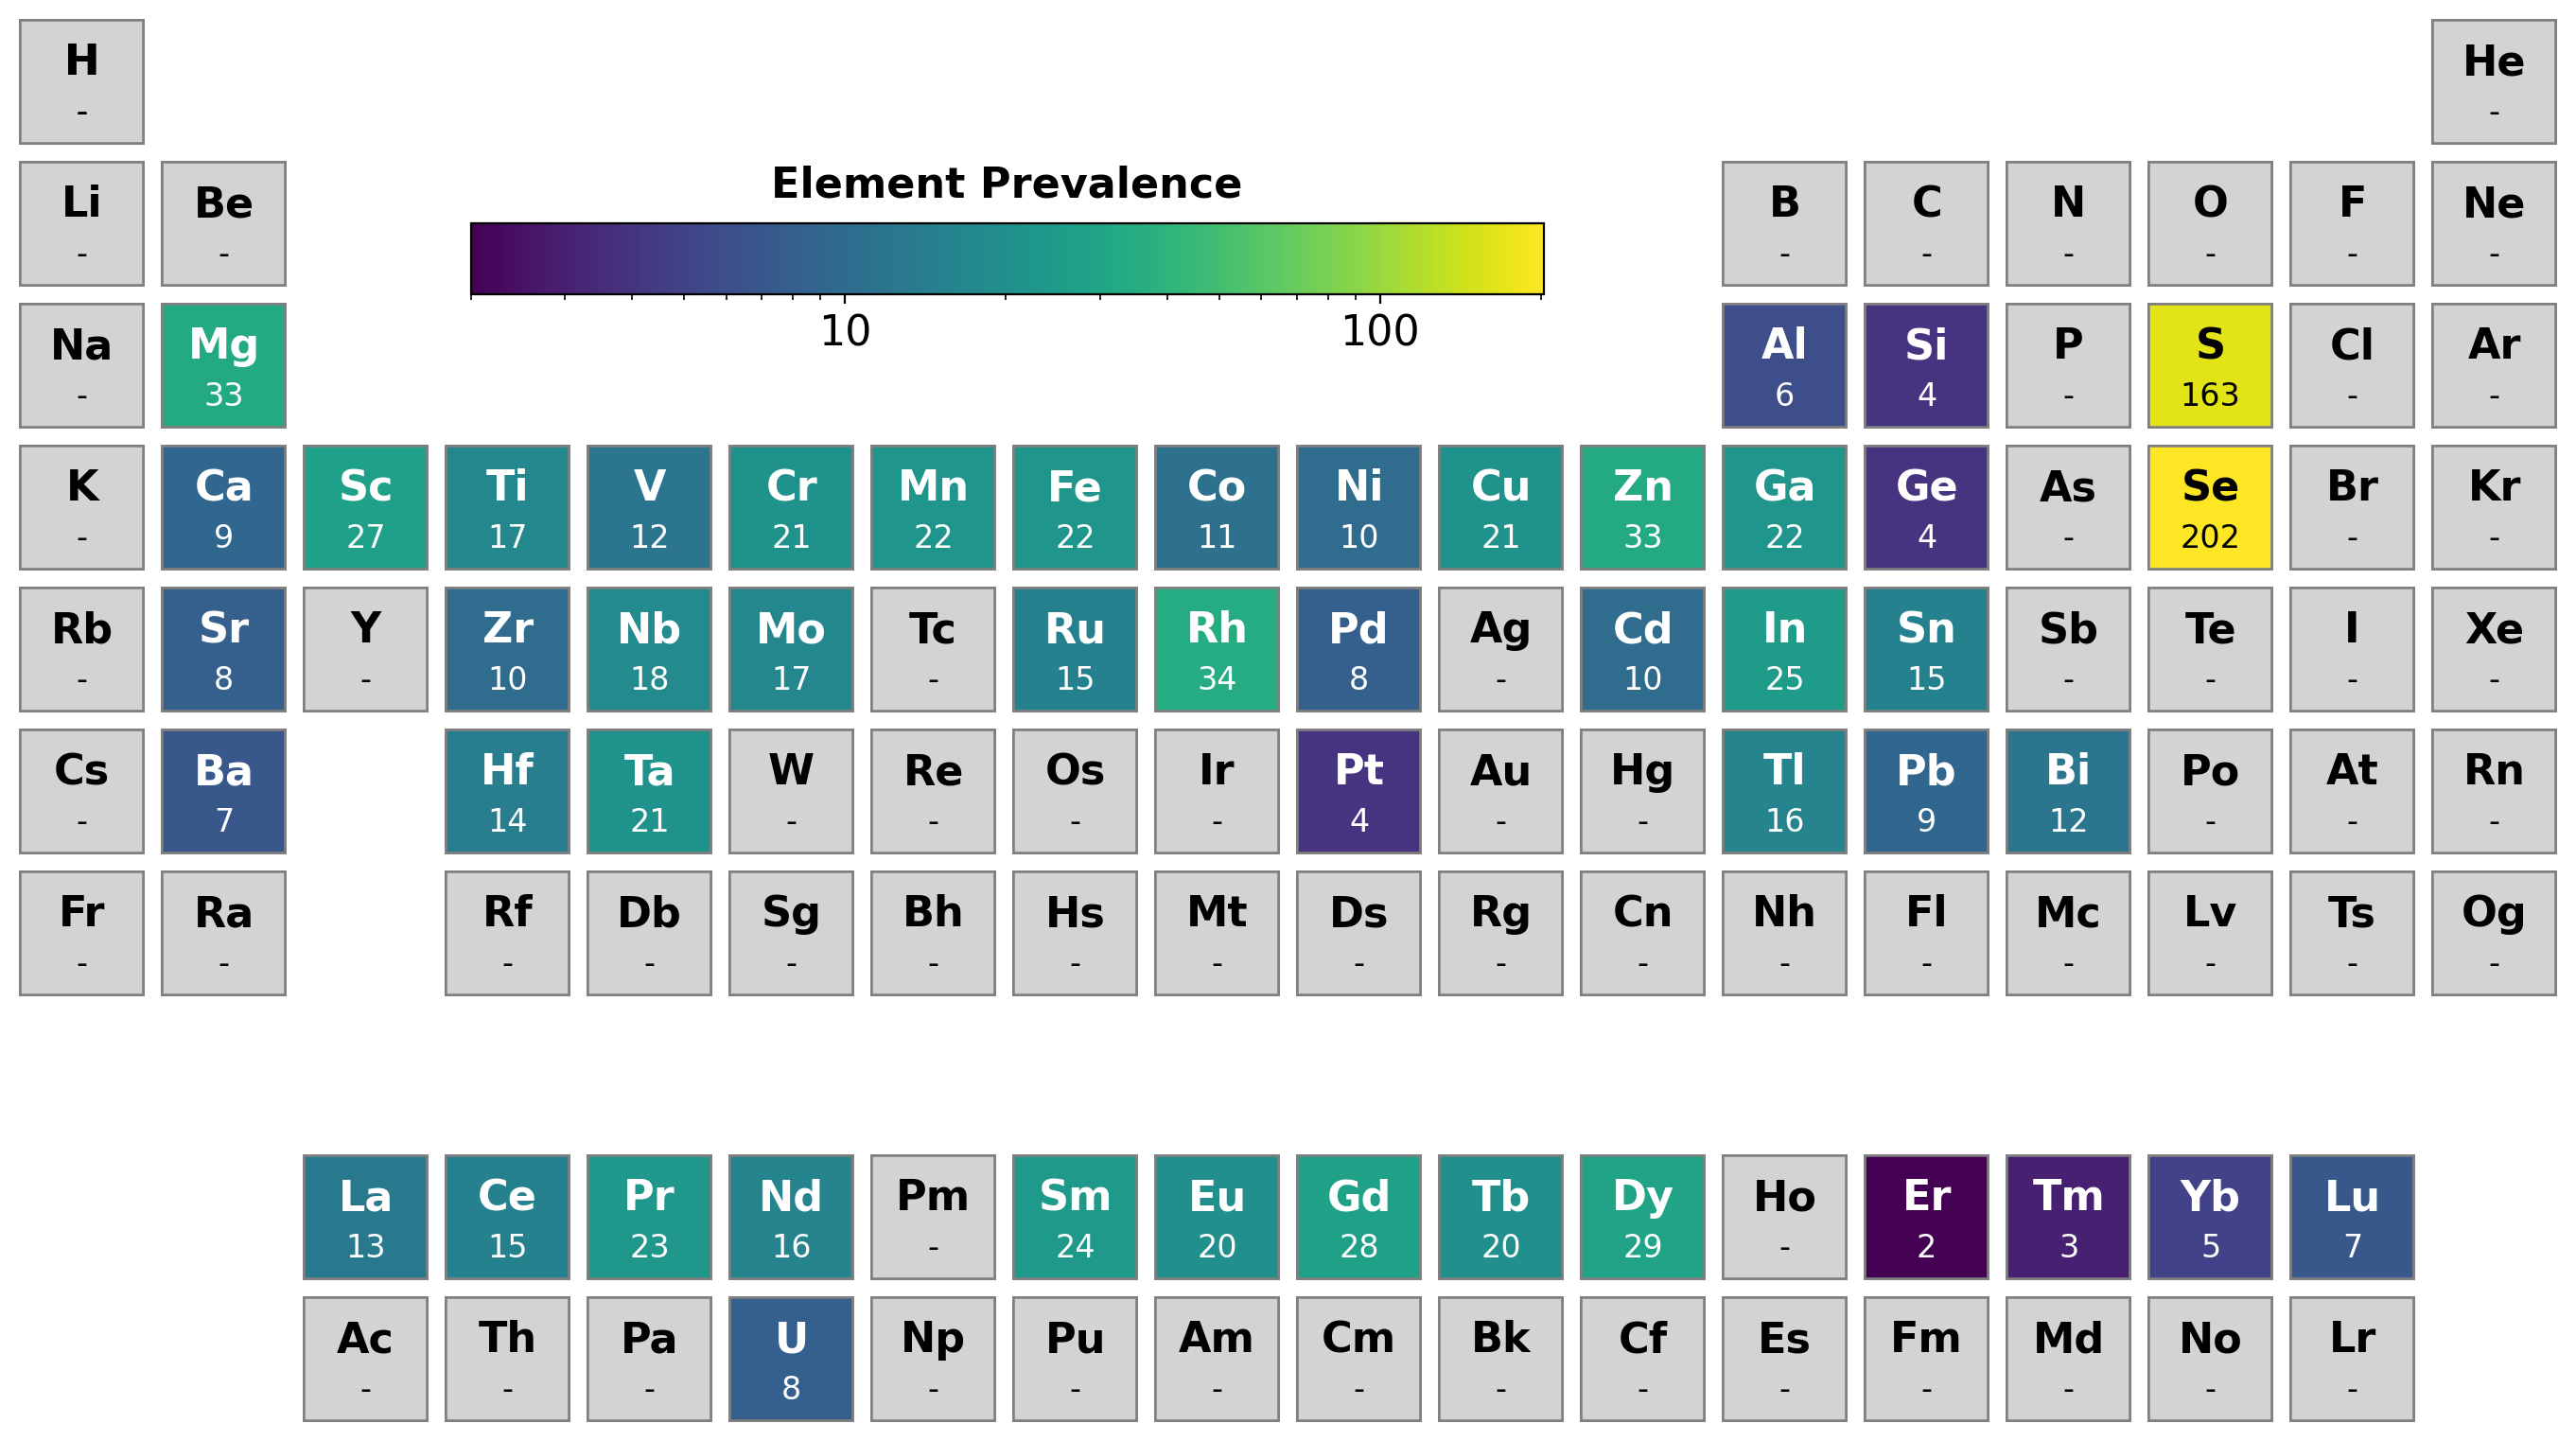

According to t_sisso_10, 521 (44.836488812392425%) compositions are predicted to be stable as perovskites:
['BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuTlS3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuSiSe3', 'EuVS3', 'EuVSe3', 'EuTiS3', 'EuTiSe3', 'EuTaS3', 'EuTbS3', 'EuTbSe3', 'PbGeS3', 'PbGeSe3', 'PbSiS3', 'PbSiSe3', 'PbVS3', 'PbVSe3', 'PbTiS3', 'PbTiSe3', 'PbTaS3',

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:166: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([re.sub(r'\d+', '', x) for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


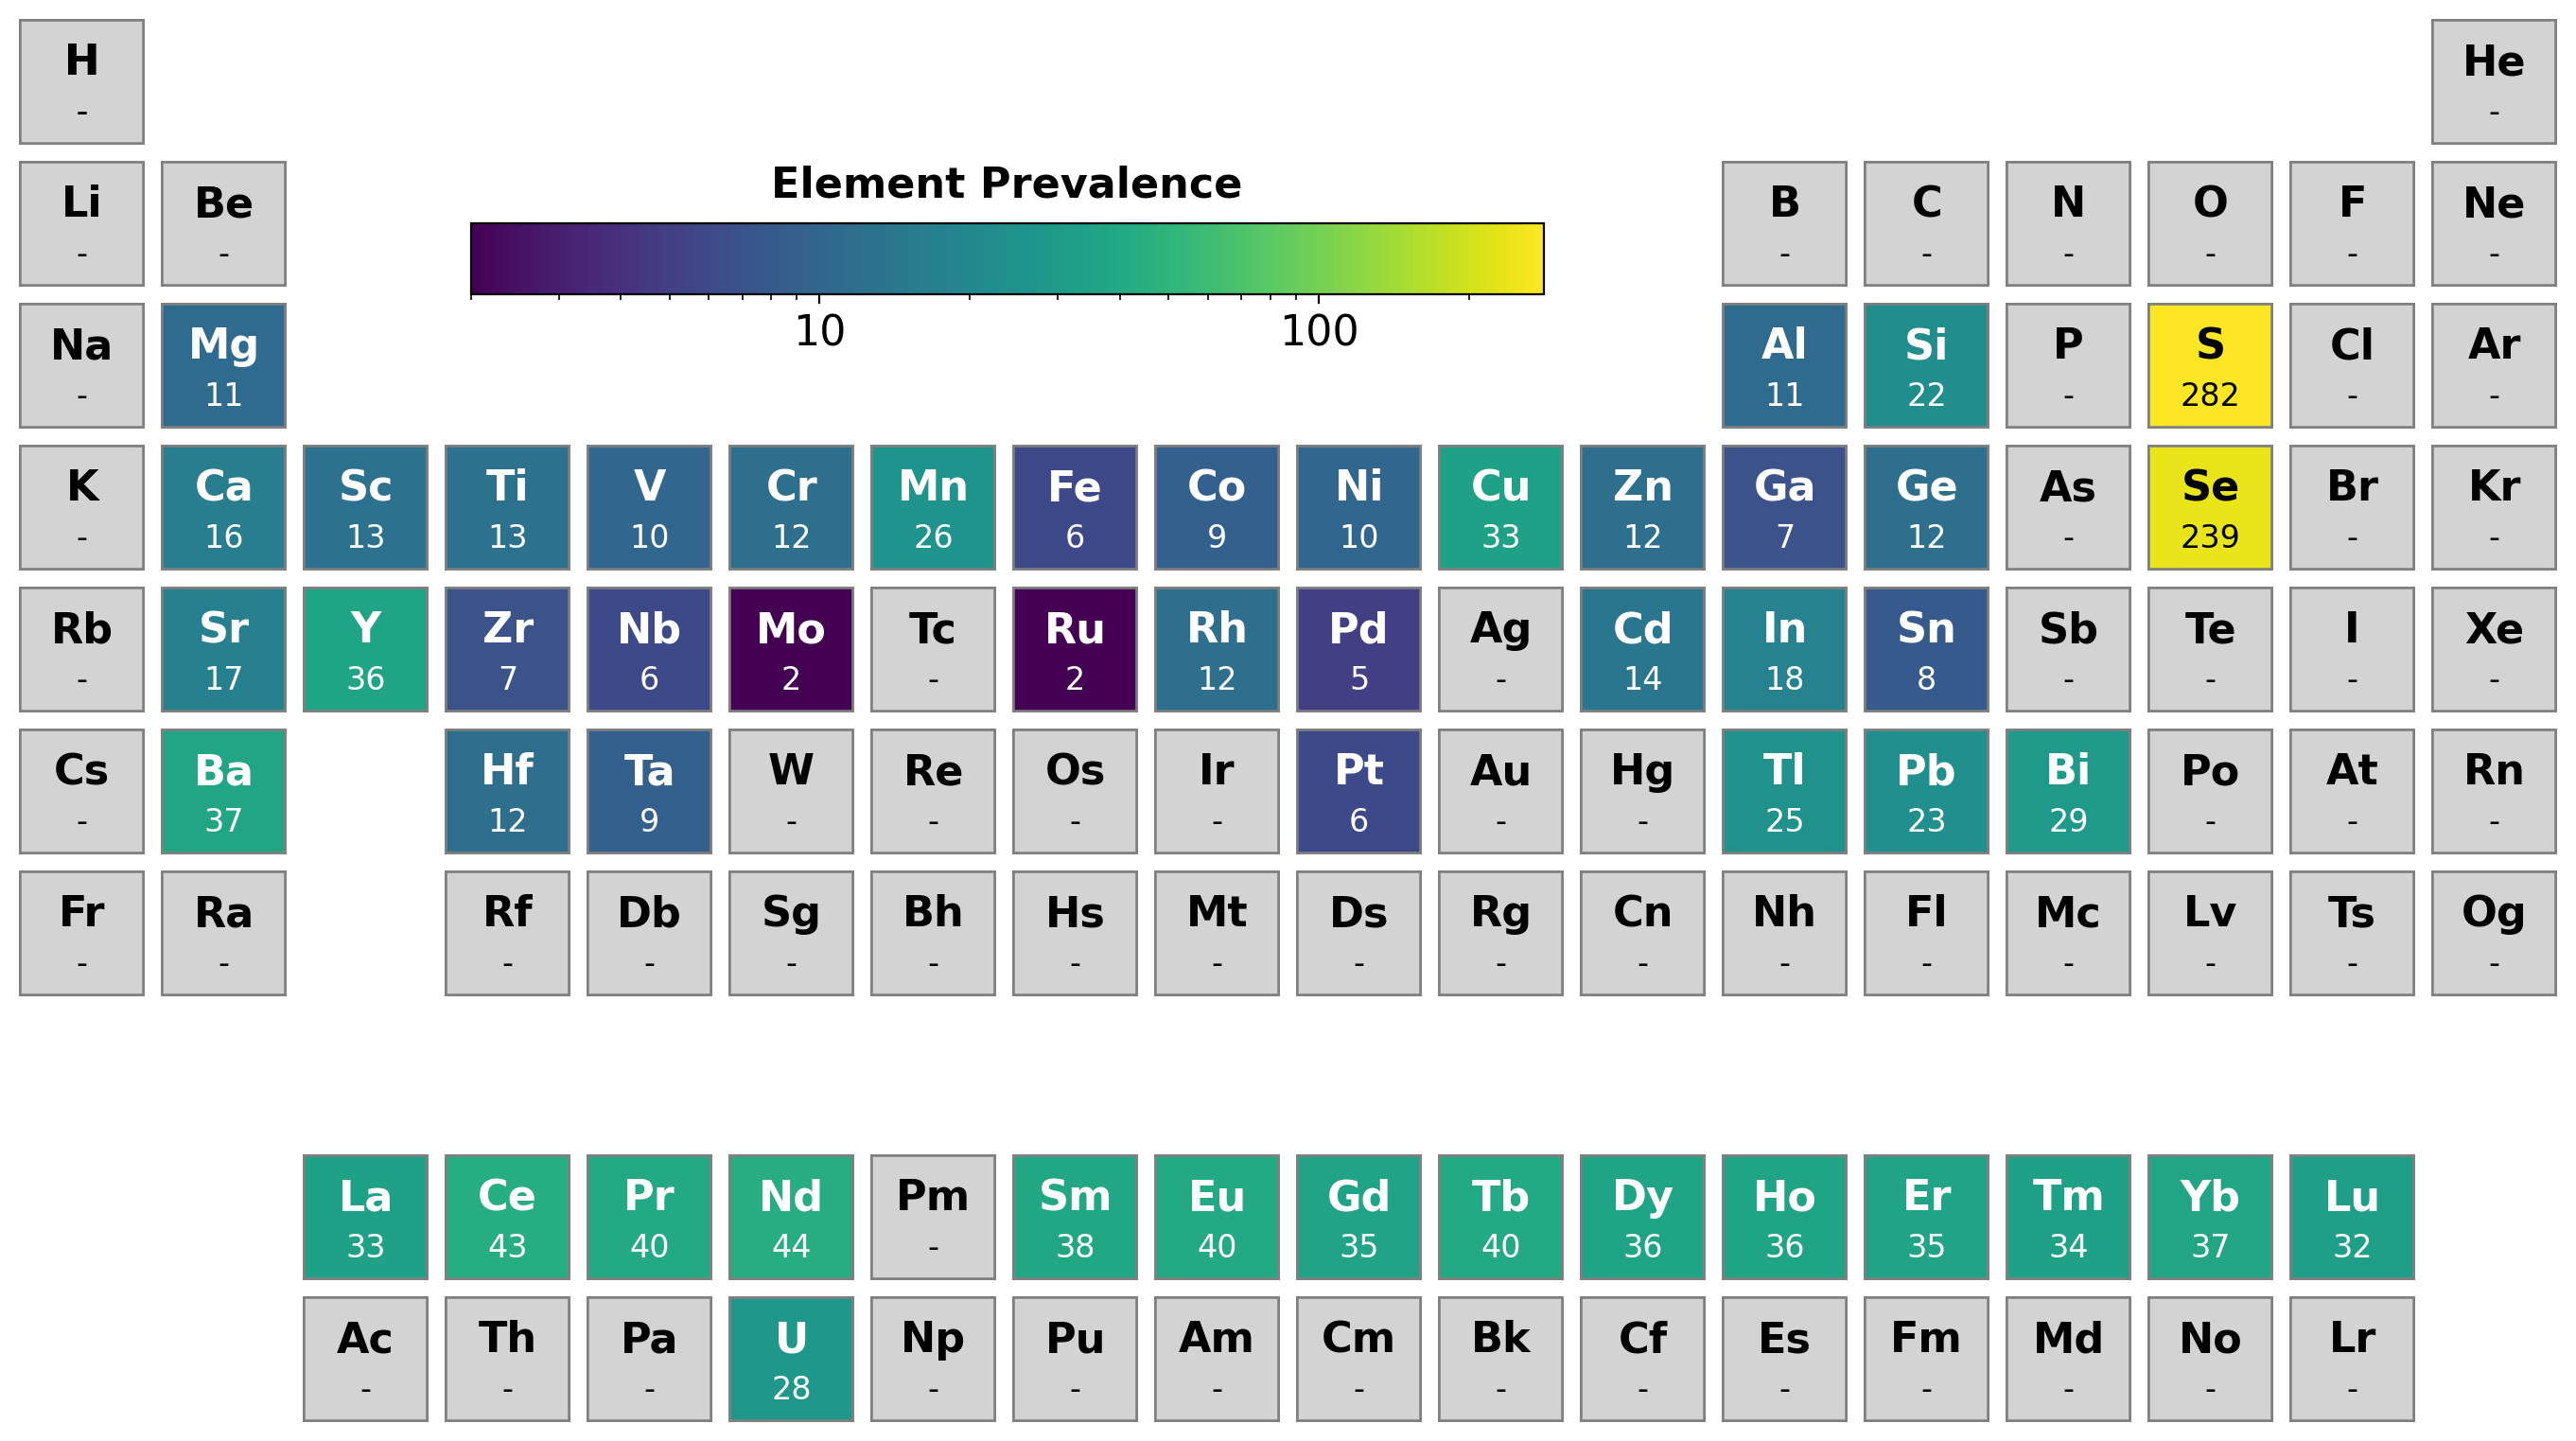

In [26]:
from tf_chpvk_pv.plots import graph_periodic_table

for t in tolerance_factor_dict_global.keys():
    if t not in ['t', 't_jess']:
        stable_candidates_t_sisso, df_out = check_stable_compositions(t, tolerance_factor_dict_path=new_tolerance_dict_path)
        graph_periodic_table(stable_candidates_t_sisso, t=t)

<Figure size 1000x1000 with 0 Axes>

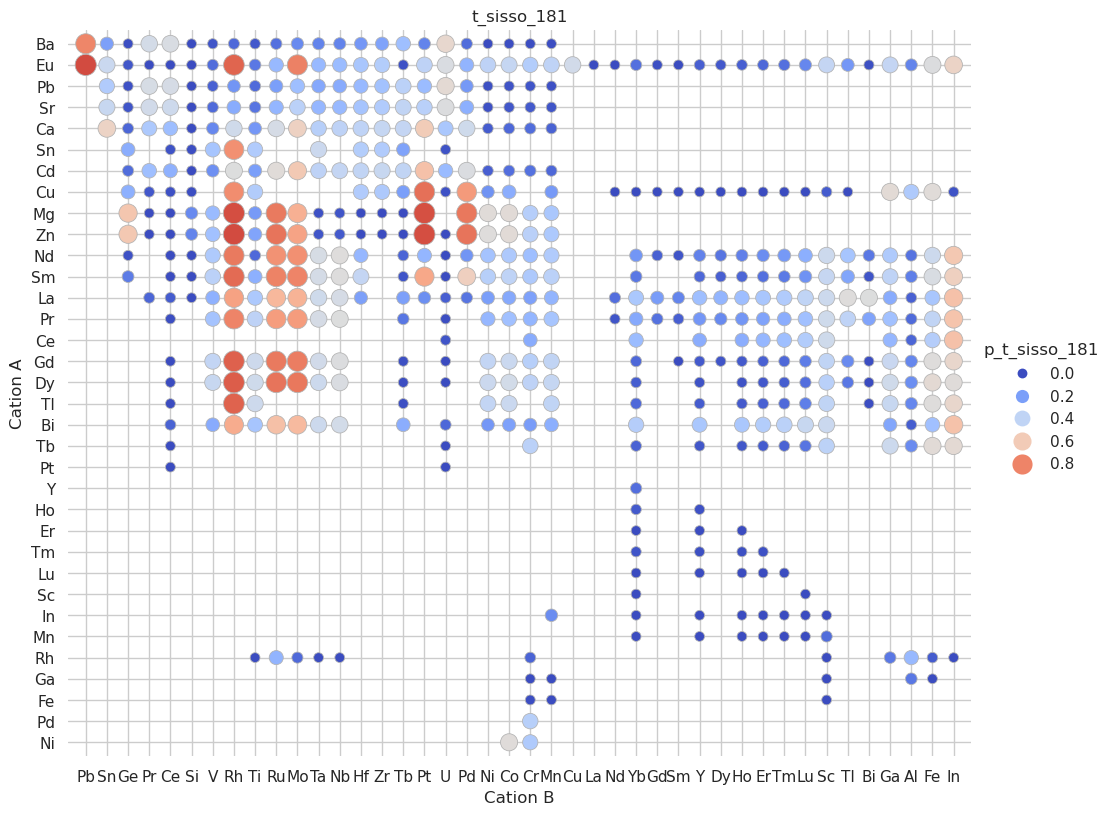

In [71]:
from tf_chpvk_pv.config import INTERIM_DATA_DIR

def plot_matrix(df_out, idx=None, anion='S',
                clf2_platt_path=INTERIM_DATA_DIR / 'Ch_clf2_platt.pkl',):

    import seaborn as sns
    import matplotlib.pyplot as plt
    from tf_chpvk_pv.config import FIGURES_DIR
    import pickle
    import numpy as np

    clf2_platt = pickle.load(open(clf2_platt_path, 'rb'))

    t = 't_sisso_'

    column_p = 'p_t_sisso_'

    if idx is not None:
        column_p = 'p_t_sisso_' + str(idx)
        t = 't_sisso_' + str(idx)
    else:
        column_p = 'p_t_sisso'
        t = 't_sisso'

    x_t = df_out[t].to_numpy()

    if column_p not in df_out.columns:
        clf2 = clf2_platt[t]
        df_out[column_p] = clf2.predict_proba(x_t.reshape(-1, 1))[:, 1]

    df_out = df_out[df_out['X'] == anion]
    #df_out = df_out[['rA', 'rB', 't_sisso_57']]

    df_plot = df_out.pivot(index='A', columns='B', values=column_p)
    #df_plot = df_plot < 4.377569

    """for a in df_plot.index:
        if df_plot.loc[a].isnull().sum() >= len(df_plot.columns)- 5:
            df_plot.drop(a, inplace=True)

    for b in df_plot.columns:
        if df_plot[b].isnull().sum() >= len(df_plot.index)- 10:
            df_plot.drop(columns=[b], inplace=True)"""

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 10))

    ax = sns.relplot(
    data=df_out, x='B', y='A', hue=column_p, size=column_p,
    palette="coolwarm", hue_norm=(0, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(0, 1),
    )
    #sns.heatmap(df_plot, cmap='coolwarm', vmin=0, vmax=1)
    plt.title(t)
    #plt.yticks(np.arange(0, len(df_plot.index.values), 1)+0.5, labels=df_plot.index.values)
    #plt.xticks(np.arange(0, len(df_plot.columns.values), 1)+0.5, labels=df_plot.columns.values)
    name_fig = 'matrix_cations_' + t + '.png'
    # Tweak the figure to finalize
    ax.set(xlabel="Cation B", ylabel="Cation A", aspect="equal")
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    ax.despine(left=True, bottom=True)
    ax.ax.margins(.02)
    plt.savefig(FIGURES_DIR / name_fig)
    plt.show()

#for t in tolerance_factor_dict_global.keys():
#    if t not in ['t', 't_jess', 'tau']:
#        idx = int(t.split('_')[-1])
#        plot_matrix(df_generated_comp, idx, anion='S')

plot_matrix(df_generated_comp, idx=181, anion='S')

/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LinearSVC from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator _SigmoidCalibration from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator CalibratedCl

<Figure size 1000x1000 with 0 Axes>

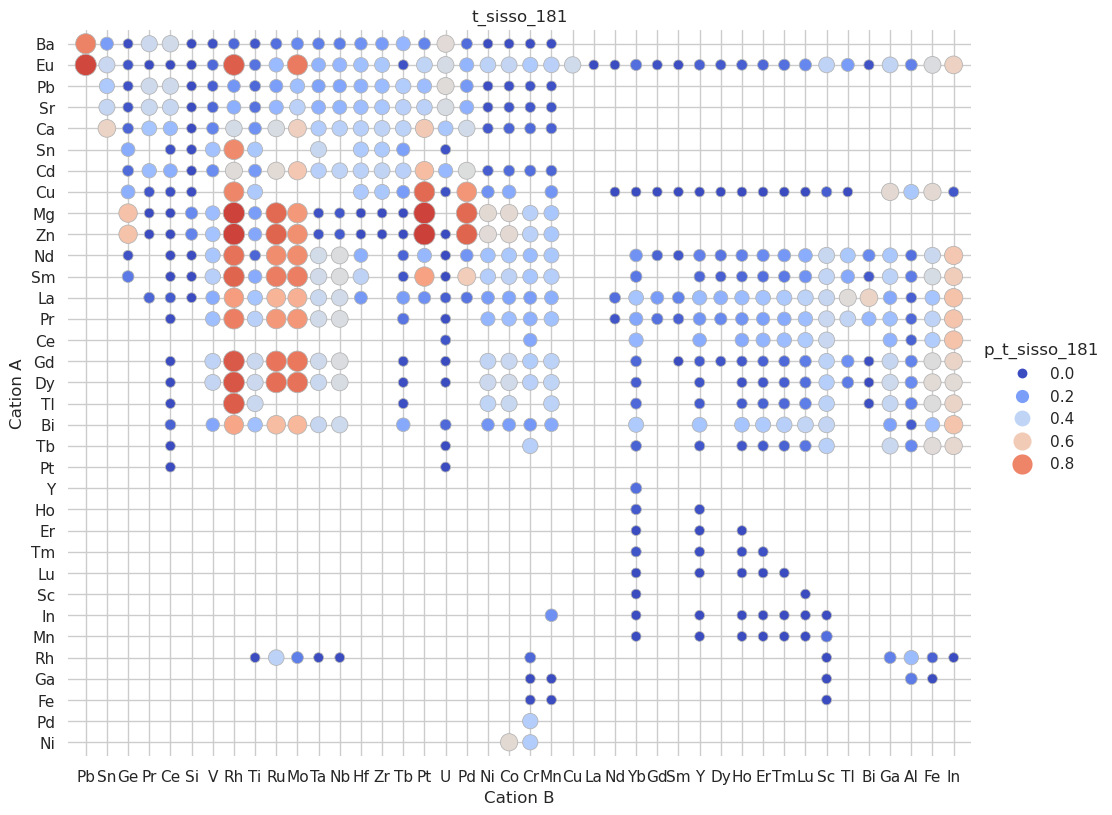

In [72]:
plot_matrix(df_generated_comp, idx=181, anion='Se')

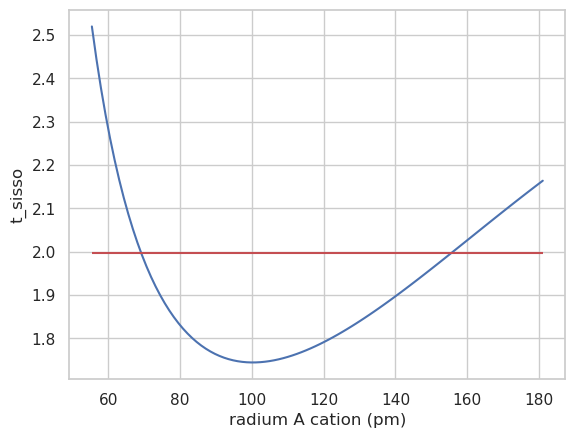

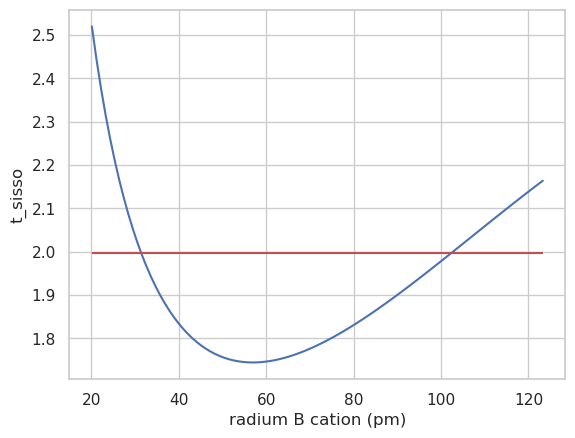

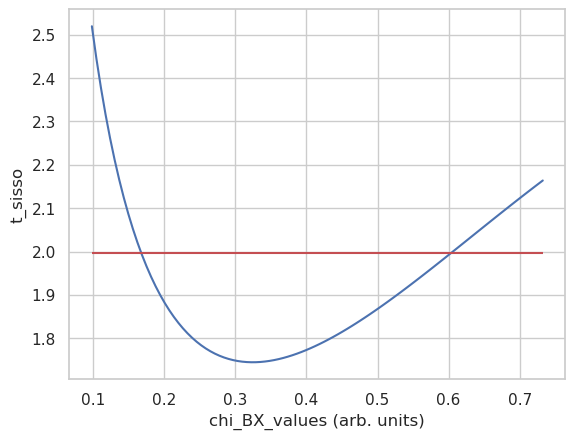

ValueError: Argument Z must be 2-dimensional.

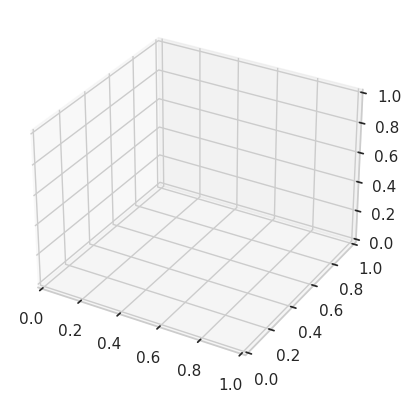

In [73]:
#TODO plot stuff vs r_A and r_B for different cations

def plot_vals(df, anion='S'):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    if anion == 'S':
        rX = 184.4
    elif anion == 'Se':
        rX = 198.14

    t_sisso = 't_sisso = (((rA_rX_ratio / rB_rX_ratio) - (chi_BX_ratio**3)) - (sqrt(rB_rX_ratio) - (chi_BX_ratio / log_rA_rB_ratio)))'

    r_A_values = np.linspace(df.rA.min()-20, df.rA.max()+20, 100)
    r_B_values = np.linspace(df.rB.min()-20, df.rB.max()+20, 100)
    chi_BX_values = np.linspace(df.chi_BX_ratio.min()-0.1, df.chi_BX_ratio.max()+0.1, 100)

    results_df = pd.DataFrame(columns=['rA_rX_ratio', 'rB_rX_ratio', 'chi_BX_ratio', 'log_rA_rB_ratio', 't_sisso'])
    results_df['rA_rX_ratio'] = r_A_values / rX
    results_df['rB_rX_ratio'] = r_B_values / rX
    results_df['chi_BX_ratio'] = chi_BX_values
    results_df['log_rA_rB_ratio'] = np.log(r_A_values / r_B_values)
    results_df.eval(t_sisso, inplace=True)



    plt.plot(r_A_values, results_df['t_sisso'])
    plt.hlines(1.9971271753311157, r_A_values.min(), r_A_values.max(), color='r')
    plt.xlabel('radium A cation (pm)')
    plt.ylabel('t_sisso')
    plt.show()

    plt.plot(r_B_values, results_df['t_sisso'])
    plt.hlines(1.9971271753311157, r_B_values.min(), r_B_values.max(), color='r')
    plt.xlabel('radium B cation (pm)')
    plt.ylabel('t_sisso')
    plt.show()

    plt.plot(chi_BX_values, results_df['t_sisso'])
    plt.hlines(1.9971271753311157, chi_BX_values.min(), chi_BX_values.max(), color='r')
    plt.xlabel('chi_BX_values (arb. units)')
    plt.ylabel('t_sisso')
    plt.show()

    ax = plt.figure().add_subplot(projection='3d')
    
    ax.plot_surface(r_B_values, chi_BX_values, results_df['t_sisso'], edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)
    
    plt.show()

plot_vals(df_generated_comp, anion='S')